# **Test 080424**

In [40]:
import pandas as pd
import json
import csv
import os

In [41]:
def read_data(file_path):
    """
       params:
           file_path: 文件路径
       return:
           data: 读取的数据列表，每行一条样本

    """
    data = []
    with open(file_path, "r") as f:
        for line in f.readlines():
            # 过长的评论文本会超出io限制报错。 暂时忽略
            try:\
                # 字符串预处理
                # 布尔替换成python的习惯
                str_text = line.replace("true", "True")
                str_text = str_text.replace("false", "False")
                # 转成字典形式
                raw_sample = json.loads(str_text)
                print(raw_sample)
                data.append(raw_sample)
            except:
                print(line)
                pass
    return data

def read_and_split_data(file_path, batch_size=10000):
    """
       params:
           file_path: 文件路径
       return:
           data: 读取的数据列表，每行一条样本

    """
    data = []
    small_list_data = []
    count = 0
    with open(file_path, "r") as f:
        for line in f.readlines():
            if count < batch_size:
                # 过长的评论文本会超出io限制报错。 暂时忽略
                try:
                    # 字符串预处理
                    # 布尔替换成python的习惯
                    str_text = line.replace("true", "True")
                    str_text = str_text.replace("false", "False")
                    # 转成字典形式
                    raw_sample = eval(str_text)
                    data.append(raw_sample)
                    count += 1
                except:
                    pass
            else:
                small_list_data.append(data)
                data = []
                count = 0
    small_list_data.append(data)
    return small_list_data

def read_txt_file_to_list(file_path):
    records = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            records.append(line.strip())
    return records


def remove_duplicate_rows(df):
    # Loại bỏ các hàng trùng lặp dựa trên cột 'reviewText'
    df = df.drop_duplicates(subset=['reviewText', 'asin', 'reviewerID'])
    return df

def remove_duplicate_rows_ver2(df):
    # Loại bỏ các hàng trùng lặp dựa trên cột 'reviewText'
    df = df.drop_duplicates(subset=['reviewText', 'itemID', 'reviewerID'])
    return df

In [42]:
file_number = 13141516
dataset_name = "Digital_Music_5"
json_file_path = "./DeepCGSR_triet/data/raw/Digital_Music_5.json"  # Thay đổi đường dẫn tới file JSON của bạn
output_directory = "./DeepCGSR_triet/data/DigitalMusic/"  # Thay đổi đường dẫn thư mục lưu file CSV của bạn
small_dataset = "Small_Digital_Music_10000_" + str(file_number) + ".json"
chunk_size = 10000  # Kích thước của mỗi phần dữ liệu

extracted_data = output_directory + "extract/" + dataset_name + "_extracted_data_" + str(file_number) + ".csv"
filtered_data = output_directory + "filtered/" + dataset_name + "_filtered_data_" + str(file_number) + ".csv"
outliner_data = output_directory + "outliner/" + dataset_name + "_outliner_data_" + str(file_number) + ".csv"

final_json_name = "Digital_Music_Filtered_" + str(file_number) + ".json"


In [43]:


# small_list_data = read_and_split_data(json_file_path, chunk_size)
# count_name = 0
# for data in small_list_data:
#     # Chuyển đổi dữ liệu thành DataFrame
#     data_df = pd.DataFrame(data)
#     print(data_df)
#     # data_df.columns = ['reviewerID', 'asin', 'overall', 'reviewText']

#     # Lưu dữ liệu dưới dạng CSV
#     output_file_path = os.path.join(output_directory, f"Small_Digital_Music_{len(data_df)}_{count_name}.json")
#     data_df.to_json(output_file_path, orient='records', lines=True)

#     print(f"Saved {len(data_df)} records to {output_file_path}")
#     count_name += 1

In [44]:
data = pd.read_json(output_directory + small_dataset, lines=True)
print(data)
data_df = pd.DataFrame(data, columns=['reviewerID', 'asin', 'overall', 'reviewText'])
print(data_df.head())
data_df.columns = ['reviewerID', 'asin', 'overall', 'reviewText']

data_rating = data_df["overall"].tolist()
data_review = data_df["reviewText"].tolist()
data_reviewerID = data_df["reviewerID"].tolist()
data_itemID = data_df["asin"].tolist()

       overall  verified   reviewTime      reviewerID        asin  \
0            5      True  06 14, 2015  A3QJRRC3OBW1JS  B001229ZW4   
1            3      True   06 1, 2015  A3VP0N3QY6XVYE  B001229ZW4   
2            5      True   01 2, 2015  A1XNWOV39TF50P  B001229ZW4   
3            5      True   02 1, 2017  A2TS84CV5PTG0V  B00122B8VU   
4            5      True  12 19, 2015   ACCQS2S225D6V  B00122B8VU   
...        ...       ...          ...             ...         ...   
39760        5      True  08 19, 2018  A1SR2T84IXOMAQ  B01HJ91MTW   
39761        5      True  03 18, 2018  A2SR3DWJR1PYR6  B01HJ91MTW   
39762        5      True   03 7, 2018  A24V7X30NIMOIY  B01HJ91MTW   
39763        5      True  02 12, 2018  A1LW10GYP2EYM1  B01HJ91MTW   
39764        5      True  01 27, 2018  A26TH3YW0QWPI7  B01HJ91MTW   

                           style         reviewerName  \
0      {'Format:': ' MP3 Music'}         kathy neilly   
1      {'Format:': ' MP3 Music'}  Gardner Enterprises   


In [45]:
print(len(data_rating))
print(len(data_reviewerID))

39765
39765


In [46]:
import pandas as pd
# step01:
def defineRating(data_rating):
  T_v = []
  for rating in data_rating:
    if rating >= 4:
      T_v.append(1)
    else:
      T_v.append(-1)
  return T_v

T_v = defineRating(data_rating)

# Define the data for the dataframe
data = {'id': range(len(T_v)), 'T_v': T_v}

# Create the dataframe
df_rating = pd.DataFrame(data)

# Print the dataframe
print(df_rating)


          id  T_v
0          0    1
1          1   -1
2          2    1
3          3    1
4          4    1
...      ...  ...
39760  39760    1
39761  39761    1
39762  39762    1
39763  39763    1
39764  39764    1

[39765 rows x 2 columns]


In [47]:
# Thêm vào dataframe df_rating cột C_v
df_rating['reviewerID'] = data_reviewerID
df_rating['asin'] = data_itemID
df_rating['overall'] = data_rating
df_rating['reviewText'] = data_review
# Loại bỏ các dòng có reviewText trùng lặp
# df_rating = remove_duplicate_rows(df_rating)
print(df_rating)

          id  T_v      reviewerID        asin  overall  \
0          0    1  A3QJRRC3OBW1JS  B001229ZW4        5   
1          1   -1  A3VP0N3QY6XVYE  B001229ZW4        3   
2          2    1  A1XNWOV39TF50P  B001229ZW4        5   
3          3    1  A2TS84CV5PTG0V  B00122B8VU        5   
4          4    1   ACCQS2S225D6V  B00122B8VU        5   
...      ...  ...             ...         ...      ...   
39760  39760    1  A1SR2T84IXOMAQ  B01HJ91MTW        5   
39761  39761    1  A2SR3DWJR1PYR6  B01HJ91MTW        5   
39762  39762    1  A24V7X30NIMOIY  B01HJ91MTW        5   
39763  39763    1  A1LW10GYP2EYM1  B01HJ91MTW        5   
39764  39764    1  A26TH3YW0QWPI7  B01HJ91MTW        5   

                                              reviewText  
0                                                Love it  
1               Needed it for a Christmas light display!  
2                                                  yeah!  
3      great for my MP3 player.  Classic song that ma...  
4      w

# SODCM

# BERT

In [48]:
import nltk
import math
import spacy
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from flair.data import Sentence
from flair.nn import Classifier
from flair.models import TextClassifier

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

pos_words = read_txt_file_to_list("./DeepCGSR_triet/data/positive-words.txt")
neg_words = read_txt_file_to_list("./DeepCGSR_triet/data/negative-words.txt")
print(pos_words)
print(neg_words)
a = ['JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS']
brands = ['dove', 'aveda', 'silver']
keywords = ['overall', 'summary']

tagger = Classifier.load('pos')
# Load the spaCy English model
nlp = spacy.load("en_core_web_sm")
def remove_stopwords(sentence):
    """
    Loại bỏ các từ dừng từ câu sử dụng NLTK.

    Parameters:
    - sentence (str): Câu cần loại bỏ từ dừng.

    Returns:
    - str: Câu sau khi loại bỏ các từ dừng.
    """
    # Tách câu thành các từ
    words = word_tokenize(sentence)

    # Tải danh sách từ dừng từ NLTK
    stop_words = set(stopwords.words('english'))

    # Loại bỏ các từ dừng
    filtered_words = [word for word in words if word.lower() not in stop_words]

    # Ghép lại các từ thành câu mới
    filtered_sentence = ' '.join(filtered_words)

    return filtered_sentence

# df_rating['reviewText'] = df_rating['reviewText'].apply(remove_stopwords)

def get_sentiment_words(text):
    # Khởi tạo SentimentIntensityAnalyzer
    sia = SentimentIntensityAnalyzer()

    # Tách câu thành các từ
    words = nltk.word_tokenize(text)

    # Lấy danh sách các từ ngừng (stop words)
    stop_words = set(stopwords.words('english'))

    # Danh sách các từ có cảm xúc
    sentiment_words = []

    # Kiểm tra từng từ trong câu
    for word in words:
        print(word, " - ", sia.polarity_scores(word)['compound'])
        # Nếu từ không phải là từ ngừng và có điểm tính cảm từ VADER lớn hơn 0
        # if word.lower() not in stop_words and sia.polarity_scores(word)['compound'] > 0:
        if word.lower() not in stop_words and sia.polarity_scores(word)['compound'] != 0:
            sentiment_words.append(word)

    return sentiment_words


def sentiment_analysis_flair(sentence):
    # Kiểm tra xem câu có rỗng không
    if not sentence.strip():
        return 0.0
    # Load pretrained sentiment model
    classifier = TextClassifier.load('en-sentiment')

    # Create a Flair Sentence
    flair_sentence = Sentence(sentence)

    # Predict sentiment
    classifier.predict(flair_sentence)
    # print(flair_sentence)
    # Get sentiment value (POSITIVE/NEGATIVE) and score
    sentiment_value = flair_sentence.labels[0].value
    sentiment_score = flair_sentence.labels[0].score
    score = 0.0
    bias = 1.0
    for keyword in keywords:
        if keyword.lower() in sentence.lower():
            bias = 1.75
    
    if(sentiment_value == 'POSITIVE'):
        score = sentiment_score * bias
    else:
        score = -sentiment_score * bias

    return score

#Define the text to analyze

def sentiment_analysis(text, model, tokenizer):
    # Tokenize the text
    # print(text)
    if not text:
        return -1
    text = text[:512]
    inputs = tokenizer(text, return_tensors='pt')

    # Perform sentiment analysis
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the predicted probabilities for each class
    probs = softmax(outputs.logits, dim=1).squeeze()
    # print(probs)
    # Convert the probabilities to human-readable labels
    labels = [1, 2, 3, 4, 5]  # For this model, it predicts star ratings
    
    predicted_label = labels[torch.argmax(probs).item()]
    # print(predicted_label)
    return predicted_label

def check_string(input_value):
    # Kiểm tra xem giá trị có phải là chuỗi hay không
    if isinstance(input_value, str):
        # Nếu là chuỗi, trả về giá trị không thay đổi
        return input_value
    else:
        # Nếu không phải là chuỗi, trả về chuỗi rỗng
        return ''

def seperate_sentences(text):
    text = check_string(text)
    doc = nlp(text)
    # Khởi tạo một danh sách để lưu trữ các câu
    sentences = []
    current_sentence = ""
    # Duyệt qua mỗi từ trong văn bản
    for token in doc:
        # Nếu từ hiện tại không phải là dấu kết thúc câu, thêm từ vào câu hiện tại
        
        if token.is_sent_start or token.text == "\n":
            # Nếu có câu hiện tại, thêm câu vào danh sách câu
            if current_sentence:
                sentences.append(current_sentence.strip())
            # Bắt đầu một câu mới
            current_sentence = token.text
        elif token.text in ["but", "and", "so", "althought", "however", "because", "therefore", "meanwhile", "moreover", "nevertheless", "nonetheless", "otherwise", "thus", "yet"]:
            # print("that but:", current_sentence)
            if (brand.lower() in current_sentence.lower() for brand in brands):
                # print("need continue: ", current_sentence)
                current_sentence += " " + token.text
                continue
            elif current_sentence:
                sentences.append(current_sentence.strip())
                current_sentence = token.text
        else:
            # Thêm từ vào câu hiện tại
            current_sentence += " " + token.text
    # Thêm câu cuối cùng vào danh sách câu
    if current_sentence:
        sentences.append(current_sentence.strip())
    return sentences

def split_sentences_and_filter_sentiment(text):
    # Initialize SentimentIntensityAnalyzer
    sia = SentimentIntensityAnalyzer()

    # Tách đoạn văn thành các câu nhỏ
    # sentences = nltk.sent_tokenize(text)
    sentences = seperate_sentences(text)
    if len(sentences) == 1 and not re.search(r'[.!?]', text):
        sentences = [text]
    # print(sentences)
    # Lọc các câu không chứa bất kỳ từ miêu tả cảm xúc nào
    filtered_sentences = []
    for sentence in sentences:
        # print("---- sentence ------")
        if not sentence.strip():
            continue
        sentence = sentence.strip()
        words = nltk.word_tokenize(sentence)
        
        # for word in words:
        #     if(sia.polarity_scores(word)['compound'] != 0 ):
        #         print(word, ":", sia.polarity_scores(word)['compound'])

        contains_sentiment = (any(sia.polarity_scores(word)['compound'] != 0 for word in words) or 
                              any(word.lower() in pos_words or word.lower() in neg_words for word in words))
        for word in words:
            if(word.lower() in brands):
                contains_sentiment = False
        # Flair
        
        sentence_flair = Sentence(sentence)
        tagger.predict(sentence_flair)
        # print(sentence_flair.tokens)
        is_a = False
        for token in sentence_flair.tokens:
            for label in token.get_labels('pos'):
                if label.value in a:
                    # print(token, label.value)
                    is_a = True
                    break
        for word in words:
            if(word.lower() in brands):
                contains_sentiment = False
                is_a = False
        #--------------
        if contains_sentiment:
            filtered_sentences.append(sentence)
        elif is_a:
            filtered_sentences.append(sentence)
        else:
            print("remove: ", sentence)
            # print(evaluate_sentiment_flair(sentence))
        # print("---- end sentence ------")
    # Thêm câu vào danh sách nếu không có câu nào chứa từ miêu tả cảm xúc
    if not filtered_sentences:
        filtered_sentences = [""]
    # print(filtered_sentences)
    return filtered_sentences

[nltk_data] Downloading package punkt to /home/triet/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/triet/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/triet/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


['a+', 'abound', 'abounds', 'abundance', 'abundant', 'accessable', 'accessible', 'acclaim', 'acclaimed', 'acclamation', 'accolade', 'accolades', 'accommodative', 'accomodative', 'accomplish', 'accomplished', 'accomplishment', 'accomplishments', 'accurate', 'accurately', 'achievable', 'achievement', 'achievements', 'achievible', 'acumen', 'adaptable', 'adaptive', 'adequate', 'adjustable', 'admirable', 'admirably', 'admiration', 'admire', 'admirer', 'admiring', 'admiringly', 'adorable', 'adore', 'adored', 'adorer', 'adoring', 'adoringly', 'adroit', 'adroitly', 'adulate', 'adulation', 'adulatory', 'advanced', 'advantage', 'advantageous', 'advantageously', 'advantages', 'adventuresome', 'adventurous', 'advocate', 'advocated', 'advocates', 'affability', 'affable', 'affably', 'affectation', 'affection', 'affectionate', 'affinity', 'affirm', 'affirmation', 'affirmative', 'affluence', 'affluent', 'afford', 'affordable', 'affordably', 'afordable', 'agile', 'agilely', 'agility', 'agreeable', 'ag

In [49]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.nn.functional import softmax
import torch

# Load pre-trained model and tokenizer for Amazon reviews
model_name = 'nlptown/bert-base-multilingual-uncased-sentiment'  # Example model, you can choose other pre-trained models
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

# Processing Data

In [50]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

predictRating = []
text = "jewel is back in better this cd rocks here is list of the songs\n1-stand-a wonderful song about coming 2gether 10\/10\n2-run 2 you- a sweet love song 9\/10\n3-intuition-oh my god this song rocks hey i made a dance 4 it -10\/10\n4-leave the lights on -ilove this song so much its so good -10\/10\n5-2 find u-i really don't like it 5\/10\n6-fragile heart-sweet song also 6\/10\n7-doin find - its good 3\/10\n8-2 become 1 its a great song i loved it 10\/10\n9-hunted-what is she singing about 1\/10\n10-sweet temptation- nasty getting down with someone song it rocks-10\/10\n11-yes u can - u have to judge this yourself i loved it10\/10\n12-u n me-love- love songs to much of them in this cd 4\/10\n13-america-loveeeeeeeeeeeeeeee this song so much 10\/10\n14-becoming- a sweet song about herself loved this song 2 10\/10\nover all u gots to get this cd"
# text = remove_stopwords(text)


sentences = split_sentences_and_filter_sentiment(text)
total_sentiment = 0
for sentence in sentences:
    # sentence = remove_stopwords(sentence)
    score = sentiment_analysis_flair(sentence)
    print(sentence, score)
    total_sentiment += score
    # print(total_sentiment)
print(total_sentiment)
if total_sentiment < -0.2:
    predictRating.append(-1)
    print("Result: -1")
else:
    predictRating.append(1)
    print("Result: 1")

remove:  3 - intuition -
remove:  9 - hunted - what is she singing about 1\/10
remove:  over all u gots to get this cd
jewel is back in better this cd rocks here is list of the songs 0.9983568787574768
1 - stand - a wonderful song about coming 2gether 10\/10 0.9903908967971802
2 - run 2 you- a sweet love song 9\/10 0.9828322529792786
oh my god this song rocks hey i made a dance 4 it -10\/10 0.9998962879180908
4 - leave the lights on -ilove this song so much its so good -10\/10 0.999294638633728
5 - 2 find u - i really do n't like it 5\/10 -0.9999700784683228
6 - fragile heart - sweet song also 6\/10 0.9988681077957153
7 - doin find - its good 3\/10 0.9698810577392578
8 - 2 become 1 its a great song i loved it 10\/10 0.9956104159355164
10 - sweet temptation- nasty getting down with someone song it rocks-10\/10 -0.6528344750404358
11 - yes u can - u have to judge this yourself 0.9890280961990356
i loved it10\/10 0.9984473586082458
12 - u n me - love- love songs to much of them in this cd

In [51]:
import tqdm
import os


predictRating = []
filtered_sentences = []
def process_and_save(df_rating, output_file):

    output_df = pd.DataFrame(columns=['reviewerID', 'asin', 'predictRating', 'T_v', 'overall', 'reviewText', 'filteredReviewText'])
    score = 0
    # Đoạn mã dùng tqdm để hiển thị tiến trình %
    for i, row in tqdm.tqdm(df_rating.iterrows(), desc="Processing", total=len(df_rating)):
        sentences = split_sentences_and_filter_sentiment(row['reviewText'])
        filtered_sentences.append(" ".join(sentences))
        total_sentiment = sum(sentiment_analysis_flair(sentence) for sentence in sentences)
        if total_sentiment > 0.0:
            score = 1
        else:
            score = -1
        predictRating.append(score)
        # Lưu vào DataFrame và ghi vào file CSV sau mỗi 10 record
        output_df.loc[len(output_df)] = { 'reviewerID': row['reviewerID'],
                                          'asin': row['asin'],
                                          'predictRating': score,
                                          'T_v': row['T_v'],
                                          'overall': row['overall'],
                                          'reviewText': row['reviewText'],
                                          'filteredReviewText': " ".join(sentences) }
        
        if (i + 1) % 1000 == 0:
            output_df.to_csv(output_file, mode='a', header=not os.path.exists(output_file), index=False)
            output_df = pd.DataFrame(columns=['reviewerID', 'asin', 'predictRating', 'T_v', 'overall', 'reviewText', 'filteredReviewText'])
    
    # Ghi phần còn lại của DataFrame vào file CSV
    if not output_df.empty:
        output_df.to_csv(output_file, mode='a', header=not os.path.exists(output_file), index=False)


# Sử dụng hàm
process_and_save(df_rating, extracted_data)


Processing:   0%|          | 2/39765 [00:01<8:55:24,  1.24it/s] 

remove:  Needed it for a Christmas light display !


Processing:   0%|          | 4/39765 [00:08<28:57:23,  2.62s/it]

remove:  what 's to say ?


Processing:   0%|          | 5/39765 [00:09<22:31:51,  2.04s/it]

remove:  It 's a song and I knew it before I bought it .


Processing:   0%|          | 7/39765 [00:22<46:49:00,  4.24s/it]

remove:  Why 5 stars ?


Processing:   0%|          | 41/39765 [01:44<17:27:29,  1.58s/it]

remove:  You 'll know it when you hear it .


Processing:   0%|          | 42/39765 [01:45<14:05:38,  1.28s/it]

remove:  When you get to know the words you can start singing ' My eyes deplored ya ' to it :)


Processing:   0%|          | 43/39765 [01:46<14:59:41,  1.36s/it]

remove:  a


Processing:   0%|          | 70/39765 [02:45<13:22:02,  1.21s/it]

remove:  Brings a lot of memory .


Processing:   0%|          | 83/39765 [03:16<20:32:21,  1.86s/it]

remove:  a


Processing:   0%|          | 97/39765 [03:44<26:25:54,  2.40s/it]

remove:  k


Processing:   0%|          | 99/39765 [03:45<18:12:40,  1.65s/it]

remove:  For You by a band called MYMP ...


Processing:   0%|          | 103/39765 [03:59<31:08:56,  2.83s/it]

remove:  The lyrics and melody have stood the test of time .


Processing:   0%|          | 119/39765 [04:37<14:17:40,  1.30s/it]

remove:  i was a rag doll .


Processing:   0%|          | 152/39765 [05:52<22:15:13,  2.02s/it]

remove:  get your dancing shoes on an lets sway ...


Processing:   0%|          | 176/39765 [06:29<16:46:24,  1.53s/it]

remove:  One of my all time favs .
remove:  Jams !


Processing:   0%|          | 179/39765 [06:32<13:35:22,  1.24s/it]

remove:  This is a must to have .


Processing:   0%|          | 186/39765 [06:47<23:29:15,  2.14s/it]

remove:  :)


Processing:   1%|          | 200/39765 [07:17<20:54:47,  1.90s/it]

remove:  ' Orleans ' was formed in Woodstock , NY in 1972 .
remove:  This song placed # 6 on the charts in 1975 .


Processing:   1%|          | 201/39765 [07:22<32:10:54,  2.93s/it]

remove:  ;-)


Processing:   1%|          | 207/39765 [07:33<22:31:06,  2.05s/it]

remove:  Who knew ? ? ?


Processing:   1%|          | 223/39765 [08:20<28:30:16,  2.60s/it]

remove:  Every day !


Processing:   1%|          | 239/39765 [08:55<32:12:56,  2.93s/it]

remove:  That 's a line btw .
remove:  It is .
remove:  and bye it .


Processing:   1%|          | 242/39765 [09:09<37:15:22,  3.39s/it]

remove:  =)


Processing:   1%|          | 246/39765 [09:20<30:00:05,  2.73s/it]

remove:  The song peaked at # 10 in April of 1966 .


Processing:   1%|          | 247/39765 [09:28<46:28:06,  4.23s/it]

remove:  It 's a song track .
remove:  In order to compress the data , a lot of tones are left out .


Processing:   1%|          | 255/39765 [09:50<24:14:40,  2.21s/it]

remove:  This is the one .


Processing:   1%|          | 261/39765 [10:07<27:59:39,  2.55s/it]

remove:  The line up of the group includes Peter Green , Jeremy Spencer and Danny Kirwan on guitars with John McVie on bass and Mick Fleetwood on drums .


Processing:   1%|          | 263/39765 [10:21<49:37:15,  4.52s/it]

remove:  I had to use " Sound Hound " to find out the name / artist .


Processing:   1%|          | 265/39765 [10:33<53:52:14,  4.91s/it]

remove:  Grew uplListening   to the Spinners .


Processing:   1%|          | 266/39765 [10:34<39:37:27,  3.61s/it]

remove:  Wanted an album with all their hits .
remove:  This   album foot the bill .


Processing:   1%|          | 267/39765 [10:36<34:31:42,  3.15s/it]

remove:  1 .
remove:  2 .
remove:  3 .
remove:  4 .
remove:  5 .
remove:  6 .
remove:  [ Side 2 ]
remove:  7 .
remove:  8 .
remove:  9 .
remove:  10 .
remove:  Tracks 1 to 10 are the album " Spinners ' by SPINNERS - released March 1973 on Atlantic SD 7256 in the USA and Atlantic K 40477 in the UK .
remove:  11 .
remove:  ( Oh Lord )
remove:  12 .
remove:  13 .
remove:  Mr. Big Man
remove:  14 .
remove:  15 .
remove:  16 .
remove:  17 .
remove:  18 .
remove:  1 .
remove:  July 1972 US 7 " single on Atlantic 45 - 2094 

 2 .
remove:  [ 9 ]
remove:  August 1972 US 7 " single on Atlantic 45 - 2904
remove:  September 1972 UK 7 " single on Atlantic K 10243 with sides reversed 

 3 .
remove:  [ 10 ] b / w
remove:  And Me Baby [ 2 ]
remove:  December 1972 US 7 " single on Atlantic 45 - 2927
remove:  [ 3 ]
remove:  April 1973 US 7 " single on Atlantic 45 - 2962
remove:  [ 7 ]
remove:  July 1973 US 7 " single on Atlantic 45 - 2973
remove:  September 1973 UK 7 " single on Atlantic K 10359 

 SPIN

Processing:   1%|          | 270/39765 [12:25<191:40:14, 17.47s/it]

remove:  Alice Cooper kicks bootie !
remove:  He rocks !


Processing:   1%|          | 271/39765 [12:29<150:19:22, 13.70s/it]

remove:  A must have !


Processing:   1%|          | 286/39765 [13:04<21:53:38,  2.00s/it] 

remove:  :)


Processing:   1%|          | 300/39765 [13:43<32:07:33,  2.93s/it]

remove:  could listen to EmmyLou every day


Processing:   1%|          | 312/39765 [14:05<18:59:23,  1.73s/it]

remove:  -


Processing:   1%|          | 317/39765 [14:26<27:22:02,  2.50s/it]

remove:  Jams !


Processing:   1%|          | 323/39765 [14:37<25:51:27,  2.36s/it]

remove:  R.I.P. Rev.


Processing:   1%|          | 324/39765 [14:40<28:28:44,  2.60s/it]

remove:  This is PRINCE !
remove:  Rock Star , Artist , Writer , Producer , Musician , and Actor !


Processing:   1%|          | 332/39765 [14:57<17:55:35,  1.64s/it]

remove:  I grew up listening to his music .


Processing:   1%|          | 351/39765 [15:44<35:10:43,  3.21s/it]

remove:  She was born Mary O'Brien in London , England on 4/16/1939 .


Processing:   1%|          | 355/39765 [16:06<36:05:22,  3.30s/it]

remove:  Meets expectations .


Processing:   1%|          | 361/39765 [16:20<21:39:27,  1.98s/it]

remove:  BELIEVE ! !


Processing:   1%|          | 403/39765 [17:57<29:32:12,  2.70s/it]

remove:  As described .


Processing:   1%|          | 406/39765 [18:02<23:42:44,  2.17s/it]

remove:  k


Processing:   1%|          | 413/39765 [18:17<18:42:22,  1.71s/it]

remove:  :::A::: :::W::: :::E::: :::S::: :::O::: :::M::: :::E:::


Processing:   1%|          | 436/39765 [18:59<27:04:47,  2.48s/it]

remove:  fnm rules


Processing:   1%|          | 442/39765 [19:14<23:17:17,  2.13s/it]

remove:  And as they say the rest is history .


Processing:   1%|          | 447/39765 [19:34<24:21:57,  2.23s/it]

remove:  Blast from the past


Processing:   1%|          | 452/39765 [19:42<17:18:23,  1.58s/it]

remove:  Everyone should own this


Processing:   1%|          | 457/39765 [19:49<16:13:32,  1.49s/it]

remove:  k


Processing:   1%|          | 475/39765 [20:31<32:32:47,  2.98s/it]

remove:  It 's Pantera .


Processing:   1%|          | 479/39765 [20:35<15:32:24,  1.42s/it]

remove:  Pantera Rocks ! ! !


Processing:   1%|          | 482/39765 [20:38<10:49:38,  1.01it/s]

remove:  Another song of my era
remove:  Brings back memories
remove:  lov


Processing:   1%|          | 484/39765 [20:40<10:05:43,  1.08it/s]

remove:  This song popped in my head and I purchased it .


Processing:   1%|▏         | 508/39765 [22:19<24:43:55,  2.27s/it] 

remove:  This song gets me up off the couch !


Processing:   1%|▏         | 510/39765 [22:25<28:19:09,  2.60s/it]

remove:  I'M
remove:  GETTING OUT MY BELL BOTTOMS , AND PLATFORM SHOES AND MY AFRO WIG !


Processing:   1%|▏         | 519/39765 [22:58<30:01:27,  2.75s/it]

remove:  : )


Processing:   1%|▏         | 521/39765 [23:01<23:28:53,  2.15s/it]

remove:  explodes .


Processing:   1%|▏         | 524/39765 [23:08<21:31:03,  1.97s/it]

remove:  Jack Bruce at his prime


Processing:   1%|▏         | 532/39765 [23:39<32:12:19,  2.96s/it]

remove:  Ahhh the spinners


Processing:   1%|▏         | 542/39765 [23:59<27:20:19,  2.51s/it]

remove:  The man !


Processing:   1%|▏         | 552/39765 [24:15<17:31:51,  1.61s/it]

remove:  The Goo Goo Dolls rock .


Processing:   1%|▏         | 571/39765 [25:47<126:35:36, 11.63s/it]

remove:  song


Processing:   1%|▏         | 573/39765 [25:48<71:50:56,  6.60s/it] 

remove:  Used it as a ringtone .


Processing:   1%|▏         | 575/39765 [25:54<53:27:44,  4.91s/it]

remove:  # # # # #


Processing:   1%|▏         | 577/39765 [25:59<41:53:59,  3.85s/it]

remove:  k


Processing:   1%|▏         | 580/39765 [26:03<24:43:07,  2.27s/it]

remove:  What a song !


Processing:   1%|▏         | 583/39765 [26:18<35:24:29,  3.25s/it]

remove:  Item is what was described .
remove:  A


Processing:   2%|▏         | 601/39765 [26:42<9:02:13,  1.20it/s] 

remove:  5 stars .
remove:  5 stars .


Processing:   2%|▏         | 610/39765 [27:17<29:33:25,  2.72s/it]

remove:  Its Prince


Processing:   2%|▏         | 614/39765 [27:28<30:35:17,  2.81s/it]

remove:  The drum solo and return !
remove:  Rock and Roll !


Processing:   2%|▏         | 615/39765 [27:34<40:29:24,  3.72s/it]

remove:  Title .
remove:  It consisted of one verse and one chorus .


Processing:   2%|▏         | 626/39765 [28:08<35:21:29,  3.25s/it]

remove:  That 's why I bought it .


Processing:   2%|▏         | 646/39765 [28:41<17:34:23,  1.62s/it]

remove:  , ....... Nuff said .


Processing:   2%|▏         | 661/39765 [29:12<17:08:04,  1.58s/it]

remove:  :> )


Processing:   2%|▏         | 669/39765 [29:33<35:16:51,  3.25s/it]

remove:  i heard this on the radio and   i had to own it


Processing:   2%|▏         | 682/39765 [30:14<47:59:16,  4.42s/it]

remove:  I pod


Processing:   2%|▏         | 685/39765 [30:17<26:36:06,  2.45s/it]

remove:  As Expected


Processing:   2%|▏         | 687/39765 [30:19<19:38:25,  1.81s/it]

remove:  They called themselves The Shondells .
remove:  The Shondells released a tune called " Judy " in 1962 .
remove:  Tommy James packed his bags and headed for the Steel City .
remove:  Tommy James and the Shondells were on their way .


Processing:   2%|▏         | 692/39765 [30:54<35:40:57,  3.29s/it]

remove:  Brings a lot of memory .


Processing:   2%|▏         | 693/39765 [30:56<31:09:05,  2.87s/it]

remove:  Five Stars .


Processing:   2%|▏         | 703/39765 [31:21<30:01:29,  2.77s/it]

remove:  Must have .


Processing:   2%|▏         | 704/39765 [31:24<31:10:20,  2.87s/it]

remove:  Memories of the Summer of 1968 .


Processing:   2%|▏         | 721/39765 [31:59<15:51:05,  1.46s/it]

remove:  LLP


Processing:   2%|▏         | 725/39765 [32:09<20:30:21,  1.89s/it]

remove:  I pod


Processing:   2%|▏         | 728/39765 [32:13<16:54:48,  1.56s/it]

remove:  I bet this song gets the crowd up on the dance floor !


Processing:   2%|▏         | 731/39765 [32:17<13:17:12,  1.23s/it]

remove:  Brings back memories .


Processing:   2%|▏         | 741/39765 [32:45<37:03:31,  3.42s/it]

remove:  One of those rock anthem classics .


Processing:   2%|▏         | 768/39765 [33:31<15:02:43,  1.39s/it]

remove:  Prince had the funk !


Processing:   2%|▏         | 773/39765 [33:43<17:05:20,  1.58s/it]

remove:  For those working in a cubical .... sing along !


Processing:   2%|▏         | 780/39765 [33:58<24:19:27,  2.25s/it]

remove:  NYC club banger .


Processing:   2%|▏         | 785/39765 [34:04<13:28:02,  1.24s/it]

remove:  Had a throwback moment and had to buy it


Processing:   2%|▏         | 798/39765 [34:37<21:46:11,  2.01s/it]

remove:  k


Processing:   2%|▏         | 826/39765 [35:27<26:41:48,  2.47s/it]

remove:  80's music


Processing:   2%|▏         | 832/39765 [35:34<16:16:09,  1.50s/it]

remove:  ...


Processing:   2%|▏         | 839/39765 [35:54<17:11:30,  1.59s/it]

remove:  A Mellower Side of Robert Plant


Processing:   2%|▏         | 841/39765 [35:57<17:01:58,  1.58s/it]

remove:  MUST listen to and try it for yourself .


Processing:   2%|▏         | 842/39765 [36:00<22:53:55,  2.12s/it]

remove:  Its geat !


Processing:   2%|▏         | 865/39765 [37:04<27:16:17,  2.52s/it]

remove:  They were all I listened to at one time from age 12 to 13 .


Processing:   2%|▏         | 877/39765 [37:31<21:15:45,  1.97s/it]

remove:  Put your hands where my eyes can see !
remove:  Busta will make you get up out of yo seat !


Processing:   2%|▏         | 881/39765 [37:49<45:59:02,  4.26s/it]

remove:  Author , radio guy , Mark Levin made Me do this , buy this .


Processing:   2%|▏         | 882/39765 [37:52<42:48:03,  3.96s/it]

remove:  :)


Processing:   2%|▏         | 892/39765 [38:07<16:43:22,  1.55s/it]

remove:  What can I say .


Processing:   2%|▏         | 896/39765 [38:13<16:21:37,  1.52s/it]

remove:  Its Prince


Processing:   2%|▏         | 902/39765 [38:20<12:03:35,  1.12s/it]

remove:  Prefect song for dance class
remove:  Come on man ...


Processing:   2%|▏         | 906/39765 [38:25<11:03:50,  1.02s/it]

remove:  Brings a lot of memory .


Processing:   2%|▏         | 911/39765 [38:33<15:48:48,  1.47s/it]

remove:  Quality of products as quoted .


Processing:   2%|▏         | 926/39765 [39:06<14:23:02,  1.33s/it]

remove:  The reigning dance song of the eighties !


Processing:   2%|▏         | 930/39765 [39:12<15:22:43,  1.43s/it]

remove:  I listen to this release on a trip to New York .


Processing:   2%|▏         | 935/39765 [39:29<29:47:31,  2.76s/it]

remove:  Another one heard on the radio that I wanted on my Kindle .


Processing:   2%|▏         | 939/39765 [39:48<51:52:08,  4.81s/it]

remove:  A must have !


Processing:   2%|▏         | 946/39765 [40:01<16:50:38,  1.56s/it]

remove:  AS EXPECTED


Processing:   2%|▏         | 968/39765 [40:41<14:29:54,  1.35s/it]

remove:  Flashback


Processing:   2%|▏         | 970/39765 [40:42<11:27:45,  1.06s/it]

remove:  This is Bootsy Collins .


Processing:   2%|▏         | 987/39765 [41:23<22:02:10,  2.05s/it]

remove:  :-)


Processing:   2%|▏         | 990/39765 [41:26<16:04:23,  1.49s/it]

remove:  a


Processing:   3%|▎         | 1000/39765 [41:43<17:31:57,  1.63s/it]

remove:  I listen to this everyday .


Processing:   3%|▎         | 1011/39765 [42:02<12:24:09,  1.15s/it]

remove:  Heard this song on the radio one day .
remove:  Had to have it !


Processing:   3%|▎         | 1021/39765 [42:21<15:45:51,  1.46s/it]

remove:  As described


Processing:   3%|▎         | 1030/39765 [42:37<18:26:56,  1.71s/it]

remove:  This song was sang and the Shep and the Limelights responded .


Processing:   3%|▎         | 1041/39765 [43:00<16:14:31,  1.51s/it]

remove:  This song is a duet with Athena Cage .
remove:  Check out the music video .


Processing:   3%|▎         | 1071/39765 [43:58<15:32:27,  1.45s/it]

remove:  Records .
remove:  " SIDE " NOTES -- 

 ONE -- 1 . )
remove:  2 . )
remove:  3 . )
remove:  4 . )
remove:  5 . )
remove:  " SIDE " TWO -- 1 . )
remove:  2 . )
remove:  3 . )
remove:  4 . )
remove:  5 . )
remove:  SIDE ONE
remove:  [ 3:10 ] Disco Disco
remove:  [ 5:54 ]
remove:  China Town
remove:  [ 2:40 ] Rainbow Bar & Grill
remove:  [ 4:56 ] Bloat On 

 SIDE TWO
remove:  [ 4:36 ] Drk Radio
remove:  [ 5:01 ] Acupuncture
remove:  [ 5:17 ] Moe Money ( Rudolph the Red - Nosed Reindeer " )


Processing:   3%|▎         | 1092/39765 [45:08<17:14:01,  1.60s/it] 

remove:  Because she is Stevi !


Processing:   3%|▎         | 1095/39765 [45:16<24:18:35,  2.26s/it]

remove:  BIOTCH !


Processing:   3%|▎         | 1101/39765 [45:34<18:36:36,  1.73s/it]

remove:  Oldie but goodie


Processing:   3%|▎         | 1107/39765 [45:43<16:22:23,  1.52s/it]

remove:  Another must have for your 90 's music collection .


Processing:   3%|▎         | 1113/39765 [46:02<32:39:11,  3.04s/it]

remove:  Check this out !


Processing:   3%|▎         | 1120/39765 [46:18<30:11:41,  2.81s/it]

remove:  song


Processing:   3%|▎         | 1130/39765 [46:40<25:54:05,  2.41s/it]

remove:  music .


Processing:   3%|▎         | 1137/39765 [46:49<13:41:37,  1.28s/it]

remove:  loooovvvveeeee


Processing:   3%|▎         | 1147/39765 [47:11<16:21:34,  1.53s/it]

remove:  I listen to this song when I need a ' pick me up . '


Processing:   3%|▎         | 1151/39765 [47:32<37:02:05,  3.45s/it]

remove:  This is for a family member


Processing:   3%|▎         | 1157/39765 [47:46<28:16:01,  2.64s/it]

remove:  E.


Processing:   3%|▎         | 1170/39765 [48:07<16:18:27,  1.52s/it]

remove:  A


Processing:   3%|▎         | 1172/39765 [48:08<12:20:31,  1.15s/it]

remove:  Decided to add it to my collection .


Processing:   3%|▎         | 1182/39765 [48:22<10:55:43,  1.02s/it]

remove:  IN MY PLAYLIST !


Processing:   3%|▎         | 1201/39765 [48:55<14:23:59,  1.34s/it]

remove:  Product as described .


Processing:   3%|▎         | 1206/39765 [49:05<19:41:00,  1.84s/it]

remove:  Loooooove it .


Processing:   3%|▎         | 1208/39765 [49:09<19:02:34,  1.78s/it]

remove:  It was 1973 when the college radio station put the needle down on this track .
remove:  I called the station and asked ' who is this ? ' and was told it was John Coltrane .


Processing:   3%|▎         | 1211/39765 [49:28<39:38:25,  3.70s/it]

remove:  Doors !


Processing:   3%|▎         | 1216/39765 [49:35<21:23:07,  2.00s/it]

remove:  Downloaded the MP3 at some point for someone or myself .


Processing:   3%|▎         | 1225/39765 [49:54<23:53:00,  2.23s/it]

remove:  Jesus !


Processing:   3%|▎         | 1234/39765 [50:09<18:10:36,  1.70s/it]

remove:  and of course Jim Morrison 's voice
remove:  If you are a child of the 1960s this is a must to down load on your MP3 player .


Processing:   3%|▎         | 1236/39765 [50:21<36:53:37,  3.45s/it]

remove:  Yea


Processing:   3%|▎         | 1241/39765 [50:35<29:57:04,  2.80s/it]

remove:  An oldie , but a goodie .


Processing:   3%|▎         | 1244/39765 [50:41<24:01:57,  2.25s/it]

remove:  as described


Processing:   3%|▎         | 1247/39765 [50:44<16:54:40,  1.58s/it]

remove:  teddy


Processing:   3%|▎         | 1250/39765 [50:45<10:36:25,  1.01it/s]

remove:  This is for a family member


Processing:   3%|▎         | 1255/39765 [50:54<16:07:11,  1.51s/it]

remove:  I must have listened to this song a hundred times ...


Processing:   3%|▎         | 1261/39765 [51:09<17:13:11,  1.61s/it]

remove:  takes me back ! ! ! ! ! ! !


Processing:   3%|▎         | 1271/39765 [51:40<33:22:42,  3.12s/it]

remove:  aaaaaaaaaaa


Processing:   3%|▎         | 1284/39765 [51:58<19:00:47,  1.78s/it]

remove:  I m deciphering this from the lyrics if you are who you say you are a superstar .


Processing:   3%|▎         | 1294/39765 [52:26<26:15:58,  2.46s/it]

remove:  This is poetry put to music .


Processing:   3%|▎         | 1297/39765 [52:32<21:14:15,  1.99s/it]

remove:  A1


Processing:   3%|▎         | 1302/39765 [52:40<16:36:07,  1.55s/it]

remove:  The song The Voice
remove:  aaaaa


Processing:   3%|▎         | 1310/39765 [52:50<14:15:00,  1.33s/it]

remove:  Yolanda Adams , her names says it all .


Processing:   3%|▎         | 1337/39765 [53:45<12:30:28,  1.17s/it]

remove:  The Doors and it 's the blues .


Processing:   3%|▎         | 1338/39765 [53:46<13:07:36,  1.23s/it]

remove:  Honk konk konk
remove:  You got ta each you puna
remove:  Each ya bop a luba
remove:  Ya , ride 

 It 's a rockin from the get go tune .
remove:  Bikers and chains .
remove:  Speaking of which , it has Sam Elliott and Ben Gazzara ?


Processing:   3%|▎         | 1350/39765 [54:21<12:22:23,  1.16s/it]

remove:  Jim and the Doors at their Peak ! ! !
remove:  The Doors .
remove:  Icons of the sixties .


Processing:   3%|▎         | 1372/39765 [55:38<54:03:30,  5.07s/it]

remove:  This song kept me together


Processing:   4%|▎         | 1392/39765 [56:12<15:14:55,  1.43s/it]

remove:  Yea


Processing:   4%|▎         | 1396/39765 [56:16<13:08:32,  1.23s/it]

remove:  aaaaaaaaaaa


Processing:   4%|▎         | 1410/39765 [56:38<13:16:29,  1.25s/it]

remove:  A must have
remove:  Needed it for a Christmas light display !


Processing:   4%|▎         | 1414/39765 [56:43<14:19:51,  1.35s/it]

remove:  Brandy is Brandy .


Processing:   4%|▎         | 1416/39765 [56:48<20:47:08,  1.95s/it]

remove:  Lil Kim blows Nikki out the box any ... day !


Processing:   4%|▎         | 1419/39765 [56:55<20:07:36,  1.89s/it]

remove:  MP3


Processing:   4%|▎         | 1426/39765 [57:06<16:38:42,  1.56s/it]

remove:  It 's music .


Processing:   4%|▎         | 1451/39765 [57:57<54:19:53,  5.11s/it]

remove:  She has moved on with her life .
remove:  TK


Processing:   4%|▎         | 1458/39765 [58:24<26:35:07,  2.50s/it]

remove:  It 's


Processing:   4%|▎         | 1459/39765 [58:30<38:00:53,  3.57s/it]

remove:  Thing .


Processing:   4%|▎         | 1461/39765 [58:37<35:37:43,  3.35s/it]

remove:  .


Processing:   4%|▎         | 1470/39765 [58:57<15:18:40,  1.44s/it]

remove:  I grew up listening to Kieth Green and 2nd Chapter of Acts !


Processing:   4%|▎         | 1483/39765 [59:20<19:17:10,  1.81s/it]

remove:  ... three words :   LUKE AND LAURA .
remove:  ( It 's one of my mom 's faves - so I had to get it ! )


Processing:   4%|▎         | 1486/39765 [59:25<16:53:10,  1.59s/it]

remove:  Patti Austin and James Ingram sing " Baby , Come To Me . "


Processing:   4%|▍         | 1495/39765 [59:46<20:30:06,  1.93s/it]

remove:  oldie but goodie


Processing:   4%|▍         | 1507/39765 [1:00:15<28:57:53,  2.73s/it]

remove:  I suggest everyone to buy the music that brings back their memories !


Processing:   4%|▍         | 1514/39765 [1:00:39<21:56:59,  2.07s/it]

remove:  Quality of products as quoted .


Processing:   4%|▍         | 1520/39765 [1:00:48<15:37:37,  1.47s/it]

remove:  Bread disbanded in 1973 , but reunited in 1976 .


Processing:   4%|▍         | 1524/39765 [1:01:19<42:29:47,  4.00s/it]

remove:  ... but my ex - wife was .


Processing:   4%|▍         | 1546/39765 [1:02:12<15:50:09,  1.49s/it]

remove:  thumbs up


Processing:   4%|▍         | 1549/39765 [1:02:13<9:12:26,  1.15it/s] 

remove:  College memories .


Processing:   4%|▍         | 1552/39765 [1:02:16<8:53:20,  1.19it/s] 

remove:  It came on time & it was what I expected


Processing:   4%|▍         | 1554/39765 [1:02:19<12:02:24,  1.13s/it]

remove:  This song has grown on me over the years .


Processing:   4%|▍         | 1558/39765 [1:02:24<10:49:01,  1.02s/it]

remove:  The lyrics speak for themselves


Processing:   4%|▍         | 1568/39765 [1:02:42<13:19:23,  1.26s/it]

remove:  Will make you dance some


Processing:   4%|▍         | 1590/39765 [1:03:27<19:20:49,  1.82s/it]

remove:  Quality of products as quoted .


Processing:   4%|▍         | 1598/39765 [1:03:41<16:03:16,  1.51s/it]

remove:  It makes you think about life


Processing:   4%|▍         | 1599/39765 [1:03:42<16:07:09,  1.52s/it]

remove:  Reminding me of my daughter in military .


Processing:   4%|▍         | 1605/39765 [1:03:56<20:11:26,  1.90s/it]

remove:  Song says it all


Processing:   4%|▍         | 1607/39765 [1:04:06<40:06:31,  3.78s/it]

remove:  mb


Processing:   4%|▍         | 1609/39765 [1:04:15<44:27:55,  4.20s/it]

remove:  a


Processing:   4%|▍         | 1614/39765 [1:04:29<36:22:24,  3.43s/it]

remove:  Both in compostion and lyric .


Processing:   4%|▍         | 1617/39765 [1:04:37<35:50:14,  3.38s/it]

remove:  the emotions involved .


Processing:   4%|▍         | 1622/39765 [1:04:54<33:43:50,  3.18s/it]

remove:  Will continue to use this system .


Processing:   4%|▍         | 1623/39765 [1:04:58<34:11:49,  3.23s/it]

remove:  I will have to imagine her in person !


Processing:   4%|▍         | 1626/39765 [1:05:07<32:09:43,  3.04s/it]

remove:  I remembered this song from 1976 .


Processing:   4%|▍         | 1638/39765 [1:05:54<26:05:16,  2.46s/it]

remove:  70s rock


Processing:   4%|▍         | 1668/39765 [1:06:49<25:49:30,  2.44s/it]

remove:  As expected


Processing:   4%|▍         | 1674/39765 [1:07:04<29:44:11,  2.81s/it]

remove:  LIFE GOT YOUR DOWN ...


Processing:   4%|▍         | 1678/39765 [1:07:12<21:17:23,  2.01s/it]

remove:  k


Processing:   4%|▍         | 1686/39765 [1:07:27<22:37:07,  2.14s/it]

remove:  MS


Processing:   4%|▍         | 1708/39765 [1:08:09<30:05:34,  2.85s/it]

remove:  I was a member of Christ Tabernacle in Chicago , with pastor Rev. Milton Brunson at the ages of 18 - 20 .
remove:  This song gets me every time .
remove:  It is the Word ! ! ! !


Processing:   4%|▍         | 1709/39765 [1:08:15<42:19:56,  4.00s/it]

remove:  and I believe she knows what she 's talking about .


Processing:   4%|▍         | 1725/39765 [1:09:09<15:38:09,  1.48s/it]

remove:  Test of time ?


Processing:   4%|▍         | 1727/39765 [1:09:16<24:57:48,  2.36s/it]

remove:  Ya ya ya


Processing:   4%|▍         | 1743/39765 [1:09:52<24:09:40,  2.29s/it]

remove:  part .
remove:  Geat driving verse melody .


Processing:   4%|▍         | 1752/39765 [1:11:10<31:31:04,  2.98s/it] 

remove:  I saw Cindy Crawford 's Pepsi commercial with this song in the background .
remove:  I had to seek it out and buy it .


Processing:   4%|▍         | 1759/39765 [1:11:41<47:27:35,  4.50s/it]

remove:  song


Processing:   4%|▍         | 1762/39765 [1:11:45<27:14:17,  2.58s/it]

remove:  Get your dance on !


Processing:   4%|▍         | 1767/39765 [1:12:04<39:58:13,  3.79s/it]

remove:  Noel Harrison sings in the background as the glider carrying Steve McQueen turns and turns .


Processing:   4%|▍         | 1781/39765 [1:12:45<23:43:02,  2.25s/it]

remove:  Cher has reinvented herself throughout her career .


Processing:   4%|▍         | 1787/39765 [1:13:07<24:29:38,  2.32s/it]

remove:  1 .
remove:  2 .
remove:  " Express Yourself " - 10/10
remove:  3 .
remove:  4 .
remove:  5 .
remove:  6 .
remove:  7 .
remove:  8 .
remove:  " Oh Father " - 8/10
remove:  9 .
remove:  10 .
remove:  11 .
remove:  " Act of Contrition " - 7/10


Processing:   5%|▍         | 1792/39765 [1:13:36<36:29:01,  3.46s/it]

remove:  k


Processing:   5%|▍         | 1801/39765 [1:13:52<19:28:39,  1.85s/it]

remove:  It 's a song track .
remove:  In order to compress the data , a lot of tones are left out .


Processing:   5%|▍         | 1807/39765 [1:14:13<26:57:10,  2.56s/it]

remove:  Their debut single " Last Train To Clarksville " was released in September of 1966 and would go all the way to # 1 on the Billboard charts .
remove:  This is the crme de la crme of 1960 's pop .


Processing:   5%|▍         | 1817/39765 [1:14:47<17:18:01,  1.64s/it]

remove:  :)


Processing:   5%|▍         | 1841/39765 [1:15:36<15:54:50,  1.51s/it]

remove:  a
remove:  1 .
remove:  [ Side 1 ]
remove:  2 .
remove:  3 .
remove:  4 .
remove:  5 .
remove:  6 .
remove:  7 .
remove:  8 .
remove:  9 .
remove:  Memo To My Son
remove:  10 .
remove:  Dayton , Ohio - 1903
remove:  11 .
remove:  12 .
remove:  13 .
remove:  14 .
remove:  15 .
remove:  Dayton , Ohio - 1903 ( Early Version )
remove:  16 .
remove:  17 .


Processing:   5%|▍         | 1850/39765 [1:17:35<43:01:29,  4.09s/it] 

remove:  This is a pop song with a ting of country .


Processing:   5%|▍         | 1857/39765 [1:17:52<26:30:48,  2.52s/it]

remove:  It 's a song track .
remove:  In order to compress the data , a lot of tones are left out .


Processing:   5%|▍         | 1864/39765 [1:18:12<22:07:02,  2.10s/it]

remove:  I heard this version of the song on XM and was knocked out .


Processing:   5%|▍         | 1871/39765 [1:18:27<25:33:26,  2.43s/it]

remove:  NOTE-


Processing:   5%|▍         | 1895/39765 [1:19:36<19:44:48,  1.88s/it]

remove:  I had to have it .


Processing:   5%|▍         | 1897/39765 [1:19:50<51:53:31,  4.93s/it]

remove:  Sandra K.


Processing:   5%|▍         | 1907/39765 [1:20:13<14:52:30,  1.41s/it]

remove:  Song this in the youth choir .


Processing:   5%|▍         | 1913/39765 [1:20:24<19:27:02,  1.85s/it]

remove:  This song turns me ON ! !


Processing:   5%|▍         | 1916/39765 [1:20:32<22:34:36,  2.15s/it]

remove:  A lot of memories of the ' 60s in this one .


Processing:   5%|▍         | 1928/39765 [1:21:01<16:16:32,  1.55s/it]

remove:  THANKYOU


Processing:   5%|▍         | 1952/39765 [1:21:41<13:34:22,  1.29s/it]

remove:  I heard someone do this song on channel 4 's music show THE VOICE .


Processing:   5%|▍         | 1968/39765 [1:22:23<26:30:28,  2.52s/it]

remove:  Brings back memories .


Processing:   5%|▍         | 1981/39765 [1:22:45<15:17:01,  1.46s/it]

remove:  What can I say this the Music I grew up on .
remove:  Try it


Processing:   5%|▍         | 1987/39765 [1:22:55<19:43:08,  1.88s/it]

remove:  I bought every one of these singles .


Processing:   5%|▌         | 1989/39765 [1:23:15<55:25:13,  5.28s/it]

remove:  One of our wedding songs .


Processing:   5%|▌         | 1997/39765 [1:23:32<20:39:23,  1.97s/it]

remove:  My music
remove:  I downloaded it for a wedding .


Processing:   5%|▌         | 2000/39765 [1:23:37<17:44:24,  1.69s/it]

remove:  And the statistics would tend to back up these assertions .


Processing:   5%|▌         | 2001/39765 [1:23:56<64:20:11,  6.13s/it]

remove:  What can I say this the Music I grew up on .
remove:  Try it


Processing:   5%|▌         | 2009/39765 [1:24:09<24:05:48,  2.30s/it]

remove:  I dance to this song every day I can .


Processing:   5%|▌         | 2010/39765 [1:24:11<23:31:23,  2.24s/it]

remove:  Heard   this on a TV show in a scene .


Processing:   5%|▌         | 2011/39765 [1:24:12<17:54:02,  1.71s/it]

remove:  When I heard it it was a must have to my song list .


Processing:   5%|▌         | 2013/39765 [1:24:16<21:30:59,  2.05s/it]

remove:  This was in 1970 .
remove:  The arrangement reminds me of the style the band ' Chicago ' produced during those years .


Processing:   5%|▌         | 2021/39765 [1:24:36<26:47:31,  2.56s/it]

remove:  Goo memories


Processing:   5%|▌         | 2027/39765 [1:24:48<23:45:23,  2.27s/it]

remove:  Brings back memories
remove:  1


Processing:   5%|▌         | 2036/39765 [1:25:01<15:52:48,  1.52s/it]

remove:  Kool


Processing:   5%|▌         | 2043/39765 [1:25:32<72:59:48,  6.97s/it]

remove:  I 've been building up my collection of music from the 70 's , 80 's & 90 's .


Processing:   5%|▌         | 2056/39765 [1:26:12<19:13:34,  1.84s/it]

remove:  Hey ! "


Processing:   5%|▌         | 2058/39765 [1:26:40<92:20:44,  8.82s/it]

remove:  Way to go , guys !


Processing:   5%|▌         | 2061/39765 [1:26:56<62:43:36,  5.99s/it] 

remove:  As expected


Processing:   5%|▌         | 2098/39765 [1:27:56<16:13:02,  1.55s/it]

remove:  What can I say this the Music I grew up on .
remove:  Try it


Processing:   5%|▌         | 2099/39765 [1:27:58<16:40:05,  1.59s/it]

remove:  I heard it at the end of both Wall Street and The Pirates of Silicone Valley .


Processing:   5%|▌         | 2110/39765 [1:28:36<26:57:04,  2.58s/it]

remove:  This song was a # 1 hit that year .


Processing:   5%|▌         | 2116/39765 [1:29:00<35:46:30,  3.42s/it]

remove:  This is music I grew up on .


Processing:   5%|▌         | 2121/39765 [1:29:22<37:29:58,  3.59s/it]

remove:  Oldie but goodie


Processing:   5%|▌         | 2128/39765 [1:29:31<19:14:12,  1.84s/it]

remove:  A+++


Processing:   5%|▌         | 2130/39765 [1:29:33<13:58:55,  1.34s/it]

remove:  This is a concert version of the song .


Processing:   5%|▌         | 2131/39765 [1:29:44<39:33:32,  3.78s/it]

remove:  ,


Processing:   5%|▌         | 2139/39765 [1:29:54<16:33:25,  1.58s/it]

remove:  Thing .


Processing:   5%|▌         | 2144/39765 [1:30:05<17:44:57,  1.70s/it]

remove:  Memories


Processing:   5%|▌         | 2156/39765 [1:30:24<12:35:53,  1.21s/it]

remove:  Some day`s I can`t get it out of my mind   Hugh C.
remove:  what 's to say ?


Processing:   5%|▌         | 2157/39765 [1:30:25<9:41:31,  1.08it/s] 

remove:  It 's a song and I knew it before I bought it .


Processing:   5%|▌         | 2161/39765 [1:30:30<12:50:01,  1.23s/it]

remove:  Memories


Processing:   5%|▌         | 2176/39765 [1:30:59<14:51:03,  1.42s/it]

remove:  Adding to my playlist


Processing:   6%|▌         | 2189/39765 [1:31:21<17:10:29,  1.65s/it]

remove:  Mp3


Processing:   6%|▌         | 2207/39765 [1:31:59<16:46:13,  1.61s/it]

remove:  k


Processing:   6%|▌         | 2222/39765 [1:32:51<36:37:36,  3.51s/it]

remove:  As expected


Processing:   6%|▌         | 2227/39765 [1:33:08<34:43:58,  3.33s/it]

remove:  I needed some background music for a school program presentation I 'm doing called Raising Superheroes .


Processing:   6%|▌         | 2229/39765 [1:33:13<28:35:08,  2.74s/it]

remove:  Get off


Processing:   6%|▌         | 2247/39765 [1:33:41<18:41:54,  1.79s/it]

remove:  Look it up youngsters .


Processing:   6%|▌         | 2254/39765 [1:34:02<28:35:14,  2.74s/it]

remove:  Used to have this album in my car in highschool .


Processing:   6%|▌         | 2259/39765 [1:34:20<44:25:41,  4.26s/it]

remove:  "


Processing:   6%|▌         | 2270/39765 [1:34:58<44:37:52,  4.29s/it]

remove:  Listen to the beat as this song begins , if this


Processing:   6%|▌         | 2274/39765 [1:35:06<24:36:09,  2.36s/it]

remove:  Ben E. King was born in Henderson , NC and raised in Harlem .
remove:  The tune was co - written by Jerry Leiber and Phil Spector and produced by Leiber and Stoller .
remove:  of All - Time " .


Processing:   6%|▌         | 2286/39765 [1:35:52<17:17:05,  1.66s/it] 

remove:  Oh , memories from 1968 .
remove:  This was one of their hits they released that year .
remove:  I had gotten notice to appear at an Uncle Sam facility .
remove:  Some songs do that .


Processing:   6%|▌         | 2292/39765 [1:36:13<22:38:22,  2.17s/it]

remove:  It 's my husband and my song !


Processing:   6%|▌         | 2303/39765 [1:36:35<16:38:58,  1.60s/it]

remove:  This song was released in 1984 .
remove:  It was part of the album ' Heartbeat City ' .


Processing:   6%|▌         | 2306/39765 [1:36:49<28:53:58,  2.78s/it]

remove:  My era of music
remove:  Adding to my playlist


Processing:   6%|▌         | 2307/39765 [1:36:56<40:38:12,  3.91s/it]

remove:  We were


Processing:   6%|▌         | 2310/39765 [1:36:59<23:53:45,  2.30s/it]

remove:  Saw these guys live at the Waikiki Shell in Hawaii on Oahu in 1972 .
remove:  They opened for Elton John .


Processing:   6%|▌         | 2312/39765 [1:37:12<44:45:50,  4.30s/it]

remove:  Ian Gillan is the MAN !


Processing:   6%|▌         | 2314/39765 [1:37:16<34:07:48,  3.28s/it]

remove:  Or if you 're in your hotel room slip on the headphones and crank up Deep Purple .


Processing:   6%|▌         | 2318/39765 [1:37:35<34:28:12,  3.31s/it]

remove:  ;-)


Processing:   6%|▌         | 2323/39765 [1:37:40<16:56:10,  1.63s/it]

remove:  song to dance to


Processing:   6%|▌         | 2332/39765 [1:38:00<29:59:47,  2.88s/it]

remove:  It 's a song .


Processing:   6%|▌         | 2340/39765 [1:38:14<18:22:23,  1.77s/it]

remove:  Should be a part of any music collection .


Processing:   6%|▌         | 2345/39765 [1:38:25<19:14:00,  1.85s/it]

remove:  This one will have you draggin ' the line .


Processing:   6%|▌         | 2352/39765 [1:38:32<8:13:57,  1.26it/s] 

remove:  The CARS ROCK !
remove:  Plus plus plus


Processing:   6%|▌         | 2357/39765 [1:38:40<13:54:08,  1.34s/it]

remove:  Oldie but goodie


Processing:   6%|▌         | 2364/39765 [1:38:48<13:38:57,  1.31s/it]

remove:  A+++
remove:  What a band !


Processing:   6%|▌         | 2369/39765 [1:38:53<12:12:12,  1.17s/it]

remove:  Remembering you


Processing:   6%|▌         | 2371/39765 [1:38:55<10:01:43,  1.04it/s]

remove:  I 'll hit the replay button two or three times when it comes on my iPod .


Processing:   6%|▌         | 2390/39765 [1:39:27<14:59:41,  1.44s/it]

remove:  As expected .


Processing:   6%|▌         | 2396/39765 [1:39:34<12:48:59,  1.23s/it]

remove:  Kick that one to the curb .
remove:  That 's the song that starts out with that ' wawawawawa ... wawawawawa ... 'sound .
remove:  But ...... I digress .
remove:  OMG , Yuck .


Processing:   6%|▌         | 2406/39765 [1:40:23<19:17:30,  1.86s/it]

remove:  Colour My world makes this a MUST


Processing:   6%|▌         | 2408/39765 [1:40:30<30:17:47,  2.92s/it]

remove:  Why ?


Processing:   6%|▌         | 2416/39765 [1:40:50<20:45:04,  2.00s/it]

remove:  Bbut , u get the idea , this kicks a $


Processing:   6%|▌         | 2417/39765 [1:40:55<30:06:45,  2.90s/it]

remove:  Elvis Costello can bring it !


Processing:   6%|▌         | 2418/39765 [1:41:05<52:22:48,  5.05s/it]

remove:  Rockin'


Processing:   6%|▌         | 2421/39765 [1:41:09<29:29:30,  2.84s/it]

remove:  I do .


Processing:   6%|▌         | 2425/39765 [1:41:22<26:05:20,  2.52s/it]

remove:  I REMEBER THIS AS   KID COMING UP


Processing:   6%|▌         | 2428/39765 [1:41:26<18:24:39,  1.78s/it]

remove:  Rockin'


Processing:   6%|▌         | 2436/39765 [1:41:37<17:24:38,  1.68s/it]

remove:  Their debut single " Last Train To Clarksville " was released in September of 1966 and would go all the way to # 1 on the Billboard charts .
remove:  But winds of change were in the air and the phenomenon that was The Monkees was coming to an end .


Processing:   6%|▌         | 2437/39765 [1:41:59<79:45:15,  7.69s/it]

remove:  Rockin'


Processing:   6%|▌         | 2457/39765 [1:42:50<20:54:44,  2.02s/it]

remove:  It's a song for my grandson
remove:  I bought this for my granddaughter .


Processing:   6%|▌         | 2482/39765 [1:43:43<13:32:24,  1.31s/it]

remove:  what 's to say ?
remove:  It 's a song and I knew it before I bought it .


Processing:   6%|▋         | 2493/39765 [1:44:30<84:04:36,  8.12s/it]

remove:  Ray is one my all time favs .


Processing:   6%|▋         | 2504/39765 [1:45:08<26:37:57,  2.57s/it] 

remove:  a


Processing:   6%|▋         | 2510/39765 [1:45:15<17:28:17,  1.69s/it]

remove:  I downloaded this to put onto my mp3 player .


Processing:   6%|▋         | 2515/39765 [1:45:23<15:37:49,  1.51s/it]

remove:  Moving !


Processing:   6%|▋         | 2519/39765 [1:45:30<15:53:48,  1.54s/it]

remove:  Go to the site and listen to the sample .


Processing:   6%|▋         | 2527/39765 [1:45:54<18:36:20,  1.80s/it]

remove:  Tyte Trakk


Processing:   6%|▋         | 2529/39765 [1:45:56<13:16:54,  1.28s/it]

remove:  Louis
remove:  SQUAD PRODUCTIONS


Processing:   6%|▋         | 2532/39765 [1:46:11<34:57:31,  3.38s/it]

remove:  I use this as my ring tone .


Processing:   6%|▋         | 2551/39765 [1:46:55<19:51:57,  1.92s/it]

remove:  Merchandise as described .


Processing:   6%|▋         | 2554/39765 [1:46:59<15:56:02,  1.54s/it]

remove:  It means a lot to me .


Processing:   6%|▋         | 2560/39765 [1:47:08<14:40:39,  1.42s/it]

remove:  It 's a song track .
remove:  In order to compress the data , a lot of tones are left out .


Processing:   6%|▋         | 2564/39765 [1:47:22<22:35:10,  2.19s/it]

remove:  As she says , Silver Springs is a great old song .


Processing:   6%|▋         | 2566/39765 [1:47:25<18:31:01,  1.79s/it]

remove:  song


Processing:   6%|▋         | 2571/39765 [1:47:30<13:12:04,  1.28s/it]

remove:  You 'll be chair - dancing !


Processing:   6%|▋         | 2578/39765 [1:47:44<24:16:13,  2.35s/it]

remove:  On a scale of 1 - 10 , she gets a 9 and a 10 for Gypsy and Stand Back .


Processing:   6%|▋         | 2583/39765 [1:47:51<16:36:14,  1.61s/it]

remove:  Listen to the lyrics and determine for yourself


Processing:   7%|▋         | 2612/39765 [1:48:54<11:53:22,  1.15s/it]

remove:  Brings back memories ...


Processing:   7%|▋         | 2625/39765 [1:49:29<15:24:56,  1.49s/it]

remove:  It is what it says it is .


Processing:   7%|▋         | 2627/39765 [1:49:41<39:41:01,  3.85s/it]

remove:  But the songs on
remove:  This is


Processing:   7%|▋         | 2628/39765 [1:49:52<61:31:55,  5.96s/it]

remove:  Rock of Ages


Processing:   7%|▋         | 2630/39765 [1:49:54<37:06:27,  3.60s/it]

remove:  All I can say is nostalgia .


Processing:   7%|▋         | 2635/39765 [1:50:02<19:42:39,  1.91s/it]

remove:  the Beach Boys are accompanying him , and it 's Van Halen 's David Lee Roth doing the singing ! ! !


Processing:   7%|▋         | 2643/39765 [1:50:16<13:44:04,  1.33s/it]

remove:  what 's to say ?
remove:  It 's a song and I knew it before I bought it .


Processing:   7%|▋         | 2644/39765 [1:50:19<18:05:58,  1.76s/it]

remove:  For that 90 's fix .


Processing:   7%|▋         | 2649/39765 [1:50:28<15:54:32,  1.54s/it]

remove:  I was perusing the " bargains " in the $ .69 offerings iand this one was listed .


Processing:   7%|▋         | 2666/39765 [1:51:10<20:31:37,  1.99s/it]

remove:  As described .


Processing:   7%|▋         | 2669/39765 [1:51:18<22:06:30,  2.15s/it]

remove:  thumbs up


Processing:   7%|▋         | 2675/39765 [1:51:29<15:17:00,  1.48s/it]

remove:  Its a song


Processing:   7%|▋         | 2688/39765 [1:52:19<94:19:37,  9.16s/it]

remove:  Hey this is 5 classics for 4 bucks , people .
remove:  You need these to groove on .


Processing:   7%|▋         | 2689/39765 [1:52:23<76:37:00,  7.44s/it]

remove:  For my Echo
remove:  must have been written with their voices in mind


Processing:   7%|▋         | 2695/39765 [1:52:37<36:44:07,  3.57s/it]

remove:  His debut album earned him five Grammys .
remove:  Christopher Cross continues to give concerts to this day .


Processing:   7%|▋         | 2715/39765 [1:53:42<14:58:35,  1.46s/it]

remove:  Reminds me of my days at Studio 54 !
remove:  My girl, Chaka


Processing:   7%|▋         | 2740/39765 [1:54:32<27:19:37,  2.66s/it]

remove:  as described


Processing:   7%|▋         | 2760/39765 [1:55:11<20:14:59,  1.97s/it]

remove:  A+++


Processing:   7%|▋         | 2762/39765 [1:55:12<14:06:00,  1.37s/it]

remove:  We can
remove:  Shabbsai Zisel gave it
remove:  birth .
remove:  sphere with their rendition .


Processing:   7%|▋         | 2770/39765 [1:55:34<19:43:36,  1.92s/it]

remove:  The anthem .


Processing:   7%|▋         | 2777/39765 [1:55:47<27:19:28,  2.66s/it]

remove:  egnetbbe


Processing:   7%|▋         | 2781/39765 [1:55:53<19:43:59,  1.92s/it]

remove:  As expected


Processing:   7%|▋         | 2792/39765 [1:56:17<29:59:13,  2.92s/it]

remove:  Rickie Lee Jones had a voice I wanted to imitate .


Processing:   7%|▋         | 2797/39765 [1:56:29<25:07:32,  2.45s/it]

remove:  A song I remember from my teens that I wanted in my music library .


Processing:   7%|▋         | 2805/39765 [1:56:48<15:48:44,  1.54s/it]

remove:  This one makes you think .


Processing:   7%|▋         | 2809/39765 [1:56:57<22:33:20,  2.20s/it]

remove:  Oh and Crosby , Nash , Young , Reeves , and Taylor .


Processing:   7%|▋         | 2813/39765 [1:57:02<16:42:27,  1.63s/it]

remove:  This song reminds me of when I was in the Army .
remove:  Mike Serovey , MA , MISM
remove:  Owner and Webmaster of Mike Serovey Reviews


Processing:   7%|▋         | 2816/39765 [1:57:12<24:05:19,  2.35s/it]

remove:  mp3


Processing:   7%|▋         | 2833/39765 [1:57:38<18:53:57,  1.84s/it]

remove:  a


Processing:   7%|▋         | 2835/39765 [1:57:39<13:29:28,  1.32s/it]

remove:  Every time I hear " Ooh La La " I think of the movie " Without a Paddle " in which this song was featured .


Processing:   7%|▋         | 2837/39765 [1:57:42<14:25:05,  1.41s/it]

remove:  This is one of them .


Processing:   7%|▋         | 2856/39765 [1:58:11<14:02:56,  1.37s/it]

remove:  Amo est cancin .


Processing:   7%|▋         | 2884/39765 [1:59:00<14:09:29,  1.38s/it]

remove:  ROCKIN


Processing:   7%|▋         | 2893/39765 [1:59:12<11:39:00,  1.14s/it]

remove:  headed to Nawl oilense
remove:  Push
remove:  The CD mix
remove:  The mid-80s CD version was the
remove:  When the album was remastered in 2006 ( this version ) the
remove:  Anything from
remove:  way .
remove:  I would
remove:  To me this song was
remove:  JJLC , I feel , had a lot to do with them hitting their stride on the album .
remove:  Have a listen and immerse


Processing:   7%|▋         | 2896/39765 [2:00:09<101:11:35,  9.88s/it]

remove:  All I can say is nostalgia .


Processing:   7%|▋         | 2899/39765 [2:00:13<42:08:48,  4.12s/it] 

remove:  What can you say about Ray


Processing:   7%|▋         | 2905/39765 [2:00:32<32:21:49,  3.16s/it]

remove:  OSSlady


Processing:   7%|▋         | 2911/39765 [2:00:51<32:45:00,  3.20s/it]

remove:  It 's music .


Processing:   7%|▋         | 2926/39765 [2:01:38<24:48:13,  2.42s/it]

remove:  This is one of those songs .


Processing:   7%|▋         | 2967/39765 [2:03:02<18:33:10,  1.82s/it]

remove:  mp3


Processing:   7%|▋         | 2974/39765 [2:03:13<21:11:54,  2.07s/it]

remove:  mp3


Processing:   8%|▊         | 2986/39765 [2:03:38<25:44:44,  2.52s/it]

remove:  100%
remove:  Because of Amazon.com I can own the CD and DVD 's .


Processing:   8%|▊         | 2990/39765 [2:03:43<17:36:41,  1.72s/it]

remove:  Product as described .


Processing:   8%|▊         | 3001/39765 [2:04:03<14:46:48,  1.45s/it]

remove:  What can ya say its Jim Morrison .
remove:  :)


Processing:   8%|▊         | 3006/39765 [2:04:14<23:58:28,  2.35s/it]

remove:  This song features production by Graydon and piano and synth by Foster .


Processing:   8%|▊         | 3017/39765 [2:04:56<20:06:10,  1.97s/it]

remove:  90 's song .


Processing:   8%|▊         | 3018/39765 [2:04:57<18:20:03,  1.80s/it]

remove:  It 's music .


Processing:   8%|▊         | 3019/39765 [2:05:00<22:07:01,  2.17s/it]

remove:  and I got to ride in the van .
remove:  I got in it and someone put one of the speakers in my lap and said I had to hold onto it .
remove:  They turned on the stereo
remove:  That bass comes in at 0:45 .


Processing:   8%|▊         | 3021/39765 [2:05:30<75:28:49,  7.40s/it] 

remove:  As described


Processing:   8%|▊         | 3032/39765 [2:05:51<21:31:58,  2.11s/it]

remove:  This is a song from the 80 's .
remove:  Sandra K


Processing:   8%|▊         | 3035/39765 [2:06:01<27:04:39,  2.65s/it]

remove:  This song was written by Willie Nelson , released in 1961 .


Processing:   8%|▊         | 3038/39765 [2:06:10<25:31:26,  2.50s/it]

remove:  ... For My DJ service


Processing:   8%|▊         | 3039/39765 [2:06:11<21:48:14,  2.14s/it]

remove:  ME ENCANTA


Processing:   8%|▊         | 3043/39765 [2:06:20<21:14:07,  2.08s/it]

remove:  5*


Processing:   8%|▊         | 3050/39765 [2:06:32<17:55:44,  1.76s/it]

remove:  Bob Baldwin.com
remove:  Featuring Chuck Loeb ,
remove:  Gerald Albright
remove:  .This
remove:  All track is tribute to Grover Washington JR .


Processing:   8%|▊         | 3055/39765 [2:06:47<25:24:43,  2.49s/it]

remove:  But it will do .


Processing:   8%|▊         | 3062/39765 [2:06:57<14:12:54,  1.39s/it]

remove:  I bought this to put on my phone so he could listen to it .
remove:  He knows every word .


Processing:   8%|▊         | 3064/39765 [2:07:01<17:11:30,  1.69s/it]

remove:  Billie Jean .


Processing:   8%|▊         | 3067/39765 [2:07:04<11:27:53,  1.12s/it]

remove:  Wanted song for my Kindle


Processing:   8%|▊         | 3071/39765 [2:07:09<12:55:36,  1.27s/it]

remove:  I had to have it for a playlist I made of ' 80 's Dancer music .


Processing:   8%|▊         | 3080/39765 [2:07:24<21:48:46,  2.14s/it]

remove:  rock on


Processing:   8%|▊         | 3085/39765 [2:07:29<14:09:44,  1.39s/it]

remove:  Rocking it out !


Processing:   8%|▊         | 3094/39765 [2:07:50<40:05:34,  3.94s/it]

remove:  # # # # #


Processing:   8%|▊         | 3097/39765 [2:07:53<19:22:33,  1.90s/it]

remove:  Everything as described .
remove:  Bought it for a mother / son dance .


Processing:   8%|▊         | 3101/39765 [2:08:00<17:08:59,  1.68s/it]

remove:  I Listen To All The Time !


Processing:   8%|▊         | 3103/39765 [2:08:04<18:55:03,  1.86s/it]

remove:  That is in my opinion .


Processing:   8%|▊         | 3108/39765 [2:08:19<34:02:03,  3.34s/it]

remove:  Chilled music


Processing:   8%|▊         | 3122/39765 [2:08:35<10:05:42,  1.01it/s]

remove:  Item is what was described .


Processing:   8%|▊         | 3123/39765 [2:08:36<10:55:21,  1.07s/it]

remove:  One of the Dukes of September .


Processing:   8%|▊         | 3131/39765 [2:08:51<15:28:02,  1.52s/it]

remove:  It 's music .


Processing:   8%|▊         | 3135/39765 [2:08:56<14:07:56,  1.39s/it]

remove:  IN MY PLAYLIST !


Processing:   8%|▊         | 3147/39765 [2:09:24<26:01:25,  2.56s/it]

remove:  but where 's the rest of the band ?


Processing:   8%|▊         | 3149/39765 [2:09:28<22:48:17,  2.24s/it]

remove:  k


Processing:   8%|▊         | 3152/39765 [2:09:32<19:05:57,  1.88s/it]

remove:  Bill & Hill
remove:  Travis Tritt


Processing:   8%|▊         | 3183/39765 [2:10:33<19:08:46,  1.88s/it]

remove:  it


Processing:   8%|▊         | 3191/39765 [2:10:48<13:29:14,  1.33s/it]

remove:  got it
remove:  Another on my stringer !


Processing:   8%|▊         | 3197/39765 [2:11:08<19:38:38,  1.93s/it]

remove:  Turn To Stone .


Processing:   8%|▊         | 3208/39765 [2:11:50<25:32:16,  2.51s/it]

remove:  Coco ...


Processing:   8%|▊         | 3223/39765 [2:12:17<17:17:40,  1.70s/it]

remove:  I was looking for another song when I happened to come across this song by John Anderson .


Processing:   8%|▊         | 3245/39765 [2:13:08<28:58:10,  2.86s/it]

remove:  This is one of those songs .


Processing:   8%|▊         | 3246/39765 [2:13:15<42:56:00,  4.23s/it]

remove:  This is the song you remember from January 1878 .
remove:  Get this song !


Processing:   8%|▊         | 3249/39765 [2:13:25<32:09:43,  3.17s/it]

remove:  The song explains some of it .


Processing:   8%|▊         | 3262/39765 [2:13:58<16:39:25,  1.64s/it]

remove:  Timeless


Processing:   8%|▊         | 3265/39765 [2:14:03<19:29:07,  1.92s/it]

remove:  THIS IS M.J ..


Processing:   8%|▊         | 3270/39765 [2:14:13<18:48:42,  1.86s/it]

remove:  ( wait for clapping to subside )


Processing:   8%|▊         | 3283/39765 [2:14:46<19:30:28,  1.93s/it]

remove:  I drove all niiiiiiiight .....


Processing:   8%|▊         | 3284/39765 [2:14:51<28:46:38,  2.84s/it]

remove:  One of my favs from Cyndi !


Processing:   8%|▊         | 3292/39765 [2:15:08<14:22:58,  1.42s/it]

remove:  For my DJ Service


Processing:   8%|▊         | 3294/39765 [2:15:13<19:50:43,  1.96s/it]

remove:  Your mileage may vary .


Processing:   8%|▊         | 3308/39765 [2:15:40<14:46:41,  1.46s/it]

remove:  I bought it for her


Processing:   8%|▊         | 3316/39765 [2:15:59<20:50:42,  2.06s/it]

remove:  10/10


Processing:   8%|▊         | 3318/39765 [2:16:10<33:29:37,  3.31s/it]

remove:  Had to buy it .
remove:  My daughter is 2.5 y / o and sings to it .


Processing:   8%|▊         | 3322/39765 [2:16:19<25:46:27,  2.55s/it]

remove:  Song : A


Processing:   8%|▊         | 3326/39765 [2:16:35<27:30:58,  2.72s/it]

remove:  This song is with me for years .


Processing:   8%|▊         | 3327/39765 [2:16:39<32:43:38,  3.23s/it]

remove:  Billy Joel nails this one .


Processing:   8%|▊         | 3328/39765 [2:16:40<24:32:53,  2.43s/it]

remove:  If you had lived within 100 miles of The City , you 'd felt it 's influence .
remove:  And this song paints the picture .


Processing:   8%|▊         | 3344/39765 [2:17:08<14:40:56,  1.45s/it]

remove:  listen to it with grandkids every day


Processing:   8%|▊         | 3346/39765 [2:17:13<21:22:47,  2.11s/it]

remove:  I HAD THIS MUSIC ON LP AND WORE THE RECORD OUT
remove:  I AM REPLACING ALL OF THE 45 'S AND LP 'S WITH DIGITAL MUSIC .


Processing:   8%|▊         | 3358/39765 [2:17:35<15:54:55,  1.57s/it]

remove:  www.reverbnation.com/kmille1


Processing:   9%|▊         | 3384/39765 [2:18:29<33:45:48,  3.34s/it]

remove:  It is !


Processing:   9%|▊         | 3391/39765 [2:18:45<26:43:29,  2.65s/it]

remove:  Song : C


Processing:   9%|▊         | 3399/39765 [2:19:14<20:35:02,  2.04s/it]

remove:  I was traveling to Sacramento listening to this alot .


Processing:   9%|▊         | 3407/39765 [2:19:25<10:51:51,  1.08s/it]

remove:  Sing to this song everytime it comes on !


Processing:   9%|▊         | 3408/39765 [2:19:26<11:27:23,  1.13s/it]

remove:  And of course , Cyndi sings !


Processing:   9%|▊         | 3411/39765 [2:19:34<20:30:19,  2.03s/it]

remove:  Memories


Processing:   9%|▊         | 3422/39765 [2:19:49<13:39:10,  1.35s/it]

remove:  a


Processing:   9%|▊         | 3436/39765 [2:20:19<36:47:27,  3.65s/it]

remove:  brings back memories


Processing:   9%|▊         | 3451/39765 [2:20:50<17:05:34,  1.69s/it]

remove:  :)


Processing:   9%|▊         | 3465/39765 [2:21:14<20:29:30,  2.03s/it]

remove:  I rate this one five stars .
remove:  It will add to my collection .


Processing:   9%|▊         | 3472/39765 [2:21:27<15:41:53,  1.56s/it]

remove:  Brandy singing her butt off on this joint .


Processing:   9%|▊         | 3475/39765 [2:21:37<22:47:25,  2.26s/it]

remove:  I bought this to put on my phone so he can listen to it any time .


Processing:   9%|▊         | 3477/39765 [2:21:40<18:38:51,  1.85s/it]

remove:  Put song on my MP3 player .


Processing:   9%|▊         | 3478/39765 [2:21:42<17:34:25,  1.74s/it]

remove:  Its Michael


Processing:   9%|▉         | 3493/39765 [2:22:18<45:16:05,  4.49s/it]

remove:  Crank it up ! ! !


Processing:   9%|▉         | 3503/39765 [2:22:37<17:55:35,  1.78s/it]

remove:  xlint


Processing:   9%|▉         | 3515/39765 [2:22:56<10:21:54,  1.03s/it]

remove:  Another must have Dylan tune


Processing:   9%|▉         | 3534/39765 [2:23:34<14:15:01,  1.42s/it]

remove:  Today in the record collection business they call it Northern Soul .
remove:  I guess they know what sells .


Processing:   9%|▉         | 3536/39765 [2:23:44<31:53:50,  3.17s/it]

remove:  Those horns


Processing:   9%|▉         | 3551/39765 [2:24:13<28:58:15,  2.88s/it]

remove:  :) 

 5 stars .


Processing:   9%|▉         | 3555/39765 [2:24:29<30:32:40,  3.04s/it]

remove:  I give it a rating based upon my tastes .
remove:  Your mileage may differ !


Processing:   9%|▉         | 3556/39765 [2:24:30<26:19:35,  2.62s/it]

remove:  Needed a couple of tunes from this cd to complete a compilation of tracks .


Processing:   9%|▉         | 3564/39765 [2:25:18<28:24:32,  2.83s/it] 

remove:  replacing some oldies .


Processing:   9%|▉         | 3565/39765 [2:25:21<28:16:27,  2.81s/it]

remove:  They where a hellava group .


Processing:   9%|▉         | 3585/39765 [2:26:08<28:08:34,  2.80s/it]

remove:  And Alan Jackson is primo .
remove:  mb


Processing:   9%|▉         | 3594/39765 [2:26:27<23:42:12,  2.36s/it]

remove:  Got this album when it came out for my son .


Processing:   9%|▉         | 3600/39765 [2:26:47<19:48:54,  1.97s/it]

remove:  Randy Rhodes on guitar !


Processing:   9%|▉         | 3613/39765 [2:27:10<16:50:44,  1.68s/it]

remove:  IN MY PLAYLIST !


Processing:   9%|▉         | 3623/39765 [2:27:49<41:41:32,  4.15s/it]

remove:  Received as described .


Processing:   9%|▉         | 3636/39765 [2:28:11<18:36:24,  1.85s/it]

remove:  What could have been .


Processing:   9%|▉         | 3641/39765 [2:28:19<15:16:59,  1.52s/it]

remove:  As Expected


Processing:   9%|▉         | 3645/39765 [2:28:23<12:46:44,  1.27s/it]

remove:  Becky Anne


Processing:   9%|▉         | 3654/39765 [2:28:38<12:45:09,  1.27s/it]

remove:  this one is packed with hits


Processing:   9%|▉         | 3658/39765 [2:28:41<7:30:49,  1.33it/s] 

remove:  Brings back memories


Processing:   9%|▉         | 3664/39765 [2:28:48<9:46:16,  1.03it/s] 

remove:  Used this song in a video of my niece .


Processing:   9%|▉         | 3665/39765 [2:28:49<10:49:06,  1.08s/it]

remove:  As he came into the window
remove:  Was a sound of a crescendo
remove:  He came into her apartment
remove:  He left the bloodstains on the carpet
remove:  She ran underneath the table
remove:  [ Chorus ]
remove:  There 's a sound at the window
remove:  He came into your apartment
remove:  Left the bloodstains on the carpet
remove:  [ Bridge ]
remove:  You 've been hit by
remove:  You 've been hit by
remove:  [ Verse 2 ]
remove:  Every time I tried to find him
remove:  Mouth - to - mouth resuscitation
remove:  [ Bridge ]
remove:  You 've been hit by
remove:  You 've been hit by
remove:  [ Chorus ]
remove:  There 's a sound at the window
remove:  He came into your apartment
remove:  Left the bloodstains on the carpet
remove:  [ Bridge ]
remove:  You 've been hit by
remove:  ( Daggonit baby )
remove:  ( Daggonit baby )
remove:  There 's a sound at the window ( Daggonit baby )
remove:  He came into your apartment , ( Daggonit )
remove:  Left bloodstains on the carpet


Processing:   9%|▉         | 3674/39765 [2:31:19<58:23:04,  5.82s/it] 

remove:  I downloaded this song for my Bruce Collection .


Processing:   9%|▉         | 3679/39765 [2:31:34<27:48:05,  2.77s/it]

remove:  I will give it 2.5 stars


Processing:   9%|▉         | 3681/39765 [2:31:43<35:21:44,  3.53s/it]

remove:  That's me to a t


Processing:   9%|▉         | 3691/39765 [2:32:00<22:53:25,  2.28s/it]

remove:  Lyrics , voicing , music ! ! !


Processing:   9%|▉         | 3693/39765 [2:32:09<31:32:52,  3.15s/it]

remove:  Barbra Streisand and Donna Summer ?
remove:  Powering through a I have had it with you dance record ?


Processing:   9%|▉         | 3696/39765 [2:32:13<20:22:04,  2.03s/it]

remove:  5 STAR BARB


Processing:   9%|▉         | 3699/39765 [2:32:21<27:22:19,  2.73s/it]

remove:  This song was in the sound track of the movie " A star is born .
remove:  I could listen to this song all day ! ! !


Processing:   9%|▉         | 3701/39765 [2:32:31<36:34:09,  3.65s/it]

remove:  Smokie and the Bandit .


Processing:   9%|▉         | 3708/39765 [2:32:40<15:36:57,  1.56s/it]

remove:  This happens to be one of mine .


Processing:   9%|▉         | 3711/39765 [2:32:45<14:21:10,  1.43s/it]

remove:  brings memories from wayne's world


Processing:   9%|▉         | 3714/39765 [2:32:51<17:42:37,  1.77s/it]

remove:  I was watching this film .(which


Processing:   9%|▉         | 3721/39765 [2:33:14<20:24:36,  2.04s/it]

remove:  1


Processing:   9%|▉         | 3736/39765 [2:33:33<13:03:32,  1.30s/it]

remove:  as advertised


Processing:   9%|▉         | 3743/39765 [2:33:41<12:33:29,  1.26s/it]

remove:  MS


Processing:   9%|▉         | 3744/39765 [2:33:44<17:08:33,  1.71s/it]

remove:  This song was downloaded to my phone .


Processing:   9%|▉         | 3752/39765 [2:34:05<19:59:41,  2.00s/it]

remove:  song I grew up with


Processing:   9%|▉         | 3756/39765 [2:34:13<23:50:32,  2.38s/it]

remove:  A must have in any country collection .


Processing:   9%|▉         | 3764/39765 [2:34:34<24:42:17,  2.47s/it]

remove:  Where have you gone Dido ?


Processing:   9%|▉         | 3765/39765 [2:34:37<26:16:12,  2.63s/it]

remove:  For years I thought it was Sade .


Processing:   9%|▉         | 3777/39765 [2:34:55<7:57:37,  1.26it/s] 

remove:  5*
remove:  ;-)


Processing:  10%|▉         | 3785/39765 [2:35:07<13:13:24,  1.32s/it]

remove:  I had to have it .


Processing:  10%|▉         | 3789/39765 [2:35:14<12:38:21,  1.26s/it]

remove:  Stevie slays this song .


Processing:  10%|▉         | 3806/39765 [2:35:49<25:22:47,  2.54s/it]

remove:  What memories !


Processing:  10%|▉         | 3811/39765 [2:35:56<17:00:58,  1.70s/it]

remove:  I wanted this song as part of my Bee Gees song collection .


Processing:  10%|▉         | 3829/39765 [2:36:32<14:01:17,  1.40s/it]

remove:  Rock on .


Processing:  10%|▉         | 3840/39765 [2:36:46<15:40:16,  1.57s/it]

remove:  5*


Processing:  10%|▉         | 3853/39765 [2:37:11<12:24:09,  1.24s/it]

remove:  Can`t beat oldschool !


Processing:  10%|▉         | 3878/39765 [2:37:56<24:05:45,  2.42s/it]

remove:  Remember listening to it laying out by the community pool .


Processing:  10%|▉         | 3908/39765 [2:39:14<39:39:04,  3.98s/it]

remove:  And transfer to my iPod .


Processing:  10%|▉         | 3911/39765 [2:39:21<29:47:48,  2.99s/it]

remove:  The Universe speaks


Processing:  10%|▉         | 3919/39765 [2:39:46<25:17:33,  2.54s/it]

remove:  :)


Processing:  10%|▉         | 3938/39765 [2:40:34<34:36:40,  3.48s/it]

remove:  Girl , close your eyes
remove:  Let that rhythm get into you
remove:  You got ta feel that heat
remove:  And we can ride the boogie
remove:  Dance you into day ( sunlight )
remove:  Girl when you dance
remove:  You got ta feel that heat
remove:  And we can ride the boogie
remove:  Dance you into day ( sunlight )
remove:  ( all night )
remove:  ( all night )
remove:  Rock you into day ( sunlight )
remove:  Rock you into day ( sunlight )


Processing:  10%|▉         | 3952/39765 [2:41:29<16:05:16,  1.62s/it] 

remove:  It 's Michael .


Processing:  10%|▉         | 3953/39765 [2:41:37<35:02:55,  3.52s/it]

remove:  There 's a lot of dross on The Essential Billy Joel .


Processing:  10%|▉         | 3958/39765 [2:41:47<19:30:38,  1.96s/it]

remove:  Flashback


Processing:  10%|▉         | 3972/39765 [2:42:12<23:21:44,  2.35s/it]

remove:  Song : B+


Processing:  10%|▉         | 3974/39765 [2:42:24<37:10:55,  3.74s/it]

remove:  What can I say ?


Processing:  10%|▉         | 3975/39765 [2:42:27<34:29:00,  3.47s/it]

remove:  song


Processing:  10%|█         | 3982/39765 [2:42:35<15:28:23,  1.56s/it]

remove:  MUST HAVE !


Processing:  10%|█         | 3987/39765 [2:42:46<25:54:48,  2.61s/it]

remove:  I realised I had a gap in my MP3 collection .


Processing:  10%|█         | 3990/39765 [2:42:54<24:17:32,  2.44s/it]

remove:  A song of my youth .


Processing:  10%|█         | 4004/39765 [2:43:16<13:51:43,  1.40s/it]

remove:  I needed it to complete the collection that I was seeking .


Processing:  10%|█         | 4007/39765 [2:43:22<16:34:07,  1.67s/it]

remove:  It means a lot to me .


Processing:  10%|█         | 4014/39765 [2:43:37<19:29:38,  1.96s/it]

remove:  In fact , in 2016 , The Library of Congress selected Piano Man for preservation in The National Recording Registry .


Processing:  10%|█         | 4023/39765 [2:43:57<17:29:11,  1.76s/it]

remove:  As expected


Processing:  10%|█         | 4034/39765 [2:44:13<14:48:36,  1.49s/it]

remove:  For me , she was Christina Aguilera to Madonna 's Brittany Spears .


Processing:  10%|█         | 4056/39765 [2:45:01<34:07:28,  3.44s/it]

remove:  Song : B 1/2 +


Processing:  10%|█         | 4061/39765 [2:45:20<25:20:50,  2.56s/it]

remove:  Lulling .


Processing:  10%|█         | 4072/39765 [2:45:39<14:50:39,  1.50s/it]

remove:  a


Processing:  10%|█         | 4118/39765 [2:47:31<36:31:48,  3.69s/it]

remove:  Dated


Processing:  10%|█         | 4144/39765 [2:48:32<62:28:08,  6.31s/it]

remove:  1


Processing:  10%|█         | 4153/39765 [2:48:57<27:54:12,  2.82s/it]

remove:  .... 12 string guitar


Processing:  10%|█         | 4161/39765 [2:49:08<15:09:08,  1.53s/it]

remove:  Oldie but goodie .
remove:  Got it for a vow renewal reception .


Processing:  10%|█         | 4173/39765 [2:49:26<11:33:19,  1.17s/it]

remove:  Michael gets you dancing .


Processing:  10%|█         | 4174/39765 [2:49:30<21:40:12,  2.19s/it]

remove:  OWW ! . '
remove:  ~K.I.S.S~


Processing:  11%|█         | 4193/39765 [2:50:42<39:45:56,  4.02s/it]

remove:  As expected


Processing:  11%|█         | 4196/39765 [2:50:48<29:07:40,  2.95s/it]

remove:  Michael Jackson
remove:  Power ah power
remove:  is the force the vow
remove:  That makes it happen
remove:  Keep on
remove:  Keep on
remove:  Keep on
remove:  Keep on
remove:  Hoo I 'm melting I 'm melting
remove:  take us through the hours
remove:  Keep on
remove:  Keep on
remove:  Keep on
remove:  Keep on
remove:  < >
remove:  ooh ooh
remove:  Keep on
remove:  Keep on
remove:  Keep on
remove:  Keep on
remove:  Keep on
remove:  Keep on
remove:  Keep on
remove:  Keep on
remove:  Keep on
remove:  Keep on
remove:  Keep on
remove:  Keep on
remove:  Keep on
remove:  Keep on


Processing:  11%|█         | 4215/39765 [2:52:43<17:53:53,  1.81s/it] 

remove:  This DEMANDS to be heard !


Processing:  11%|█         | 4216/39765 [2:52:47<22:41:58,  2.30s/it]

remove:  This would be one of those for me .


Processing:  11%|█         | 4221/39765 [2:53:04<25:30:51,  2.58s/it]

remove:  I wanted to be Eddie Van Halen .
remove:  WORD FOR WORD ! !


Processing:  11%|█         | 4232/39765 [2:53:41<15:33:25,  1.58s/it]

remove:  Another collection filler .


Processing:  11%|█         | 4239/39765 [2:53:52<15:13:29,  1.54s/it]

remove:  A song from my past .


Processing:  11%|█         | 4252/39765 [2:54:30<26:07:46,  2.65s/it]

remove:  It 's music .


Processing:  11%|█         | 4268/39765 [2:54:52<11:14:45,  1.14s/it]

remove:  FROM FONZIE G&M HOME FRAGRANCE aromalamps.webs.com ,


Processing:  11%|█         | 4276/39765 [2:55:09<16:59:14,  1.72s/it]

remove:  Rocks !
remove:  If U'r a " Redneck" .....


Processing:  11%|█         | 4282/39765 [2:55:18<15:49:43,  1.61s/it]

remove:  :)


Processing:  11%|█         | 4296/39765 [2:55:43<16:59:55,  1.73s/it]

remove:  Midnight


Processing:  11%|█         | 4298/39765 [2:55:48<18:09:13,  1.84s/it]

remove:  WORDS FOR THE SOUL .


Processing:  11%|█         | 4301/39765 [2:55:59<31:06:31,  3.16s/it]

remove:  but I do !
remove:  It shows Britney 's voice .


Processing:  11%|█         | 4307/39765 [2:56:17<24:29:29,  2.49s/it]

remove:  I own this CD , but wanted this on my kindle so I downloaded the mp3 .


Processing:  11%|█         | 4314/39765 [2:56:34<22:28:51,  2.28s/it]

remove:  The song peaked at # 12 on the pop charts and climbed to # 2 on the Adult Contemporary charts .


Processing:  11%|█         | 4331/39765 [2:57:14<13:59:47,  1.42s/it]

remove:  I exercise   to this song .


Processing:  11%|█         | 4351/39765 [2:57:51<13:35:08,  1.38s/it]

remove:  X files


Processing:  11%|█         | 4361/39765 [2:58:08<14:16:00,  1.45s/it]

remove:  :-)


Processing:  11%|█         | 4363/39765 [2:58:09<11:14:56,  1.14s/it]

remove:  That 's how I found this one .


Processing:  11%|█         | 4373/39765 [2:58:34<24:01:30,  2.44s/it]

remove:  Song : A


Processing:  11%|█         | 4376/39765 [2:59:02<59:50:33,  6.09s/it]

remove:  Brings back memories .


Processing:  11%|█         | 4379/39765 [2:59:07<31:27:00,  3.20s/it]

remove:  Song : B+


Processing:  11%|█         | 4384/39765 [2:59:26<24:41:56,  2.51s/it]

remove:  Anna pours her heart and soul into this song .


Processing:  11%|█         | 4385/39765 [2:59:29<27:27:44,  2.79s/it]

remove:  A


Processing:  11%|█         | 4391/39765 [2:59:42<22:50:04,  2.32s/it]

remove:  One of my favs !


Processing:  11%|█         | 4400/39765 [3:00:09<27:07:56,  2.76s/it]

remove:  Oz-zee, Oz-zee, Oz-zee


Processing:  11%|█         | 4401/39765 [3:00:10<23:11:51,  2.36s/it]

remove:  Music


Processing:  11%|█         | 4411/39765 [3:00:38<39:48:03,  4.05s/it]

remove:  A


Processing:  11%|█         | 4418/39765 [3:00:50<23:48:45,  2.43s/it]

remove:  Got this album when it came out for my son .


Processing:  11%|█         | 4421/39765 [3:01:06<39:19:43,  4.01s/it]

remove:  It will be in your head for days ( years for me )


Processing:  11%|█         | 4432/39765 [3:01:30<19:52:54,  2.03s/it]

remove:  Whitney Houston : 1963 - 2012 

 Song : A


Processing:  11%|█         | 4439/39765 [3:02:08<33:13:04,  3.39s/it]

remove:  I ask myself every day how am I going to live without her .


Processing:  11%|█         | 4441/39765 [3:02:10<21:07:16,  2.15s/it]

remove:  MICHAEL KNOCKS IT OUT OF HE PARK ON THIS ONE


Processing:  11%|█         | 4452/39765 [3:02:41<17:16:19,  1.76s/it]

remove:  10/10


Processing:  11%|█         | 4461/39765 [3:02:55<14:47:11,  1.51s/it]

remove:  Bobbi Kristina Brown 1993 - 2015 

 Song : A


Processing:  11%|█         | 4462/39765 [3:03:10<55:09:20,  5.62s/it]

remove:  Her voice defined the world in simplicity .
remove:  Song : A


Processing:  11%|█         | 4467/39765 [3:03:33<35:21:46,  3.61s/it]

remove:  As described .


Processing:  11%|█         | 4471/39765 [3:03:37<17:51:27,  1.82s/it]

remove:  I give it a rating based upon my tastes .
remove:  Your mileage may differ !


Processing:  11%|█         | 4472/39765 [3:03:39<17:20:49,  1.77s/it]

remove:  a


Processing:  11%|█▏        | 4476/39765 [3:03:43<12:48:09,  1.31s/it]

remove:  100%


Processing:  11%|█▏        | 4486/39765 [3:03:59<21:47:36,  2.22s/it]

remove:  Turn on the movie , " Midnight Cowboy " .
remove:  Watch Joe Buck and listen to the song .
remove:  " Everybody 's talking at me " is a song about Ratso and Joe Buck going to Florida .
remove:  Harry Nilsson tried to sell " I Guess The Lord Must Be in New York City . "
remove:  to the producers of " Midnight Cowboy " .


Processing:  11%|█▏        | 4489/39765 [3:04:17<36:26:34,  3.72s/it]

remove:  band .


Processing:  11%|█▏        | 4491/39765 [3:04:25<36:13:18,  3.70s/it]

remove:  This song reminds me of my father .


Processing:  11%|█▏        | 4501/39765 [3:04:47<22:24:34,  2.29s/it]

remove:  Maurice White : 1941 - 2016 

 Song : B+


Processing:  11%|█▏        | 4506/39765 [3:05:04<21:17:40,  2.17s/it]

remove:  Using as a graduation video song !


Processing:  11%|█▏        | 4515/39765 [3:05:28<25:45:36,  2.63s/it]

remove:  oldie but goodie


Processing:  11%|█▏        | 4519/39765 [3:05:35<18:45:08,  1.92s/it]

remove:  Introduce it to my 14/15 yr olds .


Processing:  11%|█▏        | 4520/39765 [3:05:37<17:20:43,  1.77s/it]

remove:  Whitney Houston : 1963 - 2012 ...


Processing:  11%|█▏        | 4524/39765 [3:06:03<45:42:23,  4.67s/it]

remove:  It 's sang at weddings all the time .


Processing:  11%|█▏        | 4530/39765 [3:06:16<22:48:03,  2.33s/it]

remove:  This was the hit song from the album .


Processing:  11%|█▏        | 4534/39765 [3:06:23<16:47:58,  1.72s/it]

remove:  A song in my wheelhouse .


Processing:  11%|█▏        | 4535/39765 [3:06:24<15:53:04,  1.62s/it]

remove:  Oldie but Goodie


Processing:  11%|█▏        | 4541/39765 [3:06:31<12:26:55,  1.27s/it]

remove:  The product arrived on time .


Processing:  11%|█▏        | 4544/39765 [3:06:36<13:26:25,  1.37s/it]

remove:  Another song


Processing:  11%|█▏        | 4551/39765 [3:06:51<19:28:27,  1.99s/it]

remove:  My listener told me this song reminded her of me,


Processing:  11%|█▏        | 4560/39765 [3:07:13<26:58:40,  2.76s/it]

remove:  IN MY PLAYLIST !


Processing:  11%|█▏        | 4563/39765 [3:07:16<16:20:14,  1.67s/it]

remove:  Item delivered on time , was as described .


Processing:  11%|█▏        | 4567/39765 [3:07:23<14:52:47,  1.52s/it]

remove:  Is there a choir and everything in this ?


Processing:  12%|█▏        | 4595/39765 [3:08:20<15:29:16,  1.59s/it]

remove:  (:


Processing:  12%|█▏        | 4599/39765 [3:08:30<20:28:23,  2.10s/it]

remove:  One of the greats


Processing:  12%|█▏        | 4612/39765 [3:08:48<14:54:21,  1.53s/it]

remove:  hfrj


Processing:  12%|█▏        | 4618/39765 [3:08:56<16:27:35,  1.69s/it]

remove:  Rock on .


Processing:  12%|█▏        | 4620/39765 [3:08:57<12:14:00,  1.25s/it]

remove:  ROCKIN


Processing:  12%|█▏        | 4637/39765 [3:09:25<21:58:59,  2.25s/it]

remove:  This is a song to add to your collection .


Processing:  12%|█▏        | 4652/39765 [3:10:02<19:00:14,  1.95s/it]

remove:  The album Glass Houses was released in 1980 .
remove:  This is a song of changing fashion .


Processing:  12%|█▏        | 4653/39765 [3:10:09<36:12:04,  3.71s/it]

remove:  Quite a hit in its day .


Processing:  12%|█▏        | 4658/39765 [3:10:16<16:58:34,  1.74s/it]

remove:  thumbs up


Processing:  12%|█▏        | 4672/39765 [3:10:41<13:29:41,  1.38s/it]

remove:  I bought this song for the music .


Processing:  12%|█▏        | 4673/39765 [3:10:43<13:10:47,  1.35s/it]

remove:  about drug use


Processing:  12%|█▏        | 4706/39765 [3:11:50<14:02:25,  1.44s/it]

remove:  Loooove this song !


Processing:  12%|█▏        | 4713/39765 [3:12:15<33:13:49,  3.41s/it]

remove:  Bought this song because it describes my fiance to a tee .


Processing:  12%|█▏        | 4722/39765 [3:12:31<13:31:13,  1.39s/it]

remove:  Did meet my expectations .


Processing:  12%|█▏        | 4724/39765 [3:12:35<16:13:46,  1.67s/it]

remove:  It is a MUST for your collection .


Processing:  12%|█▏        | 4729/39765 [3:12:42<11:00:11,  1.13s/it]

remove:  Item delivered on time , was as described .


Processing:  12%|█▏        | 4746/39765 [3:13:15<13:29:16,  1.39s/it]

remove:  One of those songs you have to have in your collection .


Processing:  12%|█▏        | 4757/39765 [3:13:32<11:19:28,  1.16s/it]

remove:  Needed for a Wedding


Processing:  12%|█▏        | 4761/39765 [3:13:38<12:49:08,  1.32s/it]

remove:  Brings back memories ..


Processing:  12%|█▏        | 4763/39765 [3:13:40<12:43:55,  1.31s/it]

remove:  k


Processing:  12%|█▏        | 4771/39765 [3:13:56<22:26:18,  2.31s/it]

remove:  Dave Brubeck 's signature tune is " Take Five . "


Processing:  12%|█▏        | 4780/39765 [3:14:13<14:10:02,  1.46s/it]

remove:  Through the ages I 'll remember
remove:  Blue eyes cryin ' in the rain 

 Now my hair has turned to silver


Processing:  12%|█▏        | 4792/39765 [3:14:56<30:00:46,  3.09s/it]

remove:  This album rounded out my collection .


Processing:  12%|█▏        | 4793/39765 [3:15:02<36:53:42,  3.80s/it]

remove:  100%


Processing:  12%|█▏        | 4798/39765 [3:15:11<24:49:53,  2.56s/it]

remove:  Rock on !


Processing:  12%|█▏        | 4802/39765 [3:15:18<19:15:36,  1.98s/it]

remove:  THIS SONG OUT ..


Processing:  12%|█▏        | 4811/39765 [3:15:39<20:11:16,  2.08s/it]

remove:  Replay this song while running tons of times .


Processing:  12%|█▏        | 4825/39765 [3:16:05<15:42:50,  1.62s/it]

remove:  He was a giant in the industry


Processing:  12%|█▏        | 4842/39765 [3:16:34<14:08:08,  1.46s/it]

remove:  One of the bands post Duane and Berry songs .
remove:  Soulshine has plenty of , .... Soul .


Processing:  12%|█▏        | 4852/39765 [3:16:52<18:43:17,  1.93s/it]

remove:  I use to imitate Denise Williams by singing this song when I was a teenager .


Processing:  12%|█▏        | 4853/39765 [3:16:55<21:54:17,  2.26s/it]

remove:  A must song to add to your collection .


Processing:  12%|█▏        | 4855/39765 [3:17:03<28:31:12,  2.94s/it]

remove:  What can I say ?
remove:  It 's Michael Jackson !


Processing:  12%|█▏        | 4870/39765 [3:17:27<13:00:57,  1.34s/it]

remove:  The piano man .


Processing:  12%|█▏        | 4879/39765 [3:17:46<16:09:38,  1.67s/it]

remove:  Who woulda ' thunk that Pink would have staying power ?


Processing:  12%|█▏        | 4884/39765 [3:17:57<14:11:03,  1.46s/it]

remove:  Brings back memories
remove:  As expected


Processing:  12%|█▏        | 4925/39765 [3:19:20<17:30:11,  1.81s/it]

remove:  Music


Processing:  12%|█▏        | 4948/39765 [3:20:09<23:29:55,  2.43s/it]

remove:  Resonate every time I hear dis song !
remove:  This was released when music made sense .


Processing:  12%|█▏        | 4954/39765 [3:20:20<15:53:05,  1.64s/it]

remove:  years .


Processing:  12%|█▏        | 4964/39765 [3:20:38<13:32:37,  1.40s/it]

remove:  Hank Jr. song


Processing:  12%|█▏        | 4967/39765 [3:20:42<13:17:47,  1.38s/it]

remove:  This album rounded out my collection .


Processing:  13%|█▎        | 4971/39765 [3:20:51<16:54:29,  1.75s/it]

remove:  Practiced them for karaoke !


Processing:  13%|█▎        | 4974/39765 [3:21:02<26:30:13,  2.74s/it]

remove:  I can dig it .


Processing:  13%|█▎        | 4997/39765 [3:21:49<17:53:14,  1.85s/it]

remove:  Get up and dance !


Processing:  13%|█▎        | 4999/39765 [3:21:52<15:13:56,  1.58s/it]

remove:  of it .


Processing:  13%|█▎        | 5010/39765 [3:22:26<27:17:10,  2.83s/it]

remove:  k


Processing:  13%|█▎        | 5027/39765 [3:22:50<15:32:44,  1.61s/it]

remove:  It was released in1984 and peaked at # 7 on the charts .


Processing:  13%|█▎        | 5038/39765 [3:23:26<14:02:40,  1.46s/it]

remove:  Another on my Kindle Music !


Processing:  13%|█▎        | 5045/39765 [3:23:39<21:55:52,  2.27s/it]

remove:  Needed a couple of tunes from this cd to complete a compilation of tracks .


Processing:  13%|█▎        | 5060/39765 [3:24:04<9:19:29,  1.03it/s] 

remove:  The rhythm is gon na get Ya !


Processing:  13%|█▎        | 5065/39765 [3:24:10<10:03:44,  1.04s/it]

remove:  Another mood song for the bed room .


Processing:  13%|█▎        | 5075/39765 [3:24:33<25:07:03,  2.61s/it]

remove:  Such a voice .


Processing:  13%|█▎        | 5081/39765 [3:24:40<13:45:39,  1.43s/it]

remove:  Lyrics that were ment to be a sung .


Processing:  13%|█▎        | 5107/39765 [3:25:34<13:44:35,  1.43s/it]

remove:  As expected


Processing:  13%|█▎        | 5109/39765 [3:25:46<34:13:47,  3.56s/it]

remove:  It 's music .


Processing:  13%|█▎        | 5118/39765 [3:26:01<14:55:07,  1.55s/it]

remove:  This song was released in 1969 .


Processing:  13%|█▎        | 5134/39765 [3:26:45<33:41:05,  3.50s/it]

remove:  . .
remove:  . .
remove:  Know it 's you against you ;


Processing:  13%|█▎        | 5152/39765 [3:27:19<10:15:27,  1.07s/it]

remove:  I have heard this song on the radio and wanted it in my collection


Processing:  13%|█▎        | 5160/39765 [3:27:44<35:56:59,  3.74s/it]

remove:  Oh , Johnny .
remove:  Misty .


Processing:  13%|█▎        | 5174/39765 [3:28:13<22:40:22,  2.36s/it]

remove:  Barbara is one of the legends .


Processing:  13%|█▎        | 5175/39765 [3:28:13<16:57:24,  1.76s/it]

remove:  If you what to know how to sing a song , listen to this woman .


Processing:  13%|█▎        | 5177/39765 [3:28:18<19:06:09,  1.99s/it]

remove:  The vocals , lyrics , and beat gets you movie .


Processing:  13%|█▎        | 5181/39765 [3:28:31<28:08:46,  2.93s/it]

remove:  THIS IS ONE OF THEM .


Processing:  13%|█▎        | 5211/39765 [3:30:02<15:13:35,  1.59s/it]

remove:  Got it for my DJ Library


Processing:  13%|█▎        | 5218/39765 [3:30:20<24:10:59,  2.52s/it]

remove:  Rockin'


Processing:  13%|█▎        | 5221/39765 [3:30:23<15:14:38,  1.59s/it]

remove:  Because I needed a piece of you .


Processing:  13%|█▎        | 5224/39765 [3:30:34<25:22:41,  2.65s/it]

remove:  :)


Processing:  13%|█▎        | 5242/39765 [3:31:11<18:23:45,  1.92s/it]

remove:  I HEARD THIS SONG


Processing:  13%|█▎        | 5245/39765 [3:31:20<26:31:15,  2.77s/it]

remove:  This shows my age I imagine .


Processing:  13%|█▎        | 5267/39765 [3:32:10<21:41:03,  2.26s/it]

remove:  it


Processing:  13%|█▎        | 5270/39765 [3:32:15<17:12:12,  1.80s/it]

remove:  Song : B 1/2 +


Processing:  13%|█▎        | 5284/39765 [3:32:58<18:56:44,  1.98s/it]

remove:  Wrote about it ! ! ! ! !


Processing:  13%|█▎        | 5299/39765 [3:33:51<44:01:26,  4.60s/it]

remove:  One of John Denver 's classics !


Processing:  13%|█▎        | 5305/39765 [3:34:05<25:50:27,  2.70s/it]

remove:  People stare at me when I 'm doing some country line dancing while having my headset on listening to this song !


Processing:  13%|█▎        | 5311/39765 [3:34:16<16:42:25,  1.75s/it]

remove:  As expected .


Processing:  13%|█▎        | 5328/39765 [3:34:51<18:33:42,  1.94s/it]

remove:  I pod


Processing:  13%|█▎        | 5335/39765 [3:34:58<9:25:07,  1.02it/s] 

remove:  this is janis joplin song


Processing:  13%|█▎        | 5340/39765 [3:35:07<17:12:26,  1.80s/it]

remove:  When I find it , I buy it up .


Processing:  13%|█▎        | 5342/39765 [3:35:13<24:33:04,  2.57s/it]

remove:  It was one of the songs in the movie Player 's Club .


Processing:  13%|█▎        | 5362/39765 [3:36:03<24:07:00,  2.52s/it]

remove:  It 's music .


Processing:  13%|█▎        | 5364/39765 [3:36:07<21:31:03,  2.25s/it]

remove:  It made the charts in the US , Holland and Australia .
remove:  It makes you wanna get up and dance your legs off .


Processing:  14%|█▎        | 5375/39765 [3:36:43<21:39:00,  2.27s/it]

remove:  When the music begins it should ring some bells .


Processing:  14%|█▎        | 5388/39765 [3:37:17<17:43:06,  1.86s/it]

remove:  My music


Processing:  14%|█▎        | 5405/39765 [3:39:53<180:06:54, 18.87s/it]

remove:  Let 's get up and step !


Processing:  14%|█▎        | 5446/39765 [3:41:22<18:12:57,  1.91s/it] 

remove:  It 's as advertised .


Processing:  14%|█▎        | 5458/39765 [3:41:47<20:26:33,  2.15s/it]

remove:  100%


Processing:  14%|█▍        | 5485/39765 [3:42:35<15:19:24,  1.61s/it]

remove:  That 's my story and I 'm sticking to it .


Processing:  14%|█▍        | 5490/39765 [3:42:49<18:35:55,  1.95s/it]

remove:  Yup .


Processing:  14%|█▍        | 5491/39765 [3:42:52<20:42:03,  2.17s/it]

remove:  Goooo and listen to the song :)


Processing:  14%|█▍        | 5498/39765 [3:43:10<20:26:26,  2.15s/it]

remove:  www.reverbnation.com/kmille1


Processing:  14%|█▍        | 5508/39765 [3:43:38<31:28:45,  3.31s/it]

remove:  Song : B+


Processing:  14%|█▍        | 5509/39765 [3:43:48<51:56:39,  5.46s/it]

remove:  This drives the singer to a bar where he contemplates sleeping with another woman .


Processing:  14%|█▍        | 5520/39765 [3:44:15<10:15:28,  1.08s/it]

remove:  As described
remove:  One of favs for decades ...


Processing:  14%|█▍        | 5521/39765 [3:44:19<17:17:06,  1.82s/it]

remove:  You get another masterwork .


Processing:  14%|█▍        | 5527/39765 [3:44:34<16:40:57,  1.75s/it]

remove:  100%


Processing:  14%|█▍        | 5536/39765 [3:44:45<12:42:58,  1.34s/it]

remove:  :)


Processing:  14%|█▍        | 5538/39765 [3:44:46<10:16:05,  1.08s/it]

remove:  In 1957 Ray Peterson moved to Los Angeles and signed a recording deal with RCA Victor .


Processing:  14%|█▍        | 5554/39765 [3:45:31<12:33:19,  1.32s/it]

remove:  It's Willie what can I say


Processing:  14%|█▍        | 5598/39765 [3:47:06<14:37:39,  1.54s/it]

remove:  Dig it man !


Processing:  14%|█▍        | 5603/39765 [3:47:13<16:03:10,  1.69s/it]

remove:  ;-)


Processing:  14%|█▍        | 5608/39765 [3:47:19<10:56:35,  1.15s/it]

remove:  Something about this song ........


Processing:  14%|█▍        | 5620/39765 [3:47:55<21:59:20,  2.32s/it]

remove:  its goog


Processing:  14%|█▍        | 5629/39765 [3:48:05<12:52:22,  1.36s/it]

remove:  BUT IT !


Processing:  14%|█▍        | 5631/39765 [3:48:08<12:51:36,  1.36s/it]

remove:  As expected


Processing:  14%|█▍        | 5636/39765 [3:48:20<18:08:30,  1.91s/it]

remove:  I pod


Processing:  14%|█▍        | 5648/39765 [3:48:51<17:47:05,  1.88s/it]

remove:  This is a song from the studio album " Glass Houses " published in 1980 .


Processing:  14%|█▍        | 5653/39765 [3:49:14<30:11:42,  3.19s/it]

remove:  Uplefting


Processing:  14%|█▍        | 5655/39765 [3:49:18<25:08:31,  2.65s/it]

remove:  Amen ! !


Processing:  14%|█▍        | 5660/39765 [3:49:24<15:30:08,  1.64s/it]

remove:  wanted to add a couple of her songs to my tablet .


Processing:  14%|█▍        | 5665/39765 [3:49:31<13:07:45,  1.39s/it]

remove:  Product as described .


Processing:  14%|█▍        | 5677/39765 [3:49:47<13:53:33,  1.47s/it]

remove:  - Rockin guitars


Processing:  14%|█▍        | 5678/39765 [3:50:09<70:44:12,  7.47s/it]

remove:  I thought this was going to be the arrangement I remember from the 80 's .


Processing:  14%|█▍        | 5705/39765 [3:51:20<27:53:24,  2.95s/it]

remove:  It gets in your head .


Processing:  14%|█▍        | 5721/39765 [3:51:47<18:35:26,  1.97s/it]

remove:  5 out of 5 stars .


Processing:  14%|█▍        | 5722/39765 [3:51:56<37:28:02,  3.96s/it]

remove:  When i bought it , i was searching for the R. Kelly 's version .


Processing:  14%|█▍        | 5733/39765 [3:52:21<17:44:49,  1.88s/it]

remove:  # # # # #


Processing:  14%|█▍        | 5752/39765 [3:52:57<13:48:41,  1.46s/it]

remove:  AAAA


Processing:  14%|█▍        | 5763/39765 [3:53:15<19:47:41,  2.10s/it]

remove:  It 's music .


Processing:  15%|█▍        | 5766/39765 [3:53:19<15:02:00,  1.59s/it]

remove:  Song : A


Processing:  15%|█▍        | 5776/39765 [3:53:49<17:04:07,  1.81s/it]

remove:  As expected


Processing:  15%|█▍        | 5778/39765 [3:53:51<15:02:59,  1.59s/it]

remove:  Sandra K.


Processing:  15%|█▍        | 5780/39765 [3:53:54<15:04:03,  1.60s/it]

remove:  Makes me think of the Doors style of music .


Processing:  15%|█▍        | 5791/39765 [3:54:16<16:53:46,  1.79s/it]

remove:  Memory lane as they say .


Processing:  15%|█▍        | 5793/39765 [3:54:36<49:41:32,  5.27s/it]

remove:  :)


Processing:  15%|█▍        | 5805/39765 [3:54:53<9:40:05,  1.02s/it] 

remove:  Cleveland , Ohio , claim to Funk Music .


Processing:  15%|█▍        | 5819/39765 [3:55:36<17:07:37,  1.82s/it]

remove:  I use these songs for Group x classes ...


Processing:  15%|█▍        | 5831/39765 [3:56:00<14:38:15,  1.55s/it]

remove:  After a divorce , this song made sense !


Processing:  15%|█▍        | 5833/39765 [3:56:02<10:21:12,  1.10s/it]

remove:  REO - what can you say ...


Processing:  15%|█▍        | 5836/39765 [3:56:05<8:20:44,  1.13it/s] 

remove:  This was the song I wanted .


Processing:  15%|█▍        | 5872/39765 [3:57:16<15:34:45,  1.65s/it]

remove:  Kelly can do her thing .


Processing:  15%|█▍        | 5874/39765 [3:57:21<21:29:39,  2.28s/it]

remove:  and she was rocking .


Processing:  15%|█▍        | 5875/39765 [3:57:24<23:34:35,  2.50s/it]

remove:  You can feel it .


Processing:  15%|█▍        | 5885/39765 [3:57:47<14:31:39,  1.54s/it]

remove:  I do ! ! ! !


Processing:  15%|█▍        | 5892/39765 [3:57:59<13:29:59,  1.43s/it]

remove:  I listen to when I workout .


Processing:  15%|█▍        | 5905/39765 [3:58:34<27:07:25,  2.88s/it]

remove:  2 thumbs up


Processing:  15%|█▍        | 5911/39765 [3:58:45<17:24:34,  1.85s/it]

remove:  fbvef


Processing:  15%|█▍        | 5920/39765 [3:59:00<17:14:37,  1.83s/it]

remove:  -AV
remove:  Rodriguez 9/14/2017


Processing:  15%|█▍        | 5935/39765 [3:59:23<13:54:28,  1.48s/it]

remove:  If you need to change something in your life , get off your butt and do it .


Processing:  15%|█▍        | 5941/39765 [3:59:38<21:16:42,  2.26s/it]

remove:  for my wife and daughter .


Processing:  15%|█▌        | 5965/39765 [4:00:46<49:55:53,  5.32s/it]

remove:  Song : B+


Processing:  15%|█▌        | 5966/39765 [4:00:57<66:09:36,  7.05s/it]

remove:  5 + stars .


Processing:  15%|█▌        | 5969/39765 [4:01:15<48:27:00,  5.16s/it]

remove:  another one of the clastic


Processing:  15%|█▌        | 5977/39765 [4:01:27<14:22:51,  1.53s/it]

remove:  yhrfj


Processing:  15%|█▌        | 5981/39765 [4:01:30<8:47:23,  1.07it/s] 

remove:  Another one for the Music Collection


Processing:  15%|█▌        | 5983/39765 [4:01:33<9:56:25,  1.06s/it] 

remove:  was what I was looking for


Processing:  15%|█▌        | 5985/39765 [4:01:34<8:15:38,  1.14it/s] 

remove:  Song reminds me of my college years going on car rides in the hills of Tennessee .


Processing:  15%|█▌        | 5989/39765 [4:01:39<11:08:31,  1.19s/it]

remove:  Oldie but goodie


Processing:  15%|█▌        | 5991/39765 [4:01:41<8:56:40,  1.05it/s] 

remove:  Yee haw !


Processing:  15%|█▌        | 5993/39765 [4:01:44<10:49:53,  1.15s/it]

remove:  Received as described .


Processing:  15%|█▌        | 6019/39765 [4:02:42<23:15:56,  2.48s/it]

remove:  Yee haw !


Processing:  15%|█▌        | 6069/39765 [4:04:17<10:01:48,  1.07s/it]

remove:  MY #1FAV OF THE BOSS


Processing:  15%|█▌        | 6073/39765 [4:04:23<12:12:21,  1.30s/it]

remove:  That 's how my wife and I met .


Processing:  15%|█▌        | 6074/39765 [4:04:26<18:20:55,  1.96s/it]

remove:  Says it all .


Processing:  15%|█▌        | 6078/39765 [4:04:38<19:36:31,  2.10s/it]

remove:  another one of the greats


Processing:  15%|█▌        | 6116/39765 [4:05:51<25:05:54,  2.69s/it]

remove:  music from the 80's


Processing:  15%|█▌        | 6118/39765 [4:05:54<18:46:29,  2.01s/it]

remove:  I owned a Chrysler Lebaron .


Processing:  15%|█▌        | 6121/39765 [4:06:01<18:19:17,  1.96s/it]

remove:  When you remove the lyrics this song is the opening title music to Chuck .


Processing:  15%|█▌        | 6143/39765 [4:06:48<17:35:55,  1.88s/it]

remove:  Where is Steve Perry .


Processing:  15%|█▌        | 6145/39765 [4:06:51<15:01:42,  1.61s/it]

remove:  heard it on the Voice .


Processing:  15%|█▌        | 6153/39765 [4:07:04<13:13:01,  1.42s/it]

remove:  The Bangles rocking out !


Processing:  15%|█▌        | 6160/39765 [4:07:25<27:37:14,  2.96s/it]

remove:  Listen to the words .


Processing:  15%|█▌        | 6161/39765 [4:07:27<23:13:42,  2.49s/it]

remove:  Memories


Processing:  16%|█▌        | 6165/39765 [4:07:31<14:48:14,  1.59s/it]

remove:  A must listen to song .


Processing:  16%|█▌        | 6173/39765 [4:07:44<13:34:41,  1.46s/it]

remove:  This song was nominated ' Song Of The Year ' in 1983 .


Processing:  16%|█▌        | 6179/39765 [4:08:00<16:55:47,  1.81s/it]

remove:  I suggest everyone to buy the music that brings back their memories !


Processing:  16%|█▌        | 6185/39765 [4:08:25<24:38:39,  2.64s/it]

remove:  :)


Processing:  16%|█▌        | 6187/39765 [4:08:26<16:11:23,  1.74s/it]

remove:  Buy it


Processing:  16%|█▌        | 6193/39765 [4:08:39<20:14:24,  2.17s/it]

remove:  :)


Processing:  16%|█▌        | 6195/39765 [4:08:42<17:08:29,  1.84s/it]

remove:  5*


Processing:  16%|█▌        | 6199/39765 [4:08:47<15:33:22,  1.67s/it]

remove:  Bought it to go in my mix with the Eagles and Doobie Brothers , etc .


Processing:  16%|█▌        | 6230/39765 [4:09:52<19:35:07,  2.10s/it]

remove:  Onions for everyone


Processing:  16%|█▌        | 6243/39765 [4:10:27<18:16:44,  1.96s/it]

remove:  asdf
remove:  what can I say ? ?


Processing:  16%|█▌        | 6255/39765 [4:10:53<21:40:14,  2.33s/it]

remove:  She 's a legend and should write songs to reflect that ! ! !


Processing:  16%|█▌        | 6256/39765 [4:10:56<23:42:45,  2.55s/it]

remove:  I listen to it all the time .


Processing:  16%|█▌        | 6263/39765 [4:11:19<25:44:21,  2.77s/it]

remove:  A blast from the past .


Processing:  16%|█▌        | 6286/39765 [4:12:27<27:02:20,  2.91s/it]

remove:  This is one of them for me .


Processing:  16%|█▌        | 6288/39765 [4:12:37<37:08:47,  3.99s/it]

remove:  it


Processing:  16%|█▌        | 6318/39765 [4:13:42<13:48:07,  1.49s/it]

remove:  journey


Processing:  16%|█▌        | 6324/39765 [4:13:51<14:27:37,  1.56s/it]

remove:  Song : B 1/2 +


Processing:  16%|█▌        | 6336/39765 [5:08:47<3124:52:40, 336.52s/it]

remove:  It 's B. O. C. !


Processing:  16%|█▌        | 6341/39765 [5:08:53<585:24:08, 63.05s/it]  

remove:  ROCKIN
remove:  IN MY PLAYLIST !


Processing:  16%|█▌        | 6343/39765 [5:09:06<354:33:23, 38.19s/it]

remove:  We can call it Stevie Dicks .


Processing:  16%|█▌        | 6348/39765 [5:09:16<81:43:51,  8.80s/it] 

remove:  Downloaded the MP3 at some point for someone or myself .


Processing:  16%|█▌        | 6350/39765 [5:09:19<47:01:40,  5.07s/it]

remove:  Go, wilbur


Processing:  16%|█▌        | 6355/39765 [5:09:29<22:39:14,  2.44s/it]

remove:  I feel this song in my heart .


Processing:  16%|█▌        | 6368/39765 [5:10:00<17:31:16,  1.89s/it]

remove:  Awesone


Processing:  16%|█▌        | 6379/39765 [5:10:19<24:31:11,  2.64s/it]

remove:  It puts me in the movie as if I was training .


Processing:  16%|█▌        | 6380/39765 [5:10:20<21:22:27,  2.30s/it]

remove:  As expected


Processing:  16%|█▌        | 6390/39765 [5:10:38<18:37:30,  2.01s/it]

remove:  Keep his music coming , and I 'll keep buying it .


Processing:  16%|█▌        | 6405/39765 [5:11:08<16:44:57,  1.81s/it]

remove:  Yee haw !


Processing:  16%|█▌        | 6407/39765 [5:11:11<15:28:04,  1.67s/it]

remove:  waylon ! !


Processing:  16%|█▌        | 6415/39765 [5:11:23<17:32:31,  1.89s/it]

remove:  1


Processing:  16%|█▌        | 6428/39765 [5:12:02<27:09:33,  2.93s/it]

remove:  Add to your MP3 or whatever and listen , listen , listen ! ! ! ! ! !


Processing:  16%|█▌        | 6430/39765 [5:12:05<20:16:45,  2.19s/it]

remove:  lov


Processing:  16%|█▌        | 6439/39765 [5:12:23<17:39:00,  1.91s/it]

remove:  Oldie but a goodie .


Processing:  16%|█▋        | 6465/39765 [5:13:13<14:06:18,  1.52s/it]

remove:  I can dig it


Processing:  16%|█▋        | 6470/39765 [5:13:21<13:52:56,  1.50s/it]

remove:  Another one for the Music Collection


Processing:  16%|█▋        | 6489/39765 [5:13:58<19:36:09,  2.12s/it]

remove:  I sing it every where I go .


Processing:  16%|█▋        | 6492/39765 [5:14:05<21:16:59,  2.30s/it]

remove:  A must have ! !


Processing:  16%|█▋        | 6497/39765 [5:14:13<15:01:31,  1.63s/it]

remove:  As expected


Processing:  16%|█▋        | 6525/39765 [5:15:02<17:48:39,  1.93s/it]

remove:  One you must have in your music library .


Processing:  16%|█▋        | 6538/39765 [5:15:25<12:46:56,  1.38s/it]

remove:  Korn I was listening to this song when I was a kid in El Salvador .


Processing:  16%|█▋        | 6539/39765 [5:15:27<12:36:15,  1.37s/it]

remove:  Oldie but goodie


Processing:  16%|█▋        | 6552/39765 [5:15:49<11:14:53,  1.22s/it]

remove:  It 's Billy Joel .
remove:  ' Nuff said .


Processing:  16%|█▋        | 6559/39765 [5:16:01<14:36:34,  1.58s/it]

remove:  Song : B+


Processing:  16%|█▋        | 6561/39765 [5:16:18<41:55:41,  4.55s/it]

remove:  ...


Processing:  17%|█▋        | 6581/39765 [5:16:58<15:48:28,  1.71s/it]

remove:  lov


Processing:  17%|█▋        | 6585/39765 [5:17:01<8:45:44,  1.05it/s] 

remove:  Everybody knows it .


Processing:  17%|█▋        | 6589/39765 [5:17:09<16:10:40,  1.76s/it]

remove:  ON MY PLAYLIST


Processing:  17%|█▋        | 6593/39765 [5:17:14<15:19:46,  1.66s/it]

remove:  I have been reading Dr. Hiromi Shinya 's The Enzyme Factor and planning to go to a food store .


Processing:  17%|█▋        | 6597/39765 [5:17:25<19:04:10,  2.07s/it]

remove:  Was a hit at my wedding reception .


Processing:  17%|█▋        | 6617/39765 [5:17:52<15:24:36,  1.67s/it]

remove:  This is the song that lanched Sara Evans .
remove:  Vince Gill lends his voice to this song .
remove:  The combination makes this song a favrotie of mine .


Processing:  17%|█▋        | 6638/39765 [5:18:54<32:45:20,  3.56s/it]

remove:  A Journey Hit ... what can I say ?


Processing:  17%|█▋        | 6643/39765 [5:19:01<16:35:34,  1.80s/it]

remove:  journey


Processing:  17%|█▋        | 6648/39765 [5:19:07<12:11:05,  1.32s/it]

remove:  5 stars


Processing:  17%|█▋        | 6654/39765 [5:19:16<13:01:03,  1.42s/it]

remove:  Timberlake doing his thing


Processing:  17%|█▋        | 6657/39765 [5:19:20<12:31:41,  1.36s/it]

remove:  :-)


Processing:  17%|█▋        | 6661/39765 [5:19:24<10:56:01,  1.19s/it]

remove:  It 's a song track .
remove:  In order to compress the data , a lot of tones are left out .


Processing:  17%|█▋        | 6667/39765 [5:19:38<12:17:38,  1.34s/it]

remove:  Brings back memories .


Processing:  17%|█▋        | 6679/39765 [5:20:05<19:25:14,  2.11s/it]

remove:  What can you say it 's Gloria !


Processing:  17%|█▋        | 6683/39765 [5:20:14<18:55:08,  2.06s/it]

remove:  oldschool


Processing:  17%|█▋        | 6693/39765 [5:20:39<18:41:31,  2.03s/it]

remove:  As expected


Processing:  17%|█▋        | 6702/39765 [5:20:56<19:59:58,  2.18s/it]

remove:  Plus alot of memories to go with them .


Processing:  17%|█▋        | 6705/39765 [5:21:03<16:48:16,  1.83s/it]

remove:  was what I was looking for


Processing:  17%|█▋        | 6706/39765 [5:21:07<23:30:37,  2.56s/it]

remove:  Grew up listening to their music .


Processing:  17%|█▋        | 6709/39765 [5:21:15<22:36:22,  2.46s/it]

remove:  AAA


Processing:  17%|█▋        | 6724/39765 [5:21:45<9:27:09,  1.03s/it] 

remove:  This girl can sing ! !


Processing:  17%|█▋        | 6738/39765 [5:22:10<16:16:36,  1.77s/it]

remove:  has rhythm and variation


Processing:  17%|█▋        | 6745/39765 [5:22:24<19:12:23,  2.09s/it]

remove:  eh


Processing:  17%|█▋        | 6747/39765 [5:22:26<13:49:21,  1.51s/it]

remove:  jkm


Processing:  17%|█▋        | 6750/39765 [5:22:42<31:48:03,  3.47s/it]

remove:  I bought it to get it OUT OF MY BRAIN .


Processing:  17%|█▋        | 6763/39765 [5:23:24<35:55:57,  3.92s/it]

remove:  Something about her life being under his feet ...   and a line about her eyes ...
remove:  Take , for example , " She Wolf . "
remove:  But the lyrics need to be fixed .


Processing:  17%|█▋        | 6770/39765 [5:23:44<19:23:11,  2.12s/it]

remove:  as expected


Processing:  17%|█▋        | 6788/39765 [5:24:18<20:00:15,  2.18s/it]

remove:  i bought this song after hearing it on the radio .


Processing:  17%|█▋        | 6807/39765 [5:25:15<21:18:57,  2.33s/it]

remove:  thta is all


Processing:  17%|█▋        | 6810/39765 [5:25:22<22:04:54,  2.41s/it]

remove:  Vienna waits for you !


Processing:  17%|█▋        | 6813/39765 [5:25:31<23:59:45,  2.62s/it]

remove:  I pod


Processing:  17%|█▋        | 6817/39765 [5:25:39<25:00:56,  2.73s/it]

remove:  The voice in the beginning says " Sabor , " which is Spanish for " Flavor . "
remove:  Rolie was a founding member and keyboard player for Santana ; he joined Journey in 1973 .


Processing:  17%|█▋        | 6833/39765 [5:26:21<14:52:03,  1.63s/it]

remove:  My Daughter and l


Processing:  17%|█▋        | 6836/39765 [5:26:28<19:27:30,  2.13s/it]

remove:  There is a distinctness in their timbre


Processing:  17%|█▋        | 6843/39765 [5:26:48<18:34:05,  2.03s/it]

remove:  I was asked to come up with a Halloween soundtrack .


Processing:  17%|█▋        | 6844/39765 [5:26:49<17:24:24,  1.90s/it]

remove:  Dr. John T.


Processing:  17%|█▋        | 6854/39765 [5:27:05<13:41:18,  1.50s/it]

remove:  memories


Processing:  17%|█▋        | 6868/39765 [5:27:22<9:35:15,  1.05s/it] 

remove:  Product delivered as described .
remove:  Ship time was expected .


Processing:  17%|█▋        | 6870/39765 [5:27:24<8:00:09,  1.14it/s] 

remove:  was what I was looking for


Processing:  17%|█▋        | 6872/39765 [5:27:26<7:30:34,  1.22it/s]

remove:  Song reminds me of my college years going on car rides in the hills of Tennessee .


Processing:  17%|█▋        | 6892/39765 [5:27:55<12:03:31,  1.32s/it]

remove:  I would get this one if I were you .


Processing:  17%|█▋        | 6894/39765 [5:27:58<12:17:51,  1.35s/it]

remove:  was what I was looking for


Processing:  17%|█▋        | 6895/39765 [5:28:00<12:05:48,  1.32s/it]

remove:  Takes me back


Processing:  17%|█▋        | 6934/39765 [5:29:22<19:44:16,  2.16s/it]

remove:  BEVERLY


Processing:  17%|█▋        | 6938/39765 [5:29:27<13:47:49,  1.51s/it]

remove:  Nothing left to say ...


Processing:  17%|█▋        | 6943/39765 [5:29:33<9:41:59,  1.06s/it] 

remove:  Product delivered as described .
remove:  Ship time was expected .


Processing:  17%|█▋        | 6954/39765 [5:30:09<40:16:33,  4.42s/it]

remove:  says it all ....


Processing:  17%|█▋        | 6956/39765 [5:30:12<26:02:12,  2.86s/it]

remove:  Steve Perry rocks that song


Processing:  18%|█▊        | 6987/39765 [5:31:24<16:06:55,  1.77s/it]

remove:  Takes me back .


Processing:  18%|█▊        | 7001/39765 [5:32:00<15:39:50,  1.72s/it]

remove:  This is Beyonc before she became a wife and mother .


Processing:  18%|█▊        | 7006/39765 [5:32:11<19:04:38,  2.10s/it]

remove:  Met the requirements for time and tempo .


Processing:  18%|█▊        | 7024/39765 [5:32:38<12:57:28,  1.42s/it]

remove:  Yee haw !


Processing:  18%|█▊        | 7028/39765 [5:32:47<19:49:48,  2.18s/it]

remove:  Friday night dance or drinking tune in this form .


Processing:  18%|█▊        | 7030/39765 [5:32:53<25:15:58,  2.78s/it]

remove:  Thing .


Processing:  18%|█▊        | 7033/39765 [5:33:01<22:03:36,  2.43s/it]

remove:  Forgot about this song .


Processing:  18%|█▊        | 7035/39765 [5:33:06<20:51:17,  2.29s/it]

remove:  #seriousfan


Processing:  18%|█▊        | 7038/39765 [5:33:07<11:06:43,  1.22s/it]

remove:  Ordered the MP3 download for my music library .


Processing:  18%|█▊        | 7041/39765 [5:33:11<11:36:23,  1.28s/it]

remove:  A


Processing:  18%|█▊        | 7057/39765 [5:33:41<17:23:45,  1.91s/it]

remove:  A gospel song called Shackles .


Processing:  18%|█▊        | 7067/39765 [5:34:03<21:20:20,  2.35s/it]

remove:  This song was released in 1973 .
remove:  It was part of the sound track for the movie ' Pat Garrett and Billy The Kid ' .
remove:  This song was covered by ' Guns N ' Roses ' and ' The Raign ' , for example .
remove:  This is one of them .


Processing:  18%|█▊        | 7068/39765 [5:34:17<51:53:47,  5.71s/it]

remove:  My mom wanted this song sung at his services .
remove:  You should hear it sang by a church choir soprano !


Processing:  18%|█▊        | 7077/39765 [5:34:47<30:29:30,  3.36s/it]

remove:  awesone


Processing:  18%|█▊        | 7080/39765 [5:34:53<21:59:33,  2.42s/it]

remove:  1


Processing:  18%|█▊        | 7086/39765 [5:35:02<18:30:17,  2.04s/it]

remove:  xlint


Processing:  18%|█▊        | 7088/39765 [5:35:03<13:07:16,  1.45s/it]

remove:  I listen to it a lot .


Processing:  18%|█▊        | 7092/39765 [5:35:09<11:37:35,  1.28s/it]

remove:  Time to get my swole on ! :)


Processing:  18%|█▊        | 7104/39765 [5:35:30<11:15:22,  1.24s/it]

remove:  this song reminds me of life


Processing:  18%|█▊        | 7114/39765 [5:35:45<12:30:57,  1.38s/it]

remove:  It deserves a listen ! !


Processing:  18%|█▊        | 7124/39765 [5:36:06<18:16:07,  2.01s/it]

remove:  as expected
remove:  Oops .


Processing:  18%|█▊        | 7132/39765 [5:36:22<17:48:47,  1.97s/it]

remove:  Yee haw !


Processing:  18%|█▊        | 7134/39765 [5:36:23<12:35:31,  1.39s/it]

remove:  Received as described .


Processing:  18%|█▊        | 7147/39765 [5:36:43<16:08:23,  1.78s/it]

remove:  Anyone know what song I am looking for ?


Processing:  18%|█▊        | 7149/39765 [5:36:48<17:59:27,  1.99s/it]

remove:  [ ... ]


Processing:  18%|█▊        | 7156/39765 [5:37:04<19:27:33,  2.15s/it]

remove:  Pumps you up ! ! !


Processing:  18%|█▊        | 7159/39765 [5:37:17<32:39:13,  3.61s/it]

remove:  Whether I"m walking or trying to run , this gets me moving and in the end that 's what it 's about !


Processing:  18%|█▊        | 7163/39765 [5:37:24<18:54:19,  2.09s/it]

remove:  I 'd give this song six stars if I could .


Processing:  18%|█▊        | 7167/39765 [5:37:31<15:26:31,  1.71s/it]

remove:  I 'm plowing and cooking and baking all day ...


Processing:  18%|█▊        | 7173/39765 [5:38:06<34:45:42,  3.84s/it]

remove:  an oldie but a goodie !
remove:  as expected


Processing:  18%|█▊        | 7176/39765 [5:38:14<28:44:19,  3.17s/it]

remove:  Must have for r&b music collection !


Processing:  18%|█▊        | 7177/39765 [5:38:16<24:51:24,  2.75s/it]

remove:  PUTS ANY WOMAN IN THE MOOD .


Processing:  18%|█▊        | 7212/39765 [5:39:19<13:03:31,  1.44s/it]

remove:  As expected


Processing:  18%|█▊        | 7219/39765 [5:39:30<13:10:34,  1.46s/it]

remove:  1


Processing:  18%|█▊        | 7223/39765 [5:39:39<23:04:33,  2.55s/it]

remove:  What can I say .
remove:  This album was all I expected it to be .


Processing:  18%|█▊        | 7245/39765 [5:40:21<20:34:46,  2.28s/it]

remove:  Thing .


Processing:  18%|█▊        | 7264/39765 [5:41:02<17:37:22,  1.95s/it]

remove:  IS AS DESCRIBED, BOUGHT IT FOR MP3 PLAYER, OLDIES, BUT GOODIES


Processing:  18%|█▊        | 7270/39765 [5:41:34<48:52:25,  5.41s/it]

remove:  What a voice .


Processing:  18%|█▊        | 7272/39765 [5:41:40<36:27:22,  4.04s/it]

remove:  AAA


Processing:  18%|█▊        | 7274/39765 [5:41:41<22:27:51,  2.49s/it]

remove:  Elvis the king


Processing:  18%|█▊        | 7287/39765 [5:41:57<12:00:35,  1.33s/it]

remove:  One of my favs


Processing:  18%|█▊        | 7296/39765 [5:42:23<18:43:04,  2.08s/it]

remove:  As I 'm writing this , I 'm listening to Arlo Guthrie 's " Coming Into Los Angeles " ( bringing in a couple of keys ) :)


Processing:  18%|█▊        | 7297/39765 [5:42:32<36:46:05,  4.08s/it]

remove:  It 's Elvis .


Processing:  18%|█▊        | 7302/39765 [5:42:43<22:09:05,  2.46s/it]

remove:  Elvis ...


Processing:  18%|█▊        | 7312/39765 [5:43:04<13:40:30,  1.52s/it]

remove:  come on it is Billy Joel


Processing:  18%|█▊        | 7320/39765 [5:43:17<13:14:20,  1.47s/it]

remove:  She 's a legend and should write songs to reflect that ! ! !


Processing:  18%|█▊        | 7328/39765 [5:43:40<21:03:46,  2.34s/it]

remove:  Who Song .
remove:  Lots of power to his voice .


Processing:  18%|█▊        | 7330/39765 [5:43:50<31:52:15,  3.54s/it]

remove:  What can I say .


Processing:  18%|█▊        | 7345/39765 [5:44:27<14:26:08,  1.60s/it]

remove:  ; )


Processing:  18%|█▊        | 7350/39765 [5:44:33<11:13:54,  1.25s/it]

remove:  Oldie but a goodie !


Processing:  18%|█▊        | 7353/39765 [5:44:39<14:35:28,  1.62s/it]

remove:  In March 1967 Warner Brothers released Petula Clark 's stunning interpretation of " This Is My Song " , a tune written by silver screen legend Charlie Chaplin .


Processing:  19%|█▊        | 7360/39765 [5:45:07<24:43:04,  2.75s/it]

remove:  Oldie but a goodie !


Processing:  19%|█▊        | 7361/39765 [5:45:08<21:07:44,  2.35s/it]

remove:  I was dating a girl that was WAY out of my league .


Processing:  19%|█▊        | 7368/39765 [5:45:23<15:28:16,  1.72s/it]

remove:  Song : D+


Processing:  19%|█▊        | 7376/39765 [5:45:56<23:20:00,  2.59s/it]

remove:  Been on both sides and can relate .


Processing:  19%|█▊        | 7377/39765 [5:46:00<25:05:41,  2.79s/it]

remove:  WIFE GOT MP3 PLAYER .


Processing:  19%|█▊        | 7379/39765 [5:46:05<23:41:36,  2.63s/it]

remove:  AAA
remove:  She 's a legend and should write songs to reflect that ! ! !


Processing:  19%|█▊        | 7381/39765 [5:46:08<19:18:44,  2.15s/it]

remove:  This is Mariah at her peak .


Processing:  19%|█▊        | 7392/39765 [5:46:30<13:23:10,  1.49s/it]

remove:  OLDIE BUT GOODIE .


Processing:  19%|█▊        | 7408/39765 [5:46:56<12:05:59,  1.35s/it]

remove:  She did,
remove:  i buy the song one time and i can use it on all my devices and i have it for life :)


Processing:  19%|█▊        | 7441/39765 [5:48:31<31:52:07,  3.55s/it]

remove:  oldie but a goodie


Processing:  19%|█▊        | 7454/39765 [5:48:54<14:20:42,  1.60s/it]

remove:  The group was renamed by Cleveland disc jockey Eddie O'Jay .


Processing:  19%|█▉        | 7458/39765 [5:49:19<33:39:50,  3.75s/it]

remove:  song


Processing:  19%|█▉        | 7462/39765 [5:49:31<25:52:19,  2.88s/it]

remove:  This is a keeper for the ages .


Processing:  19%|█▉        | 7469/39765 [5:49:58<52:13:39,  5.82s/it]

remove:  this is it !


Processing:  19%|█▉        | 7472/39765 [5:50:09<41:02:38,  4.58s/it]

remove:  sold for this price ! ! !


Processing:  19%|█▉        | 7478/39765 [5:50:33<28:00:21,  3.12s/it]

remove:  Dude ....


Processing:  19%|█▉        | 7502/39765 [5:51:16<12:18:56,  1.37s/it]

remove:  Song : C+


Processing:  19%|█▉        | 7505/39765 [5:51:36<33:02:07,  3.69s/it]

remove:  Lyrics?Check .
remove:  Beat
remove:  ?


Processing:  19%|█▉        | 7506/39765 [5:51:45<48:06:32,  5.37s/it]

remove:  What I wanted .


Processing:  19%|█▉        | 7526/39765 [5:52:19<13:37:29,  1.52s/it]

remove:  What can I say -- you tend to stick to the music you grew up with .


Processing:  19%|█▉        | 7530/39765 [5:52:42<30:44:11,  3.43s/it]

remove:  It is a song that will lift you up .


Processing:  19%|█▉        | 7550/39765 [5:53:26<18:13:51,  2.04s/it]

remove:  Sandra K.


Processing:  19%|█▉        | 7551/39765 [5:53:27<16:34:51,  1.85s/it]

remove:  As described


Processing:  19%|█▉        | 7561/39765 [5:53:48<21:54:59,  2.45s/it]

remove:  5*


Processing:  19%|█▉        | 7566/39765 [5:54:04<25:18:53,  2.83s/it]

remove:  Oz-zee, Oz-zee, Oz-zee


Processing:  19%|█▉        | 7567/39765 [5:54:05<21:53:51,  2.45s/it]

remove:  Music


Processing:  19%|█▉        | 7570/39765 [5:54:09<16:24:08,  1.83s/it]

remove:  :(
remove:  * sighs *
remove:  He is saving the world and stuff


Processing:  19%|█▉        | 7571/39765 [5:54:20<35:40:28,  3.99s/it]

remove:  Keeps me swimming and before you know it


Processing:  19%|█▉        | 7572/39765 [5:54:23<33:24:17,  3.74s/it]

remove:  Train has it all ! !


Processing:  19%|█▉        | 7573/39765 [5:54:26<31:41:17,  3.54s/it]

remove:  I heard this on TV .
remove:  And I found it !


Processing:  19%|█▉        | 7578/39765 [5:54:38<19:31:24,  2.18s/it]

remove:  AAA
remove:  Laid back .


Processing:  19%|█▉        | 7607/39765 [5:55:43<17:53:03,  2.00s/it]

remove:  They were in a pack walking along the road .


Processing:  19%|█▉        | 7625/39765 [5:56:19<18:23:38,  2.06s/it]

remove:  Touching song .


Processing:  19%|█▉        | 7635/39765 [5:56:34<12:41:00,  1.42s/it]

remove:  It was the version I was looking for .


Processing:  19%|█▉        | 7636/39765 [5:56:41<28:40:00,  3.21s/it]

remove:  Mom : ...


Processing:  19%|█▉        | 7638/39765 [5:56:45<21:12:47,  2.38s/it]

remove:  It made both , country and pop charts .


Processing:  19%|█▉        | 7648/39765 [5:57:09<16:57:10,  1.90s/it]

remove:  A blast from the past !
remove:  Dayum ! ! !


Processing:  19%|█▉        | 7653/39765 [5:57:20<19:24:15,  2.18s/it]

remove:  one of my faves


Processing:  19%|█▉        | 7668/39765 [5:57:47<13:04:21,  1.47s/it]

remove:  JESUS IS MY ROCK ! !


Processing:  19%|█▉        | 7671/39765 [5:57:53<13:17:04,  1.49s/it]

remove:  What I have been expected


Processing:  19%|█▉        | 7680/39765 [5:58:35<49:38:40,  5.57s/it]

remove:  Sandra


Processing:  19%|█▉        | 7681/39765 [5:58:43<54:38:11,  6.13s/it]

remove:  West Coast 2.0


Processing:  19%|█▉        | 7701/39765 [5:59:13<11:52:57,  1.33s/it]

remove:  style !
remove:  I remember buying it as a 45rpm
remove:  on the turntable .
remove:  that used look to it when you wore ...


Processing:  19%|█▉        | 7709/39765 [5:59:57<38:38:43,  4.34s/it]

remove:  Toy Soldiers is one of those singles / songs
remove:  Selling sex , drugs , and rock and roll


Processing:  19%|█▉        | 7713/39765 [6:00:06<21:50:20,  2.45s/it]

remove:  oops .


Processing:  19%|█▉        | 7720/39765 [6:00:32<27:23:32,  3.08s/it]

remove:  My son reminded me of this song .


Processing:  19%|█▉        | 7721/39765 [6:00:33<23:28:41,  2.64s/it]

remove:  :)


Processing:  19%|█▉        | 7736/39765 [6:01:00<13:00:02,  1.46s/it]

remove:  Midnight


Processing:  19%|█▉        | 7749/39765 [6:01:25<12:24:54,  1.40s/it]

remove:  This was one of the classics .


Processing:  20%|█▉        | 7757/39765 [6:01:53<30:29:30,  3.43s/it]

remove:  Needed a couple of tunes from this cd to complete a compilation of tracks .


Processing:  20%|█▉        | 7766/39765 [6:02:13<13:50:20,  1.56s/it]

remove:  said it was album version but was shortened one


Processing:  20%|█▉        | 7771/39765 [6:02:25<24:13:17,  2.73s/it]

remove:  I owned the vinyl album .


Processing:  20%|█▉        | 7773/39765 [6:02:28<17:40:37,  1.99s/it]

remove:  What a voice ! ! !


Processing:  20%|█▉        | 7775/39765 [6:02:31<14:38:01,  1.65s/it]

remove:  Taylor Dayne it was hers   as   a writer   in Movies and records you write as a hopefull that you get this Job


Processing:  20%|█▉        | 7778/39765 [6:02:42<25:39:51,  2.89s/it]

remove:  TAYLOR DAYNE SINGS
remove:  THIS SONG
remove:  TO THE POINT ENGLISH


Processing:  20%|█▉        | 7803/39765 [6:03:31<24:32:39,  2.76s/it]

remove:  dj : MikeBoss


Processing:  20%|█▉        | 7805/39765 [6:03:34<17:53:07,  2.01s/it]

remove:  OLDIE BUT GOODIE .


Processing:  20%|█▉        | 7813/39765 [6:03:49<17:43:14,  2.00s/it]

remove:  loveit


Processing:  20%|█▉        | 7815/39765 [6:03:54<18:19:44,  2.07s/it]

remove:  I remember buying this tape !


Processing:  20%|█▉        | 7822/39765 [6:04:10<14:30:48,  1.64s/it]

remove:  Feet tapping hands clapping


Processing:  20%|█▉        | 7830/39765 [6:04:36<22:12:41,  2.50s/it]

remove:  I could listen to Pet Clark all the time .


Processing:  20%|█▉        | 7842/39765 [6:05:06<19:43:56,  2.23s/it]

remove:  Been looking for this for a while .
remove:  A must have .


Processing:  20%|█▉        | 7870/39765 [6:06:00<12:51:29,  1.45s/it]

remove:  Flashback
remove:  5*


Processing:  20%|█▉        | 7883/39765 [6:06:21<17:12:10,  1.94s/it]

remove:  Come on - you know you know this song .


Processing:  20%|█▉        | 7885/39765 [6:06:32<28:24:00,  3.21s/it]

remove:  Song : C+


Processing:  20%|█▉        | 7890/39765 [6:06:52<23:40:17,  2.67s/it]

remove:  You can feel the emotion in the song .


Processing:  20%|█▉        | 7898/39765 [6:07:10<20:39:10,  2.33s/it]

remove:  I pod


Processing:  20%|█▉        | 7906/39765 [6:07:24<10:57:17,  1.24s/it]

remove:  Heard at the end of St. Vincent movie


Processing:  20%|█▉        | 7920/39765 [6:07:48<15:10:57,  1.72s/it]

remove:  Now how 's that for an Encore !


Processing:  20%|█▉        | 7926/39765 [6:08:03<17:11:43,  1.94s/it]

remove:  5 stars


Processing:  20%|█▉        | 7933/39765 [6:08:17<17:32:43,  1.98s/it]

remove:  Song : A


Processing:  20%|█▉        | 7938/39765 [6:08:35<20:49:49,  2.36s/it]

remove:  song


Processing:  20%|█▉        | 7943/39765 [6:08:45<23:37:44,  2.67s/it]

remove:  This is the band where David Crosby started out .


Processing:  20%|█▉        | 7946/39765 [6:08:56<26:21:32,  2.98s/it]

remove:  This was another one of those songs that made you say Woah !


Processing:  20%|█▉        | 7952/39765 [6:09:12<23:15:03,  2.63s/it]

remove:  I was living in Miami that Summer and locked on to this and others on WAXY 106 .


Processing:  20%|██        | 7953/39765 [6:09:13<20:52:57,  2.36s/it]

remove:  And the tune !


Processing:  20%|██        | 7982/39765 [6:10:16<20:31:50,  2.33s/it]

remove:  I suggest buying it .


Processing:  20%|██        | 7986/39765 [6:10:24<16:09:11,  1.83s/it]

remove:  song


Processing:  20%|██        | 7995/39765 [6:10:42<15:36:56,  1.77s/it]

remove:  My church sang it


Processing:  20%|██        | 7998/39765 [6:10:50<17:01:20,  1.93s/it]

remove:  lyrics, lyrics, lyrics


Processing:  20%|██        | 8003/39765 [6:10:58<15:40:34,  1.78s/it]

remove:  Digital Music has added life to the sound of this song .


Processing:  20%|██        | 8009/39765 [6:11:12<19:23:11,  2.20s/it]

remove:  OMG !


Processing:  20%|██        | 8020/39765 [6:11:38<22:49:45,  2.59s/it]

remove:  That's me to a t


Processing:  20%|██        | 8032/39765 [6:11:53<8:50:49,  1.00s/it] 

remove:  A blast from the past !


Processing:  20%|██        | 8042/39765 [6:12:11<19:08:17,  2.17s/it]

remove:  But , that 's beside the point .
remove:  Buy it !


Processing:  20%|██        | 8044/39765 [6:12:17<21:34:16,  2.45s/it]

remove:  aaaaaaaaaaa
remove:  I suggest everyone to buy the music that brings back their memories !


Processing:  20%|██        | 8046/39765 [6:12:30<37:28:37,  4.25s/it]

remove:  This is one of the songs that made her who she is today .


Processing:  20%|██        | 8058/39765 [6:12:53<16:19:40,  1.85s/it]

remove:  Donovan was one of them , .


Processing:  20%|██        | 8063/39765 [6:13:00<10:13:25,  1.16s/it]

remove:  Stone Mountain Laser Show
remove:  I


Processing:  20%|██        | 8064/39765 [6:13:02<11:40:05,  1.33s/it]

remove:  Working out to music that moves me ...


Processing:  20%|██        | 8069/39765 [6:13:09<11:53:45,  1.35s/it]

remove:  I included it in my road trip mix to New England .


Processing:  20%|██        | 8077/39765 [6:13:26<19:37:14,  2.23s/it]

remove:  Luther , Luther , Luther .
remove:  What can I say ?


Processing:  20%|██        | 8080/39765 [6:13:31<16:26:46,  1.87s/it]

remove:  This is one that I needed in my mix .


Processing:  20%|██        | 8099/39765 [6:14:10<19:08:09,  2.18s/it]

remove:  A must have for any rock dj , add this one to your collection !


Processing:  20%|██        | 8100/39765 [6:14:13<21:16:04,  2.42s/it]

remove:  Nascar theme ?


Processing:  20%|██        | 8105/39765 [6:14:36<26:21:13,  3.00s/it]

remove:  music from the 80's


Processing:  20%|██        | 8106/39765 [6:14:37<22:02:57,  2.51s/it]

remove:  He was Boy George before Boy George .


Processing:  20%|██        | 8110/39765 [6:14:47<19:53:50,  2.26s/it]

remove:  This is Ecclesiastes 3:1 - 8   by a 60s era rock group .


Processing:  20%|██        | 8148/39765 [6:16:15<18:47:22,  2.14s/it]

remove:  a


Processing:  21%|██        | 8154/39765 [6:16:22<12:25:05,  1.41s/it]

remove:  I wanted it on my kindle .


Processing:  21%|██        | 8156/39765 [6:16:25<12:15:29,  1.40s/it]

remove:  Addition to my Oldies Library ! !


Processing:  21%|██        | 8167/39765 [6:16:43<18:58:52,  2.16s/it]

remove:  Four Stars !


Processing:  21%|██        | 8171/39765 [6:16:53<18:44:46,  2.14s/it]

remove:  Song


Processing:  21%|██        | 8190/39765 [6:17:23<14:16:19,  1.63s/it]

remove:  This is one song from Lita that I had to have .


Processing:  21%|██        | 8208/39765 [6:17:53<14:25:35,  1.65s/it]

remove:  Lynne from Sellersville


Processing:  21%|██        | 8211/39765 [6:18:01<20:47:07,  2.37s/it]

remove:  5 stars


Processing:  21%|██        | 8222/39765 [6:18:19<22:20:55,  2.55s/it]

remove:  Tyte Trakk


Processing:  21%|██        | 8230/39765 [6:18:32<15:52:26,  1.81s/it]

remove:  aaaaaaaa


Processing:  21%|██        | 8232/39765 [6:18:32<9:20:07,  1.07s/it] 

remove:  This is a part of  your 80's and 90's collection make it a part of it


Processing:  21%|██        | 8235/39765 [6:18:42<23:45:43,  2.71s/it]

remove:  But if I knew where he was this is what I would say to him ..


Processing:  21%|██        | 8244/39765 [6:19:00<16:40:13,  1.90s/it]

remove:  :)


Processing:  21%|██        | 8255/39765 [6:19:17<11:59:25,  1.37s/it]

remove:  I was in Germany when this music came out .


Processing:  21%|██        | 8260/39765 [6:19:25<13:26:36,  1.54s/it]

remove:  This artist was before her time !


Processing:  21%|██        | 8263/39765 [6:19:36<24:58:13,  2.85s/it]

remove:  Ms. Asliyah scored a bonafide hit with this one !


Processing:  21%|██        | 8273/39765 [6:20:06<29:10:12,  3.33s/it]

remove:  What can I say ?


Processing:  21%|██        | 8286/39765 [6:20:37<23:11:32,  2.65s/it]

remove:  Amen ....


Processing:  21%|██        | 8291/39765 [6:20:49<23:51:52,  2.73s/it]

remove:  Whitney ........


Processing:  21%|██        | 8296/39765 [6:20:57<11:52:24,  1.36s/it]

remove:  Meets expectations .


Processing:  21%|██        | 8298/39765 [6:20:58<9:03:58,  1.04s/it] 

remove:  Reliving my past


Processing:  21%|██        | 8301/39765 [6:21:08<22:20:17,  2.56s/it]

remove:  lovin it


Processing:  21%|██        | 8313/39765 [6:21:23<11:29:33,  1.32s/it]

remove:  America !


Processing:  21%|██        | 8317/39765 [6:21:28<13:12:04,  1.51s/it]

remove:  AAA


Processing:  21%|██        | 8320/39765 [6:21:32<11:49:11,  1.35s/it]

remove:  t


Processing:  21%|██        | 8353/39765 [6:22:42<29:00:52,  3.33s/it]

remove:  Song : B 1/2 +


Processing:  21%|██        | 8355/39765 [6:23:02<57:37:30,  6.60s/it]

remove:  Song : B+


Processing:  21%|██        | 8361/39765 [6:23:23<19:53:50,  2.28s/it]

remove:  Makes me think of 'The Apprentice


Processing:  21%|██        | 8391/39765 [6:24:21<16:50:05,  1.93s/it]

remove:  Takes me back


Processing:  21%|██        | 8394/39765 [6:24:23<9:30:57,  1.09s/it] 

remove:  takes me back ! ! ! ! ! ! !


Processing:  21%|██        | 8398/39765 [6:24:33<19:04:00,  2.19s/it]

remove:  Memory lane as they say .


Processing:  21%|██        | 8413/39765 [6:25:18<23:33:26,  2.70s/it]

remove:  Do it , Girl .
remove:  5 + stars .


Processing:  21%|██        | 8414/39765 [6:25:35<61:16:43,  7.04s/it]

remove:  David Cassidy : 1050 - 2017 

 Song : B


Processing:  21%|██        | 8419/39765 [6:25:55<28:08:25,  3.23s/it]

remove:  The product arrived on time .


Processing:  21%|██        | 8431/39765 [6:26:20<15:49:52,  1.82s/it]

remove:  It wants to make you dance .


Processing:  21%|██        | 8434/39765 [6:26:28<18:27:05,  2.12s/it]

remove:  It 's the music and artist I wanted ...


Processing:  21%|██        | 8444/39765 [6:26:43<15:31:07,  1.78s/it]

remove:  Get it !
remove:  E


Processing:  21%|██▏       | 8462/39765 [6:27:20<16:11:27,  1.86s/it]

remove:  It is about TRAVELING .
remove:  Its a travel song .
remove:  Listen to it .
remove:  Rolling , rolling , rolling , keep your doggies rolling !


Processing:  21%|██▏       | 8472/39765 [6:28:00<27:03:19,  3.11s/it]

remove:  Meets expectations .


Processing:  21%|██▏       | 8487/39765 [6:28:28<15:05:57,  1.74s/it]

remove:  Oldie but goodie


Processing:  21%|██▏       | 8489/39765 [6:28:29<10:58:49,  1.26s/it]

remove:  I listen to 70 's and 80 music when I workout .


Processing:  21%|██▏       | 8493/39765 [6:28:38<18:42:22,  2.15s/it]

remove:  I believe my soul belongs to the 1930s .


Processing:  21%|██▏       | 8499/39765 [6:28:47<12:54:46,  1.49s/it]

remove:  k


Processing:  21%|██▏       | 8505/39765 [6:28:57<14:04:58,  1.62s/it]

remove:  In the summer of ' 65 I turned 14 .


Processing:  21%|██▏       | 8519/39765 [6:29:30<9:34:02,  1.10s/it] 

remove:  Oldie but a goodie


Processing:  21%|██▏       | 8528/39765 [6:29:46<13:25:37,  1.55s/it]

remove:  In September 1968 Columbia records released " Over You " .


Processing:  21%|██▏       | 8534/39765 [6:30:10<27:28:49,  3.17s/it]

remove:  Added to my " Throwback Playlist " on my MP3 player !


Processing:  21%|██▏       | 8543/39765 [6:30:26<14:19:03,  1.65s/it]

remove:  Buttheads .


Processing:  22%|██▏       | 8561/39765 [6:31:03<15:20:36,  1.77s/it]

remove:  Sandra K.


Processing:  22%|██▏       | 8562/39765 [6:31:05<14:25:56,  1.67s/it]

remove:  As described


Processing:  22%|██▏       | 8573/39765 [6:31:28<20:25:45,  2.36s/it]

remove:  A lot of their material has elements of Reggae in it .
remove:  It is one of the tracks found on their debut album ' Business As Usual ' .


Processing:  22%|██▏       | 8575/39765 [6:31:37<27:07:17,  3.13s/it]

remove:  Another one for the Music Collection


Processing:  22%|██▏       | 8584/39765 [6:31:58<26:29:21,  3.06s/it]

remove:  We used to swing to this at square dances all the time .


Processing:  22%|██▏       | 8587/39765 [6:32:10<28:12:21,  3.26s/it]

remove:  My dad was a musician and he use to sing this song ALL the time .
remove:  I rate this song 5 Stars .
remove:  :)


Processing:  22%|██▏       | 8601/39765 [6:32:35<15:02:03,  1.74s/it]

remove:  that saying something .


Processing:  22%|██▏       | 8603/39765 [6:32:40<15:58:02,  1.84s/it]

remove:  some of us listen for that


Processing:  22%|██▏       | 8611/39765 [6:32:54<12:46:25,  1.48s/it]

remove:  1


Processing:  22%|██▏       | 8636/39765 [6:33:43<11:31:35,  1.33s/it]

remove:  Talk about things


Processing:  22%|██▏       | 8645/39765 [6:33:54<11:18:30,  1.31s/it]

remove:  I was visiting Norway


Processing:  22%|██▏       | 8653/39765 [6:34:20<14:57:04,  1.73s/it]

remove:  : )


Processing:  22%|██▏       | 8662/39765 [6:34:40<15:33:32,  1.80s/it]

remove:  www.reverbnation.com/kmille1


Processing:  22%|██▏       | 8671/39765 [6:34:55<12:01:05,  1.39s/it]

remove:  Another hit from the Toys In The Attic album .


Processing:  22%|██▏       | 8677/39765 [6:35:05<10:58:43,  1.27s/it]

remove:  SONG FOR TODAY 'S SOCIETY .........


Processing:  22%|██▏       | 8681/39765 [6:35:09<8:15:50,  1.04it/s] 

remove:  For my MP3 player


Processing:  22%|██▏       | 8697/39765 [6:35:37<14:41:43,  1.70s/it]

remove:  music


Processing:  22%|██▏       | 8699/39765 [6:35:42<17:20:47,  2.01s/it]

remove:  1


Processing:  22%|██▏       | 8718/39765 [6:36:21<15:45:45,  1.83s/it]

remove:  Oldie but goodie .


Processing:  22%|██▏       | 8735/39765 [6:36:57<21:57:47,  2.55s/it]

remove:  5 stars


Processing:  22%|██▏       | 8752/39765 [6:37:32<18:46:04,  2.18s/it]

remove:  A must have song for any music collection .


Processing:  22%|██▏       | 8764/39765 [6:37:51<12:01:51,  1.40s/it]

remove:  A


Processing:  22%|██▏       | 8788/39765 [6:38:56<15:05:44,  1.75s/it]

remove:  You are carried into the mood of the music .


Processing:  22%|██▏       | 8796/39765 [6:39:20<24:31:20,  2.85s/it]

remove:  I edited the title on my computer to remove the Interview part .


Processing:  22%|██▏       | 8798/39765 [6:39:26<25:02:41,  2.91s/it]

remove:  ROCKIN


Processing:  22%|██▏       | 8800/39765 [6:39:27<16:24:48,  1.91s/it]

remove:  K


Processing:  22%|██▏       | 8811/39765 [6:39:46<16:22:01,  1.90s/it]

remove:  This should be in the description that it is Alison Krauss ?


Processing:  22%|██▏       | 8819/39765 [6:40:12<39:57:33,  4.65s/it]

remove:  a


Processing:  22%|██▏       | 8821/39765 [6:40:14<24:08:33,  2.81s/it]

remove:  Listening to his music 1


Processing:  22%|██▏       | 8823/39765 [6:40:17<19:12:14,  2.23s/it]

remove:  Purchase this song and turn it up and dance ! ! !


Processing:  22%|██▏       | 8830/39765 [6:40:30<16:13:26,  1.89s/it]

remove:  We have all felt it .
remove:  This song puts it into words and sets it to music that everyone can sing from the heart .


Processing:  22%|██▏       | 8837/39765 [6:40:49<20:40:25,  2.41s/it]

remove:  : )


Processing:  22%|██▏       | 8842/39765 [6:40:59<21:40:47,  2.52s/it]

remove:  I had to have it .


Processing:  22%|██▏       | 8843/39765 [6:41:03<25:34:25,  2.98s/it]

remove:  Google it .


Processing:  22%|██▏       | 8847/39765 [6:41:09<14:35:05,  1.70s/it]

remove:  Shel Silverstein wrote the song .


Processing:  22%|██▏       | 8858/39765 [6:41:31<13:02:19,  1.52s/it]

remove:  Song is a keeper !


Processing:  22%|██▏       | 8861/39765 [6:41:33<8:02:15,  1.07it/s] 

remove:  REO - what can you say ...


Processing:  22%|██▏       | 8866/39765 [6:41:47<21:12:04,  2.47s/it]

remove:  k


Processing:  22%|██▏       | 8870/39765 [6:41:52<13:29:22,  1.57s/it]

remove:  Part of my DNA


Processing:  22%|██▏       | 8876/39765 [6:42:07<19:57:49,  2.33s/it]

remove:  it


Processing:  22%|██▏       | 8878/39765 [6:42:12<21:22:40,  2.49s/it]

remove:  And since this is Seattle ....


Processing:  22%|██▏       | 8885/39765 [6:42:26<14:18:53,  1.67s/it]

remove:  An oldie but goodie .


Processing:  22%|██▏       | 8896/39765 [6:42:51<12:38:05,  1.47s/it]

remove:  A must to


Processing:  22%|██▏       | 8897/39765 [6:42:55<20:08:35,  2.35s/it]

remove:  I knew the day would come ... said it when we drafted Kyle Schwarber .


Processing:  22%|██▏       | 8900/39765 [6:43:01<17:01:39,  1.99s/it]

remove:  ecsalent


Processing:  22%|██▏       | 8927/39765 [6:44:14<19:06:07,  2.23s/it]

remove:  as expected
remove:  Oops .


Processing:  22%|██▏       | 8936/39765 [6:44:39<26:51:48,  3.14s/it]

remove:  Had to have it when I watched a tv episode


Processing:  23%|██▎       | 8952/39765 [6:45:16<25:37:18,  2.99s/it]

remove:  a


Processing:  23%|██▎       | 8964/39765 [6:45:56<41:07:21,  4.81s/it]

remove:  darkness at the break of noon , shadows even the silver spoon , the hand - made blade the child 's balloon , eclipses both the sun & moon


Processing:  23%|██▎       | 8978/39765 [6:46:43<23:00:42,  2.69s/it]

remove:  There is the Bangles , and Heart .


Processing:  23%|██▎       | 8982/39765 [6:46:52<17:51:56,  2.09s/it]

remove:  memories


Processing:  23%|██▎       | 8995/39765 [6:47:22<25:17:48,  2.96s/it]

remove:  ' Nuff said !


Processing:  23%|██▎       | 9001/39765 [6:47:37<21:35:49,  2.53s/it]

remove:  Man !


Processing:  23%|██▎       | 9005/39765 [6:47:51<25:02:48,  2.93s/it]

remove:  p .


Processing:  23%|██▎       | 9019/39765 [6:48:28<15:35:13,  1.83s/it]

remove:  Check out all of their songs .


Processing:  23%|██▎       | 9036/39765 [6:48:57<8:48:21,  1.03s/it] 

remove:  Luther that's all that needs to be said


Processing:  23%|██▎       | 9042/39765 [6:49:18<38:44:35,  4.54s/it]

remove:  This is what every woman wants to hear from her man .


Processing:  23%|██▎       | 9050/39765 [6:49:40<23:43:43,  2.78s/it]

remove:  What needs to be said .


Processing:  23%|██▎       | 9078/39765 [6:50:30<11:48:09,  1.38s/it]

remove:  One of my FAVs ! ! !
remove:  Got ta have it :)


Processing:  23%|██▎       | 9084/39765 [6:50:46<16:40:46,  1.96s/it]

remove:  Did you know that he is the uncle of rapper Drake ?
remove:  at 3:08 , 4:16 .


Processing:  23%|██▎       | 9086/39765 [6:51:07<48:21:05,  5.67s/it]

remove:  It wants to make you dance .


Processing:  23%|██▎       | 9096/39765 [6:51:33<23:05:35,  2.71s/it]

remove:  ..... lyrics and artists .


Processing:  23%|██▎       | 9105/39765 [6:51:52<15:48:29,  1.86s/it]

remove:  This is an unforgettable song , performed by one of the best country singers , the ' Silver Fox ' as he was dubbed by a lot of folks .


Processing:  23%|██▎       | 9110/39765 [6:52:06<19:15:57,  2.26s/it]

remove:  Putting it in my kindle lets me hook up when I am in the mood to listen .


Processing:  23%|██▎       | 9115/39765 [6:52:17<19:17:07,  2.27s/it]

remove:  Another Cypress Hill it !


Processing:  23%|██▎       | 9127/39765 [6:52:42<16:21:05,  1.92s/it]

remove:  Jake E. Lee !


Processing:  23%|██▎       | 9144/39765 [6:53:14<15:42:05,  1.85s/it]

remove:  Great song that was featured in the movie , Silver Linings Playbook .


Processing:  23%|██▎       | 9150/39765 [6:53:52<49:29:50,  5.82s/it]

remove:  Oldie but goodie .
remove:  Had it on LP and cassette .


Processing:  23%|██▎       | 9153/39765 [6:53:59<30:34:15,  3.60s/it]

remove:  Dude ....


Processing:  23%|██▎       | 9179/39765 [6:54:54<16:47:35,  1.98s/it]

remove:  =)


Processing:  23%|██▎       | 9187/39765 [6:55:05<14:20:48,  1.69s/it]

remove:  Brings back memories .


Processing:  23%|██▎       | 9199/39765 [6:55:36<31:18:28,  3.69s/it]

remove:  This is one of those songs that takes you back .


Processing:  23%|██▎       | 9211/39765 [6:56:15<23:48:53,  2.81s/it]

remove:  As described


Processing:  23%|██▎       | 9218/39765 [6:56:29<19:19:52,  2.28s/it]

remove:  eric sermon w / marvin gaye ?


Processing:  23%|██▎       | 9219/39765 [6:56:31<17:12:23,  2.03s/it]

remove:  Will continue to use this system .


Processing:  23%|██▎       | 9223/39765 [6:56:38<13:30:26,  1.59s/it]

remove:  Adding to my playlist


Processing:  23%|██▎       | 9254/39765 [6:57:38<17:19:04,  2.04s/it]

remove:  It 's a song .


Processing:  23%|██▎       | 9256/39765 [6:57:43<18:51:55,  2.23s/it]

remove:  What a song !
remove:  Or hear it .
remove:  I dunno .


Processing:  23%|██▎       | 9268/39765 [6:58:17<19:04:50,  2.25s/it]

remove:  It was recorded in 2002 .


Processing:  23%|██▎       | 9272/39765 [6:58:27<17:20:45,  2.05s/it]

remove:  I think some of our politicians could learn from this song .


Processing:  23%|██▎       | 9282/39765 [6:58:51<19:51:02,  2.34s/it]

remove:  It should be rated PG-13 for some language .


Processing:  23%|██▎       | 9296/39765 [6:59:24<18:14:51,  2.16s/it]

remove:  it had its moments ...


Processing:  23%|██▎       | 9298/39765 [6:59:26<12:22:57,  1.46s/it]

remove:  This the song I would call the morning after song or the honeymoon song .


Processing:  23%|██▎       | 9306/39765 [6:59:46<21:17:37,  2.52s/it]

remove:  We 've added it to our Christmas song list .


Processing:  23%|██▎       | 9309/39765 [6:59:53<19:29:58,  2.30s/it]

remove:  I guess .
remove:  I give the album a A.


Processing:  23%|██▎       | 9316/39765 [7:00:33<22:07:55,  2.62s/it]

remove:  A thought that passed through my head as we were ordered to stand down .


Processing:  23%|██▎       | 9322/39765 [7:00:42<13:08:38,  1.55s/it]

remove:  Guardians of the Galaxy reintroduced me to this song .


Processing:  23%|██▎       | 9327/39765 [7:00:50<13:15:56,  1.57s/it]

remove:  I needed lots of music for traveling ...


Processing:  23%|██▎       | 9344/39765 [7:01:27<18:12:55,  2.16s/it]

remove:  Ethelyn


Processing:  24%|██▎       | 9348/39765 [7:01:42<23:28:45,  2.78s/it]

remove:  I remember my parents used to listen to this band when I was a kid .


Processing:  24%|██▎       | 9367/39765 [7:02:19<9:49:38,  1.16s/it] 

remove:  Watched the move , heard the song and had to have it !


Processing:  24%|██▎       | 9382/39765 [7:02:48<14:02:34,  1.66s/it]

remove:  Took me a while


Processing:  24%|██▎       | 9384/39765 [7:02:57<25:20:06,  3.00s/it]

remove:  ;)


Processing:  24%|██▎       | 9395/39765 [7:03:14<12:47:36,  1.52s/it]

remove:  After listening to it .


Processing:  24%|██▎       | 9404/39765 [7:03:53<27:49:57,  3.30s/it]

remove:  music


Processing:  24%|██▎       | 9420/39765 [7:04:50<22:37:01,  2.68s/it]

remove:  Mr. Skin and Nature 's Way from when I was a Pup .


Processing:  24%|██▎       | 9425/39765 [7:05:03<24:49:42,  2.95s/it]

remove:  But they live on with me and this song .


Processing:  24%|██▎       | 9428/39765 [7:05:14<23:44:08,  2.82s/it]

remove:  Something that needs to be said .
remove:  Song : A


Processing:  24%|██▎       | 9429/39765 [7:05:28<52:02:36,  6.18s/it]

remove:  If you listen to the lyrics , it tells how Whitney lived her life .


Processing:  24%|██▎       | 9440/39765 [7:05:52<18:31:16,  2.20s/it]

remove:  This was one of those songs I heard on the radio and had to have .


Processing:  24%|██▎       | 9441/39765 [7:05:54<17:13:47,  2.05s/it]

remove:  Major Lance was an American R&B singer born in Mississippi and raised in Chicago .
remove:  In July 1963 Okeh released " The Monkey Time " which was another Curtis Mayfield composition .


Processing:  24%|██▍       | 9453/39765 [7:06:28<16:14:53,  1.93s/it]

remove:  One of the greats in my book ! ! !


Processing:  24%|██▍       | 9463/39765 [7:07:05<30:20:57,  3.61s/it]

remove:  Our class selected this as our class song for graduation .
remove:  And I found a website called Lyricstime.com that have all of the words to this song .


Processing:  24%|██▍       | 9482/39765 [7:08:03<25:25:04,  3.02s/it]

remove:  Had this song on a cd but was srcath


Processing:  24%|██▍       | 9485/39765 [7:08:11<22:17:57,  2.65s/it]

remove:  O.M.G. !


Processing:  24%|██▍       | 9500/39765 [7:08:38<9:38:01,  1.15s/it] 

remove:  Summer of 66 .
remove:  Dig it .


Processing:  24%|██▍       | 9503/39765 [7:08:43<11:51:39,  1.41s/it]

remove:  Git over it , Knee - Grow !


Processing:  24%|██▍       | 9507/39765 [7:08:59<26:29:54,  3.15s/it]

remove:  This is on both playlists .


Processing:  24%|██▍       | 9539/39765 [7:10:16<35:02:20,  4.17s/it]

remove:  Buy it and add it to your collection !


Processing:  24%|██▍       | 9541/39765 [7:10:24<30:54:17,  3.68s/it]

remove:  Beck rocks .. !


Processing:  24%|██▍       | 9551/39765 [7:10:46<14:15:45,  1.70s/it]

remove:  All but one of the Woodstock songs .
remove:  Why hold out on one ?
remove:  Remaster of studio lst lp
remove:  I think I can tell the difference .
remove:  and the distribution of sound from among this set of musicians .
remove:  but they flesh out that time period of released tracks from them .


Processing:  24%|██▍       | 9553/39765 [7:11:03<38:53:36,  4.63s/it]

remove:  Another thing it has in common with those two releases ?
remove:  And " What It Is " is stirring , that 's what it is .


Processing:  24%|██▍       | 9554/39765 [7:11:17<61:43:40,  7.36s/it]

remove:  This CD was released in 1984 .
remove:  His LP 's used be 25 minutes to 30 minutes a side .
remove:  The band on this CD includes John Scofield on guitar and someone named Robert Irving III on keyboards .


Processing:  24%|██▍       | 9560/39765 [7:12:00<33:24:25,  3.98s/it] 

remove:  "


Processing:  24%|██▍       | 9568/39765 [7:12:25<16:41:02,  1.99s/it]

remove:  Flashback of the 90 's .


Processing:  24%|██▍       | 9580/39765 [7:12:52<21:42:04,  2.59s/it]

remove:  This time I read that the performer was Santana .


Processing:  24%|██▍       | 9582/39765 [7:13:13<48:49:09,  5.82s/it]

remove:  Buena


Processing:  24%|██▍       | 9595/39765 [7:14:08<22:28:03,  2.68s/it]

remove:  Bouncy 80s tune .


Processing:  24%|██▍       | 9600/39765 [7:14:16<14:35:30,  1.74s/it]

remove:  It move me .
remove:  Listen and judge for yourself .


Processing:  24%|██▍       | 9603/39765 [7:14:30<29:36:39,  3.53s/it]

remove:  www.reverbnation.com/kmille1


Processing:  24%|██▍       | 9605/39765 [7:14:44<40:41:03,  4.86s/it]

remove:  Jesus the Light of the world .


Processing:  24%|██▍       | 9608/39765 [7:14:59<38:00:40,  4.54s/it]

remove:  I 've bought this cd 3 times .


Processing:  24%|██▍       | 9619/39765 [7:15:28<14:42:51,  1.76s/it]

remove:  as expected


Processing:  24%|██▍       | 9624/39765 [7:15:42<32:01:14,  3.82s/it]

remove:  Drivin '
remove:  All the way to Memphis
remove:  Honolochi Boogie should 've been a mega hit .
remove:  If if was
remove:  Mick Ralph 's I 'm a Cadillac .
remove:  If your buying a


Processing:  24%|██▍       | 9643/39765 [7:16:43<22:32:29,  2.69s/it]

remove:  We go through changes everyday of our lives .
remove:  Our weight may fluctuate but , we can get it under control .


Processing:  24%|██▍       | 9644/39765 [7:16:49<31:05:56,  3.72s/it]

remove:  J Duncan


Processing:  24%|██▍       | 9656/39765 [7:17:13<12:16:40,  1.47s/it]

remove:  Meets expectations .


Processing:  24%|██▍       | 9658/39765 [7:17:16<11:40:26,  1.40s/it]

remove:  It was called Swing for a reason .


Processing:  24%|██▍       | 9668/39765 [7:17:55<18:11:02,  2.18s/it]

remove:  I purchased this song because of the , what I feel is .


Processing:  24%|██▍       | 9672/39765 [7:18:04<15:07:32,  1.81s/it]

remove:  Reminds me of the 90's


Processing:  24%|██▍       | 9680/39765 [7:18:23<16:50:00,  2.01s/it]

remove:  A++++


Processing:  24%|██▍       | 9684/39765 [7:18:28<12:50:09,  1.54s/it]

remove:  I give this a thumbs up and 5 stars .


Processing:  24%|██▍       | 9686/39765 [7:18:33<16:37:01,  1.99s/it]

remove:  I heard this song in the supermarket one day .
remove:  The keyboarding hypnotized me .
remove:  It was featured in the   movie " A Walk in the Clouds"-Mandi Moore .


Processing:  24%|██▍       | 9700/39765 [7:19:53<114:56:56, 13.76s/it]

remove:  Grady Harp , May 11


Processing:  24%|██▍       | 9709/39765 [7:20:33<29:56:06,  3.59s/it] 

remove:  Kelly Clarkson ...
remove:  Since you been gone , your music has Brokenaway .
remove:  The rest of her stuff ... ehhh .


Processing:  24%|██▍       | 9716/39765 [7:20:47<18:29:21,  2.22s/it]

remove:  Have all her music .


Processing:  24%|██▍       | 9720/39765 [7:20:55<14:58:06,  1.79s/it]

remove:  It has a couple of hit duets she had .


Processing:  24%|██▍       | 9733/39765 [7:22:14<29:45:48,  3.57s/it]

remove:  I remember this album when I was a teenager .


Processing:  24%|██▍       | 9739/39765 [7:22:24<15:26:56,  1.85s/it]

remove:  MP3 ........


Processing:  24%|██▍       | 9740/39765 [7:22:29<21:11:53,  2.54s/it]

remove:  Valerie Lambert


Processing:  24%|██▍       | 9741/39765 [7:22:32<22:37:57,  2.71s/it]

remove:  Period .


Processing:  25%|██▍       | 9758/39765 [7:23:11<17:14:00,  2.07s/it]

remove:  k


Processing:  25%|██▍       | 9768/39765 [7:23:28<11:42:21,  1.40s/it]

remove:  Another reason why he was The King .
remove:  LISTENED TO THIS ONE AND HAD TO HAVE IT .


Processing:  25%|██▍       | 9769/39765 [7:23:30<12:43:37,  1.53s/it]

remove:  Is it I 'm " digging your scene " ?


Processing:  25%|██▍       | 9780/39765 [7:24:08<21:37:19,  2.60s/it]

remove:  I REMEBER THIS AS   KID COMING UP


Processing:  25%|██▍       | 9782/39765 [7:24:14<22:40:18,  2.72s/it]

remove:  Shirley hit it on the head with this song .


Processing:  25%|██▍       | 9785/39765 [7:24:20<19:17:11,  2.32s/it]

remove:  oldie but goodie


Processing:  25%|██▍       | 9790/39765 [7:24:30<19:30:56,  2.34s/it]

remove:  I grew up listening to Shirley Caesar .
remove:  My mother listened to her all the time .


Processing:  25%|██▍       | 9800/39765 [7:24:47<19:02:05,  2.29s/it]

remove:  Listen to it all the time at Christmas !


Processing:  25%|██▍       | 9828/39765 [7:25:48<21:53:43,  2.63s/it]

remove:  MS


Processing:  25%|██▍       | 9833/39765 [7:25:59<17:39:57,  2.12s/it]

remove:  He performed the song " Drive " on the Heartbeat City album


Processing:  25%|██▍       | 9841/39765 [7:26:13<13:16:35,  1.60s/it]

remove:  Had to have it on my playlist for power walking my dog .


Processing:  25%|██▍       | 9851/39765 [7:26:33<13:28:21,  1.62s/it]

remove:  Another one ! "


Processing:  25%|██▍       | 9858/39765 [7:26:56<27:26:48,  3.30s/it]

remove:  It was 1975,and
remove:  " Light / Sun","Oceans And Continents " and " Fourth Day :


Processing:  25%|██▍       | 9860/39765 [7:27:24<63:11:55,  7.61s/it]

remove:  As Expected


Processing:  25%|██▍       | 9886/39765 [7:28:25<17:06:36,  2.06s/it]

remove:  Philippians 4:13 " I can do all things through CHRIST Which strengtheneth me . "
remove:  Acts 17:28
remove:  " For in Him we live , and move , and have our being ; ... "


Processing:  25%|██▍       | 9889/39765 [7:28:34<22:29:19,  2.71s/it]

remove:  This is Donnie in his prime .


Processing:  25%|██▍       | 9890/39765 [7:28:38<23:22:50,  2.82s/it]

remove:  This is a message song .
remove:  If I believe I will receive is what I get out of this song .


Processing:  25%|██▍       | 9899/39765 [7:29:02<23:56:57,  2.89s/it]

remove:  I remember this song from 2003 .


Processing:  25%|██▍       | 9903/39765 [7:29:11<22:52:13,  2.76s/it]

remove:  Donnie McClurkin 's voice is music to the ears !
remove:  What an anointing .


Processing:  25%|██▍       | 9907/39765 [7:29:16<11:25:25,  1.38s/it]

remove:  This woman makes classics .
remove:  This is one .


Processing:  25%|██▍       | 9908/39765 [7:29:17<11:15:30,  1.36s/it]

remove:  everytime
remove:  i listen to this song .


Processing:  25%|██▍       | 9913/39765 [7:29:34<19:07:23,  2.31s/it]

remove:  MP3


Processing:  25%|██▍       | 9926/39765 [7:29:52<11:10:05,  1.35s/it]

remove:  A++++++


Processing:  25%|██▍       | 9933/39765 [7:30:05<13:42:54,  1.66s/it]

remove:  Song says it all !


Processing:  25%|██▌       | 9953/39765 [7:30:53<19:33:13,  2.36s/it]

remove:  This song was a stand out in the movie and sticks with you .


Processing:  25%|██▌       | 9954/39765 [7:30:55<17:44:50,  2.14s/it]

remove:  I heard this as background music to an episode of CSI NY and used Shazam to find out who it was .


Processing:  25%|██▌       | 9959/39765 [7:31:09<21:58:10,  2.65s/it]

remove:  The beats and message .


Processing:  25%|██▌       | 9960/39765 [7:31:14<29:13:34,  3.53s/it]

remove:  The title speaks for itself . :-)


Processing:  25%|██▌       | 9963/39765 [7:31:22<20:14:24,  2.44s/it]

remove:  A Song And Beat That Will Make You Get Out Of Your Seat ! ! !
remove:  Jon B ya'll


Processing:  25%|██▌       | 9967/39765 [7:31:27<14:35:20,  1.76s/it]

remove:  1996 , Atlantic Beer & Ice , Charlotte , NC .


Processing:  25%|██▌       | 9987/39765 [7:32:15<14:27:49,  1.75s/it]

remove:  100%


Processing:  25%|██▌       | 9995/39765 [7:32:29<20:24:31,  2.47s/it]

remove:  Whaaaat ?


Processing:  25%|██▌       | 9999/39765 [7:32:37<18:23:22,  2.22s/it]

remove:  that s the song ! ! ! !


Processing:  25%|██▌       | 10011/39765 [7:33:03<14:18:14,  1.73s/it]

remove:  I think everyone can relate to the lyrics of this , I know I can .


Processing:  25%|██▌       | 10032/39765 [7:33:37<15:00:29,  1.82s/it]

remove:  This 2 CD collection concentrates on their CBS period , though each of their 4 Island albums are represented by one track .


Processing:  25%|██▌       | 10059/39765 [7:34:59<11:30:01,  1.39s/it] 

remove:  This song is a must have .


Processing:  25%|██▌       | 10061/39765 [7:35:04<15:22:31,  1.86s/it]

remove:  Its Chevelle the red ! !


Processing:  25%|██▌       | 10072/39765 [7:35:20<14:53:32,  1.81s/it]

remove:  I ...


Processing:  25%|██▌       | 10087/39765 [7:35:47<20:11:27,  2.45s/it]

remove:  I purchased this for my daughter .


Processing:  25%|██▌       | 10119/39765 [7:37:09<13:52:13,  1.68s/it]

remove:  went to google and searched .
remove:  found song and listened to it .
remove:  upon thought I bought it .


Processing:  25%|██▌       | 10133/39765 [7:37:50<16:23:24,  1.99s/it]

remove:  Reminds me of the flower power bands of the 60s


Processing:  26%|██▌       | 10201/39765 [7:40:08<14:58:58,  1.82s/it]

remove:  It 's Johnny .


Processing:  26%|██▌       | 10206/39765 [7:40:18<13:37:00,  1.66s/it]

remove:  Updating my playlist


Processing:  26%|██▌       | 10209/39765 [7:40:22<11:49:57,  1.44s/it]

remove:  ;-)


Processing:  26%|██▌       | 10213/39765 [7:40:27<12:32:43,  1.53s/it]

remove:  I remember listening to this album and driving around the Lake Hennepin , Minnesota during the summer .


Processing:  26%|██▌       | 10223/39765 [7:40:47<14:27:53,  1.76s/it]

remove:  3 dudes and 57 women !


Processing:  26%|██▌       | 10232/39765 [7:41:08<23:34:59,  2.87s/it]

remove:  ;-)


Processing:  26%|██▌       | 10242/39765 [7:41:27<20:47:20,  2.53s/it]

remove:  It is an oldie , but goodie .


Processing:  26%|██▌       | 10244/39765 [7:41:29<15:55:42,  1.94s/it]

remove:  Laid back .
remove:  I can listen to this song every day .


Processing:  26%|██▌       | 10248/39765 [7:41:42<17:54:44,  2.18s/it]

remove:  This song takes me to a place .


Processing:  26%|██▌       | 10259/39765 [7:42:01<16:13:25,  1.98s/it]

remove:  What memories !


Processing:  26%|██▌       | 10262/39765 [7:42:04<11:21:44,  1.39s/it]

remove:  Grew up listening to this .


Processing:  26%|██▌       | 10270/39765 [7:42:19<16:14:59,  1.98s/it]

remove:  Donna overdid herself on this one !


Processing:  26%|██▌       | 10271/39765 [7:42:21<15:29:56,  1.89s/it]

remove:  This song reminds me of my father and my mother .


Processing:  26%|██▌       | 10273/39765 [7:42:28<21:18:39,  2.60s/it]

remove:  a


Processing:  26%|██▌       | 10280/39765 [7:42:37<11:50:57,  1.45s/it]

remove:  as expected


Processing:  26%|██▌       | 10295/39765 [7:43:12<34:57:00,  4.27s/it]

remove:  This was the father daughter dance at my wedding !


Processing:  26%|██▌       | 10313/39765 [7:43:41<9:43:32,  1.19s/it] 

remove:  Need a copy of a tune .


Processing:  26%|██▌       | 10319/39765 [7:43:51<12:06:41,  1.48s/it]

remove:  Used it for background music for a PowerPoint Presentation for a class I took in Seminary .


Processing:  26%|██▌       | 10360/39765 [7:45:17<24:10:55,  2.96s/it]

remove:  " In my Mind " is a song that a lot of women can relate to .


Processing:  26%|██▌       | 10363/39765 [7:45:26<21:09:07,  2.59s/it]

remove:  Heather put all her heart and soul in this song .


Processing:  26%|██▌       | 10365/39765 [7:45:35<29:29:49,  3.61s/it]

remove:  Where are you Leona ?


Processing:  26%|██▌       | 10371/39765 [7:45:46<19:50:33,  2.43s/it]

remove:  Catch song .


Processing:  26%|██▌       | 10377/39765 [7:46:01<23:31:34,  2.88s/it]

remove:  I workout a lot .


Processing:  26%|██▌       | 10380/39765 [7:46:12<24:00:31,  2.94s/it]

remove:  My husband wanted this for our MP3 players , we hear it at the bar all the time .


Processing:  26%|██▌       | 10382/39765 [7:46:19<27:49:06,  3.41s/it]

remove:  The beat knocks and my girl dances for me when I ask her to .


Processing:  26%|██▌       | 10383/39765 [7:46:22<26:36:26,  3.26s/it]

remove:  Remember Nelly ?


Processing:  26%|██▌       | 10402/39765 [7:47:14<25:11:23,  3.09s/it]

remove:  This is a must have for any music collection .


Processing:  26%|██▌       | 10420/39765 [7:48:12<20:26:03,  2.51s/it]

remove:  The product arrived on time .


Processing:  26%|██▌       | 10431/39765 [7:48:30<12:03:03,  1.48s/it]

remove:  : )
remove:  What 's there to say about George Jones .


Processing:  26%|██▋       | 10440/39765 [7:48:43<12:07:28,  1.49s/it]

remove:  It is music


Processing:  26%|██▋       | 10443/39765 [7:48:44<7:12:20,  1.13it/s] 

remove:  Tyte Trakk
remove:  Random PSA .


Processing:  26%|██▋       | 10445/39765 [7:48:50<12:20:18,  1.51s/it]

remove:  Nuff Said ! ! ! ! ! ! !


Processing:  26%|██▋       | 10447/39765 [7:48:53<11:30:01,  1.41s/it]

remove:  Dre all day ! !


Processing:  26%|██▋       | 10462/39765 [7:49:37<26:58:41,  3.31s/it]

remove:  I downloaded this single to put background music to a slide show I made of state police cars from across the country .


Processing:  26%|██▋       | 10474/39765 [7:50:16<42:35:06,  5.23s/it]

remove:  As described .


Processing:  26%|██▋       | 10481/39765 [7:50:29<16:13:41,  1.99s/it]

remove:  Watched the series .


Processing:  26%|██▋       | 10487/39765 [7:50:43<19:55:47,  2.45s/it]

remove:  i bought it


Processing:  26%|██▋       | 10495/39765 [7:51:10<34:09:19,  4.20s/it]

remove:  Quality of products as quoted .


Processing:  26%|██▋       | 10511/39765 [7:51:37<15:44:44,  1.94s/it]

remove:  I pod


Processing:  26%|██▋       | 10514/39765 [7:51:40<11:16:28,  1.39s/it]

remove:  a


Processing:  26%|██▋       | 10519/39765 [7:51:47<11:11:01,  1.38s/it]

remove:  Lots of heart and soul went into this song .
remove:  Keep em coming .


Processing:  26%|██▋       | 10520/39765 [7:51:49<12:04:08,  1.49s/it]

remove:  Have listened to it a lot .


Processing:  26%|██▋       | 10521/39765 [7:51:50<12:26:57,  1.53s/it]

remove:  It meets expectation .


Processing:  26%|██▋       | 10524/39765 [7:51:59<16:28:28,  2.03s/it]

remove:  Brad Paisley is quite the song writer .


Processing:  27%|██▋       | 10545/39765 [7:52:44<24:03:28,  2.96s/it]

remove:  these guys and their music stand the test of time .
remove:  ahhhh , what memories .


Processing:  27%|██▋       | 10566/39765 [7:53:25<16:14:52,  2.00s/it]

remove:  I have it downloaded to both my PC and my iPod .


Processing:  27%|██▋       | 10570/39765 [7:53:36<20:57:03,  2.58s/it]

remove:  A cell phone app let me know what I had to download .


Processing:  27%|██▋       | 10582/39765 [7:54:09<27:11:48,  3.35s/it]

remove:  What ? ?


Processing:  27%|██▋       | 10600/39765 [7:54:43<13:30:04,  1.67s/it]

remove:  It is another go - to song for me .


Processing:  27%|██▋       | 10619/39765 [7:55:47<16:54:53,  2.09s/it]

remove:  :)


Processing:  27%|██▋       | 10629/39765 [7:56:11<20:24:18,  2.52s/it]

remove:  Memories


Processing:  27%|██▋       | 10632/39765 [7:56:20<21:35:50,  2.67s/it]

remove:  It stayed on the charts for a while .


Processing:  27%|██▋       | 10635/39765 [7:56:29<18:38:05,  2.30s/it]

remove:  music from the 80's


Processing:  27%|██▋       | 10638/39765 [7:56:33<13:34:17,  1.68s/it]

remove:  :-)


Processing:  27%|██▋       | 10652/39765 [7:57:01<15:27:48,  1.91s/it]

remove:  IS THE # 1 SONG FROM MICKY GILLEY 'S URBAN COWBOY MOVIE , AND   SOUND TRACK .


Processing:  27%|██▋       | 10670/39765 [7:58:02<20:34:32,  2.55s/it]

remove:  a


Processing:  27%|██▋       | 10689/39765 [7:58:29<14:26:00,  1.79s/it]

remove:  THIS SONG 'S TITLE AND ORDERED IT .


Processing:  27%|██▋       | 10698/39765 [7:58:48<12:50:30,  1.59s/it]

remove:  I 'm going purchase this song .


Processing:  27%|██▋       | 10699/39765 [7:58:54<23:25:54,  2.90s/it]

remove:  A cell phone app let me know what I had to download .


Processing:  27%|██▋       | 10704/39765 [7:59:02<11:55:04,  1.48s/it]

remove:  This song touches my soul .
remove:  mike


Processing:  27%|██▋       | 10707/39765 [7:59:17<39:37:14,  4.91s/it]

remove:  [ 2006 hyperbolium dot com ]


Processing:  27%|██▋       | 10714/39765 [7:59:53<27:59:05,  3.47s/it]

remove:  Martina knocks it out of the park with her voice on this one .


Processing:  27%|██▋       | 10715/39765 [7:59:56<27:00:36,  3.35s/it]

remove:  What can one say about Martina McBride ?


Processing:  27%|██▋       | 10719/39765 [8:00:09<29:56:47,  3.71s/it]

remove:  Ummm ...


Processing:  27%|██▋       | 10722/39765 [8:00:14<17:30:04,  2.17s/it]

remove:  5 out of 5 stars .


Processing:  27%|██▋       | 10730/39765 [8:00:32<10:38:26,  1.32s/it]

remove:  The Name of this song said it all .


Processing:  27%|██▋       | 10734/39765 [8:00:41<18:08:55,  2.25s/it]

remove:  Martina McBride does a fantastic job with Silver Bells .
remove:  Silver Bells is the song that best captures the complete essence of Christmas and Martina McBride really brings that out in this singing .
remove:  This is definitely 1 of the best versions of Silver Bells I 've heard .
remove:  5 out of 5 stars .


Processing:  27%|██▋       | 10751/39765 [8:01:10<11:57:37,  1.48s/it]

remove:  You put your foot in this song
remove:  The song starts where it should and ends where it should .


Processing:  27%|██▋       | 10760/39765 [8:01:35<14:14:10,  1.77s/it]

remove:  Everyone slept on this record .


Processing:  27%|██▋       | 10761/39765 [8:01:36<13:33:06,  1.68s/it]

remove:  This song was downloaded to my phone .


Processing:  27%|██▋       | 10763/39765 [8:01:40<14:10:33,  1.76s/it]

remove:  Part of our wedding day playlist .


Processing:  27%|██▋       | 10775/39765 [8:02:18<11:19:20,  1.41s/it]

remove:  WHEN YOU LOOK IN THE MIRROR WHAT DO YOU SEE


Processing:  27%|██▋       | 10781/39765 [8:02:27<10:59:17,  1.36s/it]

remove:  One of Michael Jackson 's classics !


Processing:  27%|██▋       | 10784/39765 [8:02:33<15:08:03,  1.88s/it]

remove:  This one is a must have .


Processing:  27%|██▋       | 10791/39765 [8:02:45<12:32:08,  1.56s/it]

remove:  Gets you moving every time ! ! ! !


Processing:  27%|██▋       | 10795/39765 [8:02:51<11:38:47,  1.45s/it]

remove:  Ther is nothing i can say about the king of pop .


Processing:  27%|██▋       | 10805/39765 [8:03:11<12:04:58,  1.50s/it]

remove:  Part of my workout .


Processing:  27%|██▋       | 10823/39765 [8:03:41<14:18:38,  1.78s/it]

remove:  As advertised .


Processing:  27%|██▋       | 10851/39765 [8:04:55<26:48:01,  3.34s/it]

remove:  Oh !


Processing:  27%|██▋       | 10857/39765 [8:05:06<13:52:11,  1.73s/it]

remove:  Keeps you moving !


Processing:  27%|██▋       | 10863/39765 [8:05:23<18:31:14,  2.31s/it]

remove:  Where it all started .


Processing:  27%|██▋       | 10869/39765 [8:05:38<15:48:13,  1.97s/it]

remove:  I have been listening to this nonstop since I purchased it .


Processing:  27%|██▋       | 10886/39765 [8:06:18<17:10:26,  2.14s/it]

remove:  Listen for yourself and see what you think .


Processing:  27%|██▋       | 10888/39765 [8:06:20<12:25:40,  1.55s/it]

remove:  Product delivered as described .
remove:  Ship time was expected .


Processing:  27%|██▋       | 10891/39765 [8:06:39<46:16:41,  5.77s/it]

remove:  .
remove:  Five DISCO Star !
remove:  ( Rhino / Warner Bros. 1 MP3 track .
remove:  Time-8:03 .


Processing:  27%|██▋       | 10894/39765 [8:06:54<36:29:26,  4.55s/it]

remove:  This song reminds me of my club days at the Garage .


Processing:  27%|██▋       | 10896/39765 [8:07:00<30:11:14,  3.76s/it]

remove:  Anyway , I would suggest it for your collection
remove:  YMMV .
remove:  NEOSOUL06


Processing:  27%|██▋       | 10897/39765 [8:07:09<43:15:29,  5.39s/it]

remove:  There are some songs that could have been left off .


Processing:  27%|██▋       | 10909/39765 [8:07:47<9:29:17,  1.18s/it] 

remove:  Reminds me of California summers .


Processing:  27%|██▋       | 10920/39765 [8:09:06<28:49:52,  3.60s/it] 

remove:  I have been looking for this theme song for ages !


Processing:  27%|██▋       | 10923/39765 [8:09:13<21:00:23,  2.62s/it]

remove:  the theme song from Soul Train .


Processing:  27%|██▋       | 10931/39765 [8:09:26<9:00:32,  1.12s/it] 

remove:  Something about the name Jesus !
remove:  OMGoodness !


Processing:  28%|██▊       | 10939/39765 [8:09:39<12:51:30,  1.61s/it]

remove:  And being it is a


Processing:  28%|██▊       | 10944/39765 [8:09:47<12:35:50,  1.57s/it]

remove:  Without make up .


Processing:  28%|██▊       | 10951/39765 [8:10:06<21:03:10,  2.63s/it]

remove:  with mp3 purchases .


Processing:  28%|██▊       | 10954/39765 [8:10:19<26:12:22,  3.27s/it]

remove:  Woman , you have got a hold on me
remove:  Sharin ' my days and my nights
remove:  There 's been a change in my life
remove:  Set in my ways
remove:  What brought all this change in me
remove:  You 're the one who made me see
remove:  Sharin ' my days and my nights
remove:  There 's been a change in my life
remove:  Sharin ' my days and my nights
remove:  There 's been a change in my life


Processing:  28%|██▊       | 10963/39765 [8:11:31<30:51:16,  3.86s/it] 

remove:  Workout Gospel !


Processing:  28%|██▊       | 10965/39765 [8:11:34<21:47:22,  2.72s/it]

remove:  This song touches my heart because it tells part of my story !
remove:  Keep 'em coming ' brother !


Processing:  28%|██▊       | 10966/39765 [8:11:34<16:27:34,  2.06s/it]

remove:  You sing 'em and I 'll buy 'em !
remove:  I workout a lot .


Processing:  28%|██▊       | 10975/39765 [8:11:52<11:42:21,  1.46s/it]

remove:  download music , download music , download music , downloaddownload


Processing:  28%|██▊       | 10979/39765 [8:12:04<20:17:23,  2.54s/it]

remove:  And a man that puts it behind the bar to saves it for her .


Processing:  28%|██▊       | 10985/39765 [8:12:15<18:25:01,  2.30s/it]

remove:  You get it " on the spot " !


Processing:  28%|██▊       | 10990/39765 [8:12:27<22:01:17,  2.76s/it]

remove:  Their music makes you feel something .


Processing:  28%|██▊       | 10992/39765 [8:12:33<23:04:24,  2.89s/it]

remove:  Third Day ROCKS ! ! ! !


Processing:  28%|██▊       | 10995/39765 [8:12:44<26:25:57,  3.31s/it]

remove:  This song touches my heart because it tells part of my story !
remove:  Keep 'em coming ' brother !


Processing:  28%|██▊       | 10996/39765 [8:12:44<19:46:06,  2.47s/it]

remove:  You sing 'em and I 'll buy 'em !
remove:  All his songs have a message .


Processing:  28%|██▊       | 10997/39765 [8:12:51<31:15:42,  3.91s/it]

remove:  I used the music for my youth dance ministry .


Processing:  28%|██▊       | 11003/39765 [8:13:07<22:43:03,  2.84s/it]

remove:  done deal .


Processing:  28%|██▊       | 11005/39765 [8:13:15<25:31:53,  3.20s/it]

remove:  yea .


Processing:  28%|██▊       | 11010/39765 [8:13:22<13:21:26,  1.67s/it]

remove:  Plus plus plus


Processing:  28%|██▊       | 11014/39765 [8:13:26<10:10:31,  1.27s/it]

remove:  You 've heard Hotel California .
remove:  Aaaaand , you 've heard Train Train .
remove:  The people that bought the song has made a ton of money , but the band got the shaft .


Processing:  28%|██▊       | 11018/39765 [8:13:49<24:16:10,  3.04s/it]

remove:  Oldie but a goodie


Processing:  28%|██▊       | 11038/39765 [8:14:51<40:49:37,  5.12s/it]

remove:  This is what every woman wants to hear from her man .


Processing:  28%|██▊       | 11044/39765 [8:15:13<28:06:02,  3.52s/it]

remove:  GBTD .


Processing:  28%|██▊       | 11051/39765 [8:15:22<12:45:04,  1.60s/it]

remove:  Bought it for my wife .
remove:  Me ?


Processing:  28%|██▊       | 11058/39765 [8:15:37<14:21:31,  1.80s/it]

remove:  Had nt heard this song in amillion years .


Processing:  28%|██▊       | 11065/39765 [8:15:55<23:29:00,  2.95s/it]

remove:  There are some people I could say this to .


Processing:  28%|██▊       | 11069/39765 [8:16:02<15:13:10,  1.91s/it]

remove:  memories .....


Processing:  28%|██▊       | 11072/39765 [8:16:05<10:46:30,  1.35s/it]

remove:  Everyone slept on this record .


Processing:  28%|██▊       | 11073/39765 [8:16:06<11:11:17,  1.40s/it]

remove:  This song was downloaded to my phone .


Processing:  28%|██▊       | 11078/39765 [8:16:17<14:50:09,  1.86s/it]

remove:  Take it off !


Processing:  28%|██▊       | 11082/39765 [8:16:26<15:16:26,  1.92s/it]

remove:  kool


Processing:  28%|██▊       | 11092/39765 [8:16:42<10:49:11,  1.36s/it]

remove:  This was the song I wanted .
remove:  I heard this song on the television series , Martin


Processing:  28%|██▊       | 11096/39765 [8:16:52<18:23:26,  2.31s/it]

remove:  Let's Roll


Processing:  28%|██▊       | 11101/39765 [8:16:58<11:16:08,  1.42s/it]

remove:  Been wanting this for some time ...


Processing:  28%|██▊       | 11104/39765 [8:17:05<17:49:59,  2.24s/it]

remove:  :)


Processing:  28%|██▊       | 11111/39765 [8:17:18<13:19:17,  1.67s/it]

remove:  Whatever happened to DK ?


Processing:  28%|██▊       | 11116/39765 [8:17:36<28:04:29,  3.53s/it]

remove:  Ana Mardoll


Processing:  28%|██▊       | 11120/39765 [8:17:49<19:08:52,  2.41s/it]

remove:  I knew this song .
remove:  It was what I expected .


Processing:  28%|██▊       | 11128/39765 [8:18:11<16:35:41,  2.09s/it]

remove:  1
remove:  :)


Processing:  28%|██▊       | 11132/39765 [8:18:14<10:13:31,  1.29s/it]

remove:  A+A++A+


Processing:  28%|██▊       | 11136/39765 [8:18:24<19:12:36,  2.42s/it]

remove:  It was what I was looking for .


Processing:  28%|██▊       | 11145/39765 [8:19:01<27:52:11,  3.51s/it]

remove:  But Pavarotti !


Processing:  28%|██▊       | 11147/39765 [8:19:17<40:48:48,  5.13s/it]

remove:  Vacation movie anthem


Processing:  28%|██▊       | 11150/39765 [8:19:22<23:55:57,  3.01s/it]

remove:  This album is a must have if you grew up listening to 70s AOR .


Processing:  28%|██▊       | 11154/39765 [8:19:46<36:16:28,  4.56s/it]

remove:  One of the tracks was this song .
remove:  It grabs you .
remove:  Paul Rodgers was part of this band 's line - up .


Processing:  28%|██▊       | 11159/39765 [8:20:06<22:34:23,  2.84s/it]

remove:  Paul Rodgers .
remove:  What can I say ?
remove:  The Voice !


Processing:  28%|██▊       | 11163/39765 [8:20:46<71:12:53,  8.96s/it]

remove:  Used it for our wedding .


Processing:  28%|██▊       | 11170/39765 [8:21:09<30:07:59,  3.79s/it]

remove:  TKB !


Processing:  28%|██▊       | 11172/39765 [8:21:21<37:58:16,  4.78s/it]

remove:  As expected


Processing:  28%|██▊       | 11189/39765 [8:21:59<20:30:15,  2.58s/it]

remove:  Buy


Processing:  28%|██▊       | 11191/39765 [8:22:01<15:42:23,  1.98s/it]

remove:  I 've had this song for years .


Processing:  28%|██▊       | 11194/39765 [8:22:12<25:16:04,  3.18s/it]

remove:  This was at   concert venue .


Processing:  28%|██▊       | 11195/39765 [8:22:13<21:13:58,  2.68s/it]

remove:  Will order another .


Processing:  28%|██▊       | 11201/39765 [8:22:21<11:58:08,  1.51s/it]

remove:  I can say that of every DD song I know ( and prolly will :) .


Processing:  28%|██▊       | 11204/39765 [8:22:34<21:44:46,  2.74s/it]

remove:  Aw man , it 's Marcia Ball !


Processing:  28%|██▊       | 11206/39765 [8:22:37<16:17:34,  2.05s/it]

remove:  YUCK !


Processing:  28%|██▊       | 11208/39765 [8:22:38<11:15:46,  1.42s/it]

remove:  Duran Duran song .


Processing:  28%|██▊       | 11218/39765 [8:23:16<42:04:32,  5.31s/it]

remove:  Why ?


Processing:  28%|██▊       | 11225/39765 [8:24:34<40:50:13,  5.15s/it] 

remove:  We need to change .


Processing:  28%|██▊       | 11226/39765 [8:24:44<52:06:31,  6.57s/it]

remove:  But I do liek this album !


Processing:  28%|██▊       | 11232/39765 [8:25:02<28:17:37,  3.57s/it]

remove:  This was the Gress


Processing:  28%|██▊       | 11250/39765 [8:25:55<20:47:24,  2.62s/it]

remove:  Canon .
remove:  Funk Canon .


Processing:  28%|██▊       | 11255/39765 [8:26:10<19:45:15,  2.49s/it]

remove:  Looked for this for years .


Processing:  28%|██▊       | 11262/39765 [8:26:26<17:45:36,  2.24s/it]

remove:  It was putting me to sleep .


Processing:  28%|██▊       | 11263/39765 [8:26:31<26:08:21,  3.30s/it]

remove:  A+++++


Processing:  28%|██▊       | 11272/39765 [8:26:48<11:52:07,  1.50s/it]

remove:  Listen to this song all the time
remove:  Got it


Processing:  28%|██▊       | 11275/39765 [8:26:51<9:11:55,  1.16s/it] 

remove:  a


Processing:  28%|██▊       | 11300/39765 [8:27:27<10:46:38,  1.36s/it]

remove:  , so I got it for her


Processing:  29%|██▊       | 11339/39765 [8:28:46<22:48:13,  2.89s/it]

remove:  i bought this song after hearing it on the radio .


Processing:  29%|██▊       | 11342/39765 [8:28:49<12:39:17,  1.60s/it]

remove:  Thought I had this song on my library went on and bought it (:


Processing:  29%|██▊       | 11355/39765 [8:29:19<17:46:26,  2.25s/it]

remove:  Brings back memories .


Processing:  29%|██▊       | 11365/39765 [8:29:44<16:19:28,  2.07s/it]

remove:  a


Processing:  29%|██▊       | 11368/39765 [8:29:47<11:15:12,  1.43s/it]

remove:  Out of the norm .


Processing:  29%|██▊       | 11374/39765 [8:30:03<17:09:27,  2.18s/it]

remove:  awesomw


Processing:  29%|██▊       | 11379/39765 [8:30:09<11:04:56,  1.41s/it]

remove:  a


Processing:  29%|██▊       | 11390/39765 [8:30:22<10:10:07,  1.29s/it]

remove:  That being said ....


Processing:  29%|██▊       | 11396/39765 [8:30:42<25:31:02,  3.24s/it]

remove:  .).Kunta


Processing:  29%|██▊       | 11400/39765 [8:31:05<39:58:24,  5.07s/it]

remove:  = )


Processing:  29%|██▊       | 11408/39765 [8:31:19<16:06:30,  2.05s/it]

remove:  Solti recorded this Beethoven cycle from Chicago between 1972 and 1975 .
remove:  CD 5 contains the Leonore Over .


Processing:  29%|██▊       | 11427/39765 [8:33:48<21:34:51,  2.74s/it] 

remove:  what time
remove:  .


Processing:  29%|██▊       | 11428/39765 [8:34:20<89:00:01, 11.31s/it]

remove:  Wanna know why ?
remove:  It 's 17 songs in 29 minutes .
remove:  Get a taste of this !


Processing:  29%|██▊       | 11430/39765 [8:34:37<74:06:07,  9.41s/it]

remove:  I wanted the song to sing in church on the Sunday before Christmas .
remove:  It arrived on - time .


Processing:  29%|██▊       | 11431/39765 [8:34:38<55:54:49,  7.10s/it]

remove:  A WOMAN NEEDS


Processing:  29%|██▉       | 11439/39765 [8:35:21<20:50:42,  2.65s/it] 

remove:  The title of this song says it all .


Processing:  29%|██▉       | 11442/39765 [8:35:25<14:06:14,  1.79s/it]

remove:  Looking for this song for a while .


Processing:  29%|██▉       | 11457/39765 [8:35:51<14:43:47,  1.87s/it]

remove:  HAD TO GET THIS SONG .


Processing:  29%|██▉       | 11464/39765 [8:36:07<21:12:27,  2.70s/it]

remove:  a


Processing:  29%|██▉       | 11474/39765 [8:36:52<38:35:42,  4.91s/it]

remove:  I chose this to perform at church .


Processing:  29%|██▉       | 11482/39765 [8:37:05<12:39:37,  1.61s/it]

remove:  It 's a song track .
remove:  In order to compress the data , a lot of tones are left out .


Processing:  29%|██▉       | 11484/39765 [8:37:15<21:15:18,  2.71s/it]

remove:  For my MP3 Player


Processing:  29%|██▉       | 11488/39765 [8:37:23<16:53:00,  2.15s/it]

remove:  It 's a song track .
remove:  In order to compress the data , a lot of tones are left out .


Processing:  29%|██▉       | 11489/39765 [8:37:32<32:23:22,  4.12s/it]

remove:  This tune will stay with you .


Processing:  29%|██▉       | 11496/39765 [8:37:41<12:41:25,  1.62s/it]

remove:  got it


Processing:  29%|██▉       | 11500/39765 [8:37:47<13:50:29,  1.76s/it]

remove:  I hear this song and think of Silence of the Lambs .


Processing:  29%|██▉       | 11502/39765 [8:37:49<10:13:11,  1.30s/it]

remove:  I 'd buck me .
remove:  ,
remove:  Kris L. CocKayne


Processing:  29%|██▉       | 11535/39765 [8:39:25<15:31:22,  1.98s/it]

remove:  The experience and quality was as expected .


Processing:  29%|██▉       | 11563/39765 [8:40:19<10:47:46,  1.38s/it]

remove:  Replacing a couple turns that seemed to have been removed by iTunes .


Processing:  29%|██▉       | 11583/39765 [8:40:59<13:34:48,  1.73s/it]

remove:  My boys ...


Processing:  29%|██▉       | 11594/39765 [8:41:17<15:33:07,  1.99s/it]

remove:  I 'd be his " Whiskey Girl " any day of the week .
remove:  Close your eyes & your his Whiskey Girl ! ! ! !


Processing:  29%|██▉       | 11600/39765 [8:41:26<11:11:35,  1.43s/it]

remove:  :)


Processing:  29%|██▉       | 11607/39765 [8:41:40<13:04:27,  1.67s/it]

remove:  Buy it !


Processing:  29%|██▉       | 11612/39765 [8:41:53<14:09:24,  1.81s/it]

remove:  all came as described


Processing:  29%|██▉       | 11614/39765 [8:41:55<12:14:10,  1.56s/it]

remove:  Gives me goose pimples .


Processing:  29%|██▉       | 11616/39765 [8:41:58<11:26:26,  1.46s/it]

remove:  As expected


Processing:  29%|██▉       | 11620/39765 [8:42:07<15:41:19,  2.01s/it]

remove:  Buy the album .


Processing:  29%|██▉       | 11622/39765 [8:42:11<14:52:00,  1.90s/it]

remove:  A song to sing a Karaoke .


Processing:  29%|██▉       | 11628/39765 [8:42:22<12:21:08,  1.58s/it]

remove:  What can you say about Toby Keith ?


Processing:  29%|██▉       | 11639/39765 [8:42:44<24:02:10,  3.08s/it]

remove:  I knew the song before i purchased .
remove:  What can I say ?
remove:  it .


Processing:  29%|██▉       | 11661/39765 [8:43:30<21:18:48,  2.73s/it]

remove:  Song : B 1/2-


Processing:  29%|██▉       | 11671/39765 [8:44:23<21:46:38,  2.79s/it]

remove:  what do you think ?


Processing:  29%|██▉       | 11674/39765 [8:44:33<24:46:16,  3.17s/it]

remove:  I can see where his is coming from .


Processing:  29%|██▉       | 11683/39765 [8:45:00<18:44:53,  2.40s/it]

remove:  RCA records took note and signed Hall & Oates in 1975 .


Processing:  29%|██▉       | 11714/39765 [8:46:11<11:10:18,  1.43s/it]

remove:  This is a song that requires a lot of focus .


Processing:  30%|██▉       | 11737/39765 [8:47:01<12:08:28,  1.56s/it]

remove:  And when I noticed that it was on " sale " at the moment , I decided to go ahead and get it .


Processing:  30%|██▉       | 11740/39765 [8:47:16<32:33:40,  4.18s/it]

remove:  ( Let 's see ...
remove:  It was written by Beyonc&eacute ; , Kelly Rowland , Michelle Williams , Rodney " Darkchild " Jerkins , LaShawn Daniels , Fred Jerkins III , Sean Garrett , and Shawn Corey " Jay - Z " Carter- IT TOOK 8 PEOPLE TO WRITE


Processing:  30%|██▉       | 11758/39765 [8:48:10<16:01:06,  2.06s/it]

remove:  .


Processing:  30%|██▉       | 11768/39765 [8:48:33<18:08:45,  2.33s/it]

remove:  dj : MikeBoss


Processing:  30%|██▉       | 11772/39765 [8:48:43<19:02:43,  2.45s/it]

remove:  This was in 1967 .
remove:  She turned the radio off .
remove:  She opened the car door and got out .
remove:  Roger .


Processing:  30%|██▉       | 11801/39765 [8:50:07<14:54:17,  1.92s/it]

remove:  as described
remove:  She grew up living this song .


Processing:  30%|██▉       | 11812/39765 [8:50:29<16:54:28,  2.18s/it]

remove:  I pod


Processing:  30%|██▉       | 11817/39765 [8:50:46<19:55:00,  2.57s/it]

remove:  YOU


Processing:  30%|██▉       | 11836/39765 [8:51:28<9:47:30,  1.26s/it] 

remove:  ... For My DJ service


Processing:  30%|██▉       | 11846/39765 [8:51:47<19:40:23,  2.54s/it]

remove:  Needed it for a playlist I did .


Processing:  30%|██▉       | 11873/39765 [8:52:41<12:25:45,  1.60s/it]

remove:  5 stars


Processing:  30%|██▉       | 11877/39765 [8:52:52<21:21:57,  2.76s/it]

remove:  xlint


Processing:  30%|██▉       | 11881/39765 [8:52:56<12:52:39,  1.66s/it]

remove:  Jesus !


Processing:  30%|██▉       | 11888/39765 [8:53:14<17:19:37,  2.24s/it]

remove:  As Christians , that 's what our lives are to be about .


Processing:  30%|██▉       | 11892/39765 [8:53:27<16:55:02,  2.18s/it]

remove:  Oldie but Goodie !


Processing:  30%|██▉       | 11926/39765 [8:54:35<19:50:12,  2.57s/it]

remove:  Drink down this April Wine ! !


Processing:  30%|███       | 11937/39765 [8:54:54<11:27:54,  1.48s/it]

remove:  ROCKIN


Processing:  30%|███       | 11943/39765 [8:55:04<11:30:15,  1.49s/it]

remove:  :::A::: :::W::: :::E::: :::S::: :::O::: :::M::: :::E:::


Processing:  30%|███       | 11961/39765 [8:55:31<9:00:52,  1.17s/it] 

remove:  Must have for a kc follower


Processing:  30%|███       | 11964/39765 [8:56:59<111:50:39, 14.48s/it]

remove:  Song : B


Processing:  30%|███       | 11966/39765 [8:57:15<83:55:20, 10.87s/it] 

remove:  It 's must - see TV .
remove:  But add the video , and everything changes .


Processing:  30%|███       | 11969/39765 [8:57:48<68:03:54,  8.82s/it] 

remove:  Can I have that record ?
remove:  bah
remove:  ba ba
remove:  baba ...
remove:  Man , she 's gone


Processing:  30%|███       | 11978/39765 [8:58:23<15:59:35,  2.07s/it] 

remove:  Young and Holt both studied at Chicago 's American Conservatory Of Music .


Processing:  30%|███       | 11979/39765 [8:58:39<46:22:54,  6.01s/it]

remove:  A time traveler .


Processing:  30%|███       | 11993/39765 [8:58:59<10:50:58,  1.41s/it]

remove:  My husbands ode to me .


Processing:  30%|███       | 11998/39765 [8:59:09<9:57:19,  1.29s/it] 

remove:  Brings a lot of memory .
remove:  Brings a lot of memory .


Processing:  30%|███       | 12000/39765 [8:59:10<7:19:25,  1.05it/s] 

remove:  Oh what a feelin ' !


Processing:  30%|███       | 12011/39765 [8:59:43<19:02:13,  2.47s/it]

remove:  Buy this !


Processing:  30%|███       | 12019/39765 [9:00:04<12:36:35,  1.64s/it]

remove:  Sing It Girl !


Processing:  30%|███       | 12034/39765 [9:00:34<13:43:01,  1.78s/it]

remove:  Brings back memories .


Processing:  30%|███       | 12043/39765 [9:00:45<7:27:30,  1.03it/s] 

remove:  My Description Song .


Processing:  30%|███       | 12046/39765 [9:00:49<9:05:32,  1.18s/it]

remove:  Sounds of the 70 's and 80 's .
remove:  I added this song to my music cd mix .


Processing:  30%|███       | 12054/39765 [9:01:00<10:11:45,  1.32s/it]

remove:  as advertised
remove:  Used for a family reunion .


Processing:  30%|███       | 12064/39765 [9:01:11<7:41:38,  1.00it/s] 

remove:  My daughter wanted this for Christmas


Processing:  30%|███       | 12068/39765 [9:01:16<9:21:43,  1.22s/it]

remove:  One of my go - to CDs


Processing:  30%|███       | 12072/39765 [9:01:25<13:18:30,  1.73s/it]

remove:  2.75 stars .


Processing:  30%|███       | 12075/39765 [9:01:43<26:27:27,  3.44s/it]

remove:  c :


Processing:  30%|███       | 12081/39765 [9:02:05<19:04:06,  2.48s/it]

remove:  its music


Processing:  30%|███       | 12098/39765 [9:02:35<19:32:24,  2.54s/it]

remove:  I pod


Processing:  30%|███       | 12100/39765 [9:02:37<12:56:22,  1.68s/it]

remove:  a
remove:  1
remove:  saw him on rfd tv and that sparked my search for this song .


Processing:  30%|███       | 12109/39765 [9:02:55<15:09:02,  1.97s/it]

remove:  1


Processing:  30%|███       | 12111/39765 [9:02:56<10:44:50,  1.40s/it]

remove:  a


Processing:  30%|███       | 12115/39765 [9:03:01<9:18:48,  1.21s/it] 

remove:  I bought this tune for the ' keep 'em separated ' phrase .


Processing:  30%|███       | 12122/39765 [9:03:17<12:47:17,  1.67s/it]

remove:  a


Processing:  30%|███       | 12125/39765 [9:03:20<9:49:52,  1.28s/it] 

remove:  Its a hit


Processing:  31%|███       | 12132/39765 [9:03:31<11:48:46,  1.54s/it]

remove:  Eric


Processing:  31%|███       | 12134/39765 [9:03:32<8:47:36,  1.15s/it] 

remove:  give it a listen and see if it 's your style


Processing:  31%|███       | 12140/39765 [9:03:44<14:34:49,  1.90s/it]

remove:  That has been the case with Whitney Houston .
remove:  That has shown with each and every song Whitney Houston performed and covered .
remove:  Song : A


Processing:  31%|███       | 12156/39765 [9:04:22<9:50:13,  1.28s/it] 

remove:  Adding to my playlist


Processing:  31%|███       | 12179/39765 [9:05:15<8:45:12,  1.14s/it] 

remove:  This is for a family member


Processing:  31%|███       | 12199/39765 [9:05:51<15:42:04,  2.05s/it]

remove:  My fiancee introduced me to this song .


Processing:  31%|███       | 12210/39765 [9:06:22<14:40:30,  1.92s/it]

remove:  I had to add it to my playlist !


Processing:  31%|███       | 12231/39765 [9:06:56<15:16:28,  2.00s/it]

remove:  3.75 stars .


Processing:  31%|███       | 12240/39765 [9:07:21<18:36:05,  2.43s/it]

remove:  Rock on !


Processing:  31%|███       | 12242/39765 [9:07:29<23:48:31,  3.11s/it]

remove:  Sandra K.


Processing:  31%|███       | 12255/39765 [9:07:53<14:13:55,  1.86s/it]

remove:  I bought the song .


Processing:  31%|███       | 12262/39765 [9:08:02<9:10:22,  1.20s/it] 

remove:  A must have hit from 1958 !


Processing:  31%|███       | 12267/39765 [9:08:11<11:07:45,  1.46s/it]

remove:  Singleton flipped when he heard the demo recorded by Jeannie C. Riley .


Processing:  31%|███       | 12277/39765 [9:08:42<13:11:20,  1.73s/it]

remove:  I have music by her & Blackmore 's Night .


Processing:  31%|███       | 12280/39765 [9:09:52<118:05:41, 15.47s/it]

remove:  Get song !


Processing:  31%|███       | 12304/39765 [9:11:07<21:55:53,  2.88s/it] 

remove:  Everyone should include this song in their collection .


Processing:  31%|███       | 12311/39765 [9:11:17<11:17:34,  1.48s/it]

remove:  Reminds me of me ;)


Processing:  31%|███       | 12319/39765 [9:11:31<14:11:18,  1.86s/it]

remove:  Captures that 80 's essence for me . . .


Processing:  31%|███       | 12322/39765 [9:11:37<13:55:55,  1.83s/it]

remove:  I bought this for my husband .


Processing:  31%|███       | 12327/39765 [9:11:44<11:13:01,  1.47s/it]

remove:  Needed song for my husband to learn the drums to for his band .


Processing:  31%|███       | 12331/39765 [9:11:54<15:27:39,  2.03s/it]

remove:  Rocks


Processing:  31%|███       | 12340/39765 [9:12:05<10:09:28,  1.33s/it]

remove:  all you looking for


Processing:  31%|███       | 12358/39765 [9:12:45<11:15:31,  1.48s/it]

remove:  Had to buy it !


Processing:  31%|███       | 12381/39765 [9:13:25<15:04:02,  1.98s/it]

remove:  I can read your mind .


Processing:  31%|███       | 12387/39765 [9:13:38<18:38:36,  2.45s/it]

remove:  It must be performed by Harold Faltermeyer .
remove:  Five thumbs up for Axel F.


Processing:  31%|███       | 12388/39765 [9:13:40<16:55:39,  2.23s/it]

remove:  What 's there to say .


Processing:  31%|███       | 12393/39765 [9:13:49<13:03:13,  1.72s/it]

remove:  Lyrics that were ment to be a sung .


Processing:  31%|███       | 12411/39765 [9:14:27<10:43:13,  1.41s/it]

remove:  I 've been listening to this song for years and it seems to grow in depth and meaning with each listen .


Processing:  31%|███       | 12414/39765 [9:14:34<13:09:50,  1.73s/it]

remove:  My listener told me this song reminded her of me,


Processing:  31%|███       | 12418/39765 [9:14:42<14:43:19,  1.94s/it]

remove:  BRIDGE ! !


Processing:  31%|███       | 12422/39765 [9:14:54<25:23:59,  3.34s/it]

remove:  She is a geat singer , dancer , actress and writer .


Processing:  31%|███▏      | 12436/39765 [9:15:55<32:17:45,  4.25s/it]

remove:  This song was downloaded to my phone .


Processing:  31%|███▏      | 12443/39765 [9:16:20<27:01:24,  3.56s/it]

remove:  Bubble Gum .


Processing:  31%|███▏      | 12449/39765 [9:16:31<13:30:57,  1.78s/it]

remove:  A must have ! ! !


Processing:  31%|███▏      | 12456/39765 [9:16:42<11:20:01,  1.49s/it]

remove:  Ah !


Processing:  31%|███▏      | 12463/39765 [9:16:53<12:27:29,  1.64s/it]

remove:  outa sight


Processing:  31%|███▏      | 12466/39765 [9:17:03<18:47:55,  2.48s/it]

remove:  The CD comes with liner notes written by Garfunkel about Simons songs .


Processing:  31%|███▏      | 12475/39765 [9:17:35<17:54:19,  2.36s/it]

remove:  Captures that 80 's essence for me . . .


Processing:  31%|███▏      | 12477/39765 [9:17:40<16:49:28,  2.22s/it]

remove:  RATING : FIVE BELLS


Processing:  31%|███▏      | 12480/39765 [9:17:51<19:24:17,  2.56s/it]

remove:  What can I say ?
remove:  This song rocks !


Processing:  31%|███▏      | 12481/39765 [9:17:52<16:29:47,  2.18s/it]

remove:  It 's Monty Python .


Processing:  31%|███▏      | 12490/39765 [9:18:14<13:09:15,  1.74s/it]

remove:  Valerie Lambert


Processing:  31%|███▏      | 12491/39765 [9:18:17<15:36:05,  2.06s/it]

remove:  2 stars .


Processing:  31%|███▏      | 12494/39765 [9:18:34<27:50:32,  3.68s/it]

remove:  I suggest everyone to buy the music that brings back their memories !


Processing:  31%|███▏      | 12506/39765 [9:19:02<8:21:20,  1.10s/it] 

remove:  bought for the title song


Processing:  31%|███▏      | 12513/39765 [9:19:15<12:13:13,  1.61s/it]

remove:  For my DJ Service


Processing:  31%|███▏      | 12517/39765 [9:19:22<13:41:14,  1.81s/it]

remove:  I listen to iHeartRadio ( Oldies 95.7 , Milwaukee 's Oldies Station ) and I heard this song on the Friday Night Groove Train .


Processing:  31%|███▏      | 12522/39765 [9:19:38<22:19:10,  2.95s/it]

remove:  For me it 's John Mayer 's debut song .


Processing:  32%|███▏      | 12531/39765 [9:19:56<17:42:55,  2.34s/it]

remove:  and you can dance to it ?


Processing:  32%|███▏      | 12538/39765 [9:20:12<15:50:57,  2.10s/it]

remove:  It is a must have .


Processing:  32%|███▏      | 12540/39765 [9:20:23<26:56:42,  3.56s/it]

remove:  Memories


Processing:  32%|███▏      | 12549/39765 [9:20:41<15:38:56,  2.07s/it]

remove:  aaaaaaaa


Processing:  32%|███▏      | 12574/39765 [9:21:30<7:57:16,  1.05s/it] 

remove:  ... For My DJ service


Processing:  32%|███▏      | 12575/39765 [9:21:31<8:47:32,  1.16s/it]

remove:  Timeless


Processing:  32%|███▏      | 12582/39765 [9:21:44<9:38:44,  1.28s/it] 

remove:  , .1980 's Dance Music , .. !


Processing:  32%|███▏      | 12585/39765 [9:21:48<9:55:44,  1.32s/it]

remove:  Remembered this song when I heard it in a movie .


Processing:  32%|███▏      | 12601/39765 [9:22:13<7:25:57,  1.02it/s] 

remove:  5*
remove:  2 Thumbs Up !


Processing:  32%|███▏      | 12613/39765 [9:22:28<5:49:39,  1.29it/s] 

remove:  thumbs up
remove:  song


Processing:  32%|███▏      | 12630/39765 [9:23:08<14:51:47,  1.97s/it]

remove:  Luther Ingram was an R&B singer / songwriter from Jackson , TN .
remove:  Luther Ingram recorded his version of the tune in 1972 .


Processing:  32%|███▏      | 12631/39765 [9:23:28<57:04:09,  7.57s/it]

remove:  A


Processing:  32%|███▏      | 12640/39765 [9:23:39<12:31:23,  1.66s/it]

remove:  I was adding to my collection of Foreigner .


Processing:  32%|███▏      | 12652/39765 [9:24:16<16:10:14,  2.15s/it]

remove:  Remember this song on the radio when I was a kid


Processing:  32%|███▏      | 12653/39765 [9:24:18<14:41:37,  1.95s/it]

remove:  yea TN


Processing:  32%|███▏      | 12662/39765 [9:24:45<20:10:07,  2.68s/it]

remove:  ,
remove:  Kris L. CocKayne


Processing:  32%|███▏      | 12664/39765 [9:25:00<35:23:26,  4.70s/it]

remove:  DJ Socrateez


Processing:  32%|███▏      | 12668/39765 [9:25:11<22:13:01,  2.95s/it]

remove:  Kool ssong


Processing:  32%|███▏      | 12674/39765 [9:25:18<11:19:01,  1.50s/it]

remove:  Aretha Franklin .


Processing:  32%|███▏      | 12681/39765 [9:25:26<8:09:30,  1.08s/it] 

remove:  Must have 80s music .


Processing:  32%|███▏      | 12696/39765 [9:25:47<7:26:31,  1.01it/s] 

remove:  The QUEEN OF EVERYTHING


Processing:  32%|███▏      | 12697/39765 [9:25:48<8:05:45,  1.08s/it]

remove:  What a voice , gives ya chills !


Processing:  32%|███▏      | 12701/39765 [9:25:54<9:42:11,  1.29s/it]

remove:  k


Processing:  32%|███▏      | 12706/39765 [9:26:02<13:34:44,  1.81s/it]

remove:  Oldie but goodie


Processing:  32%|███▏      | 12712/39765 [9:26:14<19:02:15,  2.53s/it]

remove:  The Queen of Soul !


Processing:  32%|███▏      | 12714/39765 [9:26:16<12:11:49,  1.62s/it]

remove:  Oldie but goodie
remove:  Aretha Franklin .


Processing:  32%|███▏      | 12716/39765 [9:26:19<11:10:36,  1.49s/it]

remove:  My girl Aretha !


Processing:  32%|███▏      | 12719/39765 [9:26:22<9:08:40,  1.22s/it] 

remove:  She knows how to sing the blues!!!h


Processing:  32%|███▏      | 12727/39765 [9:26:37<11:57:42,  1.59s/it]

remove:  k


Processing:  32%|███▏      | 12746/39765 [9:27:08<10:56:22,  1.46s/it]

remove:  k


Processing:  32%|███▏      | 12752/39765 [9:27:15<9:39:13,  1.29s/it] 

remove:  I can dig it !


Processing:  32%|███▏      | 12756/39765 [9:27:19<9:41:27,  1.29s/it]

remove:  I give it a rating based upon my tastes .
remove:  Your mileage may differ !


Processing:  32%|███▏      | 12760/39765 [9:27:26<11:30:19,  1.53s/it]

remove:  hear this on the radio and it bought back memories so I bought .


Processing:  32%|███▏      | 12774/39765 [9:27:51<10:26:05,  1.39s/it]

remove:  Bass Explosion


Processing:  32%|███▏      | 12776/39765 [9:27:52<8:02:06,  1.07s/it] 

remove:  Oldie but goodie


Processing:  32%|███▏      | 12796/39765 [9:28:48<19:10:38,  2.56s/it]

remove:  Live !


Processing:  32%|███▏      | 12810/39765 [9:29:17<24:08:39,  3.22s/it]

remove:  see Morrison , lennon , waters , etc .
remove:  Ray
remove:  but


Processing:  32%|███▏      | 12813/39765 [9:29:31<28:28:26,  3.80s/it]

remove:  ... tribute to Timothy Leary , the LSD guru .


Processing:  32%|███▏      | 12829/39765 [9:29:59<10:35:08,  1.41s/it]

remove:  Imagine Scrooge hearing those at the stroke of midnight .
remove:  Yikes !


Processing:  32%|███▏      | 12832/39765 [9:30:35<44:15:20,  5.92s/it]

remove:  Memories from my childhood


Processing:  32%|███▏      | 12849/39765 [9:31:08<10:36:24,  1.42s/it]

remove:  I had to get it !


Processing:  32%|███▏      | 12852/39765 [9:31:13<10:17:35,  1.38s/it]

remove:  ugghhhh ! ! !
remove:  ugghhhh ! ! !


Processing:  32%|███▏      | 12872/39765 [9:32:08<18:39:55,  2.50s/it]

remove:  Go figure !


Processing:  32%|███▏      | 12881/39765 [9:32:25<13:52:50,  1.86s/it]

remove:  Was what I wanted .
remove:  If I can download anybody can .


Processing:  32%|███▏      | 12892/39765 [9:32:47<11:27:48,  1.54s/it]

remove:  .


Processing:  32%|███▏      | 12894/39765 [9:32:53<15:59:44,  2.14s/it]

remove:  oh
remove:  oh
remove:  oh
remove:  oh oh , is listen to ,
remove:  oh
remove:  oh
remove:  oh
remove:  oh oh it !


Processing:  32%|███▏      | 12898/39765 [9:33:06<22:37:13,  3.03s/it]

remove:  Pablo Cruise was based in California .


Processing:  32%|███▏      | 12909/39765 [9:33:32<17:22:49,  2.33s/it]

remove:  Now , I own it .


Processing:  32%|███▏      | 12916/39765 [9:33:42<8:16:34,  1.11s/it] 

remove:  Brought back by Guardians of the Galaxy ...


Processing:  32%|███▏      | 12917/39765 [9:33:43<8:47:09,  1.18s/it]

remove:  Takes me back .


Processing:  33%|███▎      | 12924/39765 [9:33:50<5:33:02,  1.34it/s]

remove:  MP3
remove:  and oldie and a goodie !
remove:  Disco memories


Processing:  33%|███▎      | 12927/39765 [9:33:53<6:31:30,  1.14it/s]

remove:  It's a song


Processing:  33%|███▎      | 12943/39765 [9:34:14<7:52:20,  1.06s/it] 

remove:  Makes me remember dancing in the clubs to this song !


Processing:  33%|███▎      | 12950/39765 [9:34:27<13:28:57,  1.81s/it]

remove:  I was 35 and she was a virgin .


Processing:  33%|███▎      | 12955/39765 [9:34:40<20:42:22,  2.78s/it]

remove:  xlint


Processing:  33%|███▎      | 12963/39765 [9:35:00<16:26:15,  2.21s/it]

remove:  xlint


Processing:  33%|███▎      | 12971/39765 [9:35:10<10:29:47,  1.41s/it]

remove:  bdf


Processing:  33%|███▎      | 12983/39765 [9:35:31<17:04:04,  2.29s/it]

remove:  Had the soundtrack album but wanted this one on my MP3 .


Processing:  33%|███▎      | 12990/39765 [9:35:41<10:31:24,  1.41s/it]

remove:  I bought it all for the Nookie !
remove:  The Nookie !


Processing:  33%|███▎      | 12995/39765 [9:35:50<11:51:41,  1.60s/it]

remove:  :-(


Processing:  33%|███▎      | 12999/39765 [9:36:01<12:55:55,  1.74s/it]

remove:  It a song, what can I say


Processing:  33%|███▎      | 13016/39765 [9:36:31<11:41:54,  1.57s/it]

remove:  :::A::: :::W::: :::E::: :::S::: :::O::: :::M::: :::E:::


Processing:  33%|███▎      | 13030/39765 [9:37:04<15:24:14,  2.07s/it]

remove:  Rock on .


Processing:  33%|███▎      | 13036/39765 [9:37:21<14:40:42,  1.98s/it]

remove:  as described
remove:  That said ,
remove:  B-
remove:  Heart- Oh your catching on .
remove:  Pop culture machine , yeay ...


Processing:  33%|███▎      | 13045/39765 [9:38:02<15:24:21,  2.08s/it]

remove:  I pod


Processing:  33%|███▎      | 13059/39765 [9:38:29<16:28:33,  2.22s/it]

remove:  was what I was looking for


Processing:  33%|███▎      | 13060/39765 [9:38:33<20:56:09,  2.82s/it]

remove:  Grew up listening to their music .


Processing:  33%|███▎      | 13075/39765 [9:39:16<20:55:41,  2.82s/it]

remove:  You get it " on the spot " !


Processing:  33%|███▎      | 13076/39765 [9:39:19<21:25:19,  2.89s/it]

remove:  I give it a rating based upon my tastes .
remove:  Your mileage may differ !


Processing:  33%|███▎      | 13092/39765 [9:39:46<9:41:34,  1.31s/it] 

remove:  Product delivered as described .
remove:  Ship time was expected .


Processing:  33%|███▎      | 13093/39765 [9:39:48<10:31:25,  1.42s/it]

remove:  The chorus ,
remove:  All that we could be ?
remove:  Where this thing could go ?


Processing:  33%|███▎      | 13095/39765 [9:39:59<23:04:34,  3.11s/it]

remove:  Bonnie Raitt has the voice for blues .


Processing:  33%|███▎      | 13098/39765 [9:40:10<26:25:32,  3.57s/it]

remove:  ..


Processing:  33%|███▎      | 13100/39765 [9:40:15<21:27:50,  2.90s/it]

remove:  With it being my daughter 's namesake


Processing:  33%|███▎      | 13113/39765 [9:40:45<14:42:51,  1.99s/it]

remove:  .


Processing:  33%|███▎      | 13152/39765 [9:42:10<23:39:42,  3.20s/it]

remove:  bought singles
remove:  It 's the Rolling Stones .


Processing:  33%|███▎      | 13178/39765 [9:43:07<22:54:28,  3.10s/it]

remove:  Soul searching song .


Processing:  33%|███▎      | 13195/39765 [9:43:39<11:40:01,  1.58s/it]

remove:  Michael Jackson .


Processing:  33%|███▎      | 13196/39765 [9:43:49<31:06:06,  4.21s/it]

remove:  One day in your life is one of them .


Processing:  33%|███▎      | 13197/39765 [9:43:54<31:50:55,  4.32s/it]

remove:  One day in your life is one of them .


Processing:  33%|███▎      | 13212/39765 [9:44:22<10:40:29,  1.45s/it]

remove:  The Song gives me pump
remove:  bought singles


Processing:  33%|███▎      | 13223/39765 [9:44:47<12:56:50,  1.76s/it]

remove:  This was done in 1985 .


Processing:  33%|███▎      | 13225/39765 [9:44:53<15:45:09,  2.14s/it]

remove:  yea that was music


Processing:  33%|███▎      | 13228/39765 [9:44:57<11:55:43,  1.62s/it]

remove:  my
remove:  purchase
remove:  artist
remove:  been


Processing:  33%|███▎      | 13242/39765 [9:45:30<9:53:59,  1.34s/it] 

remove:  Arrived as expected
remove:  DJ Come of Age


Processing:  33%|███▎      | 13247/39765 [9:45:53<14:45:22,  2.00s/it]

remove:  Chester 's the man !
remove:  These guys ROCK !
remove:  v


Processing:  33%|███▎      | 13265/39765 [9:46:30<12:07:30,  1.65s/it]

remove:  This song I can can relate to , may be all of us can relate .


Processing:  33%|███▎      | 13268/39765 [9:46:40<16:25:16,  2.23s/it]

remove:  kek


Processing:  33%|███▎      | 13274/39765 [9:46:51<19:46:33,  2.69s/it]

remove:  This song was downloaded to my phone .


Processing:  33%|███▎      | 13281/39765 [9:47:09<16:10:48,  2.20s/it]

remove:  Check it out !


Processing:  33%|███▎      | 13282/39765 [9:47:14<21:10:05,  2.88s/it]

remove:  it is what it is .
remove:  Max continued with his agenda that he had in Sepultura .
remove:  This band is what sepultura would have sounded with Max in it .


Processing:  33%|███▎      | 13285/39765 [9:47:45<58:46:54,  7.99s/it]

remove:  BY


Processing:  33%|███▎      | 13291/39765 [9:48:11<29:28:05,  4.01s/it]

remove:  a


Processing:  33%|███▎      | 13306/39765 [9:48:43<11:47:17,  1.60s/it]

remove:  :P


Processing:  33%|███▎      | 13313/39765 [9:48:53<12:02:12,  1.64s/it]

remove:  Introduced to it via NCIS .


Processing:  33%|███▎      | 13314/39765 [9:48:54<11:32:45,  1.57s/it]

remove:  with mp3 purchases .


Processing:  33%|███▎      | 13316/39765 [9:49:03<20:45:45,  2.83s/it]

remove:  My Vietnam song


Processing:  34%|███▎      | 13327/39765 [9:49:28<23:19:49,  3.18s/it]

remove:  If it costs , I 'd pass .


Processing:  34%|███▎      | 13339/39765 [9:50:00<16:01:28,  2.18s/it]

remove:  I chose this as my ring tone !


Processing:  34%|███▎      | 13341/39765 [9:50:05<19:04:19,  2.60s/it]

remove:  I think this may be classified as DANCE MUSIC .


Processing:  34%|███▎      | 13344/39765 [9:50:19<23:08:00,  3.15s/it]

remove:  This song has depth .


Processing:  34%|███▎      | 13350/39765 [9:50:27<11:22:32,  1.55s/it]

remove:  its cher


Processing:  34%|███▎      | 13367/39765 [9:50:58<17:43:22,  2.42s/it]

remove:  He 's doing the dang thing ...
remove:  you go , Eric ! !


Processing:  34%|███▎      | 13378/39765 [9:51:19<15:18:45,  2.09s/it]

remove:  80 's ROCK .
remove:  Except Country , Rap and pop .


Processing:  34%|███▎      | 13380/39765 [9:51:26<19:41:44,  2.69s/it]

remove:  Those were the days !


Processing:  34%|███▎      | 13409/39765 [9:52:30<14:04:12,  1.92s/it]

remove:  Check it out !


Processing:  34%|███▎      | 13417/39765 [9:52:51<13:30:24,  1.85s/it]

remove:  Vintage Van Hagar :)


Processing:  34%|███▍      | 13429/39765 [9:53:26<13:44:31,  1.88s/it]

remove:  Vintage Van Hagar :)
remove:  "Twister"


Processing:  34%|███▍      | 13444/39765 [9:53:49<15:56:22,  2.18s/it]

remove:  xlint


Processing:  34%|███▍      | 13454/39765 [9:54:06<15:07:16,  2.07s/it]

remove:  k


Processing:  34%|███▍      | 13478/39765 [9:54:49<10:58:34,  1.50s/it]

remove:  Item is what was described .


Processing:  34%|███▍      | 13486/39765 [9:55:02<9:31:34,  1.31s/it] 

remove:  NeYo ...
remove:  what can you say ?


Processing:  34%|███▍      | 13495/39765 [9:55:14<10:15:06,  1.40s/it]

remove:  girl got soul


Processing:  34%|███▍      | 13497/39765 [9:55:16<7:52:13,  1.08s/it] 

remove:  She is such a storyteller .


Processing:  34%|███▍      | 13504/39765 [9:55:43<18:02:02,  2.47s/it]

remove:  because when she need to release thing she listen to your music ....


Processing:  34%|███▍      | 13510/39765 [9:56:09<42:10:07,  5.78s/it]

remove:  The Rooftop Singers ' version appears on the soundtrack of the Tom Hanks film " Forrest Gump " .


Processing:  34%|███▍      | 13528/39765 [9:57:07<17:51:41,  2.45s/it]

remove:  As expected
remove:  conjures memories ....


Processing:  34%|███▍      | 13535/39765 [9:57:16<10:23:51,  1.43s/it]

remove:  Had to have it on my song list .


Processing:  34%|███▍      | 13543/39765 [9:57:31<18:02:59,  2.48s/it]

remove:  This is a song I think everyone can relate to .


Processing:  34%|███▍      | 13547/39765 [9:57:46<28:08:46,  3.86s/it]

remove:  Song : D


Processing:  34%|███▍      | 13548/39765 [9:57:58<45:23:26,  6.23s/it]

remove:  k


Processing:  34%|███▍      | 13557/39765 [9:58:10<12:29:03,  1.71s/it]

remove:  [ [ ASIN : B001GD6UAO The Rose ]
remove:  I got to see Bette in Las Vegas and she sang this song .


Processing:  34%|███▍      | 13561/39765 [9:58:19<12:39:24,  1.74s/it]

remove:  Bobby Vee was a pop singer from Fargo , ND .


Processing:  34%|███▍      | 13565/39765 [9:58:43<27:33:59,  3.79s/it]

remove:  This song came out when I was an adolescent .


Processing:  34%|███▍      | 13571/39765 [9:58:55<15:40:03,  2.15s/it]

remove:  As expected


Processing:  34%|███▍      | 13573/39765 [9:58:59<15:09:07,  2.08s/it]

remove:  but i would say this is a hit !


Processing:  34%|███▍      | 13589/39765 [9:59:39<8:53:25,  1.22s/it] 

remove:  one of my faorites


Processing:  34%|███▍      | 13600/39765 [10:00:00<11:49:27,  1.63s/it]

remove:  Do do do do .
remove:  The Funk Brothers lay down the groove .


Processing:  34%|███▍      | 13610/39765 [10:01:02<37:36:00,  5.18s/it]

remove:  @ # !


Processing:  34%|███▍      | 13614/39765 [10:01:18<29:28:07,  4.06s/it]

remove:  Robinson found a set of pearls for his wife , Claudette .
remove:  he said to the salesperson .


Processing:  34%|███▍      | 13627/39765 [10:01:50<10:43:55,  1.48s/it]

remove:  Parents grew up on this oldie but goodie .


Processing:  34%|███▍      | 13644/39765 [10:02:21<11:13:14,  1.55s/it]

remove:  Use to deliver morning newspaper listening to this on tape .


Processing:  34%|███▍      | 13646/39765 [10:02:24<10:38:00,  1.47s/it]

remove:  do you .


Processing:  34%|███▍      | 13648/39765 [10:02:28<12:43:45,  1.75s/it]

remove:  Count 'em .
remove:  It all began in 1961 with the # 9 hit " Every Beat Of My Heart " on Chicago 's Vee - Jay label .


Processing:  34%|███▍      | 13652/39765 [10:02:50<24:29:27,  3.38s/it]

remove:  Groovy Baby


Processing:  34%|███▍      | 13666/39765 [10:03:24<12:11:41,  1.68s/it]

remove:  levi


Processing:  34%|███▍      | 13669/39765 [10:03:28<11:26:39,  1.58s/it]

remove:  The year was 1960 .
remove:  In December 1960 Motown released " Shop Around " on it 's Tamla label .


Processing:  34%|███▍      | 13688/39765 [10:04:32<11:31:28,  1.59s/it]

remove:  In the 1960 's Motown billed itself as " The Sound of Young America " .


Processing:  34%|███▍      | 13698/39765 [10:05:06<10:33:21,  1.46s/it]

remove:  Oldie but goodie .
remove:  Got it for a vow renewal reception .


Processing:  34%|███▍      | 13703/39765 [10:05:16<16:45:56,  2.32s/it]

remove:  ugghhhh ! ! !
remove:  ugghhhh ! ! !


Processing:  35%|███▍      | 13726/39765 [10:06:16<11:36:34,  1.61s/it]

remove:  <3
remove:  IT !


Processing:  35%|███▍      | 13731/39765 [10:06:37<35:00:14,  4.84s/it]

remove:  Xcellent


Processing:  35%|███▍      | 13774/39765 [10:07:54<13:58:23,  1.94s/it]

remove:  Live !


Processing:  35%|███▍      | 13778/39765 [10:08:00<12:07:42,  1.68s/it]

remove:  2 thumbs up


Processing:  35%|███▍      | 13784/39765 [10:08:26<26:05:59,  3.62s/it]

remove:  A scene and song merged as one


Processing:  35%|███▍      | 13799/39765 [10:08:59<13:05:34,  1.82s/it]

remove:  song


Processing:  35%|███▍      | 13805/39765 [10:09:06<9:37:15,  1.33s/it] 

remove:  bubbly


Processing:  35%|███▍      | 13810/39765 [10:09:15<10:49:24,  1.50s/it]

remove:  And stepped into your world today
remove:  Oh Bethlehem , you will go down in history
remove:  As we 're sung to sleep by philosophies
remove:  For the Bridegroom has returned
remove:  America will we go down in history
remove:  Will we be sleeping


Processing:  35%|███▍      | 13813/39765 [10:09:50<42:21:30,  5.88s/it]

remove:  1


Processing:  35%|███▍      | 13818/39765 [10:10:04<23:17:48,  3.23s/it]

remove:  Does anybody hear them ?


Processing:  35%|███▍      | 13823/39765 [10:10:32<28:32:52,  3.96s/it]

remove:  J.B.


Processing:  35%|███▍      | 13824/39765 [10:10:35<27:28:49,  3.81s/it]

remove:  I 'm assuming the band has some say in what songs websites can offer without charging for it ? ?


Processing:  35%|███▍      | 13830/39765 [10:10:51<14:24:11,  2.00s/it]

remove:  Its a clasic


Processing:  35%|███▍      | 13835/39765 [10:11:03<17:05:07,  2.37s/it]

remove:  The man is singing your song .


Processing:  35%|███▍      | 13837/39765 [10:11:11<20:44:11,  2.88s/it]

remove:  I deleted them and bought this one .


Processing:  35%|███▍      | 13839/39765 [10:11:16<20:08:52,  2.80s/it]

remove:  a


Processing:  35%|███▍      | 13845/39765 [10:11:24<13:38:36,  1.89s/it]

remove:  I listen to this song all the time .


Processing:  35%|███▍      | 13851/39765 [10:11:34<8:37:13,  1.20s/it] 

remove:  ... For My DJ service


Processing:  35%|███▍      | 13858/39765 [10:11:46<12:52:27,  1.79s/it]

remove:  song


Processing:  35%|███▍      | 13883/39765 [10:12:28<12:37:21,  1.76s/it]

remove:  80's


Processing:  35%|███▍      | 13887/39765 [10:12:36<14:28:40,  2.01s/it]

remove:  A must have !


Processing:  35%|███▍      | 13890/39765 [10:12:50<26:46:21,  3.72s/it]

remove:  Takes me back !


Processing:  35%|███▍      | 13902/39765 [10:13:14<10:39:41,  1.48s/it]

remove:  Dorothy ...


Processing:  35%|███▌      | 13923/39765 [10:14:19<16:47:11,  2.34s/it]

remove:  Rock and Roll Lives On !


Processing:  35%|███▌      | 13928/39765 [10:14:30<13:34:53,  1.89s/it]

remove:  During the 1970 's Wilder was one - half of the Greenwich Village folk group Matthew & Peter .


Processing:  35%|███▌      | 13936/39765 [10:14:53<12:25:06,  1.73s/it]

remove:  :)


Processing:  35%|███▌      | 13941/39765 [10:14:58<7:41:25,  1.07s/it] 

remove:  Havent heard this in years


Processing:  35%|███▌      | 13964/39765 [10:15:54<12:51:05,  1.79s/it]

remove:  OLDSCHOOL


Processing:  35%|███▌      | 13967/39765 [10:15:55<7:06:48,  1.01it/s] 

remove:  oh jim


Processing:  35%|███▌      | 13971/39765 [10:15:58<4:55:13,  1.46it/s]

remove:  For Echo
remove:  k


Processing:  35%|███▌      | 13985/39765 [10:16:14<5:15:54,  1.36it/s]

remove:  Oldie but goodie
remove:  k


Processing:  35%|███▌      | 14003/39765 [10:17:06<14:00:30,  1.96s/it]

remove:  I have been looking for this theme song for ages !


Processing:  35%|███▌      | 14006/39765 [10:17:13<14:47:13,  2.07s/it]

remove:  the theme song from Soul Train .


Processing:  35%|███▌      | 14010/39765 [10:17:21<12:50:05,  1.79s/it]

remove:  What can I say ?


Processing:  35%|███▌      | 14034/39765 [10:18:23<21:32:18,  3.01s/it]

remove:  This song stands the test of time .


Processing:  35%|███▌      | 14038/39765 [10:18:29<12:46:24,  1.79s/it]

remove:  " Arise , let the Church arise ! "


Processing:  35%|███▌      | 14042/39765 [10:18:39<14:26:05,  2.02s/it]

remove:  A must for every Christian 's music collection .


Processing:  35%|███▌      | 14051/39765 [10:19:00<12:29:35,  1.75s/it]

remove:  Another hit from Ace Of Base , The Sign .


Processing:  35%|███▌      | 14100/39765 [10:20:19<7:41:53,  1.08s/it] 

remove:  ... For My DJ service


Processing:  35%|███▌      | 14103/39765 [10:20:23<8:57:44,  1.26s/it]

remove:  Lady Gaga 4 me ;)


Processing:  35%|███▌      | 14105/39765 [10:20:27<13:02:05,  1.83s/it]

remove:  song


Processing:  36%|███▌      | 14119/39765 [10:21:06<15:38:44,  2.20s/it]

remove:  Gar Puckett and the Union Gap , tip notch 69 's pop .


Processing:  36%|███▌      | 14127/39765 [10:21:28<24:55:20,  3.50s/it]

remove:  This is a must have for any music collection .


Processing:  36%|███▌      | 14129/39765 [10:21:37<27:41:53,  3.89s/it]

remove:  Be forewarned .


Processing:  36%|███▌      | 14140/39765 [10:22:02<18:56:27,  2.66s/it]

remove:  Another that husband wanted .


Processing:  36%|███▌      | 14142/39765 [10:22:06<17:03:29,  2.40s/it]

remove:  Another oldie but goodie .


Processing:  36%|███▌      | 14144/39765 [10:22:09<12:53:01,  1.81s/it]

remove:  Reminds me of when I was in High School .


Processing:  36%|███▌      | 14167/39765 [10:23:17<26:30:39,  3.73s/it]

remove:  It was intended to be a country tune , but it crossed over to the pop charts .


Processing:  36%|███▌      | 14169/39765 [10:23:23<22:28:46,  3.16s/it]

remove:  This was for a project my daughter was doing ...


Processing:  36%|███▌      | 14170/39765 [10:23:23<16:10:56,  2.28s/it]

remove:  Brought back my youth, remeber Jimmy Dean show on tv
remove:  Over the decades it has been recorded by dozens of artists including Linda Ronstadt , The Lettermen and Jackie DeShannon .


Processing:  36%|███▌      | 14172/39765 [10:23:45<41:06:43,  5.78s/it]

remove:  I think everyone remembers this one by Little Anthony and the Imperials .


Processing:  36%|███▌      | 14173/39765 [10:23:49<36:39:35,  5.16s/it]

remove:  I remember seeing Little Anthony and the Imperials on the Ed Sullivan show .
remove:  Buy it .


Processing:  36%|███▌      | 14195/39765 [10:24:42<15:58:44,  2.25s/it]

remove:  Where country comes from .
remove:  They say Ray Price owned a lot of stuff in Nashville : he earned it .


Processing:  36%|███▌      | 14197/39765 [10:24:46<16:27:00,  2.32s/it]

remove:  CRUISE


Processing:  36%|███▌      | 14216/39765 [10:25:18<8:23:52,  1.18s/it] 

remove:  :::A::: :::W::: :::E::: :::S::: :::O::: :::M::: :::E:::


Processing:  36%|███▌      | 14230/39765 [10:25:47<10:34:41,  1.49s/it]

remove:  Those were the days !


Processing:  36%|███▌      | 14232/39765 [10:26:07<47:50:58,  6.75s/it]

remove:  I HAD THIS MUSIC ON LP AND WORE THE RECORD OUT
remove:  I AM REPLACING ALL OF THE 45 'S AND LP 'S WITH DIGITAL MUSIC .


Processing:  36%|███▌      | 14253/39765 [10:26:49<12:38:36,  1.78s/it]

remove:  Took a stroll down memory lane and this was one of the songs I chose for my " Yesteryear " playlist .


Processing:  36%|███▌      | 14264/39765 [10:27:20<18:33:20,  2.62s/it]

remove:  When I remembered this song I knew I had to get it .


Processing:  36%|███▌      | 14284/39765 [10:27:52<10:08:25,  1.43s/it]

remove:  -AV
remove:  Rodriguez 9/14/2017


Processing:  36%|███▌      | 14298/39765 [10:28:11<9:17:03,  1.31s/it] 

remove:  xlint


Processing:  36%|███▌      | 14306/39765 [10:28:47<47:14:22,  6.68s/it]

remove:  I 'd describe it as adult pop , and her voice has a hint of jazz to it .


Processing:  36%|███▌      | 14331/39765 [10:29:38<12:29:44,  1.77s/it]

remove:  Song : A


Processing:  36%|███▌      | 14356/39765 [10:30:53<17:54:29,  2.54s/it]

remove:  Bought this one for my girlfriend .


Processing:  36%|███▌      | 14359/39765 [10:30:59<14:41:26,  2.08s/it]

remove:  This song depends on the times , and the person ( s ) involved .


Processing:  36%|███▌      | 14367/39765 [10:31:20<18:26:35,  2.61s/it]

remove:  1


Processing:  36%|███▌      | 14370/39765 [10:31:26<15:53:58,  2.25s/it]

remove:  My kinda town or I guess Al Cappone 's kinda town .


Processing:  36%|███▌      | 14374/39765 [10:31:36<14:46:42,  2.10s/it]

remove:  Took a stroll down memory lane and this was one of the songs I chose for my " Yesteryear " playlist .


Processing:  36%|███▌      | 14404/39765 [10:32:32<8:07:21,  1.15s/it] 

remove:  a
remove:  oldie but goldie


Processing:  36%|███▌      | 14406/39765 [10:32:35<9:08:26,  1.30s/it]

remove:  Took a stroll down memory lane and this was one of the songs I chose for my " Yesteryear " playlist .


Processing:  36%|███▋      | 14424/39765 [10:33:15<13:30:22,  1.92s/it]

remove:  Memories


Processing:  36%|███▋      | 14437/39765 [10:33:33<10:51:41,  1.54s/it]

remove:  a


Processing:  36%|███▋      | 14453/39765 [10:33:53<10:21:22,  1.47s/it]

remove:  Maria


Processing:  36%|███▋      | 14456/39765 [10:33:57<10:06:12,  1.44s/it]

remove:  of the ocean , thunder and rain .


Processing:  36%|███▋      | 14463/39765 [10:34:29<40:10:08,  5.72s/it]

remove:  It 's Lenny Kravitz !
remove:  A collectors must - have .


Processing:  36%|███▋      | 14467/39765 [10:34:48<44:23:54,  6.32s/it]

remove:  Delete the " pitch " tones .
remove:  John


Processing:  36%|███▋      | 14499/39765 [10:36:07<13:02:02,  1.86s/it]

remove:  :)


Processing:  36%|███▋      | 14508/39765 [10:36:18<9:00:27,  1.28s/it] 

remove:  :)


Processing:  36%|███▋      | 14510/39765 [10:36:19<7:04:29,  1.01s/it]

remove:  you heard her


Processing:  37%|███▋      | 14516/39765 [10:36:27<9:39:49,  1.38s/it]

remove:  :)
remove:  :)


Processing:  37%|███▋      | 14521/39765 [10:36:36<9:09:37,  1.31s/it] 

remove:  From my wife Renee !


Processing:  37%|███▋      | 14529/39765 [10:36:50<12:06:12,  1.73s/it]

remove:  4stars


Processing:  37%|███▋      | 14543/39765 [10:37:08<6:59:55,  1.00it/s] 

remove:  THE SONG SPEAKS FOR IT SELF


Processing:  37%|███▋      | 14556/39765 [10:37:34<13:45:15,  1.96s/it]

remove:  Song : F+


Processing:  37%|███▋      | 14558/39765 [10:37:49<30:43:41,  4.39s/it]

remove:  THE LYRIC :
remove:  [ Ed : We get it . ]
remove:  This begs the question " Whose King Kong dong was Beyonce talkin bout ? ? "


Processing:  37%|███▋      | 14564/39765 [10:38:16<19:05:10,  2.73s/it]

remove:  as it should be


Processing:  37%|███▋      | 14575/39765 [10:38:31<12:45:54,  1.82s/it]

remove:  The beginning could have been omitted , when somebody says " ................... regulators , mount up . "


Processing:  37%|███▋      | 14585/39765 [10:38:59<20:33:22,  2.94s/it]

remove:  :)


Processing:  37%|███▋      | 14590/39765 [10:39:08<17:19:04,  2.48s/it]

remove:  Another that husband wanted .


Processing:  37%|███▋      | 14592/39765 [10:39:12<16:21:40,  2.34s/it]

remove:  Another oldie but goodie .


Processing:  37%|███▋      | 14594/39765 [10:39:16<13:28:31,  1.93s/it]

remove:  Reminds me of when I was in High School .


Processing:  37%|███▋      | 14598/39765 [10:39:24<16:29:47,  2.36s/it]

remove:  In the Garden is an song that touches a person heart .


Processing:  37%|███▋      | 14599/39765 [10:39:27<17:26:23,  2.49s/it]

remove:  SELF EXPLANATORY .


Processing:  37%|███▋      | 14602/39765 [10:39:32<11:02:32,  1.58s/it]

remove:  FROM FONZIE G&M HOME FRAGRANCE aromalamps.webs.com ,
remove:  listen to your mama !


Processing:  37%|███▋      | 14612/39765 [10:39:56<20:00:02,  2.86s/it]

remove:  Turn on the movie , " Midnight Cowboy " .
remove:  Watch Joe Buck and listen to the song .
remove:  " Everybody 's talking at me " is a song about Ratso and Joe Buck going to Florida .
remove:  Harry Nilsson tried to sell " I Guess The Lord Must Be in New York City . "
remove:  to the producers of " Midnight Cowboy " .


Processing:  37%|███▋      | 14615/39765 [10:40:15<29:23:36,  4.21s/it]

remove:  as advertised


Processing:  37%|███▋      | 14619/39765 [10:40:24<19:35:42,  2.81s/it]

remove:  Take - away lesson : Listen to samples before you buy .


Processing:  37%|███▋      | 14621/39765 [10:40:40<34:23:50,  4.92s/it]

remove:  I have lots of memories that go with these songs !


Processing:  37%|███▋      | 14635/39765 [10:41:02<10:11:08,  1.46s/it]

remove:  It is a remake .


Processing:  37%|███▋      | 14651/39765 [10:41:44<14:29:53,  2.08s/it]

remove:  This is a must - have !


Processing:  37%|███▋      | 14655/39765 [10:41:56<17:35:53,  2.52s/it]

remove:  What you should know
remove:  If living is without you
remove:  If living is without you
remove:  If living is without you
remove:  If living is without you
remove:  If living is without you


Processing:  37%|███▋      | 14666/39765 [10:42:54<12:05:15,  1.73s/it] 

remove:  It brought back memories .


Processing:  37%|███▋      | 14667/39765 [10:42:57<14:28:34,  2.08s/it]

remove:  :)


Processing:  37%|███▋      | 14687/39765 [10:44:00<30:26:13,  4.37s/it]

remove:  This is one of those songs !


Processing:  37%|███▋      | 14696/39765 [10:44:17<14:20:54,  2.06s/it]

remove:  got it


Processing:  37%|███▋      | 14705/39765 [10:44:32<13:02:42,  1.87s/it]

remove:  AAAAA+++++


Processing:  37%|███▋      | 14719/39765 [10:45:13<22:14:46,  3.20s/it]

remove:  "
remove:  :-)


Processing:  37%|███▋      | 14722/39765 [10:45:21<17:55:09,  2.58s/it]

remove:  Why


Processing:  37%|███▋      | 14726/39765 [10:45:28<12:16:40,  1.77s/it]

remove:  I do have this one .


Processing:  37%|███▋      | 14730/39765 [10:45:33<9:50:43,  1.42s/it] 

remove:  Cheryl Crow tried to do it but Rod has it hands down !


Processing:  37%|███▋      | 14732/39765 [10:45:42<20:00:57,  2.88s/it]

remove:  This is one .


Processing:  37%|███▋      | 14736/39765 [10:45:46<8:33:46,  1.23s/it] 

remove:  As expected
remove:  Brought back lots of memories.;- )


Processing:  37%|███▋      | 14746/39765 [10:46:07<14:23:27,  2.07s/it]

remove:  It 's a combination of soul and rock and roll .


Processing:  37%|███▋      | 14747/39765 [10:46:09<13:14:01,  1.90s/it]

remove:  It 's Rod !


Processing:  37%|███▋      | 14749/39765 [10:46:11<9:41:13,  1.39s/it] 

remove:  Oldie and Goodie


Processing:  37%|███▋      | 14752/39765 [10:46:19<17:57:08,  2.58s/it]

remove:  I purchased this after seeing the movie ... Sahara .


Processing:  37%|███▋      | 14754/39765 [10:46:26<21:51:31,  3.15s/it]

remove:  I can get into this song


Processing:  37%|███▋      | 14767/39765 [10:46:47<11:22:32,  1.64s/it]

remove:  I   Listen To This One Alot !


Processing:  37%|███▋      | 14768/39765 [10:46:50<14:01:02,  2.02s/it]

remove:  The words are things anyone should think about every day .


Processing:  37%|███▋      | 14778/39765 [10:47:19<11:36:47,  1.67s/it]

remove:  Part of our wedding day playlist .


Processing:  37%|███▋      | 14781/39765 [10:47:23<9:54:13,  1.43s/it] 

remove:  Song : A


Processing:  37%|███▋      | 14787/39765 [10:47:44<15:00:08,  2.16s/it]

remove:  rod Stewart .
remove:  .knows ..


Processing:  37%|███▋      | 14792/39765 [10:47:51<10:30:44,  1.52s/it]

remove:  This song is history .


Processing:  37%|███▋      | 14793/39765 [10:47:55<17:09:09,  2.47s/it]

remove:  A+++


Processing:  37%|███▋      | 14800/39765 [10:48:08<10:01:06,  1.44s/it]

remove:  I use these songs for Group x classes ...


Processing:  37%|███▋      | 14801/39765 [10:48:09<9:43:41,  1.40s/it] 

remove:  Dance !


Processing:  37%|███▋      | 14804/39765 [10:48:17<14:48:44,  2.14s/it]

remove:  Oldie but a goodie .


Processing:  37%|███▋      | 14820/39765 [10:49:06<27:38:19,  3.99s/it]

remove:  5*


Processing:  37%|███▋      | 14830/39765 [10:49:18<9:49:56,  1.42s/it] 

remove:  :-)


Processing:  37%|███▋      | 14832/39765 [10:49:19<7:28:46,  1.08s/it]

remove:  There was quite a bit of effort put into this song , which you can feel while you listen to it .


Processing:  37%|███▋      | 14834/39765 [10:49:21<6:50:41,  1.01it/s]

remove:  This @#$#% Rocks .


Processing:  37%|███▋      | 14835/39765 [10:49:26<12:42:58,  1.84s/it]

remove:  January 5th , 2010 ( 1:16 AM )


Processing:  37%|███▋      | 14839/39765 [10:49:57<37:54:48,  5.48s/it]

remove:  Song : F


Processing:  37%|███▋      | 14850/39765 [10:50:30<13:45:06,  1.99s/it]

remove:  In the playlist for exercise and running .


Processing:  37%|███▋      | 14857/39765 [10:50:51<20:11:19,  2.92s/it]

remove:  song


Processing:  37%|███▋      | 14859/39765 [10:50:52<12:56:41,  1.87s/it]

remove:  Used it as a ringtone .


Processing:  37%|███▋      | 14867/39765 [10:51:06<10:14:06,  1.48s/it]

remove:  Memories of Karate Kid 2 .


Processing:  37%|███▋      | 14868/39765 [10:51:09<13:04:13,  1.89s/it]

remove:  any price will do for this song , in any format .


Processing:  37%|███▋      | 14869/39765 [10:51:12<16:06:08,  2.33s/it]

remove:  Of all the songs that could raise my heart to fly , this song is it !


Processing:  37%|███▋      | 14872/39765 [10:51:20<13:42:15,  1.98s/it]

remove:  It's a song, what can I say


Processing:  37%|███▋      | 14883/39765 [10:51:45<17:10:58,  2.49s/it]

remove:  MoonBee


Processing:  37%|███▋      | 14887/39765 [10:51:56<16:31:48,  2.39s/it]

remove:  a.k.a .
remove:  Sean Yseult


Processing:  37%|███▋      | 14890/39765 [10:52:06<18:34:30,  2.69s/it]

remove:  This is my song


Processing:  37%|███▋      | 14892/39765 [10:52:09<15:06:47,  2.19s/it]

remove:  Saw their story on TV and had to purchase this song .


Processing:  37%|███▋      | 14894/39765 [10:52:13<15:33:37,  2.25s/it]

remove:  Music
remove:  its


Processing:  37%|███▋      | 14910/39765 [10:52:49<14:02:42,  2.03s/it]

remove:  that i loaded on my mp3 player


Processing:  37%|███▋      | 14911/39765 [10:52:53<18:18:57,  2.65s/it]

remove:  the YouTube video of vII .
remove:  There is some fuzziness in the middle ( pyrotechnics )


Processing:  38%|███▊      | 14914/39765 [10:53:09<23:39:51,  3.43s/it]

remove:  Brings a lot of memory .


Processing:  38%|███▊      | 14921/39765 [10:53:33<15:17:45,  2.22s/it]

remove:  DOWNLOAD :


Processing:  38%|███▊      | 14925/39765 [10:54:14<41:53:45,  6.07s/it]

remove:  Brandy declares at the start of this album that being human means the power to be herself .


Processing:  38%|███▊      | 14940/39765 [10:55:29<11:47:32,  1.71s/it] 

remove:  Brings back memories .


Processing:  38%|███▊      | 14953/39765 [10:55:57<14:26:23,  2.10s/it]

remove:  as advertised


Processing:  38%|███▊      | 14967/39765 [10:56:22<14:04:01,  2.04s/it]

remove:  It 's a song .


Processing:  38%|███▊      | 14974/39765 [10:56:32<11:25:07,  1.66s/it]

remove:  It rocks !


Processing:  38%|███▊      | 14990/39765 [10:56:56<9:13:54,  1.34s/it] 

remove:  Ol school Prince .


Processing:  38%|███▊      | 15009/39765 [10:57:30<13:11:53,  1.92s/it]

remove:  ~The Rebecca Review


Processing:  38%|███▊      | 15011/39765 [10:58:24<106:28:21, 15.48s/it]

remove:  Serge Kozlovsky
remove:  [ ... ]


Processing:  38%|███▊      | 15014/39765 [10:59:25<111:07:45, 16.16s/it]

remove:  What will your answer be ? ? ?


Processing:  38%|███▊      | 15021/39765 [10:59:36<20:46:38,  3.02s/it] 

remove:  And I know every word .


Processing:  38%|███▊      | 15032/39765 [11:00:04<27:03:55,  3.94s/it]

remove:  What a melody , what words , and what a voice .


Processing:  38%|███▊      | 15042/39765 [11:00:21<10:51:02,  1.58s/it]

remove:  5 stars .
remove:  100%


Processing:  38%|███▊      | 15046/39765 [11:00:47<30:15:18,  4.41s/it]

remove:  they are legion !
remove:  J Duncan


Processing:  38%|███▊      | 15052/39765 [11:01:02<18:23:17,  2.68s/it]

remove:  A must - experience .


Processing:  38%|███▊      | 15053/39765 [11:01:03<15:47:24,  2.30s/it]

remove:  1
remove:  I remember in the Eagles documentary of they talked about hearing Jackson sing the hook line from his cellar studio under their apartment   Doctor my Eyes !


Processing:  38%|███▊      | 15056/39765 [11:01:17<26:49:02,  3.91s/it]

remove:  Had to have it on my song list .


Processing:  38%|███▊      | 15057/39765 [11:01:19<22:25:11,  3.27s/it]

remove:  Had to have it on my song list .


Processing:  38%|███▊      | 15060/39765 [11:01:23<14:16:38,  2.08s/it]

remove:  " It 's morning ...


Processing:  38%|███▊      | 15069/39765 [11:01:44<8:18:24,  1.21s/it] 

remove:  USED FOR COLLEGE CLASSES


Processing:  38%|███▊      | 15084/39765 [11:02:42<43:00:22,  6.27s/it]

remove:  Over the decades it has been recorded by dozens of artists including Linda Ronstadt , The Lettermen and Jackie DeShannon .


Processing:  38%|███▊      | 15086/39765 [11:03:04<53:31:29,  7.81s/it]

remove:  I think everyone remembers this one by Little Anthony and the Imperials .


Processing:  38%|███▊      | 15087/39765 [11:03:07<44:11:32,  6.45s/it]

remove:  I remember seeing Little Anthony and the Imperials on the Ed Sullivan show .
remove:  Buy it .


Processing:  38%|███▊      | 15100/39765 [11:03:37<14:13:24,  2.08s/it]

remove:  Christmas ! !


Processing:  38%|███▊      | 15115/39765 [11:04:06<12:02:40,  1.76s/it]

remove:  Every song has a life message that everyone can relate to at some point in our lives .


Processing:  38%|███▊      | 15117/39765 [11:04:08<8:40:42,  1.27s/it] 

remove:  It 's in the title .


Processing:  38%|███▊      | 15123/39765 [11:04:25<15:58:52,  2.33s/it]

remove:  A


Processing:  38%|███▊      | 15131/39765 [11:04:36<11:05:14,  1.62s/it]

remove:  Sex music to make babies with .


Processing:  38%|███▊      | 15148/39765 [11:05:19<13:52:39,  2.03s/it]

remove:  k


Processing:  38%|███▊      | 15157/39765 [11:05:37<13:43:04,  2.01s/it]

remove:  Another blast from the U2 past


Processing:  38%|███▊      | 15159/39765 [11:05:42<14:03:44,  2.06s/it]

remove:  This particular tunes reminds me of seeing them during their Zoo TV tour where Bono was wearing a Silver outfit complete with HUGE silver cowboy hat .
remove:  and i got up and left the show .


Processing:  38%|███▊      | 15160/39765 [11:05:52<31:12:16,  4.57s/it]

remove:  k


Processing:  38%|███▊      | 15163/39765 [11:05:55<16:43:14,  2.45s/it]

remove:  The Who recorded this song .
remove:  Who ?
remove:  Groan .


Processing:  38%|███▊      | 15167/39765 [11:06:24<26:47:05,  3.92s/it]

remove:  My introduction to the band The Who .


Processing:  38%|███▊      | 15182/39765 [11:06:51<11:16:23,  1.65s/it]

remove:  This song is my song to My Husband ! !


Processing:  38%|███▊      | 15210/39765 [11:08:01<13:53:59,  2.04s/it]

remove:  aaaaaaaaa


Processing:  38%|███▊      | 15212/39765 [11:08:02<9:35:54,  1.41s/it] 

remove:  U2 rocks


Processing:  38%|███▊      | 15216/39765 [11:08:09<11:02:01,  1.62s/it]

remove:  Becky Anne


Processing:  38%|███▊      | 15220/39765 [11:08:16<11:15:19,  1.65s/it]

remove:  What can I say ?


Processing:  38%|███▊      | 15226/39765 [11:08:27<11:54:45,  1.75s/it]

remove:  k
remove:  # Houstonstrong .


Processing:  38%|███▊      | 15240/39765 [11:08:54<12:46:14,  1.87s/it]

remove:  :)


Processing:  38%|███▊      | 15281/39765 [11:10:42<13:53:39,  2.04s/it]

remove:  OMG !


Processing:  38%|███▊      | 15284/39765 [11:10:51<18:20:09,  2.70s/it]

remove:  Entwistle is said to have written it after an evening of drinking with Bill Wyman who was the bass player for the Rolling Stones .


Processing:  38%|███▊      | 15292/39765 [11:11:18<15:17:28,  2.25s/it]

remove:  It could be considered a Rock Ballad .


Processing:  38%|███▊      | 15298/39765 [11:11:39<18:20:55,  2.70s/it]

remove:  D- D-


Processing:  39%|███▊      | 15310/39765 [11:11:58<10:13:55,  1.51s/it]

remove:  Tell this to your boo !


Processing:  39%|███▊      | 15316/39765 [11:12:09<10:41:00,  1.57s/it]

remove:  Reminds me of childhood ! ! !


Processing:  39%|███▊      | 15318/39765 [11:12:13<12:01:38,  1.77s/it]

remove:  I would give it 100 stars .
remove:  Lionel :


Processing:  39%|███▊      | 15328/39765 [11:12:24<5:07:34,  1.32it/s] 

remove:  ;-)
remove:  brings back goo memories


Processing:  39%|███▊      | 15340/39765 [11:12:39<6:47:44,  1.00s/it]

remove:  One of the songs that made this group - buy it !
remove:  jump for it


Processing:  39%|███▊      | 15348/39765 [11:12:50<10:59:19,  1.62s/it]

remove:  I am Vlad , I 'm Vlad , I 'm Vlad .


Processing:  39%|███▊      | 15354/39765 [11:13:18<31:12:25,  4.60s/it]

remove:  download for my son


Processing:  39%|███▊      | 15361/39765 [11:13:30<16:28:02,  2.43s/it]

remove:  Ahhhhh , the Commodores .


Processing:  39%|███▊      | 15363/39765 [11:13:38<23:11:28,  3.42s/it]

remove:  He wrote the lyrics , Eric Clapton wrote the music .
remove:  '


Processing:  39%|███▊      | 15381/39765 [11:14:41<10:29:02,  1.55s/it]

remove:  Another variation of Sinnerman , the 1965 piece by Nina Simone .


Processing:  39%|███▊      | 15396/39765 [11:15:19<13:24:47,  1.98s/it]

remove:  Munch, munch


Processing:  39%|███▊      | 15404/39765 [11:15:30<7:44:11,  1.14s/it] 

remove:  This @#$#% Rocks .


Processing:  39%|███▉      | 15409/39765 [11:15:43<14:23:17,  2.13s/it]

remove:  All day


Processing:  39%|███▉      | 15416/39765 [11:16:15<28:03:57,  4.15s/it]

remove:  Jamie 's on the run with this ..


Processing:  39%|███▉      | 15430/39765 [11:16:40<9:37:46,  1.42s/it] 

remove:  Fefe Dobson has attitude to be a singer .


Processing:  39%|███▉      | 15432/39765 [11:16:43<9:54:39,  1.47s/it] 

remove:  Rock and roll !


Processing:  39%|███▉      | 15437/39765 [11:16:50<11:22:01,  1.68s/it]

remove:  There is a distinctness in their timbre


Processing:  39%|███▉      | 15451/39765 [11:17:19<9:27:51,  1.40s/it] 

remove:  Sound was off on this one .


Processing:  39%|███▉      | 15457/39765 [11:17:27<8:55:37,  1.32s/it]

remove:  song


Processing:  39%|███▉      | 15466/39765 [11:17:40<9:48:43,  1.45s/it] 

remove:  It 's been out for awhile
remove:  but it stands the test of time .


Processing:  39%|███▉      | 15468/39765 [11:17:48<18:10:00,  2.69s/it]

remove:  :)


Processing:  39%|███▉      | 15470/39765 [11:17:49<11:57:38,  1.77s/it]

remove:  I had to buy this for her exercise playlist .


Processing:  39%|███▉      | 15475/39765 [11:17:58<9:00:31,  1.34s/it] 

remove:  These guys know how to drive the rythm .


Processing:  39%|███▉      | 15480/39765 [11:18:06<10:42:48,  1.59s/it]

remove:  Rest


Processing:  39%|███▉      | 15489/39765 [11:18:32<17:18:12,  2.57s/it]

remove:  DAG !


Processing:  39%|███▉      | 15500/39765 [11:19:04<17:44:55,  2.63s/it]

remove:  That 's it .


Processing:  39%|███▉      | 15512/39765 [11:19:29<10:21:18,  1.54s/it]

remove:  A blast from the past !


Processing:  39%|███▉      | 15516/39765 [11:19:33<7:11:50,  1.07s/it] 

remove:  Been looking for this one - it 's grrrreat !


Processing:  39%|███▉      | 15532/39765 [11:20:43<13:28:24,  2.00s/it]

remove:  It 's music .


Processing:  39%|███▉      | 15543/39765 [11:21:10<21:50:51,  3.25s/it]

remove:  100%


Processing:  39%|███▉      | 15579/39765 [11:22:14<10:33:09,  1.57s/it]

remove:  2 Thumbs Up !


Processing:  39%|███▉      | 15583/39765 [11:22:20<11:28:36,  1.71s/it]

remove:  Can you dig it ?


Processing:  39%|███▉      | 15587/39765 [11:22:34<16:14:47,  2.42s/it]

remove:  Plus plus plus


Processing:  39%|███▉      | 15602/39765 [11:22:56<8:08:12,  1.21s/it] 

remove:  One of Teena's masaterpieces


Processing:  39%|███▉      | 15605/39765 [11:22:58<5:26:06,  1.23it/s]

remove:  As described .
remove:  k


Processing:  39%|███▉      | 15615/39765 [11:23:19<13:19:16,  1.99s/it]

remove:  16bit 44.1 recording in mp3 format .


Processing:  39%|███▉      | 15636/39765 [11:23:51<9:42:07,  1.45s/it] 

remove:  memories


Processing:  39%|███▉      | 15639/39765 [11:23:53<5:46:37,  1.16it/s]

remove:  added to my collection
remove:  She dances around the room to it .


Processing:  39%|███▉      | 15659/39765 [11:24:38<11:36:16,  1.73s/it]

remove:  What can I say ?


Processing:  39%|███▉      | 15664/39765 [11:24:56<20:39:31,  3.09s/it]

remove:  16bit 44.1 recording in mp3 format .


Processing:  39%|███▉      | 15667/39765 [11:25:01<13:16:44,  1.98s/it]

remove:  As advertised ..
remove:  Brings back memories !


Processing:  39%|███▉      | 15669/39765 [11:25:02<9:31:34,  1.42s/it] 

remove:  The Rock that rocked .


Processing:  39%|███▉      | 15696/39765 [11:26:05<12:58:11,  1.94s/it]

remove:  Need words with the karaoke !


Processing:  39%|███▉      | 15705/39765 [11:26:20<8:06:36,  1.21s/it] 

remove:  this song speak 's to me .


Processing:  40%|███▉      | 15709/39765 [11:26:29<14:25:50,  2.16s/it]

remove:  Song : B+


Processing:  40%|███▉      | 15710/39765 [11:26:42<34:37:50,  5.18s/it]

remove:  Are there things that you wanted to say ?
remove:  And do you feel me beside you in your bed ,


Processing:  40%|███▉      | 15715/39765 [11:26:57<20:10:30,  3.02s/it]

remove:  Quality of products as quoted .


Processing:  40%|███▉      | 15719/39765 [11:27:03<11:44:39,  1.76s/it]

remove:  It peaked at # 4 on the US chart in August of 1991 .
remove:  It is a must have .


Processing:  40%|███▉      | 15721/39765 [11:27:22<33:34:18,  5.03s/it]

remove:  As expected .


Processing:  40%|███▉      | 15722/39765 [11:27:24<27:20:11,  4.09s/it]

remove:  tony   phila.pa .


Processing:  40%|███▉      | 15727/39765 [11:27:33<15:11:05,  2.27s/it]

remove:  Rockin' 70s


Processing:  40%|███▉      | 15735/39765 [11:27:47<9:42:28,  1.45s/it] 

remove:  Summer Nights ......
remove:  Ahhh the memories


Processing:  40%|███▉      | 15737/39765 [11:27:54<16:42:29,  2.50s/it]

remove:  It will touch your heart and soul .


Processing:  40%|███▉      | 15742/39765 [11:28:09<22:55:59,  3.44s/it]

remove:  A must for everyone 's music collection .


Processing:  40%|███▉      | 15766/39765 [11:28:56<10:36:45,  1.59s/it]

remove:  Buy it !


Processing:  40%|███▉      | 15773/39765 [11:29:08<9:39:33,  1.45s/it] 

remove:  Chicago Blackhawks goal song .
remove:  Had to have this one :)


Processing:  40%|███▉      | 15781/39765 [11:29:25<9:08:37,  1.37s/it] 

remove:  Brings a lot of memory .


Processing:  40%|███▉      | 15783/39765 [11:29:27<6:33:09,  1.02it/s]

remove:  Blast from the past


Processing:  40%|███▉      | 15791/39765 [11:29:37<8:41:33,  1.31s/it]

remove:  Quarterflash was formed in Oregon in 1980 .
remove:  The singer and sax player is Rindy Ross , wife of Marv Ross , guitarist .


Processing:  40%|███▉      | 15793/39765 [11:29:52<26:29:35,  3.98s/it]

remove:  Rock and roll !
remove:  80 's ROCK .
remove:  Except Country , Rap and pop .


Processing:  40%|███▉      | 15796/39765 [11:30:01<22:37:03,  3.40s/it]

remove:  showing age


Processing:  40%|███▉      | 15804/39765 [11:30:18<10:49:57,  1.63s/it]

remove:  Memories from my childhood


Processing:  40%|███▉      | 15805/39765 [11:30:20<10:08:50,  1.52s/it]

remove:  It 'll come across as though it 's a song from a cartoon .


Processing:  40%|███▉      | 15811/39765 [11:30:36<9:31:19,  1.43s/it] 

remove:  Blast from the past ! ! !


Processing:  40%|███▉      | 15814/39765 [11:30:50<29:52:24,  4.49s/it]

remove:  Oldie but goodie .


Processing:  40%|███▉      | 15819/39765 [11:30:58<14:39:19,  2.20s/it]

remove:  Originals .


Processing:  40%|███▉      | 15858/39765 [11:32:23<19:19:08,  2.91s/it]

remove:  ;-)
remove:  Sandra K.


Processing:  40%|███▉      | 15860/39765 [11:32:25<12:34:28,  1.89s/it]

remove:  couple skate


Processing:  40%|███▉      | 15872/39765 [11:32:42<9:43:47,  1.47s/it] 

remove:  Its been on repeat today .


Processing:  40%|███▉      | 15874/39765 [11:32:49<14:56:28,  2.25s/it]

remove:  Look at his picture !


Processing:  40%|███▉      | 15876/39765 [11:32:52<11:57:07,  1.80s/it]

remove:  mb


Processing:  40%|███▉      | 15887/39765 [11:33:38<43:50:01,  6.61s/it]

remove:  5-star


Processing:  40%|███▉      | 15896/39765 [11:33:51<11:17:03,  1.70s/it]

remove:  Hands down Erykah is the women !


Processing:  40%|███▉      | 15900/39765 [11:33:56<9:18:56,  1.41s/it] 

remove:  As expected


Processing:  40%|████      | 15919/39765 [11:34:39<24:56:10,  3.76s/it]

remove:  5*


Processing:  40%|████      | 15932/39765 [11:34:59<10:28:58,  1.58s/it]

remove:  cvytdcvhjnndbdb


Processing:  40%|████      | 15944/39765 [11:35:17<9:11:33,  1.39s/it] 

remove:  k


Processing:  40%|████      | 15947/39765 [11:35:19<7:28:29,  1.13s/it]

remove:  why ?
remove:  one for the gurus .


Processing:  40%|████      | 15951/39765 [11:35:31<12:23:16,  1.87s/it]

remove:  Memories from my childhood


Processing:  40%|████      | 15957/39765 [11:35:50<27:42:17,  4.19s/it]

remove:  As expected


Processing:  40%|████      | 15978/39765 [11:36:18<9:09:20,  1.39s/it] 

remove:  Everyone NEEDS this song ...... EVERYONE !


Processing:  40%|████      | 15979/39765 [11:36:21<13:27:03,  2.04s/it]

remove:  Quality music !


Processing:  40%|████      | 15983/39765 [11:36:25<9:01:52,  1.37s/it] 

remove:  the queen of the night .


Processing:  40%|████      | 15992/39765 [11:36:44<16:07:53,  2.44s/it]

remove:  It 's New Edition .


Processing:  40%|████      | 15993/39765 [11:36:46<14:06:57,  2.14s/it]

remove:  What can I say ?


Processing:  40%|████      | 16000/39765 [11:37:04<12:27:52,  1.89s/it]

remove:  STYX baby !


Processing:  40%|████      | 16002/39765 [11:37:05<8:47:00,  1.33s/it] 

remove:  Rock & Roll


Processing:  40%|████      | 16019/39765 [11:37:38<10:54:17,  1.65s/it]

remove:  Reminds me of my father .


Processing:  40%|████      | 16021/39765 [11:37:41<9:44:49,  1.48s/it] 

remove:  I have both versons of this song on my iPod .


Processing:  40%|████      | 16029/39765 [11:37:53<8:52:56,  1.35s/it] 

remove:  I wanted to add this song to my music library .


Processing:  40%|████      | 16042/39765 [11:38:17<12:23:05,  1.88s/it]

remove:  I d do him ! !
remove:  4.5 stars .


Processing:  40%|████      | 16051/39765 [11:38:36<7:33:22,  1.15s/it] 

remove:  flashback to the 80's
remove:  That piano riff gives you goosebumps .


Processing:  40%|████      | 16067/39765 [11:39:03<9:32:19,  1.45s/it] 

remove:  I suggest everyone to buy the music that brings back their memories !


Processing:  40%|████      | 16075/39765 [11:39:35<22:34:56,  3.43s/it]

remove:  The funk and soul mix had us all on the dance floor .


Processing:  40%|████      | 16094/39765 [11:40:16<9:30:48,  1.45s/it] 

remove:  Thing .


Processing:  40%|████      | 16095/39765 [11:40:22<18:52:53,  2.87s/it]

remove:  Needed song for my husband to learn the drums to for his band .


Processing:  40%|████      | 16099/39765 [11:40:33<19:13:46,  2.93s/it]

remove:  Everyone has covered this song .
remove:  Dion and the Belmonts found a hit with it .
remove:  Listen to the sample .
remove:  Anthony Trendl
remove:  anthonytrendl.com


Processing:  40%|████      | 16101/39765 [11:40:51<37:54:06,  5.77s/it]

remove:  Johnny Maestro and the Crests another .


Processing:  41%|████      | 16106/39765 [11:41:01<15:27:01,  2.35s/it]

remove:  Memory lane as they say .


Processing:  41%|████      | 16109/39765 [11:41:23<27:58:03,  4.26s/it]

remove:  This is one of the songs on my MP3 I use to walk to for exercise .


Processing:  41%|████      | 16116/39765 [11:41:38<19:44:24,  3.00s/it]

remove:  Power vocals .


Processing:  41%|████      | 16119/39765 [11:41:42<13:57:48,  2.13s/it]

remove:  I'VE


Processing:  41%|████      | 16132/39765 [11:42:03<8:51:08,  1.35s/it] 

remove:  Class act .


Processing:  41%|████      | 16136/39765 [11:42:16<13:36:56,  2.07s/it]

remove:  :)


Processing:  41%|████      | 16142/39765 [11:42:24<10:39:28,  1.62s/it]

remove:  Another must have for anyone who DJ 's .


Processing:  41%|████      | 16144/39765 [11:42:30<13:42:03,  2.09s/it]

remove:  Some songs got it ya know ?


Processing:  41%|████      | 16164/39765 [11:43:01<9:15:55,  1.41s/it] 

remove:  I listen to this song everyday .


Processing:  41%|████      | 16174/39765 [11:43:25<16:37:06,  2.54s/it]

remove:  My fabvorit


Processing:  41%|████      | 16184/39765 [11:43:50<24:07:30,  3.68s/it]

remove:  This is one of those songs .


Processing:  41%|████      | 16187/39765 [11:43:56<14:23:16,  2.20s/it]

remove:  This was the song I wanted .


Processing:  41%|████      | 16189/39765 [11:43:59<11:22:18,  1.74s/it]

remove:  The title speaks volumes :-)


Processing:  41%|████      | 16198/39765 [11:44:17<9:33:18,  1.46s/it] 

remove:  Kool song


Processing:  41%|████      | 16228/39765 [11:45:24<15:07:09,  2.31s/it]

remove:  After payment that should be the end of my obligation .


Processing:  41%|████      | 16232/39765 [11:45:36<16:12:07,  2.48s/it]

remove:  A


Processing:  41%|████      | 16237/39765 [11:45:50<21:35:21,  3.30s/it]

remove:  i bought this song after hearing it on the radio .


Processing:  41%|████      | 16252/39765 [11:46:19<9:40:42,  1.48s/it] 

remove:  She was born Marie Lawrie on 11/3/48 in Glasgow , Scotland .


Processing:  41%|████      | 16255/39765 [11:46:41<27:37:55,  4.23s/it]

remove:  It will lift your heart and soul .


Processing:  41%|████      | 16260/39765 [11:46:54<16:01:46,  2.46s/it]

remove:  There are two versions of the song .
remove:  One by Bon Jovi and this one with Jennifer Nettles .


Processing:  41%|████      | 16261/39765 [11:47:01<25:17:59,  3.88s/it]

remove:  song


Processing:  41%|████      | 16263/39765 [11:47:02<15:45:19,  2.41s/it]

remove:  the 80sand


Processing:  41%|████      | 16273/39765 [11:47:24<11:30:14,  1.76s/it]

remove:  song


Processing:  41%|████      | 16294/39765 [11:48:08<9:58:57,  1.53s/it] 

remove:  heard it on the radio and had to buy it .


Processing:  41%|████      | 16303/39765 [11:48:26<13:27:20,  2.06s/it]

remove:  A must have .


Processing:  41%|████      | 16307/39765 [11:48:35<12:22:19,  1.90s/it]

remove:  I suggest everyone to buy the music that brings back their memories !


Processing:  41%|████      | 16330/39765 [11:49:22<8:53:28,  1.37s/it] 

remove:  I suggest everyone to buy the music that brings back their memories !


Processing:  41%|████      | 16337/39765 [11:49:44<13:06:13,  2.01s/it]

remove:  It 's your call .


Processing:  41%|████      | 16358/39765 [11:50:28<7:22:38,  1.13s/it] 

remove:  Memories
remove:  1


Processing:  41%|████      | 16367/39765 [11:50:43<10:17:42,  1.58s/it]

remove:  I knew this song .
remove:  It was what I expected .


Processing:  41%|████      | 16373/39765 [11:51:01<20:50:25,  3.21s/it]

remove:  Their hits included " The Rain , the Park , and Other Things " , " Indian Lake " , and " Hair " .


Processing:  41%|████      | 16380/39765 [11:51:20<11:53:43,  1.83s/it]

remove:  :)
remove:  A blast from the past !


Processing:  41%|████      | 16384/39765 [11:51:25<11:26:37,  1.76s/it]

remove:  Nostalgia ?


Processing:  41%|████▏     | 16416/39765 [11:52:38<9:30:25,  1.47s/it] 

remove:  as advertised


Processing:  41%|████▏     | 16423/39765 [11:52:46<8:14:22,  1.27s/it]

remove:  Sultry


Processing:  41%|████▏     | 16431/39765 [11:52:58<9:53:30,  1.53s/it] 

remove:  I bid farewell to ol' Kentucky
remove:  The place where I was born and raised .
remove:  For in this world , I 'm bound to ramble ,
remove:  For I 'm bound to ride that Northern Railroad ,


Processing:  41%|████▏     | 16435/39765 [11:53:25<23:39:09,  3.65s/it]

remove:  as advertised


Processing:  41%|████▏     | 16444/39765 [11:53:42<11:00:57,  1.70s/it]

remove:  as advertised


Processing:  41%|████▏     | 16455/39765 [11:54:12<20:55:12,  3.23s/it]

remove:  Got ta an   iPod ?


Processing:  41%|████▏     | 16461/39765 [11:54:30<20:41:10,  3.20s/it]

remove:  Something for everybody .
remove:  Go for it !


Processing:  41%|████▏     | 16464/39765 [11:54:49<27:17:13,  4.22s/it]

remove:  what a voice


Processing:  41%|████▏     | 16475/39765 [11:55:12<23:48:47,  3.68s/it]

remove:  4.5 stars = A-


Processing:  41%|████▏     | 16476/39765 [11:55:27<46:30:14,  7.19s/it]

remove:  She can sing anything .


Processing:  41%|████▏     | 16482/39765 [11:55:41<20:39:42,  3.19s/it]

remove:  Used for Granddaughter Dance Comp .


Processing:  41%|████▏     | 16486/39765 [11:55:59<22:20:00,  3.45s/it]

remove:  DIDDO TO A 5 STARZZZZZ


Processing:  41%|████▏     | 16488/39765 [11:56:01<13:13:17,  2.04s/it]

remove:  What can I say ...... Thats why I gave it 5 stars !


Processing:  41%|████▏     | 16496/39765 [11:56:19<22:39:22,  3.51s/it]

remove:  Brought back memories ...


Processing:  42%|████▏     | 16503/39765 [11:56:31<11:16:17,  1.74s/it]

remove:  Memories ...


Processing:  42%|████▏     | 16506/39765 [11:56:40<14:45:42,  2.28s/it]

remove:  ....


Processing:  42%|████▏     | 16507/39765 [11:56:44<18:24:31,  2.85s/it]

remove:  .
remove:  " I knew that I was destined , starting with tonight .
remove:  "-
remove:  This is a " specially - remixed " , extended - time version of the hit song " Silver Shadow " , written by David and Wayne Lewis who also co - produced it with brother Jonathan .
remove:  ( A&M records .
remove:  1 - MP3 track .
remove:  Time-6:56 . )


Processing:  42%|████▏     | 16514/39765 [11:57:04<12:10:36,  1.89s/it]

remove:  C.A. can sing


Processing:  42%|████▏     | 16517/39765 [11:57:08<10:50:40,  1.68s/it]

remove:  The music and his voice make up for it .
remove:  Sorta .


Processing:  42%|████▏     | 16523/39765 [11:57:20<9:30:39,  1.47s/it] 

remove:  Stephanie rules ! ! ! ! ! ! ! ! ! ! !
remove:  Method Man


Processing:  42%|████▏     | 16526/39765 [11:57:22<7:50:34,  1.21s/it]

remove:  AAA+++


Processing:  42%|████▏     | 16542/39765 [11:57:53<11:23:59,  1.77s/it]

remove:  This happens to be one of mine .


Processing:  42%|████▏     | 16554/39765 [11:58:17<15:00:17,  2.33s/it]

remove:  You had Shaft , What 's Going On , Al Green
remove:  Gets
remove:  6 ) 1:41 - 1:42 ' people' ... soul ! ! !
remove:  7 ) 3:01 piccolo ?


Processing:  42%|████▏     | 16561/39765 [11:58:53<16:20:59,  2.54s/it]

remove:  Holly Cow !


Processing:  42%|████▏     | 16562/39765 [11:58:56<17:01:42,  2.64s/it]

remove:  Another song


Processing:  42%|████▏     | 16576/39765 [11:59:22<11:13:02,  1.74s/it]

remove:  The title song from the soundtrack , written and recorded by the star of the film .
remove:  What do you think ?


Processing:  42%|████▏     | 16579/39765 [11:59:35<18:01:38,  2.80s/it]

remove:  I listen to this tune when working out as it gets me pumped up to lift the weights ...


Processing:  42%|████▏     | 16585/39765 [11:59:49<14:43:41,  2.29s/it]

remove:  Loveit


Processing:  42%|████▏     | 16589/39765 [11:59:53<9:20:55,  1.45s/it] 

remove:  He exploded on the music scene in the 1980 's .


Processing:  42%|████▏     | 16591/39765 [11:59:56<9:07:01,  1.42s/it]

remove:  Another song .


Processing:  42%|████▏     | 16593/39765 [11:59:58<7:01:57,  1.09s/it]

remove:  Heard it on oldies radio
remove:  and I had to have it !


Processing:  42%|████▏     | 16595/39765 [12:00:00<6:18:59,  1.02it/s]

remove:  Reference is made to the review of Choosing Up On You , ditto .


Processing:  42%|████▏     | 16599/39765 [12:00:09<11:27:50,  1.78s/it]

remove:  superbe


Processing:  42%|████▏     | 16607/39765 [12:00:21<14:01:02,  2.18s/it]

remove:  5 STARS ...


Processing:  42%|████▏     | 16608/39765 [12:00:31<27:59:54,  4.35s/it]

remove:  A must have


Processing:  42%|████▏     | 16612/39765 [12:00:38<17:19:49,  2.69s/it]

remove:  Brings back memories


Processing:  42%|████▏     | 16627/39765 [12:01:04<9:52:53,  1.54s/it] 

remove:  As expected


Processing:  42%|████▏     | 16631/39765 [12:01:08<7:55:18,  1.23s/it]

remove:  but this is a must have song


Processing:  42%|████▏     | 16633/39765 [12:01:11<7:52:10,  1.22s/it] 

remove:  Product as expected .


Processing:  42%|████▏     | 16642/39765 [12:01:28<9:18:15,  1.45s/it] 

remove:  2 Thumbs Up !


Processing:  42%|████▏     | 16651/39765 [12:01:39<8:10:26,  1.27s/it]

remove:  Oldie gut Goodie


Processing:  42%|████▏     | 16653/39765 [12:01:40<6:27:15,  1.01s/it]

remove:  BUY IT !


Processing:  42%|████▏     | 16655/39765 [12:01:42<5:53:14,  1.09it/s]

remove:  It 's Jerry Lewis ....
remove:  That 's all that needs to be said .


Processing:  42%|████▏     | 16662/39765 [12:01:51<8:00:39,  1.25s/it]

remove:  Listen to it .


Processing:  42%|████▏     | 16665/39765 [12:02:09<24:21:43,  3.80s/it]

remove:  Thing .


Processing:  42%|████▏     | 16688/39765 [12:02:50<9:20:15,  1.46s/it] 

remove:  Use this to run sprints .


Processing:  42%|████▏     | 16691/39765 [12:02:56<10:09:19,  1.58s/it]

remove:  ;-)


Processing:  42%|████▏     | 16699/39765 [12:03:09<10:35:15,  1.65s/it]

remove:  If you 're doing 80 's music ,   this is a must !


Processing:  42%|████▏     | 16714/39765 [12:03:32<8:26:20,  1.32s/it] 

remove:  I guess I 'm showing my age ( 63 ) .


Processing:  42%|████▏     | 16715/39765 [12:03:34<8:43:22,  1.36s/it]

remove:  In 1967 , I saw them on the Ed Sullivan Show .


Processing:  42%|████▏     | 16718/39765 [12:03:51<22:40:56,  3.54s/it]

remove:  A+++


Processing:  42%|████▏     | 16726/39765 [12:04:05<14:25:18,  2.25s/it]

remove:  Song : A


Processing:  42%|████▏     | 16728/39765 [12:04:25<38:51:14,  6.07s/it]

remove:  Adding it to music collection .


Processing:  42%|████▏     | 16729/39765 [12:04:28<32:47:09,  5.12s/it]

remove:  Those were the days ! !


Processing:  42%|████▏     | 16742/39765 [12:05:08<14:03:14,  2.20s/it]

remove:  R.


Processing:  42%|████▏     | 16750/39765 [12:05:22<8:17:43,  1.30s/it] 

remove:  Can`t beat oldschool !


Processing:  42%|████▏     | 16751/39765 [12:05:23<8:29:07,  1.33s/it]

remove:  I have the vinyl LP .


Processing:  42%|████▏     | 16752/39765 [12:05:25<8:50:30,  1.38s/it]

remove:  Hey , it 's 1982 and where is all this stuff ?


Processing:  42%|████▏     | 16758/39765 [12:06:12<38:41:59,  6.06s/it]

remove:  Shhhhh ... Shhhhh ... WAAAHHHHH ! ! !
remove:  WAAAHHHHH ! ! !


Processing:  42%|████▏     | 16760/39765 [12:06:17<26:03:15,  4.08s/it]

remove:  THIS ONE IS A MUST HAVE FOR YOUR MUSIC LIBRARY .


Processing:  42%|████▏     | 16762/39765 [12:06:21<19:09:28,  3.00s/it]

remove:  Boooo Hissss ! ! ! ! !


Processing:  42%|████▏     | 16777/39765 [12:06:48<10:53:36,  1.71s/it]

remove:  xlint


Processing:  42%|████▏     | 16784/39765 [12:07:02<12:24:41,  1.94s/it]

remove:  aaaaaa


Processing:  42%|████▏     | 16788/39765 [12:07:06<8:47:32,  1.38s/it] 

remove:  They 're MP3 files .


Processing:  42%|████▏     | 16794/39765 [12:07:19<9:31:10,  1.49s/it] 

remove:  Ending song to Under The Cherry Moon movie .


Processing:  42%|████▏     | 16824/39765 [12:08:21<12:02:59,  1.89s/it]

remove:  "
remove:  Who would 've thought , it figures
remove:  Who would 've thought , it figures


Processing:  42%|████▏     | 16827/39765 [12:09:11<52:42:51,  8.27s/it]

remove:  Needed song for my husband to learn the drums to for his band .


Processing:  42%|████▏     | 16833/39765 [12:09:25<16:23:51,  2.57s/it]

remove:  I was sitting in a bar in South Korea and heard this song .
remove:  I made it a point to jot down the name and purchase it !


Processing:  42%|████▏     | 16837/39765 [12:09:36<17:34:35,  2.76s/it]

remove:  Take a listen


Processing:  42%|████▏     | 16844/39765 [12:09:57<22:14:45,  3.49s/it]

remove:  This one I can put on repeat and listen half a dozen times .


Processing:  42%|████▏     | 16848/39765 [12:10:04<13:05:51,  2.06s/it]

remove:  Sandra K.


Processing:  42%|████▏     | 16876/39765 [12:10:51<10:36:00,  1.67s/it]

remove:  Brings back memories .


Processing:  42%|████▏     | 16881/39765 [12:11:09<30:04:58,  4.73s/it]

remove:  Brings back memories


Processing:  42%|████▏     | 16891/39765 [12:11:28<10:43:18,  1.69s/it]

remove:  ; (


Processing:  42%|████▏     | 16892/39765 [12:11:30<12:39:43,  1.99s/it]

remove:  what can be said ?


Processing:  42%|████▏     | 16894/39765 [12:11:36<14:30:25,  2.28s/it]

remove:  aaaaaaaaa


Processing:  43%|████▎     | 16906/39765 [12:11:51<7:36:43,  1.20s/it] 

remove:  Memories from this song


Processing:  43%|████▎     | 16910/39765 [12:12:06<20:06:29,  3.17s/it]

remove:  As described .


Processing:  43%|████▎     | 16925/39765 [12:12:32<11:46:11,  1.86s/it]

remove:  5*


Processing:  43%|████▎     | 16930/39765 [12:12:49<16:46:05,  2.64s/it]

remove:  thumbs up


Processing:  43%|████▎     | 16936/39765 [12:12:56<9:35:59,  1.51s/it] 

remove:  This was one of those songs .
remove:  In all there was 11 songs that I picked out .


Processing:  43%|████▎     | 16937/39765 [12:13:04<21:24:50,  3.38s/it]

remove:  He sings this song from the depths of his heart .


Processing:  43%|████▎     | 16943/39765 [12:13:24<25:08:00,  3.96s/it]

remove:  You get it " on the spot " !


Processing:  43%|████▎     | 16950/39765 [12:13:35<9:08:06,  1.44s/it] 

remove:  HE SHOULD HAVE STAYED IN THE GAME./
remove:  The Swingin " Medallions were an 8 man rock and roll band from Greenwood , SC .


Processing:  43%|████▎     | 16953/39765 [12:13:42<9:58:00,  1.57s/it] 

remove:  what 's to say ?
remove:  It 's a song and I knew it before I bought it .
remove:  Two shots


Processing:  43%|████▎     | 16960/39765 [12:13:49<6:10:02,  1.03it/s]

remove:  Brings back memories .


Processing:  43%|████▎     | 16969/39765 [12:14:02<10:06:39,  1.60s/it]

remove:  Sandra K.


Processing:  43%|████▎     | 16971/39765 [12:14:05<9:42:33,  1.53s/it] 

remove:  He was an experimenter and innovator in music .
remove:  This CD presents music by Duke Ellington .


Processing:  43%|████▎     | 16981/39765 [12:14:43<17:31:16,  2.77s/it]

remove:  Oldie but goldie


Processing:  43%|████▎     | 16986/39765 [12:14:48<9:35:13,  1.52s/it] 

remove:  I grew up listen to this song on album .


Processing:  43%|████▎     | 16989/39765 [12:14:57<12:48:27,  2.02s/it]

remove:  All my girls know this one .


Processing:  43%|████▎     | 16994/39765 [12:15:11<16:37:23,  2.63s/it]

remove:  Every time I listen / hear - it , I find myself trying to sing it .


Processing:  43%|████▎     | 17005/39765 [12:15:30<7:26:58,  1.18s/it] 

remove:  Oldie but goodie ! !


Processing:  43%|████▎     | 17012/39765 [12:15:38<5:06:11,  1.24it/s]

remove:  How do you do .. ?
remove:  Oldie but a goodie !


Processing:  43%|████▎     | 17015/39765 [12:15:45<11:32:50,  1.83s/it]

remove:  -MrsGwennD


Processing:  43%|████▎     | 17020/39765 [12:15:52<9:00:56,  1.43s/it] 

remove:  a


Processing:  43%|████▎     | 17027/39765 [12:16:12<27:52:22,  4.41s/it]

remove:  Becky Anne


Processing:  43%|████▎     | 17028/39765 [12:16:14<22:35:30,  3.58s/it]

remove:  but I remember hearing this song throughout my childhood .


Processing:  43%|████▎     | 17032/39765 [12:16:19<10:45:15,  1.70s/it]

remove:  was what I wanted ...


Processing:  43%|████▎     | 17040/39765 [12:16:37<14:00:42,  2.22s/it]

remove:  I listen to it on Sirus all the time .
remove:  I had to buy it .


Processing:  43%|████▎     | 17041/39765 [12:16:38<12:09:48,  1.93s/it]

remove:  or read a book and listen to .
remove:  # NoMansSky


Processing:  43%|████▎     | 17045/39765 [12:16:51<15:43:56,  2.49s/it]

remove:  What a heart this singer has !


Processing:  43%|████▎     | 17047/39765 [12:16:55<14:33:53,  2.31s/it]

remove:  As time went on , it has grown on me .


Processing:  43%|████▎     | 17057/39765 [12:17:14<10:07:13,  1.60s/it]

remove:  Takes me back !


Processing:  43%|████▎     | 17059/39765 [12:17:16<9:19:34,  1.48s/it] 

remove:  This song reminds me of that .


Processing:  43%|████▎     | 17066/39765 [12:17:33<11:03:55,  1.75s/it]

remove:  When the hummingbirds visit my home I do sing this song to them .


Processing:  43%|████▎     | 17071/39765 [12:17:42<11:05:09,  1.76s/it]

remove:  a


Processing:  43%|████▎     | 17076/39765 [12:18:07<30:11:14,  4.79s/it]

remove:  I Think Its Going To Rain Today , Davy


Processing:  43%|████▎     | 17077/39765 [12:18:18<41:12:52,  6.54s/it]

remove:  "


Processing:  43%|████▎     | 17083/39765 [12:18:55<23:01:17,  3.65s/it]

remove:  STYLE !


Processing:  43%|████▎     | 17102/39765 [12:19:43<16:34:39,  2.63s/it]

remove:  Meets expectations .


Processing:  43%|████▎     | 17113/39765 [12:20:01<9:18:46,  1.48s/it] 

remove:  What 's to say ?
remove:  It 's Bowie !


Processing:  43%|████▎     | 17118/39765 [12:20:09<9:20:48,  1.49s/it] 

remove:  :)


Processing:  43%|████▎     | 17130/39765 [12:20:47<20:24:55,  3.25s/it]

remove:  a


Processing:  43%|████▎     | 17157/39765 [12:21:42<9:24:09,  1.50s/it] 

remove:  a 90s nostalgia song from the clubs


Processing:  43%|████▎     | 17196/39765 [12:22:58<12:22:40,  1.97s/it]

remove:  I heard this on SiriusXM


Processing:  43%|████▎     | 17204/39765 [12:23:16<10:35:09,  1.69s/it]

remove:  Adding to my playlist


Processing:  43%|████▎     | 17206/39765 [12:23:19<9:22:28,  1.50s/it] 

remove:  .and


Processing:  43%|████▎     | 17210/39765 [12:23:41<21:32:22,  3.44s/it]

remove:  as described


Processing:  43%|████▎     | 17219/39765 [12:24:00<15:54:53,  2.54s/it]

remove:  I suggest everyone to buy the music that brings back their memories !


Processing:  43%|████▎     | 17227/39765 [12:24:23<9:37:46,  1.54s/it] 

remove:  It's  PRINCE


Processing:  43%|████▎     | 17230/39765 [12:24:36<25:30:49,  4.08s/it]

remove:  Originals .


Processing:  43%|████▎     | 17233/39765 [12:24:43<17:19:05,  2.77s/it]

remove:  What I expected


Processing:  43%|████▎     | 17238/39765 [12:24:48<9:40:49,  1.55s/it] 

remove:  @+


Processing:  43%|████▎     | 17249/39765 [12:25:09<10:52:24,  1.74s/it]

remove:  If you must pick one version I would pick this version .


Processing:  43%|████▎     | 17252/39765 [12:25:20<16:19:37,  2.61s/it]

remove:  I know that I may get some thumb downs for this
remove:  The guitar riffs to


Processing:  43%|████▎     | 17269/39765 [12:26:01<10:01:47,  1.61s/it]

remove:  This is Summer
remove:  Liberal .


Processing:  43%|████▎     | 17282/39765 [12:26:47<19:28:31,  3.12s/it]

remove:  Memories !


Processing:  43%|████▎     | 17284/39765 [12:26:51<15:02:16,  2.41s/it]

remove:  when i had a turntable i bought the 12inch laid back .


Processing:  43%|████▎     | 17294/39765 [12:27:09<8:54:14,  1.43s/it] 

remove:  One of my favs


Processing:  44%|████▎     | 17306/39765 [12:27:35<12:49:57,  2.06s/it]

remove:  >.<


Processing:  44%|████▎     | 17313/39765 [12:27:49<10:18:01,  1.65s/it]

remove:  You know , Boober , Tumbleweed , or Flusher !


Processing:  44%|████▎     | 17319/39765 [12:28:02<10:45:58,  1.73s/it]

remove:  I grew up in the 1970s .
remove:  Or are they members of Buffalo Springfield ?


Processing:  44%|████▎     | 17321/39765 [12:28:20<32:17:46,  5.18s/it]

remove:  As described .
remove:  everyone needs this one


Processing:  44%|████▎     | 17325/39765 [12:28:24<14:53:43,  2.39s/it]

remove:  Hold Your Head Up was way before it 's time ....


Processing:  44%|████▎     | 17336/39765 [12:28:46<11:36:36,  1.86s/it]

remove:  Every time I hear this song I think of my dad .


Processing:  44%|████▎     | 17337/39765 [12:28:50<16:03:33,  2.58s/it]

remove:  I had to get this !


Processing:  44%|████▎     | 17363/39765 [12:29:39<11:06:57,  1.79s/it]

remove:  Heard this in Zumba Class and realized it was from Slumdog Millionaire .


Processing:  44%|████▎     | 17364/39765 [12:29:41<10:49:11,  1.74s/it]

remove:  This one does the job ! !


Processing:  44%|████▎     | 17378/39765 [12:30:08<8:47:06,  1.41s/it] 

remove:  Thing .


Processing:  44%|████▎     | 17382/39765 [12:30:23<17:32:41,  2.82s/it]

remove:  This song was quite a hit for Dave Loggins in summer of 1974 .


Processing:  44%|████▎     | 17386/39765 [12:30:37<16:45:26,  2.70s/it]

remove:  Took a stroll down memory lane and this was one of the songs I chose for my " Yesteryear " playlist .


Processing:  44%|████▎     | 17390/39765 [12:30:42<10:44:47,  1.73s/it]

remove:  Memories


Processing:  44%|████▎     | 17393/39765 [12:30:44<6:38:27,  1.07s/it] 

remove:  :::A::: :::W::: :::E::: :::S::: :::O::: :::M::: :::E:::


Processing:  44%|████▎     | 17396/39765 [12:30:49<7:56:18,  1.28s/it]

remove:  I can see why the Eagles collaborate with him on writing songs .


Processing:  44%|████▍     | 17400/39765 [12:31:00<12:41:59,  2.04s/it]

remove:  Memory lane as they say .


Processing:  44%|████▍     | 17407/39765 [12:31:28<15:00:57,  2.42s/it]

remove:  OMG !


Processing:  44%|████▍     | 17413/39765 [12:31:48<17:49:09,  2.87s/it]

remove:  This song encapsulates all of that for me .


Processing:  44%|████▍     | 17416/39765 [12:32:00<17:52:48,  2.88s/it]

remove:  :::A::: :::W::: :::E::: :::S::: :::O::: :::M::: :::E:::


Processing:  44%|████▍     | 17420/39765 [12:32:06<12:21:33,  1.99s/it]

remove:  Took a stroll down memory lane and this was one of the songs I chose for my " Yesteryear " playlist .


Processing:  44%|████▍     | 17424/39765 [12:32:12<9:24:13,  1.52s/it] 

remove:  This is a must have for any Oldies music collection .


Processing:  44%|████▍     | 17426/39765 [12:32:18<13:05:33,  2.11s/it]

remove:  Or a park .


Processing:  44%|████▍     | 17433/39765 [12:32:31<7:33:43,  1.22s/it] 

remove:  makes me wanna bounce !
remove:  AAA


Processing:  44%|████▍     | 17447/39765 [12:33:05<19:13:55,  3.10s/it]

remove:  I pod


Processing:  44%|████▍     | 17457/39765 [12:33:21<10:18:58,  1.66s/it]

remove:  I listen to all genres of music including country .


Processing:  44%|████▍     | 17459/39765 [12:33:32<22:06:56,  3.57s/it]

remove:  Five SCINTILLATING Stars .
remove:  Five DROLL Stars .
remove:  ( RCA Victor records .
remove:  1 - MP3 track .
remove:  Time-2:40 . )


Processing:  44%|████▍     | 17471/39765 [12:34:07<8:52:31,  1.43s/it] 

remove:  3 rd of the title songs


Processing:  44%|████▍     | 17472/39765 [12:34:10<12:47:38,  2.07s/it]

remove:  I 'm a Bond girl at heart .


Processing:  44%|████▍     | 17480/39765 [12:34:26<6:13:20,  1.01s/it] 

remove:  The Star tall it all
remove:  90 's One Hit R&B Music .


Processing:  44%|████▍     | 17484/39765 [12:34:46<19:48:10,  3.20s/it]

remove:  My head rolled .


Processing:  44%|████▍     | 17492/39765 [12:34:58<9:44:47,  1.58s/it] 

remove:  as it should be


Processing:  44%|████▍     | 17498/39765 [12:35:07<10:11:33,  1.65s/it]

remove:  4.25 stars = B


Processing:  44%|████▍     | 17500/39765 [12:35:24<29:42:41,  4.80s/it]

remove:  Song : D


Processing:  44%|████▍     | 17502/39765 [12:35:49<53:40:56,  8.68s/it]

remove:  The James Bond Theme performed by John Barry and company from this soundtrack to DR .


Processing:  44%|████▍     | 17506/39765 [12:36:01<26:30:51,  4.29s/it]

remove:  Buy this song !


Processing:  44%|████▍     | 17510/39765 [12:36:11<16:29:11,  2.67s/it]

remove:  Bought for my husband .


Processing:  44%|████▍     | 17518/39765 [12:36:28<13:24:17,  2.17s/it]

remove:  I was purchasing it through my phone


Processing:  44%|████▍     | 17527/39765 [12:36:49<15:42:21,  2.54s/it]

remove:  as expected


Processing:  44%|████▍     | 17543/39765 [12:37:40<32:47:58,  5.31s/it]

remove:  but THIS one , THIS ONE is my anthem !


Processing:  44%|████▍     | 17547/39765 [12:37:45<12:35:14,  2.04s/it]

remove:  5*
remove:  filler song


Processing:  44%|████▍     | 17552/39765 [12:37:54<12:47:55,  2.07s/it]

remove:  What I wanted


Processing:  44%|████▍     | 17568/39765 [12:38:24<11:48:33,  1.92s/it]

remove:  His music makes my feet start to tap .


Processing:  44%|████▍     | 17582/39765 [12:38:59<12:55:53,  2.10s/it]

remove:  I heard this on the radio and had to download it .


Processing:  44%|████▍     | 17594/39765 [12:39:22<13:03:59,  2.12s/it]

remove:  fleetwood mac is a must have ...


Processing:  44%|████▍     | 17598/39765 [12:39:28<9:27:30,  1.54s/it] 

remove:  song


Processing:  44%|████▍     | 17612/39765 [12:39:46<8:00:11,  1.30s/it]

remove:  It 's a song track .
remove:  In order to compress the data , a lot of tones are left out .


Processing:  44%|████▍     | 17614/39765 [12:39:55<15:19:38,  2.49s/it]

remove:  It's a song, What can I say


Processing:  44%|████▍     | 17616/39765 [12:39:57<11:35:16,  1.88s/it]

remove:  10/10


Processing:  44%|████▍     | 17623/39765 [12:40:11<16:28:47,  2.68s/it]

remove:  Justin Timberlake)-
remove:  D+ 

 end note :


Processing:  44%|████▍     | 17626/39765 [12:40:33<26:53:53,  4.37s/it]

remove:  Another dance everyone can follow !


Processing:  44%|████▍     | 17628/39765 [12:40:36<17:46:28,  2.89s/it]

remove:  This one has the two guys singing .


Processing:  44%|████▍     | 17629/39765 [12:40:39<17:58:42,  2.92s/it]

remove:  a


Processing:  44%|████▍     | 17651/39765 [12:41:15<6:30:11,  1.06s/it] 

remove:  Grat for the soul


Processing:  44%|████▍     | 17671/39765 [12:41:54<12:03:58,  1.97s/it]

remove:  It was 1985 but the song came out in 1979 !
remove:  But I give this pop duo
remove:  a A+++++++++++++++++++++++++++++++++++++++++


Processing:  44%|████▍     | 17674/39765 [12:42:08<18:07:37,  2.95s/it]

remove:  Cavo


Processing:  44%|████▍     | 17677/39765 [12:42:14<14:52:41,  2.42s/it]

remove:  I do dig how they did this song .


Processing:  45%|████▍     | 17698/39765 [12:43:03<10:33:47,  1.72s/it]

remove:  OWWWWWW .
remove:  . .


Processing:  45%|████▍     | 17699/39765 [12:43:06<13:10:15,  2.15s/it]

remove:  so ....


Processing:  45%|████▍     | 17701/39765 [12:43:10<13:05:31,  2.14s/it]

remove:  I thought I purchased the song .
remove:  What I got was Hannibal Lecter 's version .


Processing:  45%|████▍     | 17704/39765 [12:43:22<18:44:20,  3.06s/it]

remove:  I am collecting MP3 tunes to swim by .


Processing:  45%|████▍     | 17711/39765 [12:43:43<15:24:18,  2.51s/it]

remove:  You are in all of our thoughts and prayers .


Processing:  45%|████▍     | 17712/39765 [12:43:50<23:28:16,  3.83s/it]

remove:  Where I live .


Processing:  45%|████▍     | 17714/39765 [12:43:51<14:44:43,  2.41s/it]

remove:  :)


Processing:  45%|████▍     | 17721/39765 [12:44:05<12:46:48,  2.09s/it]

remove:  Use this for exercise back music .


Processing:  45%|████▍     | 17731/39765 [12:44:27<10:07:25,  1.65s/it]

remove:  Phil Collins rockz man


Processing:  45%|████▍     | 17732/39765 [12:44:28<9:37:08,  1.57s/it] 

remove:  The lyrics are a laid back version of someone wanting to take their time in a relationship .


Processing:  45%|████▍     | 17744/39765 [12:44:46<8:58:06,  1.47s/it] 

remove:  Dancing with my parents on the weekend while grilling in the backyard .


Processing:  45%|████▍     | 17751/39765 [12:45:06<14:15:36,  2.33s/it]

remove:  i bought this song after hearing it on the radio .


Processing:  45%|████▍     | 17752/39765 [12:45:08<12:58:41,  2.12s/it]

remove:  Could listen all day .


Processing:  45%|████▍     | 17753/39765 [12:45:09<11:51:31,  1.94s/it]

remove:  Takes me back .


Processing:  45%|████▍     | 17793/39765 [12:46:32<9:24:56,  1.54s/it] 

remove:  and I do .


Processing:  45%|████▍     | 17804/39765 [12:46:58<17:33:56,  2.88s/it]

remove:  TUSK !


Processing:  45%|████▍     | 17817/39765 [12:47:25<11:32:06,  1.89s/it]

remove:  xlint


Processing:  45%|████▍     | 17822/39765 [12:47:34<12:17:38,  2.02s/it]

remove:  Thumbs up on this one .


Processing:  45%|████▍     | 17832/39765 [12:47:52<10:24:33,  1.71s/it]

remove:  Took 40 years to find it .


Processing:  45%|████▍     | 17851/39765 [12:48:28<10:02:07,  1.65s/it]

remove:  2 Pac knows how to get to your heart ..
remove:  A must have cd


Processing:  45%|████▍     | 17861/39765 [12:48:55<20:22:48,  3.35s/it]

remove:  R I P


Processing:  45%|████▍     | 17866/39765 [12:49:01<10:04:26,  1.66s/it]

remove:  What memories !


Processing:  45%|████▍     | 17870/39765 [12:49:06<8:09:02,  1.34s/it] 

remove:  The Anthem Heard Round The World


Processing:  45%|████▍     | 17888/39765 [12:49:42<11:31:09,  1.90s/it]

remove:  Every time I listen to this song it takes me to another place ....


Processing:  45%|████▌     | 17906/39765 [12:50:14<9:11:13,  1.51s/it] 

remove:  From my youth .


Processing:  45%|████▌     | 17908/39765 [12:50:21<17:38:30,  2.91s/it]

remove:  ' Deep Purple ' was released in 1963 .


Processing:  45%|████▌     | 17923/39765 [12:51:15<16:29:22,  2.72s/it]

remove:  Mmm


Processing:  45%|████▌     | 17937/39765 [12:51:34<8:17:53,  1.37s/it] 

remove:  This is one of those songs you keep .


Processing:  45%|████▌     | 17940/39765 [12:51:42<11:19:08,  1.87s/it]

remove:  Arrived on time and performs as advertised .


Processing:  45%|████▌     | 17942/39765 [12:51:43<7:32:00,  1.24s/it] 

remove:  ... and memories ..


Processing:  45%|████▌     | 17944/39765 [12:51:47<9:50:48,  1.62s/it] 

remove:  What a group !


Processing:  45%|████▌     | 17951/39765 [12:52:07<10:50:23,  1.79s/it]

remove:  The album opener .


Processing:  45%|████▌     | 17965/39765 [12:52:31<11:29:55,  1.90s/it]

remove:  On a scale of 1 - 10 , she gets a 9 and a 10 for Gypsy and Stand Back .


Processing:  45%|████▌     | 17983/39765 [12:53:01<8:52:10,  1.47s/it] 

remove:  I gave this song a FIVE STAR rating !


Processing:  45%|████▌     | 17984/39765 [12:53:04<12:25:32,  2.05s/it]

remove:  Brings back memories .


Processing:  45%|████▌     | 17989/39765 [12:53:13<11:32:48,  1.91s/it]

remove:  One of my faves for karoeke duets .


Processing:  45%|████▌     | 17990/39765 [12:53:16<13:12:29,  2.18s/it]

remove:  I have listened to this song for years and years .


Processing:  45%|████▌     | 17995/39765 [12:53:34<22:50:26,  3.78s/it]

remove:  What can you say about Stevie Nicks ?


Processing:  45%|████▌     | 18001/39765 [12:53:43<9:53:35,  1.64s/it] 

remove:  Music


Processing:  45%|████▌     | 18005/39765 [12:53:47<7:39:59,  1.27s/it]

remove:  Had to get it .
remove:  Plus it IS Stevie Nicks need
remove:  ;)


Processing:  45%|████▌     | 18014/39765 [12:54:19<22:28:25,  3.72s/it]

remove:  That 's all I have to say about that .


Processing:  45%|████▌     | 18019/39765 [12:54:27<10:54:06,  1.80s/it]

remove:  BRIDGE ! !


Processing:  45%|████▌     | 18034/39765 [12:55:04<17:51:36,  2.96s/it]

remove:  Give it a go !


Processing:  45%|████▌     | 18039/39765 [12:55:14<11:17:57,  1.87s/it]

remove:  The beginning of this song is the intro to cash cab , so I got my use out of it .


Processing:  45%|████▌     | 18042/39765 [12:55:20<11:04:15,  1.83s/it]

remove:  But it was the computers .


Processing:  45%|████▌     | 18052/39765 [12:55:36<8:40:30,  1.44s/it] 

remove:  It starred Sidney Poitier .


Processing:  45%|████▌     | 18062/39765 [12:56:11<23:48:28,  3.95s/it]

remove:  It keeps with all of songs of what you might expect from this band .


Processing:  45%|████▌     | 18077/39765 [12:56:55<12:46:46,  2.12s/it]

remove:  :)


Processing:  45%|████▌     | 18089/39765 [12:57:28<18:38:44,  3.10s/it]

remove:  I downloaded this song to add to my music list .


Processing:  45%|████▌     | 18092/39765 [12:57:34<15:11:18,  2.52s/it]

remove:  The name says it all .


Processing:  46%|████▌     | 18096/39765 [12:57:47<16:54:39,  2.81s/it]

remove:  This will date me


Processing:  46%|████▌     | 18112/39765 [12:58:24<14:10:52,  2.36s/it]

remove:  voice from a newcomer !


Processing:  46%|████▌     | 18113/39765 [12:58:28<17:32:53,  2.92s/it]

remove:  or Home had .
remove:  Song : D


Processing:  46%|████▌     | 18114/39765 [12:58:38<30:59:32,  5.15s/it]

remove:  oh oh
remove:  4.2 stars = B


Processing:  46%|████▌     | 18115/39765 [12:58:48<39:41:56,  6.60s/it]

remove:  Now this is what will make his album sell .
remove:  5 Stars .


Processing:  46%|████▌     | 18134/39765 [12:59:52<29:59:10,  4.99s/it]

remove:  Lois Banks


Processing:  46%|████▌     | 18137/39765 [13:00:02<21:33:01,  3.59s/it]

remove:  Electricity is one of those songs .
remove:  Song : B+


Processing:  46%|████▌     | 18138/39765 [13:00:14<36:32:30,  6.08s/it]

remove:  GO ELTON JOHN


Processing:  46%|████▌     | 18139/39765 [13:00:19<34:15:09,  5.70s/it]

remove:  Song : B+


Processing:  46%|████▌     | 18141/39765 [13:00:33<35:04:29,  5.84s/it]

remove:  One of my favs !


Processing:  46%|████▌     | 18146/39765 [13:00:39<12:23:51,  2.06s/it]

remove:  Rockin ' Song !


Processing:  46%|████▌     | 18150/39765 [13:00:44<8:44:11,  1.46s/it] 

remove:  I would listen to the MP3 sample before purchasing .


Processing:  46%|████▌     | 18154/39765 [13:00:53<10:37:33,  1.77s/it]

remove:  What I expected


Processing:  46%|████▌     | 18157/39765 [13:00:59<11:50:55,  1.97s/it]

remove:  I bought Adam 's .


Processing:  46%|████▌     | 18168/39765 [13:01:43<10:41:07,  1.78s/it]

remove:  100%
remove:  Needed song for my husband to learn the drums to for his band .


Processing:  46%|████▌     | 18174/39765 [13:01:55<11:20:41,  1.89s/it]

remove:  ' He had to do it , she was shooting her mouth off about his mom . '
remove:  Oops , that 's Crispin Glover in River 's Edge .


Processing:  46%|████▌     | 18178/39765 [13:02:28<26:03:05,  4.34s/it]

remove:  I guess he was born with it .


Processing:  46%|████▌     | 18184/39765 [13:02:49<16:07:25,  2.69s/it]

remove:  I could listen to him all day!5


Processing:  46%|████▌     | 18186/39765 [13:02:58<21:58:11,  3.67s/it]

remove:  ... in 1974 with their cover of this Neil Young song .


Processing:  46%|████▌     | 18205/39765 [13:03:41<14:01:56,  2.34s/it]

remove:  " Every body has to meet their Waterloo . "


Processing:  46%|████▌     | 18225/39765 [13:04:29<9:34:52,  1.60s/it] 

remove:  ygh


Processing:  46%|████▌     | 18236/39765 [13:04:44<9:18:01,  1.56s/it] 

remove:  BEP's


Processing:  46%|████▌     | 18238/39765 [13:04:45<6:50:02,  1.14s/it]

remove:  :)


Processing:  46%|████▌     | 18254/39765 [13:05:07<8:40:34,  1.45s/it]

remove:  Perrrrrrrrrrfect Song !


Processing:  46%|████▌     | 18256/39765 [13:05:10<8:26:43,  1.41s/it]

remove:  Listening to it today highlights the changes that San Jose has gone through .


Processing:  46%|████▌     | 18275/39765 [13:06:04<12:40:57,  2.12s/it]

remove:  It 's Prince .... !


Processing:  46%|████▌     | 18284/39765 [13:06:16<6:21:47,  1.07s/it] 

remove:  It 's Prince !
remove:  " nuff said .


Processing:  46%|████▌     | 18287/39765 [13:06:21<8:07:19,  1.36s/it]

remove:  R.I.P Prince !


Processing:  46%|████▌     | 18290/39765 [13:06:24<6:53:34,  1.16s/it]

remove:  Brings back memories


Processing:  46%|████▌     | 18296/39765 [13:06:34<10:52:00,  1.82s/it]

remove:  Its Prince


Processing:  46%|████▌     | 18298/39765 [13:06:36<7:50:31,  1.32s/it] 

remove:  I can remember singing this song to a girl when I lived in the Panama Canal Zone in 1979 .


Processing:  46%|████▌     | 18301/39765 [13:06:42<10:03:00,  1.69s/it]

remove:  His music is the soundtrack to my teen years ...


Processing:  46%|████▌     | 18333/39765 [13:07:47<12:08:43,  2.04s/it]

remove:  Vintage Van Hagar :)


Processing:  46%|████▌     | 18342/39765 [13:08:03<6:52:31,  1.16s/it] 

remove:  Vintage Van Hagar :)


Processing:  46%|████▌     | 18350/39765 [13:08:21<15:01:25,  2.53s/it]

remove:  After I heard it on a commercial had to buy it .


Processing:  46%|████▌     | 18351/39765 [13:08:25<17:57:10,  3.02s/it]

remove:  Its the song from that perfume commercial and it rocks !


Processing:  46%|████▌     | 18353/39765 [13:08:28<13:17:30,  2.23s/it]

remove:  North Carolina anthem ...


Processing:  46%|████▌     | 18354/39765 [13:08:30<11:47:39,  1.98s/it]

remove:  As advertised .


Processing:  46%|████▌     | 18358/39765 [13:08:39<13:20:41,  2.24s/it]

remove:  As expected .
remove:  Our theme song was to be " Hotel California " by The Eagles .


Processing:  46%|████▌     | 18366/39765 [13:09:14<20:02:57,  3.37s/it]

remove:  Samuel Medina


Processing:  46%|████▌     | 18374/39765 [13:09:33<13:40:01,  2.30s/it]

remove:  I saw The Doobie Bros.
remove:  They sang this song .


Processing:  46%|████▌     | 18378/39765 [13:09:42<11:11:50,  1.88s/it]

remove:  Memories of every day driving to school and hearing this on the radio .


Processing:  46%|████▌     | 18380/39765 [13:09:45<9:46:25,  1.65s/it] 

remove:  ,


Processing:  46%|████▋     | 18399/39765 [13:10:25<16:43:24,  2.82s/it]

remove:  I 've been listening to the Doobies since the 70 's .


Processing:  46%|████▋     | 18401/39765 [13:10:29<13:54:48,  2.34s/it]

remove:  Adding to my playlist


Processing:  46%|████▋     | 18409/39765 [13:10:46<12:35:32,  2.12s/it]

remove:  Lyrics and all !


Processing:  46%|████▋     | 18415/39765 [13:10:54<8:16:24,  1.40s/it] 

remove:  It 's a song track .
remove:  In order to compress the data , a lot of tones are left out .


Processing:  46%|████▋     | 18433/39765 [13:11:33<11:21:38,  1.92s/it]

remove:  it's what I wanted


Processing:  46%|████▋     | 18437/39765 [13:11:36<6:16:24,  1.06s/it] 

remove:  Product delivered as described .
remove:  Ship time was expected .


Processing:  46%|████▋     | 18451/39765 [13:12:06<11:35:19,  1.96s/it]

remove:  Tyte Trakk


Processing:  46%|████▋     | 18454/39765 [13:12:14<12:52:43,  2.18s/it]

remove:  Vintage Ted Nugent


Processing:  46%|████▋     | 18476/39765 [13:12:58<17:05:56,  2.89s/it]

remove:  This song I can can relate to , may be all of us can relate .


Processing:  46%|████▋     | 18478/39765 [13:13:05<18:12:28,  3.08s/it]

remove:  kek


Processing:  46%|████▋     | 18481/39765 [13:13:08<11:02:49,  1.87s/it]

remove:  .
remove:  " Two times and I take a round .
remove:  Produced by MUSZE ( Maxwell ) and Hod David .
remove:  ( Columbia records .
remove:  1 - MP3 track .
remove:  X - Ray lyrics .
remove:  Time-5:51 . )


Processing:  47%|████▋     | 18495/39765 [13:13:43<8:20:14,  1.41s/it] 

remove:  There and a half stars .


Processing:  47%|████▋     | 18497/39765 [13:13:46<8:14:07,  1.39s/it]

remove:  This happens to be one of mine .


Processing:  47%|████▋     | 18503/39765 [13:13:59<13:29:47,  2.29s/it]

remove:  I teach piano and I require students to learn about the composers and their music .


Processing:  47%|████▋     | 18512/39765 [13:14:42<18:05:02,  3.06s/it]

remove:  It will melt you .


Processing:  47%|████▋     | 18523/39765 [13:15:03<11:02:33,  1.87s/it]

remove:  Buy it


Processing:  47%|████▋     | 18527/39765 [13:15:37<57:18:20,  9.71s/it]

remove:  Michael was with Boz in Atlanta this week .


Processing:  47%|████▋     | 18530/39765 [13:15:41<24:55:50,  4.23s/it]

remove:  <3


Processing:  47%|████▋     | 18534/39765 [13:15:46<10:50:08,  1.84s/it]

remove:  Gets my blood pumping every time .


Processing:  47%|████▋     | 18553/39765 [13:16:14<8:30:10,  1.44s/it] 

remove:  soso


Processing:  47%|████▋     | 18564/39765 [13:16:27<7:08:39,  1.21s/it] 

remove:  :::A::: :::W::: :::E::: :::S::: :::O::: :::M::: :::E:::


Processing:  47%|████▋     | 18582/39765 [13:17:04<9:10:22,  1.56s/it] 

remove:  When rock rocked !


Processing:  47%|████▋     | 18591/39765 [13:17:16<9:59:49,  1.70s/it]

remove:  Needed song for my husband to learn the drums to for his band .


Processing:  47%|████▋     | 18596/39765 [13:17:24<9:18:20,  1.58s/it] 

remove:  Song : C-


Processing:  47%|████▋     | 18604/39765 [13:17:51<15:20:44,  2.61s/it]

remove:  Look at rating


Processing:  47%|████▋     | 18609/39765 [13:17:57<8:59:36,  1.53s/it] 

remove:  Oohh weee !


Processing:  47%|████▋     | 18610/39765 [13:18:04<18:52:22,  3.21s/it]

remove:  I was looking for a version of this song as seen on a T V show


Processing:  47%|████▋     | 18611/39765 [13:18:06<16:07:27,  2.74s/it]

remove:  a


Processing:  47%|████▋     | 18614/39765 [13:18:08<8:32:19,  1.45s/it] 

remove:  Product delivered as described .
remove:  Ship time was expected .


Processing:  47%|████▋     | 18628/39765 [13:18:26<7:44:16,  1.32s/it]

remove:  He moved to Seattle in 1948 at the age of 18 and formed the Maxin Trio .
remove:  Ray Charles would ink a deal with Atlantic records in 1952 and the rest as they say is history .


Processing:  47%|████▋     | 18630/39765 [13:19:00<46:05:00,  7.85s/it]

remove:  Memories of 1969 .


Processing:  47%|████▋     | 18644/39765 [13:19:38<18:11:44,  3.10s/it]

remove:  As described .
remove:  NOW !


Processing:  47%|████▋     | 18650/39765 [13:19:49<13:46:30,  2.35s/it]

remove:  Stretching music .


Processing:  47%|████▋     | 18662/39765 [13:20:18<22:01:50,  3.76s/it]

remove:  She is the girl .


Processing:  47%|████▋     | 18663/39765 [13:20:22<22:57:45,  3.92s/it]

remove:  Jill Scott , you can come see me any time .


Processing:  47%|████▋     | 18667/39765 [13:20:37<23:09:17,  3.95s/it]

remove:  they swept me off my feet .
remove:  it 's a keeper .
remove:  I know I would have bought .


Processing:  47%|████▋     | 18671/39765 [13:20:48<14:28:31,  2.47s/it]

remove:  Tyte Trakk


Processing:  47%|████▋     | 18673/39765 [13:20:52<14:07:58,  2.41s/it]

remove:  Song : B


Processing:  47%|████▋     | 18682/39765 [13:21:16<8:24:05,  1.43s/it] 

remove:  Deleted from my files
remove:  I thought I 'd give it a try .
remove:  Give it a try .


Processing:  47%|████▋     | 18686/39765 [13:21:25<11:23:05,  1.94s/it]

remove:  :)


Processing:  47%|████▋     | 18691/39765 [13:21:36<10:50:05,  1.85s/it]

remove:  oldies music


Processing:  47%|████▋     | 18696/39765 [13:21:42<8:51:12,  1.51s/it] 

remove:  Aw the 60s


Processing:  47%|████▋     | 18703/39765 [13:21:48<4:26:27,  1.32it/s]

remove:  OMG I PUT THE SONG ON ( ITS TITLE ) !
remove:  Ordered at sons request .
remove:  I bought this for a school project .


Processing:  47%|████▋     | 18706/39765 [13:21:51<4:47:50,  1.22it/s]

remove:  This was for my Granddaughter


Processing:  47%|████▋     | 18728/39765 [13:22:23<8:07:23,  1.39s/it]

remove:  A must have ..
remove:  Hey ! it`s the Stones !


Processing:  47%|████▋     | 18736/39765 [13:22:46<18:59:22,  3.25s/it]

remove:  Stone 's nuff said ! !


Processing:  47%|████▋     | 18738/39765 [13:22:49<13:12:58,  2.26s/it]

remove:  bought singles


Processing:  47%|████▋     | 18741/39765 [13:22:52<8:50:14,  1.51s/it] 

remove:  100%
remove:  Check out the video if you can !


Processing:  47%|████▋     | 18756/39765 [13:23:25<13:09:19,  2.25s/it]

remove:  for all you day tripers
remove:  a
remove:  We sing it in the car .


Processing:  47%|████▋     | 18763/39765 [13:23:39<11:29:33,  1.97s/it]

remove:  Maizie Lucille James
remove:  August 17 , 2014


Processing:  47%|████▋     | 18766/39765 [13:23:50<13:46:24,  2.36s/it]

remove:  This is one song that is the 80 's and with ties to Breakfast Club it is a must have .


Processing:  47%|████▋     | 18768/39765 [13:23:51<8:46:55,  1.51s/it] 

remove:  Hello breakfast club


Processing:  47%|████▋     | 18824/39765 [13:26:22<15:13:54,  2.62s/it]

remove:  brings back memories


Processing:  47%|████▋     | 18835/39765 [13:26:47<16:11:22,  2.78s/it]

remove:  brought one song for my mp3 .


Processing:  47%|████▋     | 18839/39765 [13:26:53<10:09:39,  1.75s/it]

remove:  MUST See them live in concert ! !


Processing:  47%|████▋     | 18855/39765 [13:27:25<13:12:00,  2.27s/it]

remove:  there 's a lot of songs and mabye one ... two ... naw , one song outta over twenty that could be considered a ' skip it ' track


Processing:  47%|████▋     | 18857/39765 [13:27:28<10:07:49,  1.74s/it]

remove:  - Catalina
remove:  - Mean Streets


Processing:  47%|████▋     | 18861/39765 [13:27:51<18:13:31,  3.14s/it]

remove:  As described


Processing:  47%|████▋     | 18864/39765 [13:27:58<16:26:22,  2.83s/it]

remove:  HAD to get it
remove:  (:


Processing:  47%|████▋     | 18868/39765 [13:28:05<11:05:57,  1.91s/it]

remove:  as expected


Processing:  48%|████▊     | 18902/39765 [13:29:13<6:23:09,  1.10s/it] 

remove:  listening
remove:  5 stars


Processing:  48%|████▊     | 18912/39765 [13:29:31<8:02:59,  1.39s/it] 

remove:  They opened for Loverboy .


Processing:  48%|████▊     | 18914/39765 [13:29:32<6:01:01,  1.04s/it]

remove:  songs from my youth


Processing:  48%|████▊     | 18921/39765 [13:29:44<10:10:31,  1.76s/it]

remove:  Now ?


Processing:  48%|████▊     | 18926/39765 [13:30:12<28:51:39,  4.99s/it]

remove:  :::A::: :::W::: :::E::: :::S::: :::O::: :::M::: :::E:::


Processing:  48%|████▊     | 18939/39765 [13:30:33<9:46:07,  1.69s/it] 

remove:  A++++++


Processing:  48%|████▊     | 18951/39765 [13:30:52<10:28:10,  1.81s/it]

remove:  k


Processing:  48%|████▊     | 18957/39765 [13:31:02<9:01:07,  1.56s/it] 

remove:  aaaaaaaaaa


Processing:  48%|████▊     | 18961/39765 [13:31:06<7:24:18,  1.28s/it]

remove:  k
remove:  The theme from the Bruce Willis 80 's show Moonlighting , which has been enriched at the heart .
remove:  Al Jarreau : 1940 - 2017 

 Song : B+


Processing:  48%|████▊     | 18967/39765 [13:31:26<11:31:45,  2.00s/it]

remove:  Timeless Pop Music !


Processing:  48%|████▊     | 18987/39765 [13:32:15<16:36:58,  2.88s/it]

remove:  This tune has been part of my memory since it came out .


Processing:  48%|████▊     | 18991/39765 [13:32:32<19:19:53,  3.35s/it]

remove:  Song : C-


Processing:  48%|████▊     | 18996/39765 [13:33:00<23:51:53,  4.14s/it]

remove:  This song rocks !
remove:  A must for your record collection .


Processing:  48%|████▊     | 19003/39765 [13:33:10<7:50:02,  1.36s/it] 

remove:  Product delivered as described .
remove:  Ship time was expected .


Processing:  48%|████▊     | 19013/39765 [13:33:41<15:13:07,  2.64s/it]

remove:  Moves my heart .


Processing:  48%|████▊     | 19040/39765 [13:34:24<7:50:04,  1.36s/it] 

remove:  Yee haw !


Processing:  48%|████▊     | 19057/39765 [13:34:52<7:43:49,  1.34s/it] 

remove:  5*


Processing:  48%|████▊     | 19059/39765 [13:34:53<5:54:33,  1.03s/it]

remove:  A doodle dandy


Processing:  48%|████▊     | 19064/39765 [13:34:58<6:32:55,  1.14s/it]

remove:  AMERICA'S MUSIC


Processing:  48%|████▊     | 19077/39765 [13:35:23<5:32:43,  1.04it/s] 

remove:  a
remove:  Get song
remove:  Up to 12 hours of listening on my MP3 .


Processing:  48%|████▊     | 19078/39765 [13:35:26<8:25:07,  1.47s/it]

remove:  I listen to this song for my exercise .


Processing:  48%|████▊     | 19080/39765 [13:35:29<8:34:23,  1.49s/it]

remove:  I have to give crdit to Big


Processing:  48%|████▊     | 19085/39765 [13:35:47<13:15:25,  2.31s/it]

remove:  This song is for him / her .
remove:  One of my favs .


Processing:  48%|████▊     | 19098/39765 [13:36:06<7:40:10,  1.34s/it] 

remove:  Dylan doing a polka ? ? ! !


Processing:  48%|████▊     | 19120/39765 [13:37:17<8:34:08,  1.49s/it] 

remove:  In my opinion , " Beach Baby " is all you need to know about the band , " First Class . "


Processing:  48%|████▊     | 19139/39765 [13:38:09<12:44:13,  2.22s/it]

remove:  I remember where I was when this song came out .


Processing:  48%|████▊     | 19145/39765 [13:38:18<9:39:13,  1.69s/it] 

remove:  Note the parentheses in the title :


Processing:  48%|████▊     | 19160/39765 [13:38:55<11:25:19,  2.00s/it]

remove:  It 's Devo .


Processing:  48%|████▊     | 19167/39765 [13:39:06<10:14:51,  1.79s/it]

remove:  I wanted to add this song to my Christmas music library .


Processing:  48%|████▊     | 19178/39765 [13:39:22<7:26:25,  1.30s/it] 

remove:  Product delivered as described .
remove:  Ship time was expected .
remove:  As expected


Processing:  48%|████▊     | 19180/39765 [13:39:22<4:18:58,  1.32it/s]

remove:  using this for christmas display


Processing:  48%|████▊     | 19188/39765 [13:39:36<8:35:09,  1.50s/it] 

remove:  :)


Processing:  48%|████▊     | 19197/39765 [13:40:09<10:25:34,  1.82s/it]

remove:  Song for my summer playlist !


Processing:  48%|████▊     | 19217/39765 [13:40:59<15:40:37,  2.75s/it]

remove:  When I listen to these tracks I relive the movie and the time .


Processing:  48%|████▊     | 19222/39765 [13:41:10<10:51:38,  1.90s/it]

remove:  Had to one click it


Processing:  48%|████▊     | 19225/39765 [13:41:12<7:39:06,  1.34s/it] 

remove:  :)


Processing:  48%|████▊     | 19230/39765 [13:41:28<16:29:12,  2.89s/it]

remove:  Adam Lambert may be the " Elvis " of this generation .


Processing:  48%|████▊     | 19250/39765 [13:42:01<8:36:08,  1.51s/it] 

remove:  xlint
remove:  He does for me .


Processing:  48%|████▊     | 19268/39765 [13:43:00<15:47:40,  2.77s/it]

remove:  The first two original songs ( Dove and Grenade , and Tear It Up ) are great ( and are among my favorite HU tracks ) , but El Urgencia is just okay , in my opinion .


Processing:  48%|████▊     | 19270/39765 [13:43:46<63:15:34, 11.11s/it]

remove:  I got this for my husband .


Processing:  48%|████▊     | 19283/39765 [13:44:26<21:52:45,  3.85s/it]

remove:  awesomw


Processing:  49%|████▊     | 19297/39765 [13:44:59<12:09:36,  2.14s/it]

remove:  song


Processing:  49%|████▊     | 19306/39765 [13:45:11<8:21:23,  1.47s/it] 

remove:  Anal and harawin


Processing:  49%|████▊     | 19313/39765 [13:45:19<7:22:10,  1.30s/it]

remove:  Listen to all Christmas .


Processing:  49%|████▊     | 19317/39765 [13:45:27<8:53:28,  1.57s/it]

remove:  Were in a competition to find song that match each others .


Processing:  49%|████▊     | 19323/39765 [13:45:36<8:01:19,  1.41s/it] 

remove:  East to download .


Processing:  49%|████▊     | 19342/39765 [13:46:05<7:46:15,  1.37s/it] 

remove:  xlint


Processing:  49%|████▊     | 19352/39765 [13:46:16<4:22:15,  1.30it/s]

remove:  as it should be
remove:  Needed this for a Wedding dance


Processing:  49%|████▊     | 19356/39765 [13:46:26<10:18:43,  1.82s/it]

remove:  What to say about this one ?


Processing:  49%|████▊     | 19359/39765 [13:46:41<18:17:32,  3.23s/it]

remove:  Have you seen " The 40 Year Old Virgin " ?


Processing:  49%|████▊     | 19385/39765 [13:47:28<11:04:57,  1.96s/it]

remove:  video


Processing:  49%|████▉     | 19402/39765 [13:48:00<12:35:43,  2.23s/it]

remove:  2 .
remove:  3 .
remove:  4 .
remove:  5 .
remove:  " Showing Out "


Processing:  49%|████▉     | 19404/39765 [13:48:39<54:45:41,  9.68s/it]

remove:  What can I say ?


Processing:  49%|████▉     | 19416/39765 [13:49:29<16:57:44,  3.00s/it]

remove:  Rips out the heart of anyone who has dealt with an alcohol .


Processing:  49%|████▉     | 19428/39765 [13:50:08<16:38:23,  2.95s/it]

remove:  What 's there to say ? ?
remove:  It 's Christoper Cross ! !


Processing:  49%|████▉     | 19437/39765 [13:50:35<15:46:39,  2.79s/it]

remove:  One of my favs !


Processing:  49%|████▉     | 19445/39765 [13:50:51<14:51:53,  2.63s/it]

remove:  2.5 stars or a 5/10 .


Processing:  49%|████▉     | 19458/39765 [13:51:30<20:01:12,  3.55s/it]

remove:  Turn it up !


Processing:  49%|████▉     | 19463/39765 [13:51:40<11:46:51,  2.09s/it]

remove:  The story unfolds ....
remove:  The blues .
remove:  1:43 -
remove:  2:50 -
remove:  They must deal with growling wildcats and howling winds .


Processing:  49%|████▉     | 19464/39765 [13:52:12<62:13:36, 11.03s/it]

remove:  It 's Jimi


Processing:  49%|████▉     | 19482/39765 [13:52:57<8:48:14,  1.56s/it] 

remove:  :)
remove:  xlint


Processing:  49%|████▉     | 19499/39765 [13:53:43<8:20:23,  1.48s/it] 

remove:  brings back memories


Processing:  49%|████▉     | 19506/39765 [13:53:59<8:50:39,  1.57s/it] 

remove:  remember the 80's


Processing:  49%|████▉     | 19535/39765 [13:55:18<72:41:48, 12.94s/it]

remove:  Oldie but Goodie


Processing:  49%|████▉     | 19561/39765 [13:56:17<12:44:25,  2.27s/it]

remove:  Alliteration for the nation , consonance for continents
remove:  Asking what you been missin '
remove:  All the sales men are pitchin '
remove:  us continue snitchin '
remove:  I think may be it 's sequel
remove:  Tell me where is my people
remove:  Quantum physics'll teach ya
remove:  Read the poems I preach ya
remove:  Friday to Friday
remove:  Out the window
remove:  I 'm seein '
remove:  Psychics say they can see them
remove:  Daddy 's fightin my demons
remove:  F !
remove:  the man and his s*men
remove:  Friday to Friday 

 Alliteration for the nation , consonance for continents


Processing:  49%|████▉     | 19568/39765 [13:58:19<33:54:00,  6.04s/it] 

remove:  Rhythm guitar keeps it moving .


Processing:  49%|████▉     | 19569/39765 [13:58:25<33:51:26,  6.04s/it]

remove:  Toby , rock on !


Processing:  49%|████▉     | 19572/39765 [13:58:43<39:00:41,  6.95s/it]

remove:  A must for the iPod .
remove:  I listen to this when I ride my motorcycle .


Processing:  49%|████▉     | 19584/39765 [13:59:07<7:26:25,  1.33s/it] 

remove:  Product delivered as described .
remove:  Ship time was expected .
remove:  That 's why I bought it .


Processing:  49%|████▉     | 19601/39765 [13:59:48<11:52:09,  2.12s/it]

remove:  As an album ...


Processing:  49%|████▉     | 19602/39765 [14:00:08<42:42:29,  7.63s/it]

remove:  It 's Cher between Sonny and the pop diva she became .
remove:  Oh yea ..
remove:  Sonny is in the background of the album cover pic .
remove:  Ya think ?


Processing:  49%|████▉     | 19603/39765 [14:00:28<62:45:14, 11.20s/it]

remove:  I bought the song !


Processing:  49%|████▉     | 19606/39765 [14:00:29<25:09:00,  4.49s/it]

remove:  a
remove:  1


Processing:  49%|████▉     | 19610/39765 [14:00:43<19:42:12,  3.52s/it]

remove:  :)


Processing:  49%|████▉     | 19613/39765 [14:00:46<11:24:47,  2.04s/it]

remove:  dance


Processing:  49%|████▉     | 19617/39765 [14:00:59<19:48:48,  3.54s/it]

remove:  4 stars or a 8/10 . 

 edit : I put my foot in my mouth .
remove:  Go , Monica !


Processing:  49%|████▉     | 19619/39765 [14:01:11<23:53:19,  4.27s/it]

remove:  My girl sings her heart out .


Processing:  49%|████▉     | 19626/39765 [14:01:29<11:48:39,  2.11s/it]

remove:  Epmd ...


Processing:  49%|████▉     | 19633/39765 [14:01:58<36:21:45,  6.50s/it]

remove:  Go for it !


Processing:  49%|████▉     | 19639/39765 [14:02:13<14:18:42,  2.56s/it]

remove:  1 .   " TiK ToK "
remove:  3 .
remove:  4 .
remove:  " We R Who We R "


Processing:  49%|████▉     | 19645/39765 [14:02:33<12:05:28,  2.16s/it]

remove:  I made this into a ringtone for when my mother in law calls me .


Processing:  49%|████▉     | 19651/39765 [14:02:43<10:37:07,  1.90s/it]

remove:  Time : 2015
remove:  Place : Yankee Stadium
remove:  THUM - THUMP - THUMPITY - THUMP - THUM - THUMP - THUMPITY - THUMP - THUM - THUMP - THUMPITY - THUMP ..
remove:  She walks to the center of the stage and begins her " performance " .
remove:  AAAAAIIIEEEEEAUGH ! ! "


Processing:  49%|████▉     | 19655/39765 [14:03:15<25:21:50,  4.54s/it]

remove:  Check it out !


Processing:  49%|████▉     | 19658/39765 [14:03:22<16:06:12,  2.88s/it]

remove:  I 've sent emails .


Processing:  49%|████▉     | 19667/39765 [14:03:38<9:23:58,  1.68s/it] 

remove:  xlint


Processing:  49%|████▉     | 19676/39765 [14:03:49<7:46:15,  1.39s/it]

remove:  k


Processing:  49%|████▉     | 19679/39765 [14:03:55<10:39:58,  1.91s/it]

remove:  Buy it ! !


Processing:  49%|████▉     | 19683/39765 [14:04:06<11:23:37,  2.04s/it]

remove:  memories !


Processing:  50%|████▉     | 19688/39765 [14:04:14<10:58:23,  1.97s/it]

remove:  way to go
remove:  o.k .


Processing:  50%|████▉     | 19707/39765 [14:04:54<8:35:22,  1.54s/it] 

remove:  ,
remove:  Kris L. CocKayne


Processing:  50%|████▉     | 19713/39765 [14:05:16<11:27:25,  2.06s/it]

remove:  thumbs up ...


Processing:  50%|████▉     | 19724/39765 [14:05:42<15:31:15,  2.79s/it]

remove:  Sound is out of this world !


Processing:  50%|████▉     | 19730/39765 [14:05:52<9:05:28,  1.63s/it] 

remove:  One of those albums you can listen to from beginning to end and REPEAT ! !


Processing:  50%|████▉     | 19734/39765 [14:05:59<9:02:50,  1.63s/it] 

remove:  A++++


Processing:  50%|████▉     | 19746/39765 [14:06:16<8:10:49,  1.47s/it]

remove:  Was in the moment !
remove:  Mr Whalum


Processing:  50%|████▉     | 19751/39765 [14:06:22<7:04:37,  1.27s/it]

remove:  Aswome song


Processing:  50%|████▉     | 19770/39765 [14:07:08<6:35:22,  1.19s/it] 

remove:  In the clubs when this music began , EVERYONE got up to dance ...


Processing:  50%|████▉     | 19780/39765 [14:07:27<8:29:22,  1.53s/it] 

remove:  One of my all time favs from you .


Processing:  50%|████▉     | 19786/39765 [14:07:39<9:29:59,  1.71s/it] 

remove:  I m a rock , metal , country , blues guy


Processing:  50%|████▉     | 19788/39765 [14:07:46<13:35:36,  2.45s/it]

remove:  It 's Jimi


Processing:  50%|████▉     | 19792/39765 [14:07:55<14:38:53,  2.64s/it]

remove:  It 's Hendrix .


Processing:  50%|████▉     | 19794/39765 [14:07:58<11:25:23,  2.06s/it]

remove:  I heard this on Comcast 's Soundscapes music channel .


Processing:  50%|████▉     | 19809/39765 [14:08:39<15:10:22,  2.74s/it]

remove:  This was purchased for my g.daughter .


Processing:  50%|████▉     | 19822/39765 [14:09:00<8:16:28,  1.49s/it] 

remove:  You have to hear it to know why .


Processing:  50%|████▉     | 19826/39765 [14:09:10<10:19:09,  1.86s/it]

remove:  Sampler .


Processing:  50%|████▉     | 19829/39765 [14:09:21<16:36:38,  3.00s/it]

remove:  Song : B-


Processing:  50%|████▉     | 19832/39765 [14:09:48<35:53:54,  6.48s/it]

remove:  You got nothing to say ... )


Processing:  50%|████▉     | 19840/39765 [14:10:21<17:43:33,  3.20s/it]

remove:  It 's a start .


Processing:  50%|████▉     | 19856/39765 [14:10:58<11:06:04,  2.01s/it]

remove:  This is quite a departure from the Sonny Mayo Era records by this band .


Processing:  50%|████▉     | 19865/39765 [14:11:35<22:37:15,  4.09s/it]

remove:  Song : C-


Processing:  50%|████▉     | 19871/39765 [14:11:53<12:41:55,  2.30s/it]

remove:  What a voice


Processing:  50%|████▉     | 19880/39765 [14:12:08<14:19:10,  2.59s/it]

remove:  She rocks !


Processing:  50%|█████     | 19884/39765 [14:12:12<8:57:54,  1.62s/it] 

remove:  ko


Processing:  50%|█████     | 19910/39765 [14:12:56<9:30:27,  1.72s/it] 

remove:  I plan on   downloading the rest of this album .


Processing:  50%|█████     | 19920/39765 [14:14:00<67:31:51, 12.25s/it]

remove:  I decided to get this .


Processing:  50%|█████     | 19923/39765 [14:14:14<34:57:43,  6.34s/it]

remove:  One of my all time jams ! !


Processing:  50%|█████     | 19928/39765 [14:14:21<11:55:36,  2.16s/it]

remove:  hahahaha ( Ohhh Snap , that was a read .
remove:  hahahahaha )


Processing:  50%|█████     | 19932/39765 [14:14:43<22:23:50,  4.07s/it]

remove:  Song : C+


Processing:  50%|█████     | 19940/39765 [14:15:03<9:55:01,  1.80s/it] 

remove:  I think every dance , every wedding should have this song .


Processing:  50%|█████     | 19942/39765 [14:15:05<7:00:29,  1.27s/it]

remove:  from the movie that i heard it on


Processing:  50%|█████     | 19945/39765 [14:15:10<7:44:30,  1.41s/it]

remove:  lov
remove:  Becky Anne


Processing:  50%|█████     | 19958/39765 [14:16:50<65:38:55, 11.93s/it] 

remove:  I looked it up and bought it .


Processing:  50%|█████     | 19959/39765 [14:16:53<50:25:59,  9.17s/it]

remove:  Memories


Processing:  50%|█████     | 19977/39765 [14:17:27<10:23:13,  1.89s/it]

remove:  -AV
remove:  Rodriguez 9/14/2017


Processing:  50%|█████     | 19985/39765 [14:17:41<10:13:24,  1.86s/it]

remove:  Item is what was described .


Processing:  50%|█████     | 19990/39765 [14:17:49<7:24:22,  1.35s/it] 

remove:  Leela James has a powerhouse of a voice and brings back memories of 1960's Soul giants


Processing:  50%|█████     | 20021/39765 [14:18:34<7:32:11,  1.37s/it]

remove:  xlint


Processing:  50%|█████     | 20023/39765 [14:18:35<5:48:31,  1.06s/it]

remove:  Review by Jenell Kesler


Processing:  50%|█████     | 20025/39765 [14:19:00<31:35:26,  5.76s/it]

remove:  YOU ( HAVE TO ) SHOULD GET THIS !


Processing:  50%|█████     | 20035/39765 [14:19:20<11:46:19,  2.15s/it]

remove:  I needed lots of music for traveling ...


Processing:  50%|█████     | 20039/39765 [14:19:32<12:51:50,  2.35s/it]

remove:  a


Processing:  50%|█████     | 20044/39765 [14:19:41<12:36:40,  2.30s/it]

remove:  The reason why is because it has a mix of 80's/90 's rhythm in it , and the lyrics make this song a hit .


Processing:  50%|█████     | 20050/39765 [14:19:53<8:59:24,  1.64s/it] 

remove:  Used this song for my wedding .
remove:  It 's one of " our songs . "


Processing:  50%|█████     | 20066/39765 [14:20:29<14:05:11,  2.57s/it]

remove:  Have to dance and clap my hands .


Processing:  50%|█████     | 20072/39765 [14:20:42<8:28:54,  1.55s/it] 

remove:  Needed it for a Christmas light display !


Processing:  51%|█████     | 20087/39765 [14:21:19<24:52:53,  4.55s/it]

remove:  Item as described .


Processing:  51%|█████     | 20114/39765 [14:22:05<7:35:32,  1.39s/it] 

remove:  This will date me


Processing:  51%|█████     | 20136/39765 [14:22:46<5:21:25,  1.02it/s] 

remove:  This was the song I wanted .


Processing:  51%|█████     | 20173/39765 [14:24:18<10:43:22,  1.97s/it]

remove:  When looking through the $ 5 albums .


Processing:  51%|█████     | 20175/39765 [14:24:37<35:18:48,  6.49s/it]

remove:  5*


Processing:  51%|█████     | 20191/39765 [14:25:23<11:23:15,  2.09s/it]

remove:  Jams !


Processing:  51%|█████     | 20197/39765 [14:25:53<19:42:20,  3.63s/it]

remove:  I bought it because the price had dropped a couple dollars so I figured I would give it a try .


Processing:  51%|█████     | 20203/39765 [14:26:07<10:49:39,  1.99s/it]

remove:  I was dancing in my seat in the car !


Processing:  51%|█████     | 20222/39765 [14:26:43<9:44:02,  1.79s/it] 

remove:  This is another one I bought for my girlfriend .
remove:  Listen for yourself .


Processing:  51%|█████     | 20232/39765 [14:26:59<8:00:15,  1.48s/it] 

remove:  My song
remove:  " after all these years " . . . .


Processing:  51%|█████     | 20242/39765 [14:27:13<7:03:39,  1.30s/it]

remove:  What a beat this song has !
remove:  What a hook this song has !


Processing:  51%|█████     | 20243/39765 [14:27:37<43:36:57,  8.04s/it]

remove:  ask the wife


Processing:  51%|█████     | 20246/39765 [14:27:41<21:56:28,  4.05s/it]

remove:  intro to a culture
remove:  I consider this Hip Hop .


Processing:  51%|█████     | 20251/39765 [14:27:52<13:05:01,  2.41s/it]

remove:  This song was used to introduce a story about my daughter and me at a storytelling show in Dallas .


Processing:  51%|█████     | 20266/39765 [14:28:17<7:24:53,  1.37s/it] 

remove:  :)


Processing:  51%|█████     | 20268/39765 [14:28:26<14:59:59,  2.77s/it]

remove:  xlint


Processing:  51%|█████     | 20270/39765 [14:28:27<9:45:33,  1.80s/it] 

remove:  FFH   ROCKS ! ! !


Processing:  51%|█████     | 20272/39765 [14:28:32<11:50:07,  2.19s/it]

remove:  Cee - Lo did his thing on the hook .
remove:  but


Processing:  51%|█████     | 20278/39765 [14:29:37<23:14:31,  4.29s/it]

remove:  Jams !


Processing:  51%|█████     | 20311/39765 [14:31:15<8:26:40,  1.56s/it] 

remove:  .


Processing:  51%|█████     | 20317/39765 [14:31:36<15:42:38,  2.91s/it]

remove:  I listen to it all the time .


Processing:  51%|█████     | 20323/39765 [14:32:10<24:40:31,  4.57s/it]

remove:  Bob Lind was a folk - rock singer - songwriter from Baltimore .


Processing:  51%|█████     | 20328/39765 [14:32:33<22:50:58,  4.23s/it]

remove:  People was a pop - rock group from San Jose , CA .


Processing:  51%|█████     | 20331/39765 [14:32:48<21:27:43,  3.98s/it]

remove:  Oldies but goodies


Processing:  51%|█████     | 20335/39765 [14:32:52<10:29:04,  1.94s/it]

remove:  :)


Processing:  51%|█████     | 20340/39765 [14:33:23<34:21:54,  6.37s/it]

remove:  SIDE ONE
remove:  [ 3:00 ] Mary in the Morning
remove:  [ 2:36 ]
remove:  Arkansas
remove:  [ 2:38 ] Fate of Man 

 SIDE TWO
remove:  [ 2:55 ]
remove:  My Baby 's Gone


Processing:  51%|█████     | 20341/39765 [14:33:48<64:09:12, 11.89s/it]

remove:  SIDE ONE
remove:  [ 3:00 ] Mary in the Morning
remove:  [ 2:36 ]
remove:  Arkansas
remove:  [ 2:38 ] Fate of Man 

 SIDE TWO
remove:  [ 2:55 ]
remove:  My Baby 's Gone


Processing:  51%|█████     | 20346/39765 [14:34:18<26:01:06,  4.82s/it]

remove:  I had to pull over to park and whip out my phone


Processing:  51%|█████     | 20351/39765 [14:34:31<13:00:40,  2.41s/it]

remove:  song


Processing:  51%|█████     | 20358/39765 [14:34:38<5:52:19,  1.09s/it] 

remove:  my music


Processing:  51%|█████     | 20374/39765 [14:35:09<7:38:40,  1.42s/it] 

remove:  :)


Processing:  51%|█████▏    | 20388/39765 [14:35:38<14:07:10,  2.62s/it]

remove:  Product delivered as described .
remove:  Ship time was expected .


Processing:  51%|█████▏    | 20396/39765 [14:35:47<4:40:13,  1.15it/s] 

remove:  :)
remove:  This was for my Granddaughter


Processing:  51%|█████▏    | 20397/39765 [14:35:54<13:08:10,  2.44s/it]

remove:  Every time " peacock " is said she means the word without the " pea " in front of it .


Processing:  51%|█████▏    | 20398/39765 [14:36:10<33:09:53,  6.16s/it]

remove:  Every time " peacock " is said she means the word without the " pea " in front of it .


Processing:  51%|█████▏    | 20399/39765 [14:36:26<46:34:17,  8.66s/it]

remove:  Every time " peacock " is said she means the word without the " pea " in front of it .


Processing:  51%|█████▏    | 20414/39765 [14:37:08<7:11:14,  1.34s/it] 

remove:  mp3


Processing:  51%|█████▏    | 20435/39765 [14:37:47<5:37:21,  1.05s/it] 

remove:  reminds me of the movie .


Processing:  51%|█████▏    | 20449/39765 [14:38:18<5:34:25,  1.04s/it] 

remove:  REO - what can you say ...
remove:  Oldie but goodie .


Processing:  51%|█████▏    | 20453/39765 [14:38:23<6:38:38,  1.24s/it]

remove:  Song was selected in recognition of his role in my life .


Processing:  51%|█████▏    | 20455/39765 [14:38:25<5:17:54,  1.01it/s]

remove:  The song and group !


Processing:  51%|█████▏    | 20459/39765 [14:38:29<4:42:36,  1.14it/s]

remove:  REO - what can you say ...


Processing:  51%|█████▏    | 20466/39765 [14:38:46<9:29:05,  1.77s/it] 

remove:  Cruisin listenin 2 this in tha


Processing:  52%|█████▏    | 20479/39765 [14:40:14<24:04:41,  4.49s/it]

remove:  Buy this cd .


Processing:  52%|█████▏    | 20484/39765 [14:40:32<20:56:01,  3.91s/it]

remove:  Song : C+


Processing:  52%|█████▏    | 20492/39765 [14:40:53<9:43:30,  1.82s/it] 

remove:  Luther can cruz .


Processing:  52%|█████▏    | 20508/39765 [14:41:24<9:12:42,  1.72s/it] 

remove:  c :


Processing:  52%|█████▏    | 20528/39765 [14:42:07<12:31:09,  2.34s/it]

remove:  I use the song to get me pumped during a workout .


Processing:  52%|█████▏    | 20529/39765 [14:42:09<13:24:57,  2.51s/it]

remove:  Lots of meaning .


Processing:  52%|█████▏    | 20542/39765 [14:42:43<17:24:10,  3.26s/it]

remove:  Everybody did the Dougie .


Processing:  52%|█████▏    | 20544/39765 [14:42:48<15:24:41,  2.89s/it]

remove:  NEEDS


Processing:  52%|█████▏    | 20550/39765 [14:42:58<10:40:08,  2.00s/it]

remove:  John 14:6


Processing:  52%|█████▏    | 20554/39765 [14:43:05<9:41:07,  1.81s/it] 

remove:  xlint


Processing:  52%|█████▏    | 20556/39765 [14:43:06<6:53:13,  1.29s/it]

remove:  Have it on CD but had to take this track on the road !


Processing:  52%|█████▏    | 20568/39765 [14:43:31<7:23:23,  1.39s/it] 

remove:  Another one for the Music Collection
remove:  I was visiting Norway


Processing:  52%|█████▏    | 20585/39765 [14:44:37<39:50:42,  7.48s/it]

remove:  Serge Kozlovsky
remove:  [ ... ]


Processing:  52%|█████▏    | 20593/39765 [14:46:20<28:04:51,  5.27s/it] 

remove:  An oldie , but a goodie !


Processing:  52%|█████▏    | 20600/39765 [14:46:28<7:26:37,  1.40s/it] 

remove:  Blast from the past ! ! !


Processing:  52%|█████▏    | 20601/39765 [14:46:29<6:30:31,  1.22s/it]

remove:  Song : B+


Processing:  52%|█████▏    | 20610/39765 [14:46:43<3:55:57,  1.35it/s] 

remove:  Blast from the past ! ! !


Processing:  52%|█████▏    | 20629/39765 [14:47:25<15:48:13,  2.97s/it]

remove:  - Resist Stance
remove:  -
remove:  And The Pallor
remove:  - Someone To Believe
remove:  - Avalon


Processing:  52%|█████▏    | 20669/39765 [14:48:41<8:00:49,  1.51s/it] 

remove:  <3


Processing:  52%|█████▏    | 20671/39765 [14:48:55<24:27:17,  4.61s/it]

remove:  It provided a glimpse at what Ellie Goulding 's potential .
remove:  On what this song is about :
remove:  " It 's about letting go .


Processing:  52%|█████▏    | 20674/39765 [14:49:09<20:06:55,  3.79s/it]

remove:  got it


Processing:  52%|█████▏    | 20686/39765 [14:49:31<13:00:03,  2.45s/it]

remove:  I listen to this song all the time .


Processing:  52%|█████▏    | 20687/39765 [14:49:36<16:04:41,  3.03s/it]

remove:  AAAA


Processing:  52%|█████▏    | 20690/39765 [14:49:38<9:37:50,  1.82s/it] 

remove:  got it


Processing:  52%|█████▏    | 20696/39765 [14:49:44<5:26:15,  1.03s/it]

remove:  Reminds of that time in my life .


Processing:  52%|█████▏    | 20699/39765 [14:49:48<6:56:08,  1.31s/it]

remove:  got it


Processing:  52%|█████▏    | 20714/39765 [14:50:14<8:00:29,  1.51s/it] 

remove:  ;)


Processing:  52%|█████▏    | 20722/39765 [14:50:33<9:07:43,  1.73s/it] 

remove:  Blast from the past ! ! !


Processing:  52%|█████▏    | 20748/39765 [14:51:24<14:43:52,  2.79s/it]

remove:  Song : C


Processing:  52%|█████▏    | 20757/39765 [14:52:24<21:46:35,  4.12s/it]

remove:  Man , oh man ! ! ! !


Processing:  52%|█████▏    | 20767/39765 [14:52:52<11:29:17,  2.18s/it]

remove:  Selected song from Bones TV series .


Processing:  52%|█████▏    | 20777/39765 [14:53:10<7:52:31,  1.49s/it] 

remove:  download for my son


Processing:  52%|█████▏    | 20781/39765 [14:53:16<9:18:02,  1.76s/it]

remove:  For my nephew


Processing:  52%|█████▏    | 20783/39765 [14:53:18<6:50:40,  1.30s/it]

remove:  :)


Processing:  52%|█████▏    | 20787/39765 [14:53:22<6:17:20,  1.19s/it]

remove:  Memories from 1964 .


Processing:  52%|█████▏    | 20790/39765 [14:53:30<9:00:34,  1.71s/it] 

remove:  This is an oldie but a goodie .


Processing:  52%|█████▏    | 20808/39765 [14:55:15<80:44:32, 15.33s/it]

remove:  Get this album !


Processing:  52%|█████▏    | 20810/39765 [14:55:42<76:54:40, 14.61s/it]

remove:  April 10th , 1955 .
remove:  source .


Processing:  52%|█████▏    | 20830/39765 [14:57:04<9:23:38,  1.79s/it]  

remove:  Ninja skop befokte rof taal !


Processing:  52%|█████▏    | 20837/39765 [14:57:15<7:50:19,  1.49s/it]

remove:  The Band Perry knows how to turn out the hits .


Processing:  52%|█████▏    | 20840/39765 [14:57:22<11:40:47,  2.22s/it]

remove:  The Band Perry knows how to turn out the hits .


Processing:  52%|█████▏    | 20843/39765 [14:57:26<8:43:11,  1.66s/it] 

remove:  Listen to them everyday and would 24/7 , if I could .
remove:  They ROCK !


Processing:  52%|█████▏    | 20846/39765 [14:57:34<11:31:19,  2.19s/it]

remove:  The Band Perry knows how to turn out the hits .


Processing:  52%|█████▏    | 20850/39765 [14:57:46<16:27:56,  3.13s/it]

remove:  c :


Processing:  52%|█████▏    | 20867/39765 [14:58:24<14:15:04,  2.71s/it]

remove:  I was looking through the rest of your MP3 list and this was one of the songs I found .


Processing:  52%|█████▏    | 20874/39765 [14:58:44<20:18:48,  3.87s/it]

remove:  I think it came out around 1970 ...


Processing:  53%|█████▎    | 20890/39765 [14:59:12<8:22:18,  1.60s/it] 

remove:  Michael Buble .


Processing:  53%|█████▎    | 20897/39765 [14:59:25<8:20:12,  1.59s/it] 

remove:  workout motivator .


Processing:  53%|█████▎    | 20901/39765 [14:59:32<10:19:36,  1.97s/it]

remove:  Why ?


Processing:  53%|█████▎    | 20902/39765 [14:59:39<17:44:57,  3.39s/it]

remove:  " The things You Think I Say " features Approaching Nirvana on vocals and he gives the song a Linkin Park laid back sound .


Processing:  53%|█████▎    | 20903/39765 [15:00:16<67:35:27, 12.90s/it]

remove:  " The things You Think I Say " features Approaching Nirvana on vocals and he gives the song a Linkin Park laid back sound .


Processing:  53%|█████▎    | 20906/39765 [15:02:18<161:18:50, 30.79s/it]

remove:  Standouts for me : 

 What You See
remove:  My Song
remove:  The Things
remove:  You Think I Say
remove:  Gave Em A Reason


Processing:  53%|█████▎    | 20907/39765 [15:02:59<177:11:49, 33.83s/it]

remove:  Standouts for me : 

 What You See
remove:  My Song
remove:  The Things
remove:  You Think I Say
remove:  Gave Em A Reason


Processing:  53%|█████▎    | 20917/39765 [15:03:57<22:24:28,  4.28s/it] 

remove:  What can I say ?


Processing:  53%|█████▎    | 20919/39765 [15:04:02<17:06:17,  3.27s/it]

remove:  As described .


Processing:  53%|█████▎    | 20931/39765 [15:04:17<7:47:47,  1.49s/it] 

remove:  Rockin'


Processing:  53%|█████▎    | 20940/39765 [15:04:37<10:36:11,  2.03s/it]

remove:  The song I heard referenced this song so I decided that I wanted to hear it .
remove:  Is he talking about cough syrup ?


Processing:  53%|█████▎    | 20942/39765 [15:04:48<17:38:51,  3.38s/it]

remove:  show .


Processing:  53%|█████▎    | 20944/39765 [15:04:55<19:44:24,  3.78s/it]

remove:  Kris L. CocKayne


Processing:  53%|█████▎    | 20959/39765 [15:05:33<7:26:46,  1.43s/it] 

remove:  Valerie Lambert


Processing:  53%|█████▎    | 20961/39765 [15:05:44<17:56:57,  3.44s/it]

remove:  I came across this song while I was watching youtube videos for the BBC Show Merlin .


Processing:  53%|█████▎    | 20966/39765 [15:06:04<19:28:38,  3.73s/it]

remove:  Youth dance song


Processing:  53%|█████▎    | 20970/39765 [15:06:08<9:53:26,  1.89s/it] 

remove:  :)


Processing:  53%|█████▎    | 20975/39765 [15:06:13<7:03:51,  1.35s/it]

remove:  Watch the video !


Processing:  53%|█████▎    | 20992/39765 [15:06:40<7:13:11,  1.38s/it] 

remove:  SIDE ONE
remove:  [ 2:25 ]
remove:  [ 1:35 ] Deck the Halls
remove:  [ 1:45 ]
remove:  The First Nol
remove:  [ 2:14 ] Adeste Fideles 

 SIDE TWO
remove:  [ 1:38 ] O Tannenbaum
remove:  [ 2:42 ] Hark !
remove:  The Herald Angels Sing
remove:  [ 1:36 ]
remove:  Jingle Bells


Processing:  53%|█████▎    | 21009/39765 [15:09:19<12:22:57,  2.38s/it] 

remove:  I hear this song on the radio every year and decided that I wanted to purchase it this year .
remove:  I listen to it all of the time .


Processing:  53%|█████▎    | 21010/39765 [15:09:22<13:34:19,  2.61s/it]

remove:  i bought this song after hearing it on the radio .


Processing:  53%|█████▎    | 21018/39765 [15:09:46<12:06:10,  2.32s/it]

remove:  xlint


Processing:  53%|█████▎    | 21030/39765 [15:10:04<9:57:55,  1.91s/it] 

remove:  This song is a staple on the jukebox at my club .


Processing:  53%|█████▎    | 21040/39765 [15:10:22<8:16:31,  1.59s/it] 

remove:  I listen to songs for the music and contents of lyrics .
remove:  This song speaks of a situation that we have all been in .


Processing:  53%|█████▎    | 21056/39765 [15:11:01<14:50:32,  2.86s/it]

remove:  <3


Processing:  53%|█████▎    | 21062/39765 [15:11:08<8:02:52,  1.55s/it] 

remove:  A


Processing:  53%|█████▎    | 21069/39765 [15:11:22<10:31:50,  2.03s/it]

remove:  Proverbs 3:5 ( through verse seven .
remove:  J Duncan


Processing:  53%|█████▎    | 21078/39765 [15:11:41<7:40:16,  1.48s/it] 

remove:  Added to collection of Christmas music .


Processing:  53%|█████▎    | 21090/39765 [15:12:42<38:47:57,  7.48s/it]

remove:  I am one that grew up on some 70 's rock and a lot of 80 's music .


Processing:  53%|█████▎    | 21109/39765 [15:13:39<16:55:50,  3.27s/it]

remove:  Keep bankin it Banks !


Processing:  53%|█████▎    | 21149/39765 [15:15:03<6:52:44,  1.33s/it] 

remove:  bought for mom


Processing:  53%|█████▎    | 21159/39765 [15:15:18<7:57:36,  1.54s/it] 

remove:  :)


Processing:  53%|█████▎    | 21185/39765 [15:16:20<7:02:21,  1.36s/it] 

remove:  ... For My DJ service


Processing:  53%|█████▎    | 21187/39765 [15:16:22<5:04:36,  1.02it/s]

remove:  5*
remove:  :)


Processing:  53%|█████▎    | 21193/39765 [15:16:35<12:52:54,  2.50s/it]

remove:  Wonderfull Voice .


Processing:  53%|█████▎    | 21202/39765 [15:17:01<14:49:18,  2.87s/it]

remove:  I 'm guessing it 's someone 's brother - in - law that wanted their music on an album .


Processing:  53%|█████▎    | 21213/39765 [15:17:23<6:17:36,  1.22s/it] 

remove:  Requested by a client .


Processing:  53%|█████▎    | 21217/39765 [15:17:29<6:44:04,  1.31s/it]

remove:  This is one of 'em .


Processing:  53%|█████▎    | 21223/39765 [15:17:41<12:14:39,  2.38s/it]

remove:  had to get this song after hearing it at the end of the hangover movie !


Processing:  53%|█████▎    | 21227/39765 [15:17:51<12:05:10,  2.35s/it]

remove:  Heard this on the radio and had to have it .


Processing:  53%|█████▎    | 21248/39765 [15:18:34<8:16:53,  1.61s/it] 

remove:  Music


Processing:  54%|█████▎    | 21278/39765 [15:19:37<9:18:49,  1.81s/it] 

remove:  Saw the movie .
remove:  Christina Aguillera rocked this song !


Processing:  54%|█████▎    | 21289/39765 [15:19:59<9:56:56,  1.94s/it] 

remove:  Album cover a +


Processing:  54%|█████▎    | 21299/39765 [15:20:25<9:15:26,  1.80s/it] 

remove:  It's a song, what can I say


Processing:  54%|█████▎    | 21319/39765 [15:21:11<16:49:12,  3.28s/it]

remove:  The rap part in the middle seals the deal !


Processing:  54%|█████▎    | 21325/39765 [15:21:27<10:04:12,  1.97s/it]

remove:  3.5 stars .


Processing:  54%|█████▎    | 21327/39765 [15:21:33<11:16:20,  2.20s/it]

remove:  ... For My DJ service


Processing:  54%|█████▎    | 21343/39765 [15:22:06<8:36:34,  1.68s/it] 

remove:  : {


Processing:  54%|█████▎    | 21371/39765 [15:23:05<9:56:20,  1.95s/it] 

remove:  song


Processing:  54%|█████▍    | 21377/39765 [15:23:14<7:48:17,  1.53s/it]

remove:  This happens to be one of mine .


Processing:  54%|█████▍    | 21379/39765 [15:23:18<9:15:31,  1.81s/it] 

remove:  Pop


Processing:  54%|█████▍    | 21407/39765 [15:24:19<10:20:58,  2.03s/it]

remove:  My music
remove:  As expected .


Processing:  54%|█████▍    | 21409/39765 [15:24:20<7:14:01,  1.42s/it] 

remove:  Something happens when you call Jesus every time .


Processing:  54%|█████▍    | 21413/39765 [15:24:30<10:04:32,  1.98s/it]

remove:  As expected


Processing:  54%|█████▍    | 21417/39765 [15:24:37<10:42:43,  2.10s/it]

remove:  Memory lane as they say .


Processing:  54%|█████▍    | 21425/39765 [15:25:20<24:45:34,  4.86s/it]

remove:  2 .
remove:  Show Me Girl ( UK # 19 )
remove:  3 .
remove:  Silhouettes ( US # 5 , UK # 3 )
remove:  4 .
remove:  5 .
remove:  6 .
remove:  7 .
remove:  I 'm Henry VIII , I Am ( US # 1 )
remove:  8 .
remove:  Listen People ( US # 3 )
remove:  9 .
remove:  Dandy ( US # 5 )
remove:  10 .
remove:  11 .
remove:  12 .
remove:  13 .
remove:  This Door Swings Both Ways ( US # 12 , UK # 18 )
remove:  14 .
remove:  15 .
remove:  East West ( US # 27 , UK # 33 )
remove:  16 .
remove:  17 .
remove:  18 .
remove:  19 .
remove:  20 .
remove:  Something 's Happening ( UK # 6 )
remove:  21 .
remove:  22 .
remove:  23 .
remove:  Years May Come , Years May Go ( UK # 7 )
remove:  24 .
remove:  Bet Yer Life I Do ( UK # 22 )
remove:  25 .
remove:  Lady Barbara ( UK # 13 )
remove:  [ Running time - 65:38 ]


Processing:  54%|█████▍    | 21426/39765 [15:26:13<96:40:50, 18.98s/it]

remove:  Side 1 :
remove:  I'M INTO SOMETHING
remove:  YEARS MAY COME YEARS MAY GO
remove:  LEANING ON A LAMP POST
remove:  Side 2 :
remove:  LISTEN PEOPLE
remove:  SILHOUETTES
remove:  CAN'T YOU HEAR MY HEART BEAT
remove:  YOU WON'T BE LEAVING
remove:  Side 3 :
remove:  MRS .
remove:  AWKINS
remove:  WHERE WERE YOU WHEN I NEEDED YOU
remove:  Side 4 :
remove:  I'M HENERY THE VIII
remove:  SEA CRUISE
remove:  DANDY
remove:  THE END OF THE WORLD


Processing:  54%|█████▍    | 21427/39765 [15:26:42<111:59:21, 21.99s/it]

remove:  Side 1 :
remove:  I'M INTO SOMETHING
remove:  YEARS MAY COME YEARS MAY GO
remove:  LEANING ON A LAMP POST
remove:  Side 2 :
remove:  LISTEN PEOPLE
remove:  SILHOUETTES
remove:  CAN'T YOU HEAR MY HEART BEAT
remove:  YOU WON'T BE LEAVING
remove:  Side 3 :
remove:  MRS .
remove:  AWKINS
remove:  WHERE WERE YOU WHEN I NEEDED YOU
remove:  Side 4 :
remove:  I'M HENERY THE VIII
remove:  SEA CRUISE
remove:  DANDY
remove:  THE END OF THE WORLD


Processing:  54%|█████▍    | 21442/39765 [15:27:35<12:02:26,  2.37s/it] 

remove:  I 'm 33 but I grew up listening to oldies .


Processing:  54%|█████▍    | 21444/39765 [15:27:47<19:59:34,  3.93s/it]

remove:  It is for adults .
remove:  Buy it if you are 21 + .


Processing:  54%|█████▍    | 21453/39765 [15:28:05<8:06:30,  1.59s/it] 

remove:  As expected


Processing:  54%|█████▍    | 21474/39765 [15:28:58<15:40:13,  3.08s/it]

remove:  Blast from the past .


Processing:  54%|█████▍    | 21483/39765 [15:29:19<15:09:56,  2.99s/it]

remove:  And Foreplay / Long Time .
remove:  By the way , when did guys start referring to women as ' mama ' , and when did it end ?


Processing:  54%|█████▍    | 21485/39765 [15:29:56<46:42:16,  9.20s/it]

remove:  one of the greats


Processing:  54%|█████▍    | 21497/39765 [15:30:17<9:09:54,  1.81s/it] 

remove:  Lisa seems to remind you of the blood of Jesus


Processing:  54%|█████▍    | 21499/39765 [15:30:21<9:59:26,  1.97s/it]

remove:  Music to my ears .


Processing:  54%|█████▍    | 21505/39765 [15:30:42<22:20:26,  4.40s/it]

remove:  But , when I get in the mood for it .
remove:  I dig what EJ is doing


Processing:  54%|█████▍    | 21511/39765 [15:31:00<12:16:44,  2.42s/it]

remove:  LIFTING ...
remove:  I TRY TO LISTEN TO IT EVERY MORNING ...
remove:  ON THE TRAIN ...
remove:  Smoochiesss ...


Processing:  54%|█████▍    | 21518/39765 [15:31:13<8:09:56,  1.61s/it] 

remove:  What a song !


Processing:  54%|█████▍    | 21537/39765 [15:31:47<8:36:12,  1.70s/it] 

remove:  ....


Processing:  54%|█████▍    | 21554/39765 [15:32:17<7:58:05,  1.58s/it] 

remove:  Thanx !


Processing:  54%|█████▍    | 21564/39765 [15:32:37<8:32:33,  1.69s/it] 

remove:  For the steppers


Processing:  54%|█████▍    | 21566/39765 [15:32:39<6:15:36,  1.24s/it]

remove:  Robert Kelly .
remove:  What can I say .
remove:  This man , has it !
remove:  ANd the sounds and pitches of all his classics .


Processing:  54%|█████▍    | 21579/39765 [15:33:11<7:41:36,  1.52s/it] 

remove:  Item as described .


Processing:  54%|█████▍    | 21584/39765 [15:33:19<10:17:15,  2.04s/it]

remove:  " Dare iz a Darkside " ( 11/94 ) - 4.5 stars
remove:  " Doc 's Da Name " ( 12/98 ) --- 4.5/4 stars
remove:  " Malpractice " ( 5/01 ) ---   4.5/4 stars
remove:  # 2 - 8
remove:  # 3 - 6
remove:  Check all my reviews


Processing:  54%|█████▍    | 21585/39765 [15:34:01<57:45:35, 11.44s/it]

remove:  I suggest everyone to buy the music that brings back their memories !


Processing:  54%|█████▍    | 21588/39765 [15:34:16<35:05:04,  6.95s/it]

remove:  This song reminds me of the school dances .
remove:  Everyone on the floor moving and grooving to the beat .


Processing:  54%|█████▍    | 21594/39765 [15:34:28<11:38:45,  2.31s/it]

remove:  Tear !


Processing:  54%|█████▍    | 21601/39765 [15:34:41<8:55:36,  1.77s/it] 

remove:  This happens to be one of mine .


Processing:  54%|█████▍    | 21610/39765 [15:35:05<14:41:05,  2.91s/it]

remove:  I heard it on The Radio .
remove:  I had to Donwload it . :-)


Processing:  54%|█████▍    | 21611/39765 [15:35:08<14:49:53,  2.94s/it]

remove:  This song was at the beginning of the film .


Processing:  54%|█████▍    | 21622/39765 [15:35:31<8:40:19,  1.72s/it] 

remove:  It would be another five years and 14 films before Debbie Reynolds would have another hit record .


Processing:  54%|█████▍    | 21623/39765 [15:35:58<46:58:25,  9.32s/it]

remove:  This song is part of the soundtrack of the movie ' Tammy and the Bachelor ' ( 1957 ) .


Processing:  54%|█████▍    | 21625/39765 [15:36:04<29:23:28,  5.83s/it]

remove:  my first crush from the silver screen .


Processing:  54%|█████▍    | 21626/39765 [15:36:06<22:33:06,  4.48s/it]

remove:  Substitute


Processing:  54%|█████▍    | 21634/39765 [15:36:35<12:14:07,  2.43s/it]

remove:  We use it in our Christmas light show ! !


Processing:  54%|█████▍    | 21638/39765 [15:36:46<14:31:34,  2.88s/it]

remove:  This song was recorded by Charles Brown in 1960 on the King Records label .


Processing:  54%|█████▍    | 21647/39765 [15:37:17<10:25:07,  2.07s/it]

remove:  The chorus is a call to action .


Processing:  54%|█████▍    | 21653/39765 [15:38:17<19:04:10,  3.79s/it]

remove:  Used to sing along !


Processing:  54%|█████▍    | 21670/39765 [15:38:45<7:13:53,  1.44s/it] 

remove:  You may on occasion hear it at Yankee Stadium .


Processing:  55%|█████▍    | 21673/39765 [15:38:55<12:04:16,  2.40s/it]

remove:  I would label them as Power Pop .


Processing:  55%|█████▍    | 21684/39765 [15:39:31<19:27:47,  3.88s/it]

remove:  It gets me going everytime .


Processing:  55%|█████▍    | 21688/39765 [15:39:38<11:29:33,  2.29s/it]

remove:  The song has some thought put in the lyrics and music .


Processing:  55%|█████▍    | 21691/39765 [15:39:52<17:12:20,  3.43s/it]

remove:  Brings me memories .


Processing:  55%|█████▍    | 21723/39765 [15:40:56<6:03:09,  1.21s/it] 

remove:  Family movie ending .


Processing:  55%|█████▍    | 21735/39765 [15:41:14<5:21:06,  1.07s/it] 

remove:  Item is what was described .


Processing:  55%|█████▍    | 21737/39765 [15:41:17<6:10:13,  1.23s/it]

remove:  I grew up with this music .


Processing:  55%|█████▍    | 21743/39765 [15:41:35<14:06:46,  2.82s/it]

remove:  What can I say ?
remove:  Rance Allen and Paul Porter 's vocals combined .
remove:  Two anointed brothers singing the Gospel .
remove:  Amen .


Processing:  55%|█████▍    | 21763/39765 [15:42:48<22:53:06,  4.58s/it]

remove:  Give it a go .


Processing:  55%|█████▍    | 21764/39765 [15:42:57<28:45:24,  5.75s/it]

remove:  Peazzze .


Processing:  55%|█████▍    | 21780/39765 [15:43:33<12:28:01,  2.50s/it]

remove:  George Michael : 1053 - 2016 

 Song : B+


Processing:  55%|█████▍    | 21782/39765 [15:43:49<23:20:46,  4.67s/it]

remove:  That s one for him !


Processing:  55%|█████▍    | 21796/39765 [15:44:28<13:27:22,  2.70s/it]

remove:  Song : B 1/2 +


Processing:  55%|█████▍    | 21805/39765 [15:44:56<11:58:52,  2.40s/it]

remove:  I will you George Michael .


Processing:  55%|█████▍    | 21806/39765 [15:44:58<12:28:48,  2.50s/it]

remove:  Memories


Processing:  55%|█████▍    | 21813/39765 [15:45:13<8:26:13,  1.69s/it] 

remove:  The package was opened


Processing:  55%|█████▍    | 21824/39765 [15:45:33<9:08:55,  1.84s/it] 

remove:  It keeps you going from the time it starts til the end .


Processing:  55%|█████▍    | 21829/39765 [15:45:46<12:41:47,  2.55s/it]

remove:  Music is life and my life evolves around all music .


Processing:  55%|█████▍    | 21831/39765 [15:45:56<20:20:16,  4.08s/it]

remove:  yuck


Processing:  55%|█████▍    | 21833/39765 [15:45:58<12:32:31,  2.52s/it]

remove:  A+++++


Processing:  55%|█████▍    | 21839/39765 [15:46:05<6:06:05,  1.23s/it] 

remove:  Product delivered as described .
remove:  Ship time was expected .


Processing:  55%|█████▍    | 21841/39765 [15:46:08<6:31:32,  1.31s/it]

remove:  I listen to this song a lot .


Processing:  55%|█████▍    | 21845/39765 [15:46:15<7:37:50,  1.53s/it]

remove:  For the nephew


Processing:  55%|█████▍    | 21853/39765 [15:46:26<8:55:12,  1.79s/it]

remove:  about me .


Processing:  55%|█████▍    | 21865/39765 [15:46:57<7:43:52,  1.55s/it] 

remove:  FROM FONZIE G&M HOME FRAGRANCE aromalamps.webs.com ,
remove:  Talks about how we live the weekend .


Processing:  55%|█████▌    | 21875/39765 [15:47:37<21:30:21,  4.33s/it]

remove:  I had the album this came on in the 80 's .


Processing:  55%|█████▌    | 21886/39765 [15:47:57<12:41:20,  2.55s/it]

remove:  Another " in addition to " my IPod .


Processing:  55%|█████▌    | 21887/39765 [15:48:03<17:13:29,  3.47s/it]

remove:  listened to it for over an hour


Processing:  55%|█████▌    | 21891/39765 [15:48:09<9:30:21,  1.91s/it] 

remove:  I listen to this song for exercise .


Processing:  55%|█████▌    | 21895/39765 [15:48:14<7:16:00,  1.46s/it] 

remove:  This is the dawning .......


Processing:  55%|█████▌    | 21910/39765 [15:48:41<4:29:58,  1.10it/s] 

remove:  A
remove:  ... For My DJ service


Processing:  55%|█████▌    | 21916/39765 [15:48:50<6:48:40,  1.37s/it]

remove:  This song kicks butt ! !
remove:  I listen to the song on my Zune when I workout


Processing:  55%|█████▌    | 21918/39765 [15:48:53<6:43:59,  1.36s/it]

remove:  A song that have put you in the mood .


Processing:  55%|█████▌    | 21920/39765 [15:49:04<19:28:22,  3.93s/it]

remove:  it will make you think and realize why you chose that person ...
remove:  An oldie but goodie .


Processing:  55%|█████▌    | 21928/39765 [15:49:26<11:40:00,  2.35s/it]

remove:  The title speaks for itself . :-)


Processing:  55%|█████▌    | 21937/39765 [15:49:46<11:30:02,  2.32s/it]

remove:  :)


Processing:  55%|█████▌    | 21939/39765 [15:49:48<7:48:07,  1.58s/it] 

remove:  song
remove:  Drums .


Processing:  55%|█████▌    | 21957/39765 [15:50:24<9:32:43,  1.93s/it] 

remove:  :* ) )


Processing:  55%|█████▌    | 21965/39765 [15:50:45<11:35:19,  2.34s/it]

remove:  As expected


Processing:  55%|█████▌    | 21967/39765 [15:50:49<10:32:41,  2.13s/it]

remove:  5 star all the way .


Processing:  55%|█████▌    | 21981/39765 [15:51:14<7:00:42,  1.42s/it] 

remove:  Needed it to fill a hole in my music collection .


Processing:  55%|█████▌    | 21999/39765 [15:52:08<9:45:57,  1.98s/it] 

remove:  Needed it to fill a hole in my music collection .


Processing:  55%|█████▌    | 22005/39765 [15:52:18<8:01:47,  1.63s/it]

remove:  This was the stuff of night clubs and Broadway shows .
remove:  but when I do I crank up the sound !


Processing:  55%|█████▌    | 22051/39765 [15:54:38<13:49:29,  2.81s/it]

remove:  I heard this song on Pandora and I had to download it .


Processing:  55%|█████▌    | 22054/39765 [15:54:45<11:27:15,  2.33s/it]

remove:  Product delivered as described .
remove:  Ship time was expected .


Processing:  55%|█████▌    | 22057/39765 [15:54:52<12:52:08,  2.62s/it]

remove:  Nuff said .


Processing:  55%|█████▌    | 22058/39765 [15:54:55<13:24:30,  2.73s/it]

remove:  For me the title tune stands out .
remove:  Without question 5 stars from Traffic


Processing:  55%|█████▌    | 22068/39765 [15:55:27<9:53:22,  2.01s/it] 

remove:  Had to add to my collection .


Processing:  56%|█████▌    | 22072/39765 [15:55:32<7:12:36,  1.47s/it]

remove:  and he is a performer all to himself .
remove:  a superstar from canada .


Processing:  56%|█████▌    | 22076/39765 [15:55:48<16:41:38,  3.40s/it]

remove:  rock on


Processing:  56%|█████▌    | 22089/39765 [15:56:20<10:14:21,  2.09s/it]

remove:  oldies but goodies


Processing:  56%|█████▌    | 22094/39765 [15:56:26<6:49:49,  1.39s/it] 

remove:  How she remembers what was taught her .


Processing:  56%|█████▌    | 22104/39765 [15:56:50<10:03:26,  2.05s/it]

remove:  1


Processing:  56%|█████▌    | 22119/39765 [15:57:25<8:22:18,  1.71s/it] 

remove:  dvp


Processing:  56%|█████▌    | 22133/39765 [15:57:53<12:03:23,  2.46s/it]

remove:  This is ' painting by numbers ' music .


Processing:  56%|█████▌    | 22146/39765 [15:58:42<8:26:09,  1.72s/it] 

remove:  This is a must have .


Processing:  56%|█████▌    | 22163/39765 [15:59:14<11:43:09,  2.40s/it]

remove:  Had to have this song when I heard it on the radio .


Processing:  56%|█████▌    | 22164/39765 [15:59:16<10:37:27,  2.17s/it]

remove:  Working on getting all of her Cd 's in my collection


Processing:  56%|█████▌    | 22174/39765 [15:59:30<6:37:44,  1.36s/it] 

remove:  song


Processing:  56%|█████▌    | 22181/39765 [15:59:39<7:13:31,  1.48s/it]

remove:  :)


Processing:  56%|█████▌    | 22187/39765 [15:59:46<6:17:23,  1.29s/it]

remove:  -


Processing:  56%|█████▌    | 22211/39765 [16:00:54<11:28:41,  2.35s/it]

remove:  : ^ )


Processing:  56%|█████▌    | 22212/39765 [16:00:55<10:08:38,  2.08s/it]

remove:  YEARS
remove:  A GO .
remove:  HENRY MANCINI ONE OF THE GREATS !


Processing:  56%|█████▌    | 22218/39765 [16:01:05<9:16:12,  1.90s/it] 

remove:  I remember my mother listening to this when I was a kid .


Processing:  56%|█████▌    | 22224/39765 [16:01:15<7:01:47,  1.44s/it] 

remove:  1 ) Hillybilly Man
remove:  2 ) Amarillo
remove:  3 )
remove:  Revolving Doors
remove:  4 ) Detroit
remove:  5 ) The Snake in Dallas


Processing:  56%|█████▌    | 22229/39765 [16:01:42<13:33:01,  2.78s/it]

remove:  Oh my !
remove:  What a song and what a singer !


Processing:  56%|█████▌    | 22232/39765 [16:01:47<10:10:23,  2.09s/it]

remove:  :)


Processing:  56%|█████▌    | 22249/39765 [16:02:32<13:06:01,  2.69s/it]

remove:  It 's " Footabulous " !


Processing:  56%|█████▌    | 22270/39765 [16:03:21<9:47:01,  2.01s/it] 

remove:  aaaaaa


Processing:  56%|█████▌    | 22274/39765 [16:03:24<5:09:18,  1.06s/it]

remove:  This man can sing ! ! ! ! !


Processing:  56%|█████▌    | 22277/39765 [16:03:32<11:31:29,  2.37s/it]

remove:  Sandra K.


Processing:  56%|█████▌    | 22283/39765 [16:03:42<7:46:28,  1.60s/it] 

remove:  ugghhhh ! ! !
remove:  ugghhhh ! ! !


Processing:  56%|█████▌    | 22293/39765 [16:04:32<21:25:56,  4.42s/it]

remove:  this does


Processing:  56%|█████▌    | 22298/39765 [16:04:44<11:38:19,  2.40s/it]

remove:  1


Processing:  56%|█████▌    | 22313/39765 [16:05:15<8:02:15,  1.66s/it] 

remove:  try it~


Processing:  56%|█████▌    | 22314/39765 [16:05:16<7:53:46,  1.63s/it]

remove:  What can I say ?


Processing:  56%|█████▌    | 22324/39765 [16:05:44<14:15:39,  2.94s/it]

remove:  Jimmy W.


Processing:  56%|█████▌    | 22332/39765 [16:05:58<7:27:30,  1.54s/it] 

remove:  I purchased a version by Rod Stewart and The Everly Brothers .


Processing:  56%|█████▌    | 22344/39765 [16:06:34<13:03:50,  2.70s/it]

remove:  2 .
remove:  3 .
remove:  The hook is ROYAL , man ...
remove:  Props , RedOne .


Processing:  56%|█████▌    | 22346/39765 [16:07:23<56:25:02, 11.66s/it]

remove:  Song : D+


Processing:  56%|█████▌    | 22359/39765 [16:08:15<9:24:47,  1.95s/it] 

remove:  The music is as expected .
remove:  for music reviews


Processing:  56%|█████▌    | 22362/39765 [16:08:24<12:20:29,  2.55s/it]

remove:  5*


Processing:  56%|█████▌    | 22366/39765 [16:08:28<7:36:43,  1.57s/it] 

remove:  Heard this song in a movie and had to have it ..


Processing:  56%|█████▋    | 22402/39765 [16:09:41<9:49:19,  2.04s/it] 

remove:  These words will bring that story to life .


Processing:  56%|█████▋    | 22411/39765 [16:09:57<6:35:44,  1.37s/it] 

remove:  An oldie but goodie .


Processing:  56%|█████▋    | 22412/39765 [16:09:59<6:37:28,  1.37s/it]

remove:  4.5 stars .


Processing:  56%|█████▋    | 22414/39765 [16:10:09<15:31:59,  3.22s/it]

remove:  Check out some of the couples dancing to this on YouTube .


Processing:  56%|█████▋    | 22425/39765 [16:10:53<22:45:12,  4.72s/it]

remove:  AT THE AGE OF 10 .


Processing:  56%|█████▋    | 22430/39765 [16:11:11<15:41:13,  3.26s/it]

remove:  This @#$#% Rocks .


Processing:  56%|█████▋    | 22436/39765 [16:11:27<13:44:59,  2.86s/it]

remove:  A++++++


Processing:  56%|█████▋    | 22438/39765 [16:11:28<9:02:17,  1.88s/it] 

remove:  Born in 1965 , I grew up listening to every genre of music .


Processing:  56%|█████▋    | 22458/39765 [16:12:31<28:20:43,  5.90s/it]

remove:  " ...
remove:  Kort


Processing:  57%|█████▋    | 22470/39765 [16:13:57<12:39:21,  2.63s/it]

remove:  I have all of her cds .
remove:  Strawberry Wine .
remove:  This cd does have You And Tequila .
remove:  but I got this idea when the song You and Tequila was out .


Processing:  57%|█████▋    | 22473/39765 [16:14:21<23:30:32,  4.89s/it]

remove:  This set achieves that , in spades .
remove:  , I know .


Processing:  57%|█████▋    | 22482/39765 [16:14:50<10:40:34,  2.22s/it]

remove:  copies


Processing:  57%|█████▋    | 22487/39765 [16:14:59<8:28:38,  1.77s/it] 

remove:  I am bit of a rapper myself


Processing:  57%|█████▋    | 22497/39765 [16:15:22<8:57:59,  1.87s/it] 

remove:  Eh


Processing:  57%|█████▋    | 22501/39765 [16:15:28<7:52:01,  1.64s/it]

remove:  a


Processing:  57%|█████▋    | 22503/39765 [16:15:29<5:56:09,  1.24s/it]

remove:  K


Processing:  57%|█████▋    | 22505/39765 [16:15:31<5:15:01,  1.10s/it]

remove:  The song starts where it should and ends where it should .


Processing:  57%|█████▋    | 22509/39765 [16:15:41<8:09:06,  1.70s/it]

remove:  In my opinion , this song is for all season .


Processing:  57%|█████▋    | 22514/39765 [16:15:57<12:02:16,  2.51s/it]

remove:  Heard this song on the music at a grocery store ( ! ) and looked it up to find out who did it .


Processing:  57%|█████▋    | 22516/39765 [16:16:04<15:19:55,  3.20s/it]

remove:  she has the VOCALS .


Processing:  57%|█████▋    | 22517/39765 [16:16:13<22:39:59,  4.73s/it]

remove:  My theme song
remove:  That 's saying something .


Processing:  57%|█████▋    | 22522/39765 [16:16:23<14:26:51,  3.02s/it]

remove:  Either way , I picture her in the song .


Processing:  57%|█████▋    | 22524/39765 [16:16:31<16:33:47,  3.46s/it]

remove:  Anthony Trendl
remove:  anthonytrendl.com


Processing:  57%|█████▋    | 22526/39765 [16:16:45<23:08:08,  4.83s/it]

remove:  Rock on !


Processing:  57%|█████▋    | 22531/39765 [16:16:57<11:26:25,  2.39s/it]

remove:  xlint


Processing:  57%|█████▋    | 22544/39765 [16:17:19<9:19:17,  1.95s/it] 

remove:  Brad paisley and Alabama .


Processing:  57%|█████▋    | 22553/39765 [16:17:45<13:27:41,  2.82s/it]

remove:  Kort


Processing:  57%|█████▋    | 22555/39765 [16:18:15<41:03:15,  8.59s/it]

remove:  song


Processing:  57%|█████▋    | 22560/39765 [16:18:28<20:51:58,  4.37s/it]

remove:  It is my choice for album of the year .
remove:  About all the people in your life who   have influenced you and made you the person you are .
remove:  And Cherry Pie is a horse


Processing:  57%|█████▋    | 22573/39765 [16:19:13<11:42:16,  2.45s/it]

remove:  :)


Processing:  57%|█████▋    | 22576/39765 [16:19:14<6:05:41,  1.28s/it] 

remove:  one night captures a summer


Processing:  57%|█████▋    | 22586/39765 [16:19:48<17:26:22,  3.65s/it]

remove:  Check that out , what they playin '
remove:  That 's my song , that 's my song
remove:  Where my drinks ?
remove:  To the wall ( to the wall )
remove:  This club is jumpin ' ( this club is jumpin ' )
remove:  Til tomorrow ( ' Til tomorrow )
remove:  Is it daylight ?
remove:  ( Is it daylight ? )
remove:  Or is it night time ?
remove:  ( Is it night time )
remove:  One o'clock , two o'clock , three o'clock , four
remove:  Let the club shut down ,
remove:  ( To the floor , oh , oh , oh )
remove:  Dayo , me say dayo
remove:  ,
remove:  Everybody jumping on the sofa , sofa
remove:  Standing on the chairs ,
remove:  Standing on the bar ,
remove:  From the window ( from the window )
remove:  To the wall ( to the wall )
remove:  This club is jumpin ' ( this club is jumpin ' )
remove:  Til tomorrow ( ' Til tomorrow )
remove:  Is it daylight ?
remove:  ( Is it daylight ? )
remove:  Or is it night time ?
remove:  ( Is it night time )
remove:  One o'clock , two o'clock , three o'clock , 

Processing:  57%|█████▋    | 22594/39765 [16:20:53<18:08:17,  3.80s/it]

remove:  I was watching a movie and 
  it caught my attention with Jack Whites voice .


Processing:  57%|█████▋    | 22595/39765 [16:20:57<18:45:46,  3.93s/it]

remove:  I have been searching did this song for a while .


Processing:  57%|█████▋    | 22596/39765 [16:21:00<17:19:02,  3.63s/it]

remove:  Let 's listen to it .


Processing:  57%|█████▋    | 22606/39765 [16:22:44<16:54:34,  3.55s/it] 

remove:  I downloaded this song to add to my music list .


Processing:  57%|█████▋    | 22617/39765 [16:23:07<9:58:15,  2.09s/it] 

remove:  Write


Processing:  57%|█████▋    | 22619/39765 [16:23:17<17:09:57,  3.60s/it]

remove:  Song : B


Processing:  57%|█████▋    | 22630/39765 [16:24:04<10:21:08,  2.18s/it]

remove:  ...
remove:  I am .


Processing:  57%|█████▋    | 22631/39765 [16:24:09<14:59:03,  3.15s/it]

remove:  I 'm gaga for Gaga .
remove:  :)
remove:  :)


Processing:  57%|█████▋    | 22634/39765 [16:24:16<10:34:09,  2.22s/it]

remove:  A must have song for a queen


Processing:  57%|█████▋    | 22658/39765 [16:24:55<8:10:40,  1.72s/it] 

remove:  j


Processing:  57%|█████▋    | 22677/39765 [16:25:34<8:21:04,  1.76s/it] 

remove:  Sandra K.


Processing:  57%|█████▋    | 22680/39765 [16:25:37<5:22:33,  1.13s/it]

remove:  Song about standing up for yourself .


Processing:  57%|█████▋    | 22697/39765 [16:26:11<11:17:02,  2.38s/it]

remove:  A+++


Processing:  57%|█████▋    | 22703/39765 [16:26:20<9:06:57,  1.92s/it] 

remove:  -MrsGwennD


Processing:  57%|█████▋    | 22721/39765 [16:26:57<5:41:10,  1.20s/it] 

remove:  Could listen to it everyday .


Processing:  57%|█████▋    | 22722/39765 [16:27:00<8:01:56,  1.70s/it]

remove:  What can be said .


Processing:  57%|█████▋    | 22731/39765 [16:27:25<12:57:23,  2.74s/it]

remove:  CyberSpace Karma


Processing:  57%|█████▋    | 22738/39765 [16:27:51<12:36:51,  2.67s/it]

remove:  Shrugs


Processing:  57%|█████▋    | 22748/39765 [16:28:20<14:06:36,  2.99s/it]

remove:  SkyBlueE


Processing:  57%|█████▋    | 22752/39765 [16:28:27<9:08:11,  1.93s/it] 

remove:  thumbs up


Processing:  57%|█████▋    | 22791/39765 [16:29:44<4:55:18,  1.04s/it] 

remove:  ... For My DJ service


Processing:  57%|█████▋    | 22794/39765 [16:29:49<7:57:20,  1.69s/it]

remove:  5*


Processing:  57%|█████▋    | 22812/39765 [16:30:23<9:35:52,  2.04s/it] 

remove:  <3


Processing:  57%|█████▋    | 22820/39765 [16:30:44<11:03:32,  2.35s/it]

remove:  This @#$#% Rocks .


Processing:  57%|█████▋    | 22826/39765 [16:30:50<5:01:59,  1.07s/it] 

remove:  dance music
remove:  song
remove:  :)


Processing:  57%|█████▋    | 22831/39765 [16:30:56<5:26:19,  1.16s/it]

remove:  This @#$#% Rocks .


Processing:  57%|█████▋    | 22836/39765 [16:31:04<5:38:43,  1.20s/it] 

remove:  thumbs up
remove:  yea


Processing:  57%|█████▋    | 22837/39765 [16:31:07<7:43:20,  1.64s/it]

remove:  She 's in the caliber of Bettye LaVette and Sharon Jones .


Processing:  57%|█████▋    | 22843/39765 [16:31:18<7:31:04,  1.60s/it]

remove:  After listening to the preview , I bought this song .


Processing:  57%|█████▋    | 22844/39765 [16:31:37<30:39:16,  6.52s/it]

remove:  Eh


Processing:  57%|█████▋    | 22848/39765 [16:31:54<28:00:23,  5.96s/it]

remove:  A+++++


Processing:  57%|█████▋    | 22858/39765 [16:32:17<12:06:56,  2.58s/it]

remove:  Could grow on a person , depends on what you are looking for .
remove:  I would give it a try .


Processing:  57%|█████▋    | 22859/39765 [16:32:19<11:09:29,  2.38s/it]

remove:  Track 3 is Rifle Men with His & Hers .
remove:  Pop songs .


Processing:  57%|█████▋    | 22860/39765 [16:32:54<57:48:28, 12.31s/it]

remove:  Took me a minute to find out the name , saw the video on BETJams channel


Processing:  57%|█████▋    | 22861/39765 [16:32:56<42:40:51,  9.09s/it]

remove:  Thumbs up


Processing:  58%|█████▊    | 22877/39765 [16:33:36<8:18:57,  1.77s/it] 

remove:  ;)


Processing:  58%|█████▊    | 22880/39765 [16:33:45<11:28:52,  2.45s/it]

remove:  song


Processing:  58%|█████▊    | 22891/39765 [16:34:08<11:45:17,  2.51s/it]

remove:  aaaaaa
remove:  I do !
remove:  Or .


Processing:  58%|█████▊    | 22899/39765 [16:34:56<15:24:49,  3.29s/it]

remove:  aaaaaa


Processing:  58%|█████▊    | 22901/39765 [16:34:57<9:50:07,  2.10s/it] 

remove:  I do !
remove:  Or .


Processing:  58%|█████▊    | 22908/39765 [16:35:45<18:49:50,  4.02s/it]

remove:  aaaaaaaaaaa


Processing:  58%|█████▊    | 22914/39765 [16:36:28<23:10:47,  4.95s/it]

remove:  It was THE album of 1976 .
remove:  You 're the Pied Piper , Peter Piper .
remove:  Peter must be mucking around with something .


Processing:  58%|█████▊    | 22921/39765 [16:37:17<14:24:46,  3.08s/it]

remove:  :D


Processing:  58%|█████▊    | 22934/39765 [16:37:41<8:31:19,  1.82s/it] 

remove:  song
remove:  riveting
remove:  rock on


Processing:  58%|█████▊    | 22936/39765 [16:37:42<5:20:48,  1.14s/it]

remove:  Listen to this song all the time
remove:  One of my favs !


Processing:  58%|█████▊    | 22945/39765 [16:38:10<15:52:54,  3.40s/it]

remove:  And his songs .


Processing:  58%|█████▊    | 22966/39765 [16:39:13<6:40:07,  1.43s/it] 

remove:  The Thompson Twins .


Processing:  58%|█████▊    | 22973/39765 [16:39:32<6:41:44,  1.44s/it] 

remove:  ... For My DJ service


Processing:  58%|█████▊    | 22974/39765 [16:39:33<6:28:44,  1.39s/it]

remove:  I used this in a wedding video for a client .


Processing:  58%|█████▊    | 22976/39765 [16:39:35<4:54:46,  1.05s/it]

remove:  Blake is one of the greats .


Processing:  58%|█████▊    | 22977/39765 [16:39:36<5:19:00,  1.14s/it]

remove:  got it .


Processing:  58%|█████▊    | 22982/39765 [16:39:42<4:57:53,  1.06s/it]

remove:  I 'd give this a 6 !


Processing:  58%|█████▊    | 23007/39765 [16:40:28<9:42:09,  2.08s/it] 

remove:  Thumbs up


Processing:  58%|█████▊    | 23015/39765 [16:40:40<8:06:25,  1.74s/it]

remove:  it
remove:  I guess .


Processing:  58%|█████▊    | 23021/39765 [16:41:02<17:25:49,  3.75s/it]

remove:  ~ Kort - san


Processing:  58%|█████▊    | 23026/39765 [16:41:43<23:43:07,  5.10s/it]

remove:  This was for my brother


Processing:  58%|█████▊    | 23034/39765 [16:42:00<8:30:54,  1.83s/it] 

remove:  This album has a lot of songs that you will find yourself singing for days .
remove:  It 's music .


Processing:  58%|█████▊    | 23039/39765 [16:42:09<8:06:29,  1.75s/it] 

remove:  Move and sweat !
remove:  Keeps me moving !


Processing:  58%|█████▊    | 23071/39765 [16:43:55<10:54:45,  2.35s/it]

remove:  I feel it , the words come to life .


Processing:  58%|█████▊    | 23090/39765 [16:44:36<5:45:56,  1.24s/it] 

remove:  A Halloween dance tune !


Processing:  58%|█████▊    | 23099/39765 [16:44:46<4:27:08,  1.04it/s]

remove:  Another one for the Music Collection


Processing:  58%|█████▊    | 23110/39765 [16:45:21<15:53:38,  3.44s/it]

remove:  Eh


Processing:  58%|█████▊    | 23124/39765 [16:45:59<9:16:30,  2.01s/it] 

remove:  Eh


Processing:  58%|█████▊    | 23137/39765 [16:46:38<11:53:07,  2.57s/it]

remove:  She listens to it on her iXL .


Processing:  58%|█████▊    | 23150/39765 [16:47:23<17:28:18,  3.79s/it]

remove:  Eh


Processing:  58%|█████▊    | 23184/39765 [16:49:12<13:03:45,  2.84s/it]

remove:  Eh


Processing:  58%|█████▊    | 23218/39765 [16:50:48<13:54:47,  3.03s/it]

remove:  I Had to Download this .


Processing:  58%|█████▊    | 23219/39765 [16:50:57<21:29:52,  4.68s/it]

remove:  The type of song that will remind you of someone !


Processing:  58%|█████▊    | 23227/39765 [16:51:08<7:00:43,  1.53s/it] 

remove:  I pod


Processing:  58%|█████▊    | 23229/39765 [16:51:09<5:11:27,  1.13s/it]

remove:  It ROCKS !


Processing:  58%|█████▊    | 23232/39765 [16:51:15<7:06:47,  1.55s/it]

remove:  I used this in a wedding video for a client .


Processing:  58%|█████▊    | 23235/39765 [16:51:19<6:33:34,  1.43s/it]

remove:  I needed it .


Processing:  58%|█████▊    | 23238/39765 [16:51:22<5:21:12,  1.17s/it]

remove:  a


Processing:  58%|█████▊    | 23244/39765 [16:51:30<5:57:57,  1.30s/it]

remove:  AAAA


Processing:  58%|█████▊    | 23247/39765 [16:51:33<5:09:27,  1.12s/it]

remove:  As expected


Processing:  58%|█████▊    | 23249/39765 [16:51:37<6:42:19,  1.46s/it]

remove:  What can I say ?
remove:  I am a child of the 80s .


Processing:  58%|█████▊    | 23253/39765 [16:51:50<11:31:24,  2.51s/it]

remove:  Buy it .


Processing:  58%|█████▊    | 23256/39765 [16:51:58<12:28:02,  2.72s/it]

remove:  I have all of her cds .
remove:  I will keep buying anything she comes out with .


Processing:  58%|█████▊    | 23258/39765 [16:52:08<16:08:36,  3.52s/it]

remove:  Terri Rocks !
remove:  Buy the CD .


Processing:  59%|█████▊    | 23266/39765 [16:52:45<11:37:16,  2.54s/it]

remove:  coubtry


Processing:  59%|█████▊    | 23276/39765 [16:53:08<16:05:18,  3.51s/it]

remove:  country


Processing:  59%|█████▊    | 23279/39765 [16:53:11<9:32:03,  2.08s/it] 

remove:  5*


Processing:  59%|█████▊    | 23285/39765 [16:53:26<14:02:05,  3.07s/it]

remove:  Check it out !


Processing:  59%|█████▊    | 23287/39765 [16:53:30<11:27:40,  2.50s/it]

remove:  HEY SOUL PIONEERS , IS A MUST !


Processing:  59%|█████▊    | 23309/39765 [16:54:47<6:20:55,  1.39s/it] 

remove:  Found this song on Pandora .


Processing:  59%|█████▊    | 23312/39765 [16:54:51<6:14:25,  1.37s/it]

remove:  And in the end , I think that is what music is supposed to do .


Processing:  59%|█████▊    | 23315/39765 [16:54:57<8:01:27,  1.76s/it]

remove:  You end up sipping some wine and before you know it you are a resident .


Processing:  59%|█████▊    | 23317/39765 [16:55:10<16:57:44,  3.71s/it]

remove:  Touring musicians anthem !


Processing:  59%|█████▊    | 23322/39765 [16:55:17<7:59:21,  1.75s/it] 

remove:  Rollin on the river ....


Processing:  59%|█████▊    | 23326/39765 [16:55:27<8:31:40,  1.87s/it] 

remove:  And I dance and exercise to this song .


Processing:  59%|█████▊    | 23331/39765 [16:55:35<7:02:52,  1.54s/it] 

remove:  as it should be


Processing:  59%|█████▊    | 23337/39765 [16:55:41<4:20:23,  1.05it/s]

remove:  Oldies but goodies


Processing:  59%|█████▊    | 23340/39765 [16:55:45<5:28:55,  1.20s/it]

remove:  Oldies but goodies
remove:  These guys go up and down the scales .
remove:  Can you guess which ?


Processing:  59%|█████▊    | 23346/39765 [16:55:52<5:48:24,  1.27s/it]

remove:  didnt use it


Processing:  59%|█████▊    | 23352/39765 [16:56:00<4:28:00,  1.02it/s]

remove:  Bass
remove:  didnt use it


Processing:  59%|█████▊    | 23354/39765 [16:56:01<3:50:44,  1.19it/s]

remove:  see the stars my opinion
remove:  Music is life and my life evolves around all music .


Processing:  59%|█████▊    | 23356/39765 [16:56:04<5:08:10,  1.13s/it]

remove:  Global Dance


Processing:  59%|█████▊    | 23359/39765 [16:56:08<5:48:03,  1.27s/it]

remove:  Music is life and my life evolves around all music .


Processing:  59%|█████▉    | 23362/39765 [16:56:21<14:26:07,  3.17s/it]

remove:  Rawride ?


Processing:  59%|█████▉    | 23369/39765 [16:56:36<9:50:12,  2.16s/it] 

remove:  I can say that of every DD song I know ( and prolly will :) .


Processing:  59%|█████▉    | 23383/39765 [16:57:10<7:54:51,  1.74s/it] 

remove:  got it


Processing:  59%|█████▉    | 23386/39765 [16:57:14<6:42:51,  1.48s/it]

remove:  I know how he feels .
remove:  When I took my daughter fishing .


Processing:  59%|█████▉    | 23388/39765 [16:57:20<9:28:42,  2.08s/it] 

remove:  xlint


Processing:  59%|█████▉    | 23393/39765 [16:57:27<7:09:56,  1.58s/it]

remove:  Yessss !


Processing:  59%|█████▉    | 23402/39765 [16:57:47<9:14:21,  2.03s/it] 

remove:  AAA


Processing:  59%|█████▉    | 23414/39765 [16:58:09<7:18:23,  1.61s/it] 

remove:  Another song as a narrative for a moment
remove:  in Prime Time TV .
remove:  The background vocals are timed
remove:  Gospel in fact .
remove:  all the time .
remove:  was .
remove:  receive ..


Processing:  59%|█████▉    | 23419/39765 [16:58:30<9:43:05,  2.14s/it] 

remove:  Ordered for another person


Processing:  59%|█████▉    | 23430/39765 [16:58:51<9:43:21,  2.14s/it] 

remove:  Country


Processing:  59%|█████▉    | 23441/39765 [16:59:05<6:02:05,  1.33s/it]

remove:  My theme song !


Processing:  59%|█████▉    | 23446/39765 [16:59:10<5:31:44,  1.22s/it]

remove:  5 stars


Processing:  59%|█████▉    | 23480/39765 [17:00:16<10:54:23,  2.41s/it]

remove:  Meet expectations


Processing:  59%|█████▉    | 23503/39765 [17:01:04<15:51:54,  3.51s/it]

remove:  I got this song because pitbull was on it .


Processing:  59%|█████▉    | 23512/39765 [17:01:15<4:02:39,  1.12it/s] 

remove:  Gets em in the mood
remove:  get your rave on !


Processing:  59%|█████▉    | 23529/39765 [17:01:51<9:54:20,  2.20s/it] 

remove:  xlint


Processing:  59%|█████▉    | 23549/39765 [17:02:33<14:13:02,  3.16s/it]

remove:  Oldie but goodie .


Processing:  59%|█████▉    | 23555/39765 [17:02:49<13:28:19,  2.99s/it]

remove:  Amen to that .


Processing:  59%|█████▉    | 23564/39765 [17:03:12<9:04:11,  2.02s/it] 

remove:  I will continue to purchase music


Processing:  59%|█████▉    | 23565/39765 [17:03:17<13:25:33,  2.98s/it]

remove:  Song : D+


Processing:  59%|█████▉    | 23570/39765 [17:03:35<12:17:21,  2.73s/it]

remove:  IMO


Processing:  59%|█████▉    | 23573/39765 [17:03:42<12:11:09,  2.71s/it]

remove:  When this song was release , it a the middle of summer .


Processing:  59%|█████▉    | 23578/39765 [17:03:55<9:18:07,  2.07s/it] 

remove:  added to playlist


Processing:  59%|█████▉    | 23583/39765 [17:04:00<6:06:47,  1.36s/it]

remove:  : )


Processing:  59%|█████▉    | 23590/39765 [17:04:09<5:54:34,  1.32s/it]

remove:  song


Processing:  59%|█████▉    | 23598/39765 [17:04:20<5:03:50,  1.13s/it]

remove:  Product delivered as described .
remove:  Ship time was expected .


Processing:  59%|█████▉    | 23601/39765 [17:04:24<5:39:42,  1.26s/it]

remove:  Her ish is


Processing:  59%|█████▉    | 23607/39765 [17:04:32<6:03:08,  1.35s/it]

remove:  I get requests all the time for this , so it was time to add it to the library .


Processing:  59%|█████▉    | 23608/39765 [17:04:34<6:20:08,  1.41s/it]

remove:  If she is singing ....
remove:  I purchase .
remove:  Period .


Processing:  59%|█████▉    | 23615/39765 [17:04:58<19:43:30,  4.40s/it]

remove:  mb


Processing:  59%|█████▉    | 23617/39765 [17:05:01<12:30:06,  2.79s/it]

remove:  Reminds me of me and my Son .


Processing:  59%|█████▉    | 23622/39765 [17:05:12<9:11:01,  2.05s/it] 

remove:  5*


Processing:  59%|█████▉    | 23627/39765 [17:05:16<4:37:50,  1.03s/it]

remove:  The headline says it all .


Processing:  59%|█████▉    | 23634/39765 [17:05:37<14:57:18,  3.34s/it]

remove:  It was the title song from the motion picture starring Kirk Douglas .


Processing:  59%|█████▉    | 23642/39765 [17:05:58<12:31:49,  2.80s/it]

remove:  xlint


Processing:  59%|█████▉    | 23646/39765 [17:06:05<10:12:13,  2.28s/it]

remove:  as advertised


Processing:  59%|█████▉    | 23652/39765 [17:06:17<13:05:50,  2.93s/it]

remove:  David Guetta provides this .


Processing:  59%|█████▉    | 23654/39765 [17:06:31<21:50:08,  4.88s/it]

remove:  I get it , it 's what she does ..


Processing:  60%|█████▉    | 23662/39765 [17:06:46<7:56:09,  1.77s/it] 

remove:  Buy it


Processing:  60%|█████▉    | 23663/39765 [17:06:47<7:30:09,  1.68s/it]

remove:  song


Processing:  60%|█████▉    | 23680/39765 [17:07:17<6:19:58,  1.42s/it]

remove:  :)


Processing:  60%|█████▉    | 23692/39765 [17:07:46<12:44:07,  2.85s/it]

remove:  A couples days after i had download it I saw them in concert .


Processing:  60%|█████▉    | 23693/39765 [17:07:52<16:20:11,  3.66s/it]

remove:  Song : C+


Processing:  60%|█████▉    | 23723/39765 [17:08:50<8:13:17,  1.85s/it] 

remove:  Lets dance , lets Boogie .


Processing:  60%|█████▉    | 23725/39765 [17:08:53<7:23:31,  1.66s/it]

remove:  What can you say ?


Processing:  60%|█████▉    | 23747/39765 [17:09:42<13:19:39,  3.00s/it]

remove:  as it should be


Processing:  60%|█████▉    | 23753/39765 [17:09:49<6:24:50,  1.44s/it] 

remove:  I remember this song .
remove:  I bought this for my granddaughter .
remove:  It arrived in the time frame indicated .


Processing:  60%|█████▉    | 23754/39765 [17:09:55<12:22:54,  2.78s/it]

remove:  a


Processing:  60%|█████▉    | 23758/39765 [17:10:00<8:19:23,  1.87s/it] 

remove:  Give it a try .


Processing:  60%|█████▉    | 23759/39765 [17:10:08<14:44:14,  3.31s/it]

remove:  It is for kids , teens and all ages .
remove:  5 stars !


Processing:  60%|█████▉    | 23765/39765 [17:10:25<10:38:39,  2.39s/it]

remove:  Bloodshot Records has alot of oldies that bring childhood back .


Processing:  60%|█████▉    | 23782/39765 [17:10:56<7:29:35,  1.69s/it] 

remove:  :)


Processing:  60%|█████▉    | 23789/39765 [17:11:10<11:16:39,  2.54s/it]

remove:  Must have music .


Processing:  60%|█████▉    | 23832/39765 [17:12:19<8:56:20,  2.02s/it] 

remove:  It has that going for it .


Processing:  60%|█████▉    | 23847/39765 [17:12:42<4:29:34,  1.02s/it] 

remove:  Product as expected .
remove:  A cell phone app let me know what I had to download .


Processing:  60%|██████    | 23870/39765 [17:13:26<6:46:06,  1.53s/it] 

remove:  Do you know ?
remove:  I know for myself ....... that He is ..... !


Processing:  60%|██████    | 23878/39765 [17:13:55<18:31:57,  4.20s/it]

remove:  Aswome song


Processing:  60%|██████    | 23890/39765 [17:14:18<9:16:48,  2.10s/it] 

remove:  HEY JAZZ PIONEERS , I'M DIGGIN THIS !


Processing:  60%|██████    | 23910/39765 [17:15:09<21:28:43,  4.88s/it]

remove:  An ode to the characters who came to New York and became part of Andy Warhol 's factory crowd .


Processing:  60%|██████    | 23918/39765 [17:15:27<7:38:01,  1.73s/it] 

remove:  How can you review this song ....


Processing:  60%|██████    | 23919/39765 [17:15:30<9:29:03,  2.15s/it]

remove:  Sandra K.


Processing:  60%|██████    | 23924/39765 [17:15:39<7:01:00,  1.59s/it] 

remove:  The lyrics pull you in and tell a touching story .


Processing:  60%|██████    | 23936/39765 [17:16:03<6:55:50,  1.58s/it] 

remove:  It 's time to turn out the lights .
remove:  The members were Larry Evoy , architect / keyboardist Paul Weldon , and guitarist Danny Marks .
remove:  The band lasted twelve years all told .


Processing:  60%|██████    | 23939/39765 [17:16:25<17:18:32,  3.94s/it]

remove:  Two thumbs up !


Processing:  60%|██████    | 23963/39765 [17:17:16<8:02:30,  1.83s/it] 

remove:  What A voice !


Processing:  60%|██████    | 23970/39765 [17:17:26<5:51:25,  1.33s/it]

remove:  What can I say it is Boys II Men .


Processing:  60%|██████    | 23972/39765 [17:17:32<8:10:57,  1.87s/it] 

remove:  Part of our wedding day playlist .


Processing:  60%|██████    | 23981/39765 [17:17:46<6:28:00,  1.47s/it]

remove:  AAA


Processing:  60%|██████    | 23988/39765 [17:17:55<6:14:12,  1.42s/it]

remove:  Was what I wanted .
remove:  If I can download anybody can .


Processing:  60%|██████    | 24001/39765 [17:18:23<7:21:40,  1.68s/it] 

remove:  Give it a try !


Processing:  60%|██████    | 24006/39765 [17:18:34<11:00:11,  2.51s/it]

remove:  Go guys .


Processing:  60%|██████    | 24014/39765 [17:18:55<9:32:15,  2.18s/it] 

remove:  I think there 's a law .


Processing:  60%|██████    | 24043/39765 [17:20:20<8:18:26,  1.90s/it] 

remove:  They all have The Ear .


Processing:  60%|██████    | 24053/39765 [17:20:47<12:53:46,  2.95s/it]

remove:  I got this because I keep hearing it .


Processing:  61%|██████    | 24059/39765 [17:21:06<10:04:00,  2.31s/it]

remove:  Caliente !


Processing:  61%|██████    | 24066/39765 [17:21:17<6:57:03,  1.59s/it] 

remove:  ,
remove:  Kris L. CocKayne


Processing:  61%|██████    | 24068/39765 [17:21:25<11:52:22,  2.72s/it]

remove:  This ws the one I was looking for .


Processing:  61%|██████    | 24085/39765 [17:22:04<11:54:57,  2.74s/it]

remove:  got it


Processing:  61%|██████    | 24099/39765 [17:22:27<6:02:18,  1.39s/it] 

remove:  I GOT THIS FOR MY CHILDREN .


Processing:  61%|██████    | 24113/39765 [17:22:57<7:36:35,  1.75s/it] 

remove:  Oldie but Goodie .


Processing:  61%|██████    | 24116/39765 [17:23:01<6:26:00,  1.48s/it]

remove:  As described


Processing:  61%|██████    | 24118/39765 [17:23:05<7:45:23,  1.78s/it]

remove:  I heard this song on a Blue Moon beer commercial .


Processing:  61%|██████    | 24122/39765 [17:23:17<11:30:33,  2.65s/it]

remove:  Granddaughter
remove:  ( face palm )


Processing:  61%|██████    | 24127/39765 [17:23:28<8:57:05,  2.06s/it] 

remove:  And I choreographed it for Zumba class !


Processing:  61%|██████    | 24135/39765 [17:23:43<7:07:26,  1.64s/it] 

remove:  This rocks the house , my car and wherever I am ! !
remove:  Keep it up !


Processing:  61%|██████    | 24137/39765 [17:23:48<8:23:59,  1.93s/it]

remove:  This song rocks .


Processing:  61%|██████    | 24140/39765 [17:23:53<6:20:35,  1.46s/it] 

remove:  A song that makes me sing along !


Processing:  61%|██████    | 24146/39765 [17:24:02<6:41:58,  1.54s/it]

remove:  Johnny Marr and Morrissey .


Processing:  61%|██████    | 24147/39765 [17:24:04<6:39:44,  1.54s/it]

remove:  A Smith 's must have !


Processing:  61%|██████    | 24174/39765 [17:24:54<8:58:43,  2.07s/it] 

remove:  I purchased this to add to a Christmas CD that I was making for my co - workers .


Processing:  61%|██████    | 24181/39765 [17:25:11<9:39:21,  2.23s/it] 

remove:  I purchased this to add to a Christmas CD that I was making for my co - workers .


Processing:  61%|██████    | 24210/39765 [17:26:07<8:23:58,  1.94s/it] 

remove:  I remember his Coke commercials .


Processing:  61%|██████    | 24220/39765 [17:26:44<15:26:57,  3.58s/it]

remove:  i reccomend it to everyone who is into country music !


Processing:  61%|██████    | 24224/39765 [17:26:58<13:16:01,  3.07s/it]

remove:  Christmas ! !


Processing:  61%|██████    | 24229/39765 [17:27:03<5:40:26,  1.31s/it] 

remove:  ... For My DJ service


Processing:  61%|██████    | 24235/39765 [17:27:19<12:41:52,  2.94s/it]

remove:  Deborah


Processing:  61%|██████    | 24243/39765 [17:27:38<8:49:29,  2.05s/it] 

remove:  A$$
remove:  The title says it all when listening to it .


Processing:  61%|██████    | 24245/39765 [17:27:40<6:25:53,  1.49s/it]

remove:  I ve bought two versions of this song , version with Nicki Minaj , and version without .


Processing:  61%|██████    | 24247/39765 [17:27:47<11:33:37,  2.68s/it]

remove:  It shows character and feminism .
remove:  :)


Processing:  61%|██████    | 24250/39765 [17:27:59<15:19:33,  3.56s/it]

remove:  It seemed as if it was a cloned from the a group from the 70 's .


Processing:  61%|██████    | 24260/39765 [17:28:20<12:25:47,  2.89s/it]

remove:  got it


Processing:  61%|██████    | 24273/39765 [17:28:40<8:47:23,  2.04s/it] 

remove:  " text filler material for review " .


Processing:  61%|██████    | 24278/39765 [17:29:08<21:03:51,  4.90s/it]

remove:  The title of this collection says it all .
remove:  Buy it !


Processing:  61%|██████    | 24282/39765 [17:29:23<16:24:20,  3.81s/it]

remove:  We 've been trying to get him to tolerate headphones as part of the OT treatment plan for him .


Processing:  61%|██████    | 24284/39765 [17:29:44<28:19:18,  6.59s/it]

remove:  " text filler material for review " .


Processing:  61%|██████    | 24292/39765 [17:30:10<9:53:19,  2.30s/it] 

remove:  The Peer Gynt Suite is a keeper !


Processing:  61%|██████    | 24336/39765 [17:32:17<7:22:15,  1.72s/it] 

remove:  Five NASCENT Stars !
remove:  ( RCA Victor records .
remove:  Steel music .
remove:  1 - remastered MP3 track .
remove:  Time-2:01 . )


Processing:  61%|██████    | 24345/39765 [17:32:43<7:04:05,  1.65s/it] 

remove:  ANOINTED !


Processing:  61%|██████    | 24348/39765 [17:32:47<6:16:46,  1.47s/it]

remove:  J Duncan


Processing:  61%|██████    | 24350/39765 [17:32:50<6:13:34,  1.45s/it]

remove:  ANOINTED !


Processing:  61%|██████    | 24355/39765 [17:33:02<10:48:35,  2.53s/it]

remove:  ANOINTED !


Processing:  61%|██████▏   | 24362/39765 [17:33:13<6:56:09,  1.62s/it] 

remove:  ANOINTED !


Processing:  61%|██████▏   | 24372/39765 [17:33:27<5:47:05,  1.35s/it]

remove:  " There Goes My Baby " would spend 19 weeks on the charts peaking at # 2 in the summer of 1959 .


Processing:  61%|██████▏   | 24374/39765 [17:33:37<12:42:55,  2.97s/it]

remove:  This was left out of the compilation CD I have .


Processing:  61%|██████▏   | 24383/39765 [17:33:51<6:20:01,  1.48s/it] 

remove:  rock on


Processing:  61%|██████▏   | 24387/39765 [17:33:56<5:13:10,  1.22s/it]

remove:  Towards the end , the duo sing in harmony on the Sail on silver girl part , and the drums gain strength on see how they shine .


Processing:  61%|██████▏   | 24401/39765 [17:34:34<6:25:53,  1.51s/it] 

remove:  Was what I wanted .
remove:  If I can download anybody can .


Processing:  61%|██████▏   | 24432/39765 [17:35:51<6:14:21,  1.46s/it] 

remove:  I do !
remove:  Or .


Processing:  61%|██████▏   | 24442/39765 [17:36:47<11:53:30,  2.79s/it]

remove:  download for son


Processing:  61%|██████▏   | 24449/39765 [17:36:54<5:57:21,  1.40s/it] 

remove:  It is the foundation for the guitar exchanges between Keith and Ronnie .


Processing:  61%|██████▏   | 24452/39765 [17:37:13<14:23:52,  3.38s/it]

remove:  A must have .


Processing:  62%|██████▏   | 24474/39765 [17:37:46<6:14:13,  1.47s/it] 

remove:  100%


Processing:  62%|██████▏   | 24479/39765 [17:37:56<8:44:22,  2.06s/it]

remove:  That 's what Mick does on this song , that singing / talking thing .
remove:  etc .
remove:  Where was Bill Wyman ?
remove:  Wearing tatters ?
remove:  Sh - doobie .


Processing:  62%|██████▏   | 24482/39765 [17:38:08<11:37:50,  2.74s/it]

remove:  memories
remove:  bought singles


Processing:  62%|██████▏   | 24487/39765 [17:38:29<17:17:34,  4.07s/it]

remove:  It makes you feel for this girl .


Processing:  62%|██████▏   | 24501/39765 [17:38:54<4:33:34,  1.08s/it] 

remove:  IT 'S MARY !
remove:  IF SAID ...


Processing:  62%|██████▏   | 24504/39765 [17:38:58<5:24:14,  1.27s/it]

remove:  24/7 plus 1


Processing:  62%|██████▏   | 24511/39765 [17:39:06<4:14:41,  1.00s/it]

remove:  Mary delivered with this song ( the cake ) and Drake added the finishing touches ( the icing ) .


Processing:  62%|██████▏   | 24522/39765 [17:39:24<7:26:03,  1.76s/it]

remove:  Thing .


Processing:  62%|██████▏   | 24538/39765 [17:39:53<7:19:52,  1.73s/it] 

remove:  I can hear this 4 times in a row !


Processing:  62%|██████▏   | 24546/39765 [17:40:16<10:30:54,  2.49s/it]

remove:  AAA


Processing:  62%|██████▏   | 24569/39765 [17:41:06<9:05:15,  2.15s/it] 

remove:  Downloaded the MP3 to lay on my radio show .


Processing:  62%|██████▏   | 24574/39765 [17:41:15<6:45:46,  1.60s/it] 

remove:  My sister reminds me that we listened to The Archies and we were raised on Motown and Glen Miller .


Processing:  62%|██████▏   | 24576/39765 [17:41:21<10:03:42,  2.38s/it]

remove:  I heard this song on the radio and had to have it .


Processing:  62%|██████▏   | 24581/39765 [17:41:28<5:23:24,  1.28s/it] 

remove:  ... For My DJ service


Processing:  62%|██████▏   | 24590/39765 [17:41:42<6:32:15,  1.55s/it]

remove:  I use these songs for Group x classes ...


Processing:  62%|██████▏   | 24600/39765 [17:42:03<10:24:38,  2.47s/it]

remove:  :)


Processing:  62%|██████▏   | 24607/39765 [17:42:19<12:21:29,  2.94s/it]

remove:  :)


Processing:  62%|██████▏   | 24611/39765 [17:42:23<7:02:36,  1.67s/it] 

remove:  And her music speaks for itself .
remove:  Keep it up Rihanna ! ! ! !


Processing:  62%|██████▏   | 24615/39765 [17:42:32<8:29:53,  2.02s/it] 

remove:  5 stars


Processing:  62%|██████▏   | 24633/39765 [17:43:15<11:37:30,  2.77s/it]

remove:  Who is this Hans - J&uuml;rg Strub ?
remove:  Dag Achatz eating Alfred Brendel 's lunch ?


Processing:  62%|██████▏   | 24635/39765 [17:43:23<13:04:20,  3.11s/it]

remove:  The man will make you take your clothes off .
remove:  He can tie me up any day of the week~ !


Processing:  62%|██████▏   | 24637/39765 [17:43:32<15:07:13,  3.60s/it]

remove:  From the opening track " Was It Yesterday ?


Processing:  62%|██████▏   | 24664/39765 [17:44:45<7:09:30,  1.71s/it] 

remove:  rock on


Processing:  62%|██████▏   | 24669/39765 [17:45:08<19:09:18,  4.57s/it]

remove:  song


Processing:  62%|██████▏   | 24696/39765 [17:46:01<8:53:55,  2.13s/it] 

remove:  Katty Sagal supprised me with this song .


Processing:  62%|██████▏   | 24697/39765 [17:46:05<11:40:32,  2.79s/it]

remove:  It 's A SONG !


Processing:  62%|██████▏   | 24705/39765 [17:46:28<11:49:33,  2.83s/it]

remove:  Whoever produced that song should get a job as a mechanic .


Processing:  62%|██████▏   | 24707/39765 [17:46:33<10:09:58,  2.43s/it]

remove:  Amy


Processing:  62%|██████▏   | 24729/39765 [17:47:30<15:39:34,  3.75s/it]

remove:  I am collecting MP3 tunes to swim by .


Processing:  62%|██████▏   | 24742/39765 [17:48:45<57:16:24, 13.72s/it]

remove:  What will you feel when the music of " Heavy as a Feather " ends ?
remove:  Serge Kozlovsky
remove:  [ ... ]


Processing:  62%|██████▏   | 24759/39765 [17:50:01<11:24:50,  2.74s/it]

remove:  Church at home


Processing:  62%|██████▏   | 24763/39765 [17:50:51<41:52:32, 10.05s/it]

remove:  You could feel Jesus in the building with us ! ! ! !


Processing:  62%|██████▏   | 24772/39765 [17:51:10<11:03:23,  2.65s/it]

remove:  R


Processing:  62%|██████▏   | 24775/39765 [17:51:15<7:38:48,  1.84s/it] 

remove:  MP3


Processing:  62%|██████▏   | 24786/39765 [17:51:31<3:14:52,  1.28it/s] 

remove:  As expected
remove:  MP3
remove:  and oldie and a goodie !


Processing:  62%|██████▏   | 24790/39765 [17:51:39<7:43:51,  1.86s/it]

remove:  Thing .


Processing:  62%|██████▏   | 24800/39765 [17:52:08<15:38:51,  3.76s/it]

remove:  What can I say .


Processing:  62%|██████▏   | 24803/39765 [17:52:22<18:15:38,  4.39s/it]

remove:  must have


Processing:  62%|██████▏   | 24811/39765 [17:52:31<6:38:51,  1.60s/it] 

remove:  They make me wanna dance .


Processing:  62%|██████▏   | 24819/39765 [17:52:42<4:34:13,  1.10s/it]

remove:  Deleted it from my files .
remove:  2 ) Jeff Buckley
remove:  3 ) Ricky Z.
remove:  Vaya con Dios 

 jr


Processing:  62%|██████▏   | 24828/39765 [17:53:05<6:34:04,  1.58s/it] 

remove:  Whistle
remove:  2 .
remove:  4 .
remove:  5 .


Processing:  62%|██████▏   | 24830/39765 [17:53:13<10:35:53,  2.55s/it]

remove:  as described


Processing:  63%|██████▎   | 24870/39765 [17:55:01<7:36:00,  1.84s/it] 

remove:  Added to my workout playlist !


Processing:  63%|██████▎   | 24883/39765 [17:55:23<5:51:34,  1.42s/it] 

remove:  <3


Processing:  63%|██████▎   | 24888/39765 [17:55:29<5:18:50,  1.29s/it]

remove:  I live this song .


Processing:  63%|██████▎   | 24900/39765 [17:55:49<7:33:14,  1.83s/it]

remove:  You may remember the Manfred Man Earth Band;s hit , " Blinded By The Light . "


Processing:  63%|██████▎   | 24903/39765 [17:55:59<9:47:57,  2.37s/it] 

remove:  That's
remove:  have to visit some time


Processing:  63%|██████▎   | 24904/39765 [17:56:01<8:50:50,  2.14s/it]

remove:  got it


Processing:  63%|██████▎   | 24907/39765 [17:56:03<5:40:06,  1.37s/it]

remove:  Bordering on a meatloaf rock opera without the pretention .


Processing:  63%|██████▎   | 24908/39765 [17:56:08<8:52:14,  2.15s/it]

remove:  It is the centerpiece and the heartbeat of the song .


Processing:  63%|██████▎   | 24911/39765 [17:56:17<9:42:43,  2.35s/it] 

remove:  The Boss .


Processing:  63%|██████▎   | 24915/39765 [17:56:42<17:23:08,  4.21s/it]

remove:  On my playlist for cardio workout .


Processing:  63%|██████▎   | 24919/39765 [17:56:49<10:05:48,  2.45s/it]

remove:  ,
remove:  Kris L. CocKayne


Processing:  63%|██████▎   | 24922/39765 [17:57:06<19:04:12,  4.63s/it]

remove:  Memories of 1964 .


Processing:  63%|██████▎   | 24923/39765 [17:57:08<15:10:42,  3.68s/it]

remove:  5 stars


Processing:  63%|██████▎   | 24927/39765 [17:57:19<15:00:56,  3.64s/it]

remove:  they came out of Atlanta , Georgia .


Processing:  63%|██████▎   | 24930/39765 [17:57:26<11:03:34,  2.68s/it]

remove:  Buy this song .


Processing:  63%|██████▎   | 24932/39765 [17:57:37<16:56:20,  4.11s/it]

remove:  This one does .
remove:  But I believe in her potential .
remove:  4 stars .


Processing:  63%|██████▎   | 24933/39765 [17:57:56<35:08:21,  8.53s/it]

remove:  Song : C


Processing:  63%|██████▎   | 24936/39765 [17:58:08<19:58:34,  4.85s/it]

remove:  Reznor and Ross know what they 're doing .


Processing:  63%|██████▎   | 24944/39765 [17:58:26<11:29:08,  2.79s/it]

remove:  This @#$#% Rocks .


Processing:  63%|██████▎   | 24959/39765 [17:58:50<8:34:37,  2.09s/it] 

remove:  # maga


Processing:  63%|██████▎   | 24964/39765 [17:58:58<6:28:37,  1.58s/it]

remove:  Gets you pumped for the Lord !


Processing:  63%|██████▎   | 24965/39765 [17:59:00<6:25:15,  1.56s/it]

remove:  Both speak to the soul .


Processing:  63%|██████▎   | 24970/39765 [17:59:11<7:03:20,  1.72s/it] 

remove:  Smokey an the Bandit !
remove:  nuf said .


Processing:  63%|██████▎   | 24979/39765 [17:59:28<8:10:40,  1.99s/it]

remove:  It means a lot to me .


Processing:  63%|██████▎   | 24981/39765 [17:59:32<8:09:00,  1.98s/it]

remove:  Ordered the MP3 version to fill the hole .


Processing:  63%|██████▎   | 24993/39765 [18:00:09<9:51:58,  2.40s/it] 

remove:  GreT


Processing:  63%|██████▎   | 25006/39765 [18:01:01<13:14:09,  3.23s/it]

remove:  Got this after hearing it on the 2007 - 8 Moonlight series .


Processing:  63%|██████▎   | 25008/39765 [18:01:04<9:47:50,  2.39s/it] 

remove:  I heard this song on a Youtube video I was watching .


Processing:  63%|██████▎   | 25009/39765 [18:01:09<12:33:52,  3.07s/it]

remove:  Heard the music had to to get this song .


Processing:  63%|██████▎   | 25017/39765 [18:01:26<11:16:57,  2.75s/it]

remove:  -MrsGwennD


Processing:  63%|██████▎   | 25026/39765 [18:01:41<5:40:24,  1.39s/it] 

remove:  Amo este tema , hermosa interpretacion .


Processing:  63%|██████▎   | 25028/39765 [18:01:44<5:48:00,  1.42s/it]

remove:  Thing .


Processing:  63%|██████▎   | 25033/39765 [18:02:02<11:30:06,  2.81s/it]

remove:  The songs I grew up with .


Processing:  63%|██████▎   | 25060/39765 [18:03:23<6:37:49,  1.62s/it] 

remove:  :)


Processing:  63%|██████▎   | 25063/39765 [18:03:26<5:27:16,  1.34s/it]

remove:  They all tell a story .


Processing:  63%|██████▎   | 25065/39765 [18:03:29<5:47:49,  1.42s/it]

remove:  :)


Processing:  63%|██████▎   | 25072/39765 [18:03:43<7:34:24,  1.86s/it]

remove:  dfb


Processing:  63%|██████▎   | 25088/39765 [18:04:56<34:26:35,  8.45s/it]

remove:  Song : D+


Processing:  63%|██████▎   | 25096/39765 [18:05:29<14:38:04,  3.59s/it]

remove:  5 Stars !


Processing:  63%|██████▎   | 25098/39765 [18:05:32<10:32:46,  2.59s/it]

remove:  Jennifer K. Lafferty


Processing:  63%|██████▎   | 25113/39765 [18:06:06<6:43:31,  1.65s/it] 

remove:  I am a guy , but my girlfriend listens to Lana Del Rey a lot .


Processing:  63%|██████▎   | 25120/39765 [18:06:23<7:03:05,  1.73s/it] 

remove:  This is one of those songs .


Processing:  63%|██████▎   | 25124/39765 [18:06:36<9:54:43,  2.44s/it] 

remove:  Rock and Roll Lives On !


Processing:  63%|██████▎   | 25128/39765 [18:06:43<7:16:55,  1.79s/it] 

remove:  Another song sang by John Denver .


Processing:  63%|██████▎   | 25132/39765 [18:06:49<5:17:11,  1.30s/it]

remove:  Got me through Grad School


Processing:  63%|██████▎   | 25141/39765 [18:07:06<5:20:33,  1.32s/it] 

remove:  I use these songs for Group x classes ...


Processing:  63%|██████▎   | 25142/39765 [18:07:07<5:16:53,  1.30s/it]

remove:  BUY IT > >


Processing:  63%|██████▎   | 25149/39765 [18:07:28<8:42:05,  2.14s/it] 

remove:  We all know the story .


Processing:  63%|██████▎   | 25167/39765 [18:08:42<6:21:17,  1.57s/it] 

remove:  I knew this song .
remove:  It was what I expected .
remove:  In 1969 it hit the US charts .


Processing:  63%|██████▎   | 25169/39765 [18:08:53<13:12:01,  3.26s/it]

remove:  That 's why I got an mp3 .


Processing:  63%|██████▎   | 25170/39765 [18:08:58<15:26:41,  3.81s/it]

remove:  Focus was a group based in the Netherlands ( Holland ) .
remove:  Hocus Pocus was released in 1971 .
remove:  It rocks .
remove:  I bought the vinyl album .
remove:  Give it a shot .


Processing:  63%|██████▎   | 25173/39765 [18:09:10<12:41:19,  3.13s/it]

remove:  A sleeper of a song


Processing:  63%|██████▎   | 25174/39765 [18:09:11<10:36:07,  2.62s/it]

remove:  Go figure .


Processing:  63%|██████▎   | 25183/39765 [18:09:25<6:03:28,  1.50s/it] 

remove:  As advertised .


Processing:  63%|██████▎   | 25197/39765 [18:10:21<18:35:28,  4.59s/it]

remove:  Ace !


Processing:  63%|██████▎   | 25198/39765 [18:10:24<16:34:29,  4.10s/it]

remove:  oldie but goodie .
remove:  oldie but goodie .
remove:  buy this one


Processing:  63%|██████▎   | 25215/39765 [18:11:20<9:56:08,  2.46s/it] 

remove:  From the movie Fifth Element .


Processing:  63%|██████▎   | 25223/39765 [18:11:40<6:26:30,  1.59s/it] 

remove:  I 've felt this way at times .


Processing:  63%|██████▎   | 25228/39765 [18:12:00<17:10:53,  4.25s/it]

remove:  Real R&B


Processing:  63%|██████▎   | 25244/39765 [18:12:25<5:47:48,  1.44s/it] 

remove:  Song : B+


Processing:  64%|██████▎   | 25252/39765 [18:12:55<6:02:03,  1.50s/it] 

remove:  Everyone has to have this


Processing:  64%|██████▎   | 25253/39765 [18:12:57<5:51:50,  1.45s/it]

remove:  I Used To Listen To The All The Tine .


Processing:  64%|██████▎   | 25254/39765 [18:13:00<7:50:51,  1.95s/it]

remove:  Say what you will .


Processing:  64%|██████▎   | 25275/39765 [18:13:44<6:36:58,  1.64s/it] 

remove:  Throw back


Processing:  64%|██████▎   | 25279/39765 [18:13:48<5:14:34,  1.30s/it]

remove:  Keep his music coming , and I 'll keep buying it .


Processing:  64%|██████▎   | 25285/39765 [18:13:58<5:47:09,  1.44s/it]

remove:  The album is on repeat   in my truck .


Processing:  64%|██████▎   | 25287/39765 [18:14:01<5:45:10,  1.43s/it]

remove:  The beats and message .


Processing:  64%|██████▎   | 25301/39765 [18:14:45<7:09:46,  1.78s/it] 

remove:  <3


Processing:  64%|██████▎   | 25312/39765 [18:15:22<17:41:33,  4.41s/it]

remove:  Nope .
remove:  It 's this one .


Processing:  64%|██████▎   | 25317/39765 [18:15:39<10:38:15,  2.65s/it]

remove:  I have taken the time to include all the concertos included in this collection WITH the name of the composers for every piece .
remove:  1 .
remove:  2 .
remove:  37 - BEETHOVEN
remove:  4 .
remove:  5 .
remove:  6 .
remove:  73 Emperor - BEETHOVEN
remove:  7 .
remove:  23 - TCHAIKOVSKY
remove:  8 .
remove:  9 .
remove:  11 - CHOPIN
remove:  10 .
remove:  58 - BEETHOVEN
remove:  11 .
remove:  12 .
remove:  Concerto for Two Pianos , Strings and Continuo in C Major , BWV 1061 - BACH
remove:  13 .
remove:  14 .
remove:  19 - BEETHOVEN
remove:  15 .
remove:  Piano Concerto in C Major - PAISIELLO
remove:  16 .
remove:  Concerto for Two Pianos and Orchestra in E Flat Major , K365 : III .
remove:  Rhondo Allegro - MOZART
remove:  17 .
remove:  18 .
remove:  19 .
remove:  15 - BEETHOVEN
remove:  20 .
remove:  21 .
remove:  22 .
remove:  21 - CHOPIN
remove:  23 .
remove:  16 - GRIEG
remove:  24 .
remove:  18 - RACHMANINOFF
remove:  25 .
remove:  26 .
remove:  54 - SCHUMANN
remove:  27 

Processing:  64%|██████▎   | 25332/39765 [18:17:08<8:09:06,  2.03s/it] 

remove:  I had to for my wife .


Processing:  64%|██████▎   | 25333/39765 [18:17:16<15:21:01,  3.83s/it]

remove:  5 stars


Processing:  64%|██████▎   | 25341/39765 [18:17:33<12:07:09,  3.02s/it]

remove:  What I wanted and what I got .


Processing:  64%|██████▎   | 25345/39765 [18:17:41<9:43:33,  2.43s/it] 

remove:  Give it a try and see what you think .


Processing:  64%|██████▎   | 25347/39765 [18:17:45<7:55:51,  1.98s/it]

remove:  but it gets three stars for two reasons .


Processing:  64%|██████▍   | 25351/39765 [18:18:21<23:15:14,  5.81s/it]

remove:  xlint


Processing:  64%|██████▍   | 25354/39765 [18:18:24<11:44:55,  2.93s/it]

remove:  5 stars


Processing:  64%|██████▍   | 25357/39765 [18:18:28<9:00:06,  2.25s/it] 

remove:  The way the song builds up and builds.toy can feel it lifting your heart and spirits as it progresses .


Processing:  64%|██████▍   | 25369/39765 [18:19:09<9:58:40,  2.50s/it] 

remove:  my style of music


Processing:  64%|██████▍   | 25392/39765 [18:19:46<5:34:21,  1.40s/it]

remove:  Harold Holcombe


Processing:  64%|██████▍   | 25399/39765 [18:20:00<6:33:04,  1.64s/it]

remove:  Greta song


Processing:  64%|██████▍   | 25408/39765 [18:20:20<9:19:59,  2.34s/it] 

remove:  These men ooze Holiness .


Processing:  64%|██████▍   | 25410/39765 [18:20:27<11:08:28,  2.79s/it]

remove:  5 stars


Processing:  64%|██████▍   | 25425/39765 [18:21:18<31:02:28,  7.79s/it]

remove:  THIS


Processing:  64%|██████▍   | 25437/39765 [18:22:55<38:51:56,  9.77s/it]

remove:  THIS


Processing:  64%|██████▍   | 25438/39765 [18:22:56<28:50:52,  7.25s/it]

remove:  May I suggest this song to you !


Processing:  64%|██████▍   | 25458/39765 [18:24:01<6:50:12,  1.72s/it] 

remove:  As expected .


Processing:  64%|██████▍   | 25462/39765 [18:24:05<4:32:03,  1.14s/it]

remove:  got this to compare int e variation  of presenting and singing this piece


Processing:  64%|██████▍   | 25487/39765 [18:24:56<6:08:12,  1.55s/it] 

remove:  As expected .


Processing:  64%|██████▍   | 25498/39765 [18:25:29<8:40:47,  2.19s/it] 

remove:  Everything about this song is spot on !


Processing:  64%|██████▍   | 25513/39765 [18:26:17<9:45:00,  2.46s/it] 

remove:  4real


Processing:  64%|██████▍   | 25543/39765 [18:27:20<11:23:30,  2.88s/it]

remove:  This song is on WWE Raw theme and that 's why I bought it .


Processing:  64%|██████▍   | 25552/39765 [18:27:37<6:55:15,  1.75s/it] 

remove:  xlint


Processing:  64%|██████▍   | 25570/39765 [18:28:11<5:33:00,  1.41s/it] 

remove:  She makes me dance .


Processing:  64%|██████▍   | 25572/39765 [18:28:14<5:41:16,  1.44s/it]

remove:  It gets the the job done .


Processing:  64%|██████▍   | 25582/39765 [18:28:43<13:13:26,  3.36s/it]

remove:  A


Processing:  64%|██████▍   | 25589/39765 [18:29:09<13:49:19,  3.51s/it]

remove:  It 's on my every day playlist .


Processing:  64%|██████▍   | 25594/39765 [18:29:16<6:53:55,  1.75s/it] 

remove:  I suppose you have to have a trained ear to detect this .


Processing:  64%|██████▍   | 25601/39765 [18:29:42<13:07:23,  3.34s/it]

remove:  Someone told me about this song so I watched the video .


Processing:  64%|██████▍   | 25620/39765 [18:30:26<16:04:37,  4.09s/it]

remove:  Song : D+


Processing:  64%|██████▍   | 25622/39765 [18:30:38<18:04:56,  4.60s/it]

remove:  song


Processing:  64%|██████▍   | 25635/39765 [18:30:57<6:14:05,  1.59s/it] 

remove:  This happens to be one of mine .


Processing:  64%|██████▍   | 25637/39765 [18:31:02<7:35:28,  1.93s/it]

remove:  song


Processing:  64%|██████▍   | 25641/39765 [18:31:11<10:34:21,  2.69s/it]

remove:  I heard this on the Internet Explorer commercial .
remove:  I looked it up on Youtube and watched the video .


Processing:  64%|██████▍   | 25642/39765 [18:31:15<11:13:15,  2.86s/it]

remove:  After watching the BING comercial I had to get this song .


Processing:  64%|██████▍   | 25644/39765 [18:31:21<11:58:18,  3.05s/it]

remove:  I had this song downloaded to my computer and did receive it .


Processing:  65%|██████▍   | 25658/39765 [18:31:52<7:24:04,  1.89s/it] 

remove:  as described


Processing:  65%|██████▍   | 25664/39765 [18:32:00<4:23:07,  1.12s/it]

remove:  Neither do i
remove:  as described
remove:  as expected


Processing:  65%|██████▍   | 25670/39765 [18:32:10<7:08:02,  1.82s/it]

remove:  But once I listened to the Mass in B Minor


Processing:  65%|██████▍   | 25672/39765 [18:32:22<12:23:36,  3.17s/it]

remove:  Ilikethissooong !


Processing:  65%|██████▍   | 25702/39765 [18:33:18<5:46:38,  1.48s/it] 

remove:  Lzzy rocks !


Processing:  65%|██████▍   | 25704/39765 [18:33:21<5:36:48,  1.44s/it]

remove:  it 's grown on me .


Processing:  65%|██████▍   | 25709/39765 [18:33:33<7:02:52,  1.81s/it] 

remove:  Lzzy rocks !


Processing:  65%|██████▍   | 25713/39765 [18:33:46<11:54:34,  3.05s/it]

remove:  ah - Mazing !


Processing:  65%|██████▍   | 25714/39765 [18:33:50<13:41:04,  3.51s/it]

remove:  How do you rate a song ?


Processing:  65%|██████▍   | 25729/39765 [18:34:22<8:04:04,  2.07s/it] 

remove:  This song was for the man in Texas .
remove:  .We


Processing:  65%|██████▍   | 25745/39765 [18:35:01<6:44:55,  1.73s/it] 

remove:  Look listen


Processing:  65%|██████▍   | 25767/39765 [18:35:53<22:08:55,  5.70s/it]

remove:  This remix has taken it to another level .


Processing:  65%|██████▍   | 25776/39765 [18:36:11<6:34:09,  1.69s/it] 

remove:  Aleleuya !


Processing:  65%|██████▍   | 25777/39765 [18:36:13<6:13:21,  1.60s/it]

remove:  5 stars


Processing:  65%|██████▍   | 25789/39765 [18:36:28<5:12:23,  1.34s/it]

remove:  A


Processing:  65%|██████▍   | 25795/39765 [18:36:41<7:27:27,  1.92s/it]

remove:  As described


Processing:  65%|██████▍   | 25798/39765 [18:36:44<5:25:23,  1.40s/it]

remove:  5*
remove:  a


Processing:  65%|██████▍   | 25804/39765 [18:36:54<6:00:53,  1.55s/it]

remove:  And the words !


Processing:  65%|██████▍   | 25809/39765 [18:37:07<7:02:00,  1.81s/it] 

remove:  i bought this song after hearing it on the radio .


Processing:  65%|██████▍   | 25814/39765 [18:37:16<7:37:08,  1.97s/it]

remove:  Found it on VEVO .


Processing:  65%|██████▍   | 25831/39765 [18:37:49<6:03:00,  1.56s/it] 

remove:  FANTABULOUS vocals on this track, gotta dance to this one


Processing:  65%|██████▍   | 25832/39765 [18:37:58<14:42:56,  3.80s/it]

remove:  Another one I keep putting on repeat .


Processing:  65%|██████▍   | 25839/39765 [18:38:18<16:34:13,  4.28s/it]

remove:  Wanted .


Processing:  65%|██████▌   | 25859/39765 [18:39:05<5:34:10,  1.44s/it] 

remove:  Rockin'


Processing:  65%|██████▌   | 25863/39765 [18:39:09<4:42:25,  1.22s/it]

remove:  Yaaasss .
remove:  YAAAASSSSSSSS ! ! ! .
remove:  Have a listen !


Processing:  65%|██████▌   | 25871/39765 [18:39:30<9:36:32,  2.49s/it] 

remove:  A


Processing:  65%|██████▌   | 25880/39765 [18:39:53<7:06:16,  1.84s/it] 

remove:  Get your groove on , hello girl !


Processing:  65%|██████▌   | 25887/39765 [18:40:20<10:56:21,  2.84s/it]

remove:  <3


Processing:  65%|██████▌   | 25931/39765 [18:42:03<14:48:42,  3.85s/it]

remove:  sessions .


Processing:  65%|██████▌   | 25935/39765 [18:42:22<13:10:14,  3.43s/it]

remove:  Download it !


Processing:  65%|██████▌   | 25941/39765 [18:42:38<8:13:02,  2.14s/it] 

remove:  Let 's see what you 've got !


Processing:  65%|██████▌   | 25945/39765 [18:42:43<4:58:20,  1.30s/it]

remove:  An Oldie .
remove:  But goodie


Processing:  65%|██████▌   | 25949/39765 [18:42:50<5:46:27,  1.50s/it]

remove:  Kick .
remove:  What can I say ?


Processing:  65%|██████▌   | 25980/39765 [18:43:51<14:10:04,  3.70s/it]

remove:  music
remove:  I had to find out who /group sang this song .
remove:  It 's Skrillex & Damian " Jr Gong " Marley .
remove:  it 's a must .


Processing:  65%|██████▌   | 25997/39765 [18:44:46<7:42:52,  2.02s/it] 

remove:  It 's Nicki .
remove:  What can you say .


Processing:  65%|██████▌   | 25999/39765 [18:44:56<12:32:13,  3.28s/it]

remove:  This is a song you can have on repeat all day


Processing:  65%|██████▌   | 26000/39765 [18:44:59<12:19:26,  3.22s/it]

remove:  My children picked it for our dance cd and it keeps us moving !


Processing:  65%|██████▌   | 26014/39765 [18:45:33<9:30:43,  2.49s/it] 

remove:  I had to have it .


Processing:  65%|██████▌   | 26043/39765 [18:46:29<8:20:23,  2.19s/it] 

remove:  This is one of those songs that you have to listen to the words and meditate on them and let the song minister to you .


Processing:  65%|██████▌   | 26044/39765 [18:46:30<6:33:46,  1.72s/it]

remove:  This is what we have to do on this Christian Journey .


Processing:  65%|██████▌   | 26046/39765 [18:46:33<6:07:28,  1.61s/it]

remove:  wedding song


Processing:  66%|██████▌   | 26051/39765 [18:46:46<11:45:34,  3.09s/it]

remove:  This song tells a message of a guy who went from girl to girl , until he found the one .


Processing:  66%|██████▌   | 26061/39765 [18:47:12<10:49:31,  2.84s/it]

remove:  It 's an oldie , but a goodie .


Processing:  66%|██████▌   | 26062/39765 [18:47:15<11:03:37,  2.91s/it]

remove:  A lot of soul .


Processing:  66%|██████▌   | 26072/39765 [18:47:44<14:08:29,  3.72s/it]

remove:  Oldies, but goodie
remove:  The Happenings !


Processing:  66%|██████▌   | 26073/39765 [18:47:50<16:50:20,  4.43s/it]

remove:  Buy it .


Processing:  66%|██████▌   | 26074/39765 [18:47:53<15:15:11,  4.01s/it]

remove:  It seemed to me when this came out that Jana Kramer got overshadowed by Kacey Musgraves .


Processing:  66%|██████▌   | 26084/39765 [18:48:17<4:44:39,  1.25s/it] 

remove:  One of the All - Time - Greats .
remove:  That Shirley Owens can SING ! ! ! ! ! ! ! !


Processing:  66%|██████▌   | 26088/39765 [18:48:29<9:00:14,  2.37s/it]

remove:  It 's one of Phil Scepter 's originals .


Processing:  66%|██████▌   | 26095/39765 [18:48:40<6:48:53,  1.79s/it]

remove:  Rockin'


Processing:  66%|██████▌   | 26114/39765 [18:49:18<5:27:56,  1.44s/it] 

remove:  Music


Processing:  66%|██████▌   | 26124/39765 [18:49:38<6:51:16,  1.81s/it]

remove:  That 's this song .


Processing:  66%|██████▌   | 26132/39765 [18:50:01<9:35:57,  2.53s/it] 

remove:  1


Processing:  66%|██████▌   | 26142/39765 [18:50:26<11:27:45,  3.03s/it]

remove:  I guess .


Processing:  66%|██████▌   | 26152/39765 [18:50:49<5:18:08,  1.40s/it] 

remove:  From the boomer generation 's experience .


Processing:  66%|██████▌   | 26161/39765 [18:51:01<3:55:55,  1.04s/it]

remove:  A
remove:  A++++++


Processing:  66%|██████▌   | 26173/39765 [18:51:23<6:24:49,  1.70s/it]

remove:  my music


Processing:  66%|██████▌   | 26176/39765 [18:51:24<3:40:02,  1.03it/s]

remove:  Rocks !


Processing:  66%|██████▌   | 26181/39765 [18:51:36<9:53:11,  2.62s/it]

remove:  HE HAS THE PULSE OF THE PEOPLE .


Processing:  66%|██████▌   | 26183/39765 [18:51:40<8:51:03,  2.35s/it] 

remove:  fish


Processing:  66%|██████▌   | 26187/39765 [18:51:47<7:28:25,  1.98s/it]

remove:  1
remove:  # HE WALK WITH ME .......


Processing:  66%|██████▌   | 26190/39765 [18:51:50<5:21:17,  1.42s/it]

remove:  HEY SOUL PIONEERS , I'M DIGGIN IT !


Processing:  66%|██████▌   | 26191/39765 [18:51:51<5:17:47,  1.40s/it]

remove:  When I saw the video I said I have to get that song and I did .


Processing:  66%|██████▌   | 26197/39765 [18:52:14<14:20:51,  3.81s/it]

remove:  After hearing it a couple of times I knew it was a must have for my music collection .


Processing:  66%|██████▌   | 26201/39765 [18:52:26<13:13:46,  3.51s/it]

remove:  my
remove:  purchase
remove:  artist
remove:  been


Processing:  66%|██████▌   | 26204/39765 [18:52:38<12:34:23,  3.34s/it]

remove:  Makes you wanna dance and find a guy who does all these things for his girl ! :)


Processing:  66%|██████▌   | 26208/39765 [18:52:44<7:06:20,  1.89s/it] 

remove:  My Workout Song .
remove:  Kept Me in shape when I tried Out for the Chicago Bulls in 1972 ..
remove:  Curtis was a Homeboy from Chi .


Processing:  66%|██████▌   | 26236/39765 [18:53:44<7:03:32,  1.88s/it] 

remove:  1


Processing:  66%|██████▌   | 26240/39765 [18:53:48<5:12:47,  1.39s/it]

remove:  song


Processing:  66%|██████▌   | 26242/39765 [18:53:50<4:04:36,  1.09s/it]

remove:  as advertised .


Processing:  66%|██████▌   | 26245/39765 [18:53:54<4:46:20,  1.27s/it]

remove:  one time , it could be life changing for the lots of us


Processing:  66%|██████▌   | 26250/39765 [18:54:12<9:06:02,  2.42s/it] 

remove:  Listen while I write .


Processing:  66%|██████▌   | 26252/39765 [18:54:15<7:21:45,  1.96s/it]

remove:  The boys grew up listening to the R & B groups of the 1950s .


Processing:  66%|██████▌   | 26260/39765 [18:54:45<9:19:32,  2.49s/it] 

remove:  His vocals remind of both Lou Reed and Iggy Pop , but the music is sui generis .


Processing:  66%|██████▌   | 26265/39765 [18:55:21<15:29:29,  4.13s/it]

remove:  276 kbps ( VBR ) .
remove:  Bryan Adams on the response vocals .


Processing:  66%|██████▌   | 26266/39765 [18:55:22<12:56:31,  3.45s/it]

remove:  I'VE


Processing:  66%|██████▌   | 26274/39765 [18:55:49<9:45:29,  2.60s/it] 

remove:  zimmer is a music gods


Processing:  66%|██████▌   | 26285/39765 [18:56:09<6:04:44,  1.62s/it]

remove:  xlint .


Processing:  66%|██████▌   | 26290/39765 [18:56:15<5:08:21,  1.37s/it]

remove:  makes me wanna waltz


Processing:  66%|██████▌   | 26296/39765 [18:56:31<7:10:41,  1.92s/it] 

remove:  Where is she ? ! ? ! ? !


Processing:  66%|██████▌   | 26305/39765 [18:56:56<9:15:12,  2.47s/it] 

remove:  It 's a club and radio song .


Processing:  66%|██████▌   | 26311/39765 [18:57:24<17:36:47,  4.71s/it]

remove:  5 stars


Processing:  66%|██████▌   | 26327/39765 [18:58:00<5:18:07,  1.42s/it] 

remove:  Must have gospel in my life .


Processing:  66%|██████▌   | 26339/39765 [18:58:31<5:55:28,  1.59s/it] 

remove:  My son wanted this .


Processing:  66%|██████▌   | 26340/39765 [18:58:33<5:54:20,  1.58s/it]

remove:  I heard this tune in a Pierce Brosnan film November Man , where his daughter used it for his ring tone when she calls him .


Processing:  66%|██████▌   | 26344/39765 [18:58:52<18:55:30,  5.08s/it]

remove:  SENOR FROGS ! ! !


Processing:  66%|██████▋   | 26345/39765 [18:58:57<18:41:40,  5.01s/it]

remove:  Aight ...
remove:  It means a lot to me .


Processing:  66%|██████▋   | 26361/39765 [18:59:25<8:17:36,  2.23s/it] 

remove:  Jesus !


Processing:  66%|██████▋   | 26363/39765 [18:59:27<5:54:00,  1.58s/it]

remove:  I learn the words and sing along with them .
remove:  This group Rocks .


Processing:  66%|██████▋   | 26368/39765 [18:59:36<6:04:17,  1.63s/it]

remove:  If I were your man , I d do all I can , to keep you Girl .


Processing:  66%|██████▋   | 26371/39765 [19:00:24<28:56:30,  7.78s/it]

remove:  Originals .


Processing:  66%|██████▋   | 26377/39765 [19:00:35<8:48:42,  2.37s/it] 

remove:  I pick up sampler when I get time .


Processing:  66%|██████▋   | 26381/39765 [19:00:46<8:53:43,  2.39s/it] 

remove:  1


Processing:  66%|██████▋   | 26400/39765 [19:01:21<11:46:04,  3.17s/it]

remove:  2 1


Processing:  66%|██████▋   | 26407/39765 [19:01:43<14:39:24,  3.95s/it]

remove:  4.4 stars .


Processing:  66%|██████▋   | 26418/39765 [19:02:05<4:23:31,  1.18s/it] 

remove:  meant to be heard on vinyl !


Processing:  66%|██████▋   | 26419/39765 [19:02:07<4:33:01,  1.23s/it]

remove:  Keep it up Kelly !


Processing:  66%|██████▋   | 26424/39765 [19:02:25<12:56:16,  3.49s/it]

remove:  When I heard this song it was the day I bought it ...
remove:  Rowland .
remove:  Buy buy buy ...


Processing:  66%|██████▋   | 26427/39765 [19:02:44<16:42:54,  4.51s/it]

remove:  Song : B-


Processing:  66%|██████▋   | 26428/39765 [19:02:56<25:05:53,  6.77s/it]

remove:  Song : B-


Processing:  66%|██████▋   | 26433/39765 [19:03:13<10:20:03,  2.79s/it]

remove:  ... listening to this song .
remove:  It lifts my soul .


Processing:  66%|██████▋   | 26434/39765 [19:03:13<7:26:22,  2.01s/it] 

remove:  Purchased for a combo CD for a church group .


Processing:  66%|██████▋   | 26441/39765 [19:03:37<11:32:29,  3.12s/it]

remove:  this song does both .


Processing:  67%|██████▋   | 26464/39765 [19:04:36<5:16:06,  1.43s/it] 

remove:  song


Processing:  67%|██████▋   | 26476/39765 [19:04:55<5:21:05,  1.45s/it]

remove:  my music


Processing:  67%|██████▋   | 26482/39765 [19:05:02<4:52:47,  1.32s/it]

remove:  Jams !


Processing:  67%|██████▋   | 26485/39765 [19:05:04<3:08:21,  1.18it/s]

remove:  Reminds me of the Sunliners at Lake Lansing .


Processing:  67%|██████▋   | 26490/39765 [19:05:10<3:30:37,  1.05it/s]

remove:  slayer !
remove:  nuff said


Processing:  67%|██████▋   | 26519/39765 [19:06:04<12:46:29,  3.47s/it]

remove:  Listen to the song !


Processing:  67%|██████▋   | 26535/39765 [19:06:51<11:36:55,  3.16s/it]

remove:  Let me see you dance !
remove:  Let me , let me see you dance !


Processing:  67%|██████▋   | 26540/39765 [19:07:02<9:45:34,  2.66s/it] 

remove:  I would buy his CD 's for myself .


Processing:  67%|██████▋   | 26546/39765 [19:07:34<14:43:43,  4.01s/it]

remove:  Wheww !


Processing:  67%|██████▋   | 26554/39765 [19:07:53<7:59:16,  2.18s/it] 

remove:  I needed lots of music for traveling ...


Processing:  67%|██████▋   | 26560/39765 [19:08:06<8:00:08,  2.18s/it]

remove:  Little Big Town made another hit with this one .


Processing:  67%|██████▋   | 26581/39765 [19:08:59<6:58:24,  1.90s/it] 

remove:  Buy it


Processing:  67%|██████▋   | 26586/39765 [19:09:06<5:43:27,  1.56s/it]

remove:  I have 12 of his songs in my MP3 player .


Processing:  67%|██████▋   | 26589/39765 [19:09:17<9:40:11,  2.64s/it] 

remove:  It is the Radio Version w / choir .


Processing:  67%|██████▋   | 26594/39765 [19:09:34<8:55:20,  2.44s/it] 

remove:  LIMBO IS   THE TUNE ! ! ! !
remove:  IS THE TUNE MY PEEPS ! ! !


Processing:  67%|██████▋   | 26604/39765 [19:09:59<6:48:23,  1.86s/it] 

remove:  xlint
remove:  Artists include Eugene Friesen , Charlie Bisharat , Samite , Michael Manring , Steve Holley , Jeff Haynes , Jill Haley and David Cullen .


Processing:  67%|██████▋   | 26608/39765 [19:10:59<50:38:17, 13.86s/it]

remove:  These melodies are born from the bottom of the artist 's heart .


Processing:  67%|██████▋   | 26623/39765 [19:12:34<12:26:56,  3.41s/it]

remove:  that i loaded on my mp3 player


Processing:  67%|██████▋   | 26625/39765 [19:12:51<23:35:33,  6.46s/it]

remove:  Thanx !


Processing:  67%|██████▋   | 26630/39765 [19:12:58<7:03:38,  1.94s/it] 

remove:  mp3
remove:  brings back memories


Processing:  67%|██████▋   | 26633/39765 [19:13:02<5:59:28,  1.64s/it]

remove:  This delivers .


Processing:  67%|██████▋   | 26638/39765 [19:13:17<10:46:24,  2.95s/it]

remove:  You grasp the concept of prayer .


Processing:  67%|██████▋   | 26650/39765 [19:13:48<7:50:11,  2.15s/it] 

remove:  For the nephew
remove:  I use it for my walks .


Processing:  67%|██████▋   | 26661/39765 [19:14:09<5:56:40,  1.63s/it]

remove:  Carly Rae Jepsen has earned her spot on my iTunes playlists .


Processing:  67%|██████▋   | 26664/39765 [19:14:28<14:52:20,  4.09s/it]

remove:  Featured on End Of Watch


Processing:  67%|██████▋   | 26669/39765 [19:14:52<14:10:24,  3.90s/it]

remove:  Ann 's vocals are what I listen to Heart for ....


Processing:  67%|██████▋   | 26674/39765 [19:15:01<6:54:27,  1.90s/it] 

remove:  That 's what Viv did .
remove:  Her writers KNOW what songs to present to Viv and she knows what her voice can handle .
remove:  GO VIV GO ! ! !


Processing:  67%|██████▋   | 26677/39765 [19:15:21<14:03:21,  3.87s/it]

remove:  Tyte Trakk


Processing:  67%|██████▋   | 26681/39765 [19:15:28<9:15:19,  2.55s/it] 

remove:  A must have for any hip hop collection .


Processing:  67%|██████▋   | 26685/39765 [19:15:35<6:44:05,  1.85s/it]

remove:  Song : B+


Processing:  67%|██████▋   | 26693/39765 [19:16:01<8:08:43,  2.24s/it] 

remove:  Heather Headley can sing anything song .


Processing:  67%|██████▋   | 26694/39765 [19:16:03<7:27:55,  2.06s/it]

remove:  COOK OUT MUSIC


Processing:  67%|██████▋   | 26700/39765 [19:16:10<5:12:46,  1.44s/it]

remove:  a


Processing:  67%|██████▋   | 26714/39765 [19:16:28<4:57:08,  1.37s/it]

remove:  I find it moving


Processing:  67%|██████▋   | 26725/39765 [19:17:03<10:05:57,  2.79s/it]

remove:  ;)


Processing:  67%|██████▋   | 26743/39765 [19:18:07<16:20:28,  4.52s/it]

remove:  If you crave some baroque this is for you .


Processing:  67%|██████▋   | 26760/39765 [19:18:48<8:27:30,  2.34s/it] 

remove:  I do .


Processing:  67%|██████▋   | 26763/39765 [19:18:55<6:51:47,  1.90s/it] 

remove:  Needed for dance practice class .


Processing:  67%|██████▋   | 26783/39765 [19:19:46<9:04:14,  2.52s/it] 

remove:  As advertised .


Processing:  67%|██████▋   | 26796/39765 [19:20:14<8:08:24,  2.26s/it] 

remove:  It is what it is .
remove:  I can listen to it .


Processing:  67%|██████▋   | 26807/39765 [19:20:34<6:31:01,  1.81s/it]

remove:  : )


Processing:  67%|██████▋   | 26812/39765 [19:20:54<12:41:22,  3.53s/it]

remove:  Add it to your collection .


Processing:  67%|██████▋   | 26817/39765 [19:21:13<11:26:45,  3.18s/it]

remove:  Go figure .


Processing:  67%|██████▋   | 26827/39765 [19:21:33<6:40:14,  1.86s/it] 

remove:  Every song is a hit .


Processing:  67%|██████▋   | 26830/39765 [19:21:53<17:00:12,  4.73s/it]

remove:  :)


Processing:  67%|██████▋   | 26841/39765 [19:22:17<7:22:30,  2.05s/it] 

remove:  5*


Processing:  68%|██████▊   | 26852/39765 [19:22:33<5:08:02,  1.43s/it]

remove:  I dig it


Processing:  68%|██████▊   | 26857/39765 [19:22:38<4:40:01,  1.30s/it]

remove:  could this be ?
remove:  is bow


Processing:  68%|██████▊   | 26858/39765 [19:22:42<6:25:04,  1.79s/it]

remove:  You can feel where she is coming from when you listen to the song .


Processing:  68%|██████▊   | 26860/39765 [19:22:59<19:10:18,  5.35s/it]

remove:  Song : C-


Processing:  68%|██████▊   | 26883/39765 [19:23:50<6:07:12,  1.71s/it] 

remove:  I was listening to I heart radio when this song came on .


Processing:  68%|██████▊   | 26888/39765 [19:24:08<10:42:46,  3.00s/it]

remove:  What can I say .
remove:  It 's the Piano Guys


Processing:  68%|██████▊   | 26889/39765 [19:24:10<9:23:08,  2.62s/it] 

remove:  But a family member introduced me to this song , a collaboration by both bands ...


Processing:  68%|██████▊   | 26894/39765 [19:24:31<10:48:15,  3.02s/it]

remove:  Keep 'em coming Piano Guys !


Processing:  68%|██████▊   | 26897/39765 [19:24:41<11:22:00,  3.18s/it]

remove:  This was a MUST Have in my Christmas collection .


Processing:  68%|██████▊   | 26898/39765 [19:24:43<9:55:34,  2.78s/it] 

remove:  We use it in our Christmas light show ! !


Processing:  68%|██████▊   | 26913/39765 [19:25:22<15:47:50,  4.42s/it]

remove:  :) Listen to it quite a bit !


Processing:  68%|██████▊   | 26914/39765 [19:25:24<12:50:05,  3.60s/it]

remove:  ACTION


Processing:  68%|██████▊   | 26919/39765 [19:25:38<12:18:32,  3.45s/it]

remove:  buy it


Processing:  68%|██████▊   | 26921/39765 [19:25:43<9:51:10,  2.76s/it] 

remove:  Oh !


Processing:  68%|██████▊   | 26924/39765 [19:25:49<7:36:22,  2.13s/it] 

remove:  It was requested by a client .


Processing:  68%|██████▊   | 26925/39765 [19:25:50<6:55:49,  1.94s/it]

remove:  a


Processing:  68%|██████▊   | 26933/39765 [19:26:12<9:57:20,  2.79s/it] 

remove:  :)
remove:  The beat .
remove:  The lyrics .
remove:  The bass .
remove:  The Rhyme !
remove:  WHAT ? ? ? ? ! ! ! ! !


Processing:  68%|██████▊   | 26938/39765 [19:26:18<5:47:37,  1.63s/it]

remove:  kek


Processing:  68%|██████▊   | 26948/39765 [19:26:35<6:13:12,  1.75s/it]

remove:  ... For My DJ service


Processing:  68%|██████▊   | 26951/39765 [19:26:43<7:12:51,  2.03s/it]

remove:  song


Processing:  68%|██████▊   | 26959/39765 [19:26:54<5:32:10,  1.56s/it]

remove:  :)


Processing:  68%|██████▊   | 26962/39765 [19:26:57<4:20:38,  1.22s/it]

remove:  A cell phone app let me know what I had to download .


Processing:  68%|██████▊   | 26964/39765 [19:27:00<4:50:38,  1.36s/it]

remove:  v


Processing:  68%|██████▊   | 26973/39765 [19:27:28<9:38:35,  2.71s/it] 

remove:  Nuff said .


Processing:  68%|██████▊   | 26976/39765 [19:27:34<7:13:17,  2.03s/it]

remove:  A cell phone app let me know what I had to download .


Processing:  68%|██████▊   | 26978/39765 [19:27:37<6:17:50,  1.77s/it]

remove:  As described


Processing:  68%|██████▊   | 26986/39765 [19:27:48<5:51:55,  1.65s/it]

remove:  Must have Muse song to have .


Processing:  68%|██████▊   | 26989/39765 [19:27:59<11:08:24,  3.14s/it]

remove:  Check it out ! ! !


Processing:  68%|██████▊   | 26990/39765 [19:28:01<10:56:19,  3.08s/it]

remove:  Their songs make me dance wherever i am !


Processing:  68%|██████▊   | 26992/39765 [19:28:07<10:26:38,  2.94s/it]

remove:  song


Processing:  68%|██████▊   | 26996/39765 [19:28:13<6:29:33,  1.83s/it] 

remove:  Thanx .


Processing:  68%|██████▊   | 27029/39765 [19:29:55<9:37:06,  2.72s/it] 

remove:  A must add to your collection of Gospel song .


Processing:  68%|██████▊   | 27031/39765 [19:30:00<9:16:27,  2.62s/it]

remove:  s


Processing:  68%|██████▊   | 27062/39765 [19:31:41<8:03:22,  2.28s/it] 

remove:  :)


Processing:  68%|██████▊   | 27067/39765 [19:31:47<5:22:40,  1.52s/it]

remove:  I HAVE IT ON MY KINDLE TO LISTEN TO WHILE AT DOCTORS .


Processing:  68%|██████▊   | 27070/39765 [19:32:04<15:43:14,  4.46s/it]

remove:  Do you ?
remove:  Plumb sings from her heart !


Processing:  68%|██████▊   | 27071/39765 [19:32:07<14:04:34,  3.99s/it]

remove:  item as described .


Processing:  68%|██████▊   | 27078/39765 [19:32:19<5:19:37,  1.51s/it] 

remove:  my style of music


Processing:  68%|██████▊   | 27091/39765 [19:32:45<7:04:53,  2.01s/it]

remove:  Sandra K.


Processing:  68%|██████▊   | 27093/39765 [19:32:50<7:38:56,  2.17s/it]

remove:  This is a must have for me to get through my exercise routine .


Processing:  68%|██████▊   | 27110/39765 [19:33:33<9:29:35,  2.70s/it] 

remove:  dance and sing to it all the time that we can .


Processing:  68%|██████▊   | 27119/39765 [19:33:45<3:42:07,  1.05s/it]

remove:  Product as expected .


Processing:  68%|██████▊   | 27125/39765 [19:33:54<5:56:59,  1.69s/it]

remove:  As described


Processing:  68%|██████▊   | 27132/39765 [19:34:15<9:50:43,  2.81s/it] 

remove:  and pounding on the drums .


Processing:  68%|██████▊   | 27139/39765 [19:34:36<6:51:26,  1.96s/it] 

remove:  GARY CLARK JR ROCKS ! ! ! ! !


Processing:  68%|██████▊   | 27143/39765 [19:34:48<7:47:24,  2.22s/it] 

remove:  How do you rate a song ?


Processing:  68%|██████▊   | 27147/39765 [19:34:59<7:57:31,  2.27s/it] 

remove:  12 out of 12 keepers .


Processing:  68%|██████▊   | 27154/39765 [19:35:12<6:14:26,  1.78s/it]

remove:  The bar scene these days seems to have been replaced by technology .


Processing:  68%|██████▊   | 27156/39765 [19:35:23<12:31:22,  3.58s/it]

remove:  And why is that ?
remove:  Because his music ROCKS ! ! ! ! !
remove:  <3


Processing:  68%|██████▊   | 27170/39765 [19:35:49<3:40:07,  1.05s/it] 

remove:  This was for my Granddaughter


Processing:  68%|██████▊   | 27174/39765 [19:35:53<3:27:09,  1.01it/s]

remove:  This was for my Granddaughter


Processing:  68%|██████▊   | 27227/39765 [19:37:34<5:21:33,  1.54s/it] 

remove:  What can I say ?


Processing:  68%|██████▊   | 27228/39765 [19:37:35<5:29:22,  1.58s/it]

remove:  When I call His name Something Does Happen !


Processing:  68%|██████▊   | 27229/39765 [19:37:40<8:42:32,  2.50s/it]

remove:  JESUS


Processing:  69%|██████▊   | 27252/39765 [19:38:24<6:24:21,  1.84s/it] 

remove:  This is part 2 of a 3 part collection .
remove:  Unless of course you are from Ireland .


Processing:  69%|██████▊   | 27258/39765 [19:38:40<6:20:07,  1.82s/it] 

remove:  The version of it that I purchased was from the album " 18 Months


Processing:  69%|██████▊   | 27265/39765 [19:39:04<7:33:37,  2.18s/it] 

remove:  Listen to them everyday and would 24/7 , if I could .
remove:  They ROCK !


Processing:  69%|██████▊   | 27267/39765 [19:39:10<9:33:12,  2.75s/it]

remove:  Country Music is my music !


Processing:  69%|██████▊   | 27283/39765 [19:39:38<8:15:39,  2.38s/it]

remove:  Keep singing brother !


Processing:  69%|██████▊   | 27284/39765 [19:39:42<10:13:56,  2.95s/it]

remove:  This song does that for me .


Processing:  69%|██████▊   | 27294/39765 [19:40:07<5:52:33,  1.70s/it] 

remove:  Yaasss !
remove:  This boy can sing .


Processing:  69%|██████▊   | 27297/39765 [19:40:14<6:52:14,  1.98s/it]

remove:  Can you remember roller skating to this tune ?


Processing:  69%|██████▊   | 27309/39765 [19:40:37<7:15:10,  2.10s/it]

remove:  I could listen to this song 24/7 .


Processing:  69%|██████▊   | 27310/39765 [19:40:39<6:53:08,  1.99s/it]

remove:  ... it 's a hit


Processing:  69%|██████▊   | 27324/39765 [19:41:01<6:31:24,  1.89s/it]

remove:  Have ordered another since this one .


Processing:  69%|██████▊   | 27327/39765 [19:41:04<4:13:12,  1.22s/it]

remove:  Rocks !
remove:  Oldie but a goodie


Processing:  69%|██████▊   | 27328/39765 [19:41:07<5:50:20,  1.69s/it]

remove:  I downloaded this song to add to my music list .


Processing:  69%|██████▊   | 27333/39765 [19:41:19<7:19:35,  2.12s/it]

remove:  Keep his music coming , and I 'll keep buying it .


Processing:  69%|██████▊   | 27334/39765 [19:41:22<8:18:35,  2.41s/it]

remove:  May we crown Him !


Processing:  69%|██████▉   | 27348/39765 [19:41:57<7:23:50,  2.14s/it] 

remove:  A must have for your music list .


Processing:  69%|██████▉   | 27350/39765 [19:42:01<7:45:47,  2.25s/it]

remove:  xlint


Processing:  69%|██████▉   | 27361/39765 [19:42:30<12:23:40,  3.60s/it]

remove:  Anybody remember the MTV video ?


Processing:  69%|██████▉   | 27374/39765 [19:43:04<6:02:57,  1.76s/it] 

remove:  got for my daughter


Processing:  69%|██████▉   | 27383/39765 [19:43:21<7:45:07,  2.25s/it]

remove:  Her voice takes you to another time and place .
remove:  Close your eyes and feel the power of music on your emotion , your soul , and your mood .


Processing:  69%|██████▉   | 27389/39765 [19:43:45<20:41:04,  6.02s/it]

remove:  ( 4 Stars ^ 5 )


Processing:  69%|██████▉   | 27391/39765 [19:44:05<25:38:34,  7.46s/it]

remove:  Now this is how this album should be heard : soundstaged through Surround speakers !


Processing:  69%|██████▉   | 27397/39765 [19:44:24<11:51:45,  3.45s/it]

remove:  Song : C+


Processing:  69%|██████▉   | 27422/39765 [19:45:58<10:36:05,  3.09s/it]

remove:  Get this selection ?
remove:  The piano - centered # 19 .


Processing:  69%|██████▉   | 27431/39765 [19:46:34<11:26:56,  3.34s/it]

remove:  :)


Processing:  69%|██████▉   | 27450/39765 [19:47:10<7:26:45,  2.18s/it] 

remove:  It's what I expected


Processing:  69%|██████▉   | 27477/39765 [19:48:04<7:23:21,  2.16s/it] 

remove:  Rhianna Rules !


Processing:  69%|██████▉   | 27479/39765 [19:48:06<5:30:12,  1.61s/it]

remove:  music


Processing:  69%|██████▉   | 27485/39765 [19:48:13<4:32:49,  1.33s/it]

remove:  1


Processing:  69%|██████▉   | 27490/39765 [19:48:28<12:54:54,  3.79s/it]

remove:  Nicky Hopkins on keyboards and John 's pal Klaus Voormann on bass .
remove:  man
remove:  Ah ! bwakawa pouss , pouss


Processing:  69%|██████▉   | 27496/39765 [19:49:09<15:42:47,  4.61s/it]

remove:  I bought the song


Processing:  69%|██████▉   | 27497/39765 [19:49:13<15:50:34,  4.65s/it]

remove:  She make it through all the stuff .
remove:  She rock it and jamming .


Processing:  69%|██████▉   | 27509/39765 [19:49:35<5:32:38,  1.63s/it] 

remove:  I HAD to have it .


Processing:  69%|██████▉   | 27513/39765 [19:49:44<6:16:36,  1.84s/it]

remove:  I know nothing about this film


Processing:  69%|██████▉   | 27539/39765 [19:50:53<5:42:26,  1.68s/it] 

remove:  A must buy .


Processing:  69%|██████▉   | 27549/39765 [19:51:08<4:44:28,  1.40s/it]

remove:  Loveeee This Song ! !


Processing:  69%|██████▉   | 27558/39765 [19:51:43<13:55:21,  4.11s/it]

remove:  PRODUCTION : 4/8
remove:  LYRICS : 4/8
remove:  CONTENT : 4/8


Processing:  69%|██████▉   | 27565/39765 [19:52:03<7:08:37,  2.11s/it] 

remove:  Nothing stands out in the music , lyrics , or the vocals .


Processing:  69%|██████▉   | 27571/39765 [19:52:25<9:53:29,  2.92s/it] 

remove:  Gets me going


Processing:  69%|██████▉   | 27575/39765 [19:52:30<5:45:12,  1.70s/it]

remove:  My gym song .


Processing:  69%|██████▉   | 27578/39765 [19:52:37<7:41:11,  2.27s/it]

remove:  Try IT
remove:  I did


Processing:  69%|██████▉   | 27583/39765 [19:52:52<9:04:01,  2.68s/it] 

remove:  YEOP !


Processing:  69%|██████▉   | 27606/39765 [19:53:41<12:08:45,  3.60s/it]

remove:  Edit 5/15 notice sampler has a price
remove:  Home by Lights & Motion .
remove:  Storms by Accents .
remove:  Colors In Stereo by Moonlit Sailor .
remove:  Indie Pop Instrumentation , Post Rock Atmospherics per their record label .
remove:  Ultrapop by Ethienne .
remove:  Miles by Keystone Kids .
remove:  Track 8 is Granville by The Sky Life .
remove:  Let Us In !


Processing:  69%|██████▉   | 27607/39765 [19:55:05<93:30:35, 27.69s/it]

remove:  Timothy Crane 's " Pianoforte " is a set that jumps out at you .


Processing:  69%|██████▉   | 27609/39765 [19:55:30<66:15:30, 19.62s/it]

remove:  And you can see all your life in perspective .


Processing:  69%|██████▉   | 27611/39765 [19:56:28<85:27:28, 25.31s/it]

remove:  In fact , all but one song out of twelve are under 3:15 in length .


Processing:  69%|██████▉   | 27630/39765 [19:57:22<5:24:40,  1.61s/it] 

remove:  Top40


Processing:  69%|██████▉   | 27635/39765 [19:57:29<4:47:15,  1.42s/it]

remove:  ( By the way , to another reviewer , it 's written ' 0.99 ' or ' 99 cents ' ! )


Processing:  70%|██████▉   | 27639/39765 [19:57:38<5:54:06,  1.75s/it]

remove:  It 's music .


Processing:  70%|██████▉   | 27660/39765 [19:58:48<12:30:20,  3.72s/it]

remove:  I got this for my 8 mo .


Processing:  70%|██████▉   | 27663/39765 [19:59:01<14:43:53,  4.38s/it]

remove:  I bought this CD for my granddaughter .


Processing:  70%|██████▉   | 27674/39765 [19:59:33<6:53:16,  2.05s/it] 

remove:  I shipped it to my daughter


Processing:  70%|██████▉   | 27702/39765 [20:01:30<13:54:42,  4.15s/it]

remove:  dance and sing to it all the time that we can .


Processing:  70%|██████▉   | 27707/39765 [20:01:43<8:41:28,  2.59s/it] 

remove:  Baby - any gender- can have this on in the background .


Processing:  70%|██████▉   | 27708/39765 [20:01:49<12:13:21,  3.65s/it]

remove:  This is the crickets album !


Processing:  70%|██████▉   | 27747/39765 [20:03:43<8:05:15,  2.42s/it] 

remove:  Go Canton Spirituals .
remove:  You all got me shouting and dancing for the Lord .


Processing:  70%|██████▉   | 27752/39765 [20:03:49<4:00:57,  1.20s/it]

remove:  A song that touches the heart ! !


Processing:  70%|██████▉   | 27758/39765 [20:04:02<5:38:12,  1.69s/it]

remove:  -MrsGwennD


Processing:  70%|██████▉   | 27763/39765 [20:04:36<30:48:13,  9.24s/it]

remove:  The words have meaning .


Processing:  70%|██████▉   | 27764/39765 [20:04:40<25:52:16,  7.76s/it]

remove:  As expected
remove:  I downloaded for him .


Processing:  70%|██████▉   | 27773/39765 [20:04:54<6:39:51,  2.00s/it] 

remove:  you guys need to check this copy out


Processing:  70%|██████▉   | 27776/39765 [20:04:58<5:33:07,  1.67s/it]

remove:  MARVIN KNEW !


Processing:  70%|██████▉   | 27782/39765 [20:05:09<5:14:26,  1.57s/it]

remove:  What can I say ?


Processing:  70%|██████▉   | 27787/39765 [20:05:18<4:13:16,  1.27s/it]

remove:  title say 's it all .


Processing:  70%|██████▉   | 27798/39765 [20:05:58<7:21:31,  2.21s/it] 

remove:  A


Processing:  70%|██████▉   | 27811/39765 [20:06:32<5:27:50,  1.65s/it] 

remove:  FROM FONZIE G&M HOME FRAGRANCE aromalamps.webs.com ,


Processing:  70%|██████▉   | 27814/39765 [20:06:38<7:01:51,  2.12s/it]

remove:  I have this song in rotation on my playlist .


Processing:  70%|██████▉   | 27818/39765 [20:06:47<6:00:59,  1.81s/it]

remove:  This song gets people up and moving .


Processing:  70%|██████▉   | 27819/39765 [20:06:52<8:28:02,  2.55s/it]

remove:  song


Processing:  70%|██████▉   | 27821/39765 [20:06:52<4:55:29,  1.48s/it]

remove:  :::A::: :::W::: :::E::: :::S::: :::O::: :::M::: :::E:::


Processing:  70%|██████▉   | 27823/39765 [20:07:05<10:51:36,  3.27s/it]

remove:  Song .


Processing:  70%|██████▉   | 27829/39765 [20:07:17<6:37:13,  2.00s/it] 

remove:  Groovin ' moving '   tune !


Processing:  70%|██████▉   | 27831/39765 [20:07:21<6:16:49,  1.89s/it]

remove:  REMASTERED


Processing:  70%|███████   | 27845/39765 [20:07:49<3:55:19,  1.18s/it] 

remove:  FROM FONZIE G&M HOME FRAGRANCE aromalamps.webs.com ,


Processing:  70%|███████   | 27853/39765 [20:07:59<3:24:23,  1.03s/it]

remove:  FROM FONZIE G&M HOME FRAGRANCE aromalamps.webs.com ,
remove:  In your seat , on the street , in the club .


Processing:  70%|███████   | 27858/39765 [20:08:12<8:34:48,  2.59s/it]

remove:  E


Processing:  70%|███████   | 27867/39765 [20:09:02<9:23:13,  2.84s/it] 

remove:  xlint


Processing:  70%|███████   | 27872/39765 [20:09:15<11:43:55,  3.55s/it]

remove:  2 .
remove:  ( 4 Stars ^ 5 )


Processing:  70%|███████   | 27877/39765 [20:09:57<13:56:37,  4.22s/it]

remove:  FROM FONZIE G&M HOME FRAGRANCE aromalamps.webs.com ,


Processing:  70%|███████   | 27893/39765 [20:10:38<4:08:04,  1.25s/it] 

remove:  Product delivered as described .
remove:  Ship time was expected .
remove:  That 's why I bought it .


Processing:  70%|███████   | 27894/39765 [20:10:39<4:33:46,  1.38s/it]

remove:  Irs Paul McCartney and Nirvana ...


Processing:  70%|███████   | 27897/39765 [20:10:42<3:25:16,  1.04s/it]

remove:  Sir Paul keeps on tickin ' .


Processing:  70%|███████   | 27904/39765 [20:10:55<6:10:11,  1.87s/it]

remove:  Stands the test of time ! ! ! !


Processing:  70%|███████   | 27908/39765 [20:11:01<5:05:26,  1.55s/it]

remove:  I needed lots of music for traveling ...


Processing:  70%|███████   | 27912/39765 [20:11:08<5:27:34,  1.66s/it]

remove:  NOW .
remove:  That 's the point of this song .


Processing:  70%|███████   | 27917/39765 [20:11:24<7:15:42,  2.21s/it] 

remove:  J~


Processing:  70%|███████   | 27934/39765 [20:11:52<3:28:42,  1.06s/it]

remove:  I should have listened to this version before downloading it .


Processing:  70%|███████   | 27946/39765 [20:12:17<5:00:45,  1.53s/it]

remove:  I use these songs for Group x classes ...
remove:  A$AP


Processing:  70%|███████   | 27963/39765 [20:12:56<6:09:50,  1.88s/it] 

remove:  Linkin Park rules !
remove:  You must get it , listen to it and live it .


Processing:  70%|███████   | 27964/39765 [20:12:56<4:44:45,  1.45s/it]

remove:  Do you live in a castle of glass ?


Processing:  70%|███████   | 27971/39765 [20:13:06<4:33:46,  1.39s/it]

remove:  none


Processing:  70%|███████   | 27978/39765 [20:13:23<7:55:46,  2.42s/it]

remove:  Every time I listen to these guys I melt !


Processing:  70%|███████   | 27981/39765 [20:13:30<7:17:09,  2.23s/it] 

remove:  Saw their concert on PBS where I heard them sing this song - had to have it .


Processing:  70%|███████   | 27988/39765 [20:13:44<7:31:06,  2.30s/it]

remove:  :)


Processing:  70%|███████   | 28000/39765 [20:14:06<5:02:47,  1.54s/it]

remove:  and I know every word .


Processing:  70%|███████   | 28002/39765 [20:14:12<7:23:44,  2.26s/it]

remove:  4 star


Processing:  70%|███████   | 28005/39765 [20:14:15<5:02:04,  1.54s/it]

remove:  The Fireballs !
remove:  I got a kick out of this song .


Processing:  70%|███████   | 28007/39765 [20:14:21<7:04:11,  2.16s/it]

remove:  Jimmy Gilmer came out in the Early to Mid-60 's .


Processing:  70%|███████   | 28008/39765 [20:14:23<6:34:15,  2.01s/it]

remove:  R


Processing:  70%|███████   | 28011/39765 [20:14:30<7:11:48,  2.20s/it]

remove:  I 'm a truck driver .


Processing:  70%|███████   | 28014/39765 [20:14:39<8:38:26,  2.65s/it] 

remove:  Jimmy Gilmer and the Fireballs had the # 1 song of the year in 1963 .


Processing:  70%|███████   | 28018/39765 [20:14:50<7:30:47,  2.30s/it] 

remove:  Jimmy Gilmer came out in the Early to Mid-60 's .


Processing:  70%|███████   | 28033/39765 [20:15:20<8:08:33,  2.50s/it]

remove:  I got board with it with in the end of this song .


Processing:  70%|███████   | 28034/39765 [20:15:21<7:21:21,  2.26s/it]

remove:  You got ta try it .


Processing:  71%|███████   | 28037/39765 [20:15:29<6:57:39,  2.14s/it]

remove:  This was the song I wanted .


Processing:  71%|███████   | 28039/39765 [20:15:32<5:43:11,  1.76s/it]

remove:  1


Processing:  71%|███████   | 28042/39765 [20:15:35<4:21:24,  1.34s/it]

remove:  Keep the tunes coming Colton ! ! !


Processing:  71%|███████   | 28048/39765 [20:15:44<4:06:15,  1.26s/it]

remove:  Another rookie of the year


Processing:  71%|███████   | 28087/39765 [20:17:55<9:20:59,  2.88s/it] 

remove:  Do you get 30 concertos , at three movements each , making for 90 music files ?
remove:  You do get 30 music files .


Processing:  71%|███████   | 28090/39765 [20:18:08<11:09:21,  3.44s/it]

remove:  We listen to this a lot .


Processing:  71%|███████   | 28097/39765 [20:18:30<8:40:03,  2.67s/it] 

remove:  En Face Du Miroir ( Facing The mirror )


Processing:  71%|███████   | 28100/39765 [20:19:34<44:24:01, 13.70s/it]

remove:  The album closes with " Blood ...


Processing:  71%|███████   | 28104/39765 [20:20:45<40:01:21, 12.36s/it]

remove:  ... For My DJ service


Processing:  71%|███████   | 28110/39765 [20:20:53<8:58:22,  2.77s/it] 

remove:  It describes the mood one is in .


Processing:  71%|███████   | 28114/39765 [20:21:14<14:59:46,  4.63s/it]

remove:  ....


Processing:  71%|███████   | 28126/39765 [20:21:53<10:46:19,  3.33s/it]

remove:  Bought this song because it describes my fiance to a tee .


Processing:  71%|███████   | 28139/39765 [20:22:35<11:15:55,  3.49s/it]

remove:  One Two Three Four Five Six Seven Eight Nine Ten Eleven Twelve !


Processing:  71%|███████   | 28144/39765 [20:22:42<5:41:39,  1.76s/it] 

remove:  Music to my ears .


Processing:  71%|███████   | 28155/39765 [20:23:03<4:42:56,  1.46s/it]

remove:  It 's a song track .
remove:  In order to compress the data , a lot of tones are left out .


Processing:  71%|███████   | 28156/39765 [20:23:12<11:55:02,  3.70s/it]

remove:  Jb


Processing:  71%|███████   | 28166/39765 [20:23:34<8:15:22,  2.56s/it] 

remove:  hello ?
remove:  Fleetwood Mac .


Processing:  71%|███████   | 28171/39765 [20:23:43<5:28:26,  1.70s/it]

remove:  This song is a must have .


Processing:  71%|███████   | 28176/39765 [20:23:51<4:59:38,  1.55s/it]

remove:  What can you say ?


Processing:  71%|███████   | 28181/39765 [20:24:11<11:38:22,  3.62s/it]

remove:  Guardians pushed me to buy this song .


Processing:  71%|███████   | 28182/39765 [20:24:12<9:37:38,  2.99s/it] 

remove:  One of the all time classics by The Mac ! !


Processing:  71%|███████   | 28195/39765 [20:24:43<9:34:18,  2.98s/it]

remove:  The song is about making a comeback .


Processing:  71%|███████   | 28201/39765 [20:25:08<9:40:04,  3.01s/it] 

remove:  The quality is what you look for when you purchase music .


Processing:  71%|███████   | 28203/39765 [20:25:14<9:50:26,  3.06s/it]

remove:  Keep it up .


Processing:  71%|███████   | 28216/39765 [20:25:53<7:22:31,  2.30s/it] 

remove:  Charlie is one of a million when it comes to his music .


Processing:  71%|███████   | 28223/39765 [20:26:09<7:59:03,  2.49s/it]

remove:  1


Processing:  71%|███████   | 28230/39765 [20:26:22<7:59:03,  2.49s/it]

remove:  as advertised


Processing:  71%|███████   | 28251/39765 [20:27:41<5:23:06,  1.68s/it] 

remove:  HEALIN MUSIC .......


Processing:  71%|███████   | 28260/39765 [20:28:17<13:29:41,  4.22s/it]

remove:  I found alot of my favortie artists that I used to have on cassette .


Processing:  71%|███████   | 28267/39765 [20:28:42<10:48:28,  3.38s/it]

remove:  Reminds me of Van Morrison .


Processing:  71%|███████   | 28268/39765 [20:28:47<12:55:16,  4.05s/it]

remove:  Heartstrings - Tug Tug .


Processing:  71%|███████   | 28269/39765 [20:29:06<26:33:15,  8.32s/it]

remove:  Cassadee Pope with anothergreat song


Processing:  71%|███████   | 28280/39765 [20:29:29<6:09:20,  1.93s/it] 

remove:  is what it is


Processing:  71%|███████   | 28283/39765 [20:29:32<4:26:39,  1.39s/it]

remove:  I put it on her Playlist , but both of us went " WHAT ? "


Processing:  71%|███████   | 28284/39765 [20:29:40<9:40:15,  3.03s/it]

remove:  90s ...


Processing:  71%|███████   | 28291/39765 [20:29:52<5:52:07,  1.84s/it]

remove:  As advertised


Processing:  71%|███████   | 28303/39765 [20:30:16<4:44:34,  1.49s/it]

remove:  As advertised


Processing:  71%|███████   | 28305/39765 [20:30:18<3:33:58,  1.12s/it]

remove:  guys ....


Processing:  71%|███████   | 28310/39765 [20:30:28<4:49:40,  1.52s/it]

remove:  :)


Processing:  71%|███████   | 28315/39765 [20:30:37<6:03:54,  1.91s/it]

remove:  This time I chose the Big Mozart Box .


Processing:  71%|███████▏  | 28340/39765 [20:32:19<5:52:53,  1.85s/it] 

remove:  Girl , you know you can sing .


Processing:  71%|███████▏  | 28350/39765 [20:32:36<5:34:54,  1.76s/it]

remove:  A


Processing:  71%|███████▏  | 28355/39765 [20:32:44<6:40:49,  2.11s/it]

remove:  I heard it on the radio and knew I had to get it .
remove:  One of their Hits!!!!!Check it out .


Processing:  71%|███████▏  | 28356/39765 [20:32:46<6:29:23,  2.05s/it]

remove:  listen to it every day


Processing:  71%|███████▏  | 28357/39765 [20:32:49<7:18:25,  2.31s/it]

remove:  they speak through their music .


Processing:  71%|███████▏  | 28360/39765 [20:33:05<14:03:41,  4.44s/it]

remove:  If it does , I 'll update my review .


Processing:  71%|███████▏  | 28362/39765 [20:33:23<19:53:17,  6.28s/it]

remove:  My title says it all .
remove:  Spend your money on another song .
remove:  That is all I have to say .


Processing:  71%|███████▏  | 28401/39765 [20:35:28<4:23:24,  1.39s/it] 

remove:  one two three four five six seven eight nine ten


Processing:  71%|███████▏  | 28418/39765 [20:35:54<4:59:55,  1.59s/it]

remove:  Download this song .
remove:  Period .


Processing:  71%|███████▏  | 28429/39765 [20:36:22<6:18:37,  2.00s/it] 

remove:  TALK


Processing:  72%|███████▏  | 28446/39765 [20:37:05<4:16:38,  1.36s/it] 

remove:  The rating says it all !


Processing:  72%|███████▏  | 28463/39765 [20:37:51<10:48:58,  3.45s/it]

remove:  Harold Holcombe


Processing:  72%|███████▏  | 28475/39765 [20:38:24<7:06:49,  2.27s/it] 

remove:  I bought this thinking it was an 80 's song ..


Processing:  72%|███████▏  | 28480/39765 [20:38:34<5:45:41,  1.84s/it]

remove:  * * * *


Processing:  72%|███████▏  | 28490/39765 [20:39:10<11:05:34,  3.54s/it]

remove:  Words with reverb added in to the mix .


Processing:  72%|███████▏  | 28495/39765 [20:39:25<8:42:27,  2.78s/it] 

remove:  I heard this on the radio .
remove:  Keep it coming Will !


Processing:  72%|███████▏  | 28496/39765 [20:39:28<8:54:24,  2.85s/it]

remove:  Whewwwww ! ! ! !


Processing:  72%|███████▏  | 28499/39765 [20:39:41<12:47:52,  4.09s/it]

remove:  OMG


Processing:  72%|███████▏  | 28500/39765 [20:39:43<10:34:23,  3.38s/it]

remove:  Bought the song after seeing the video .


Processing:  72%|███████▏  | 28504/39765 [20:39:59<14:12:23,  4.54s/it]

remove:  These Two ! ! !


Processing:  72%|███████▏  | 28507/39765 [20:40:02<6:54:47,  2.21s/it] 

remove:  k
remove:  brings back memories


Processing:  72%|███████▏  | 28509/39765 [20:40:05<5:47:10,  1.85s/it]

remove:  And each time I listen to this song , it lifts my spirits .


Processing:  72%|███████▏  | 28528/39765 [20:41:01<7:56:40,  2.55s/it] 

remove:  Three diff .


Processing:  72%|███████▏  | 28534/39765 [20:41:19<8:29:12,  2.72s/it] 

remove:  " ...


Processing:  72%|███████▏  | 28544/39765 [20:42:05<9:58:24,  3.20s/it] 

remove:  Some people can sing .
remove:  Some people can rap .


Processing:  72%|███████▏  | 28554/39765 [20:42:24<5:08:36,  1.65s/it] 

remove:  I give it a 4 star .


Processing:  72%|███████▏  | 28564/39765 [20:42:44<7:10:58,  2.31s/it]

remove:  A chirping flute initiates the closing Rondo Allegretto .


Processing:  72%|███████▏  | 28570/39765 [20:46:38<86:59:03, 27.97s/it] 

remove:  Saw this song on one of the music channels and I had to have it !


Processing:  72%|███████▏  | 28579/39765 [20:47:05<9:43:21,  3.13s/it] 

remove:  It 's a must for ANY collectors library .
remove:  Grab it !


Processing:  72%|███████▏  | 28590/39765 [20:47:48<10:38:03,  3.43s/it]

remove:  Bought it.and playing.every .
remove:  Sunday morning to wake.up to .
remove:  The selections are.excellent .
remove:  Buy for yourself or for a.loved.one


Processing:  72%|███████▏  | 28605/39765 [20:48:45<9:37:16,  3.10s/it] 

remove:  my music


Processing:  72%|███████▏  | 28614/39765 [20:49:06<9:36:38,  3.10s/it]

remove:  use of back - up singers pick - up mood .


Processing:  72%|███████▏  | 28639/39765 [20:50:22<14:09:25,  4.58s/it]

remove:  David Bowie 1947 - 2016 

 Song : B+


Processing:  72%|███████▏  | 28640/39765 [20:50:36<22:49:57,  7.39s/it]

remove:  Song : B


Processing:  72%|███████▏  | 28653/39765 [20:51:12<8:40:22,  2.81s/it] 

remove:  What can I say ?


Processing:  72%|███████▏  | 28657/39765 [20:51:25<8:22:07,  2.71s/it] 

remove:  Music to my ears .


Processing:  72%|███████▏  | 28660/39765 [20:51:28<4:43:29,  1.53s/it]

remove:  tamar is everything ..


Processing:  72%|███████▏  | 28665/39765 [20:51:37<5:30:22,  1.79s/it]

remove:  I used this in a wedding video for a client .


Processing:  72%|███████▏  | 28670/39765 [20:51:57<13:11:33,  4.28s/it]

remove:  The Born Ruffians report they were influenced by Paul Simon .
remove:  The lyrics explore the differences between shadows , or silhouettes , and reflections .


Processing:  72%|███████▏  | 28679/39765 [20:52:30<7:33:58,  2.46s/it] 

remove:  " Whistle " was written by Flo Rida , David Glass , Marcus Killian , Justin Franks , Breyan Isaac and Antonio Mobley while production was handled by DJ Frank E and Glass .
remove:  " Whistle " is a pop - rap song characterized by a whistling melody .


Processing:  72%|███████▏  | 28686/39765 [20:53:09<9:34:27,  3.11s/it] 

remove:  A music video was released for the single on YouTube .


Processing:  72%|███████▏  | 28715/39765 [20:54:22<6:22:52,  2.08s/it] 

remove:  Put song on my MP3 player


Processing:  72%|███████▏  | 28716/39765 [20:54:24<5:40:01,  1.85s/it]

remove:  Makes me move !


Processing:  72%|███████▏  | 28717/39765 [20:54:27<6:44:25,  2.20s/it]

remove:  That says it all .
remove:  ~K.I.S.S~


Processing:  72%|███████▏  | 28719/39765 [20:54:33<8:05:06,  2.63s/it]

remove:  I liie this song .


Processing:  72%|███████▏  | 28745/39765 [20:55:52<8:54:48,  2.91s/it] 

remove:  Kool song


Processing:  72%|███████▏  | 28765/39765 [20:56:23<4:17:02,  1.40s/it]

remove:  #1 song 2015


Processing:  72%|███████▏  | 28767/39765 [20:56:29<6:31:22,  2.14s/it]

remove:  thumbs up


Processing:  72%|███████▏  | 28769/39765 [20:56:31<4:51:59,  1.59s/it]

remove:  What Can I say ...


Processing:  72%|███████▏  | 28770/39765 [20:56:32<4:53:20,  1.60s/it]

remove:  FIVE STARS ! ! !


Processing:  72%|███████▏  | 28775/39765 [20:56:51<8:12:11,  2.69s/it] 

remove:  If you combined The Beach Boys with Weezer , you would end up with Mikal Cronin .


Processing:  72%|███████▏  | 28778/39765 [20:57:01<9:32:54,  3.13s/it]

remove:  ;)


Processing:  72%|███████▏  | 28782/39765 [20:57:13<7:08:09,  2.34s/it] 

remove:  Social Awareness Song .


Processing:  72%|███████▏  | 28795/39765 [20:57:40<5:22:10,  1.76s/it] 

remove:  I have been moved by their lyrics .


Processing:  72%|███████▏  | 28822/39765 [20:58:53<9:56:43,  3.27s/it] 

remove:  Opera to symphonies and some folk music .


Processing:  72%|███████▏  | 28829/39765 [20:59:16<9:11:57,  3.03s/it] 

remove:  In fact , I tend to turn it up everytime it comes on the radio ;-)


Processing:  73%|███████▎  | 28847/39765 [20:59:46<3:32:42,  1.17s/it]

remove:  Quality product , quality service .


Processing:  73%|███████▎  | 28848/39765 [20:59:47<3:40:43,  1.21s/it]

remove:  This song , released in 2013 on their album ' Pioneer ' was a hit for TBP .
remove:  I am an audiophile .


Processing:  73%|███████▎  | 28853/39765 [21:00:12<9:03:48,  2.99s/it] 

remove:  Listen to them everyday and would 24/7 , if I could .
remove:  They ROCK !


Processing:  73%|███████▎  | 28854/39765 [21:00:14<7:56:49,  2.62s/it]

remove:  B+


Processing:  73%|███████▎  | 28856/39765 [21:00:17<6:01:07,  1.99s/it]

remove:  Product as expected .


Processing:  73%|███████▎  | 28861/39765 [21:00:28<6:13:54,  2.06s/it]

remove:  xlint


Processing:  73%|███████▎  | 28871/39765 [21:00:49<5:23:57,  1.78s/it]

remove:  Listen to them everyday and would 24/7 , if I could .
remove:  They ROCK !


Processing:  73%|███████▎  | 28895/39765 [21:01:45<4:26:14,  1.47s/it] 

remove:  song


Processing:  73%|███████▎  | 28907/39765 [21:02:10<5:42:16,  1.89s/it]

remove:  RCA records took note and signed Hall & Oates in 1975 .


Processing:  73%|███████▎  | 28929/39765 [21:03:09<7:53:51,  2.62s/it] 

remove:  ....


Processing:  73%|███████▎  | 28935/39765 [21:03:27<6:16:19,  2.08s/it] 

remove:  Listening to the beginning of this song ..


Processing:  73%|███████▎  | 28942/39765 [21:03:43<5:23:13,  1.79s/it]

remove:  I lived .
remove:  I did .


Processing:  73%|███████▎  | 28945/39765 [21:04:09<15:16:51,  5.08s/it]

remove:  As expected


Processing:  73%|███████▎  | 28954/39765 [21:04:22<4:42:17,  1.57s/it] 

remove:  Song : C-


Processing:  73%|███████▎  | 28959/39765 [21:04:43<7:38:05,  2.54s/it] 

remove:  Girl Power ! !


Processing:  73%|███████▎  | 28966/39765 [21:04:57<6:22:59,  2.13s/it]

remove:  my kinda music .


Processing:  73%|███████▎  | 28968/39765 [21:04:59<4:25:47,  1.48s/it]

remove:  it says it all


Processing:  73%|███████▎  | 28972/39765 [21:05:10<7:33:05,  2.52s/it]

remove:  my music


Processing:  73%|███████▎  | 28979/39765 [21:05:19<4:25:16,  1.48s/it]

remove:  duh .


Processing:  73%|███████▎  | 29011/39765 [21:06:52<8:06:42,  2.72s/it] 

remove:  Give it a listen .


Processing:  73%|███████▎  | 29017/39765 [21:07:08<8:13:17,  2.75s/it]

remove:  ( Kids in LA . )


Processing:  73%|███████▎  | 29024/39765 [21:07:24<6:33:00,  2.20s/it]

remove:  xlint


Processing:  73%|███████▎  | 29028/39765 [21:07:29<5:18:17,  1.78s/it]

remove:  5 stars


Processing:  73%|███████▎  | 29097/39765 [21:09:28<3:12:07,  1.08s/it] 

remove:  The Star tall it all


Processing:  73%|███████▎  | 29106/39765 [21:09:41<3:47:34,  1.28s/it]

remove:  The Star tall it all


Processing:  73%|███████▎  | 29150/39765 [21:11:13<4:05:17,  1.39s/it] 

remove:  thankls


Processing:  73%|███████▎  | 29171/39765 [21:11:55<9:51:53,  3.35s/it] 

remove:  This is my go to album for night night .
remove:  Listen to the samples and hear for yourself .


Processing:  73%|███████▎  | 29180/39765 [21:12:40<11:10:32,  3.80s/it]

remove:  3 Georges Bizet   -   Carmen , Act I : Habanera Chorus - " L'amour est un oiseau rebelle "
remove:  Le Cygne ( The Swan )
remove:  5 Hector Berlioz   -   Symphonie fantastique , Op .
remove:  14 : II .
remove:  Valse
remove:  6 Gabriel Faur   -   Trois mlodies , Op . 7 : I. Aprs un rve
remove:  7 Charles Gounod   -   Faust , Act II : V. Valse
remove:  8 Claude Debussy   -   Suite Bergamasque in D - Flat Major , L. 75 .
remove:  III .
remove:  Claire de Lune " Moonlight "
remove:  10 Leo Delibes   -   Sylvia , Act I : Prlude - Les Chasseresses ( Excerpt )
remove:  11 Jean Martini   -   Plaisir d'Amour
remove:  12 Lili Boulanger   -   Nocturne
remove:  13 Daniel Francois Esprit Auber   -   Fra Diavolo :
remove:  14 Emil Waldteufel   -   Les Sirnes , Valse , Op . 154
remove:  15 Francois Couperin   -   Le Tic - Toc - Choc
remove:  16 Jean Philippe Rameau   -   Dardanus - Suite for Orchestra : Tambourin I et II
remove:  17 Louis Joseph Ferdinand Hrold   -   Zampa :
remove:  18 Cla

Processing:  73%|███████▎  | 29183/39765 [21:13:24<23:39:17,  8.05s/it]

remove:  Had the Father & Daughter dance to this song .


Processing:  73%|███████▎  | 29186/39765 [21:13:27<9:45:28,  3.32s/it] 

remove:  SI !
remove:  Si !


Processing:  73%|███████▎  | 29189/39765 [21:13:36<8:06:01,  2.76s/it] 

remove:  Chants with style


Processing:  73%|███████▎  | 29191/39765 [21:13:37<5:18:00,  1.80s/it]

remove:  " text filler material for review " .


Processing:  73%|███████▎  | 29192/39765 [21:13:39<5:06:41,  1.74s/it]

remove:  collection this is ashanti .


Processing:  73%|███████▎  | 29195/39765 [21:13:45<5:48:43,  1.98s/it]

remove:  goat .


Processing:  73%|███████▎  | 29198/39765 [21:13:50<5:21:58,  1.83s/it]

remove:  Lady Antebellum can sing the phone book , and I would buy it !


Processing:  73%|███████▎  | 29202/39765 [21:14:05<10:05:56,  3.44s/it]

remove:  he / she hears it .


Processing:  73%|███████▎  | 29205/39765 [21:14:24<14:38:02,  4.99s/it]

remove:  Makes me bob my head whenever I turn it on .


Processing:  73%|███████▎  | 29215/39765 [21:14:49<5:50:57,  2.00s/it] 

remove:  Quan


Processing:  74%|███████▎  | 29233/39765 [21:15:24<10:49:57,  3.70s/it]

remove:  Reese Witherspoon makes this song .


Processing:  74%|███████▎  | 29243/39765 [21:15:44<3:54:34,  1.34s/it] 

remove:  The Star tall it all


Processing:  74%|███████▎  | 29267/39765 [21:16:38<5:49:46,  2.00s/it] 

remove:  We had to go through a talk about the f--- word .


Processing:  74%|███████▎  | 29289/39765 [21:17:29<8:55:09,  3.07s/it]

remove:  It 's a must have .


Processing:  74%|███████▎  | 29293/39765 [21:17:57<20:21:12,  7.00s/it]

remove:  Another rising star .


Processing:  74%|███████▎  | 29297/39765 [21:18:05<9:03:14,  3.11s/it] 

remove:  As expected


Processing:  74%|███████▎  | 29322/39765 [21:18:48<4:56:20,  1.70s/it]

remove:  https://www.amazon.com/Exposed-battle-addiction-sobering-recovery-ebook/dp/B01KS3PL7K/ref=as_sl_pc_tf_til?tag=fishmar-20&linkCode=w00&linkId=6b041b625ceaca619ef3a44c163c4c90&creativeASIN=B01KS3PL7 K
remove:  Purchased nunchakus .


Processing:  74%|███████▍  | 29333/39765 [21:19:03<3:01:58,  1.05s/it]

remove:  music from teh 80's


Processing:  74%|███████▍  | 29354/39765 [21:19:54<6:23:36,  2.21s/it] 

remove:  ... For My DJ service


Processing:  74%|███████▍  | 29366/39765 [21:20:33<5:44:59,  1.99s/it] 

remove:  .


Processing:  74%|███████▍  | 29396/39765 [21:21:50<5:45:32,  2.00s/it] 

remove:  Found this song and artist on kindle .


Processing:  74%|███████▍  | 29399/39765 [21:22:02<9:53:39,  3.44s/it]

remove:  This is my walking tune !


Processing:  74%|███████▍  | 29407/39765 [21:22:32<18:15:01,  6.34s/it]

remove:  Vodka .
remove:  I heard there song on a Vodka commercial ( MoneyGrabber ) .


Processing:  74%|███████▍  | 29408/39765 [21:22:49<27:25:38,  9.53s/it]

remove:  This song .


Processing:  74%|███████▍  | 29410/39765 [21:22:53<16:29:18,  5.73s/it]

remove:  Put it on my Working Around the House playlist .


Processing:  74%|███████▍  | 29422/39765 [21:23:25<12:40:20,  4.41s/it]

remove:  After watching this video , I knew I had to download the music .


Processing:  74%|███████▍  | 29425/39765 [21:23:33<8:23:18,  2.92s/it] 

remove:  Everything as expected .


Processing:  74%|███████▍  | 29431/39765 [21:23:50<8:46:15,  3.06s/it] 

remove:  One for the repeat button !


Processing:  74%|███████▍  | 29461/39765 [21:25:01<7:17:14,  2.55s/it] 

remove:  It is a song that will get you up and moving


Processing:  74%|███████▍  | 29492/39765 [21:26:47<4:15:32,  1.49s/it] 

remove:  Music to my ears .


Processing:  74%|███████▍  | 29498/39765 [21:26:57<4:03:05,  1.42s/it]

remove:  This was the song I wanted .


Processing:  74%|███████▍  | 29517/39765 [21:27:26<3:53:11,  1.37s/it]

remove:  She did that .
remove:  Thanx !


Processing:  74%|███████▍  | 29525/39765 [21:27:43<4:46:41,  1.68s/it]

remove:  alucinante


Processing:  74%|███████▍  | 29530/39765 [21:27:50<4:48:16,  1.69s/it]

remove:  It gives me the push I need to carry thru to complete my walk .


Processing:  74%|███████▍  | 29531/39765 [21:27:54<6:17:34,  2.21s/it]

remove:  That I had to get this song


Processing:  74%|███████▍  | 29543/39765 [21:28:13<3:01:23,  1.06s/it]

remove:  download for my son


Processing:  74%|███████▍  | 29563/39765 [21:28:49<2:59:20,  1.05s/it]

remove:  Oldie but goodie .
remove:  Got it for a vow renewal reception .


Processing:  74%|███████▍  | 29564/39765 [21:28:51<3:19:13,  1.17s/it]

remove:  Moment


Processing:  74%|███████▍  | 29577/39765 [21:29:18<5:35:39,  1.98s/it]

remove:  His CD is everything !


Processing:  74%|███████▍  | 29580/39765 [21:29:28<8:30:00,  3.00s/it]

remove:  k


Processing:  74%|███████▍  | 29592/39765 [21:29:47<4:35:08,  1.62s/it]

remove:  Heard it on Sunday , ordered it on Monday !


Processing:  74%|███████▍  | 29597/39765 [21:29:57<5:05:46,  1.80s/it]

remove:  My disclosure , I am latched on to this song .


Processing:  74%|███████▍  | 29603/39765 [21:30:06<4:10:48,  1.48s/it]

remove:  This songs has a banging a * * beat ! ! !


Processing:  74%|███████▍  | 29623/39765 [21:30:57<8:53:27,  3.16s/it]

remove:  keep it coming


Processing:  75%|███████▍  | 29646/39765 [21:32:16<4:25:40,  1.58s/it] 

remove:  Does what it advertise
remove:  Everything as expected .


Processing:  75%|███████▍  | 29659/39765 [21:32:48<6:53:13,  2.45s/it] 

remove:  After hearing all the hoopla behind the song I wanted to check it out .


Processing:  75%|███████▍  | 29663/39765 [21:32:59<7:07:56,  2.54s/it]

remove:  Who knows ?


Processing:  75%|███████▍  | 29664/39765 [21:33:03<8:51:02,  3.15s/it]

remove:  I keep it on repeat .


Processing:  75%|███████▍  | 29670/39765 [21:33:18<5:19:48,  1.90s/it] 

remove:  5 stars


Processing:  75%|███████▍  | 29698/39765 [21:34:34<9:05:11,  3.25s/it] 

remove:  Put it on my New Rock playlist .


Processing:  75%|███████▍  | 29701/39765 [21:34:40<5:55:52,  2.12s/it] 

remove:  Arrived on time and performs as advertised .


Processing:  75%|███████▍  | 29707/39765 [21:34:52<5:56:56,  2.13s/it]

remove:  Our Will becomes His Will and Way .


Processing:  75%|███████▍  | 29715/39765 [21:36:13<55:33:29, 19.90s/it]

remove:  Without contemplation , all activities of Mind
remove:  Kari Hohne exemplifies the phrase she wears a lot of hats .


Processing:  75%|███████▍  | 29720/39765 [21:37:58<53:38:47, 19.23s/it]

remove:  Neither Hiroshima itself nor its implications are the focus of the CD .
remove:  And what a soundtrack it is !
remove:  Think searching , penetrating horns and strings .


Processing:  75%|███████▍  | 29726/39765 [21:39:36<34:40:46, 12.44s/it]

remove:  A must add to your collection of Gospel song .


Processing:  75%|███████▍  | 29754/39765 [21:41:04<7:47:18,  2.80s/it] 

remove:  If there is a chorus , it 's Oh
remove:  Billy Gibbons rocks !


Processing:  75%|███████▍  | 29787/39765 [21:43:11<15:06:00,  5.45s/it]

remove:  Song : B 1/2-


Processing:  75%|███████▍  | 29791/39765 [21:43:32<12:53:28,  4.65s/it]

remove:  Music is life and my life evolves around all music .


Processing:  75%|███████▍  | 29792/39765 [21:43:34<10:29:10,  3.79s/it]

remove:  Give it a go !


Processing:  75%|███████▍  | 29797/39765 [21:43:44<5:36:29,  2.03s/it] 

remove:  The beginning of this song is the intro to cash cab , so I got my use out of it .


Processing:  75%|███████▍  | 29800/39765 [21:43:51<5:55:26,  2.14s/it]

remove:  Sturgill Simpson ( along with Chris Stapleton ) are what country music should be .


Processing:  75%|███████▍  | 29804/39765 [21:44:00<5:23:37,  1.95s/it]

remove:  Rookie of the year


Processing:  75%|███████▍  | 29812/39765 [21:44:25<12:16:45,  4.44s/it]

remove:  Amen .


Processing:  75%|███████▌  | 29841/39765 [21:45:36<6:12:04,  2.25s/it] 

remove:  It represents a lifestyle to some and shows character in the lyrics .


Processing:  75%|███████▌  | 29853/39765 [21:46:09<10:22:16,  3.77s/it]

remove:  Oistrakh ?
remove:  Horowitz ?
remove:  Ashkenazy ?
remove:  Grab it .
remove:  I think it was on iTunes .


Processing:  75%|███████▌  | 29855/39765 [21:46:27<16:32:01,  6.01s/it]

remove:  I was patting myself on the back everytime I recognized a piece .


Processing:  75%|███████▌  | 29857/39765 [21:46:34<12:46:59,  4.64s/it]

remove:  23 : I. Allegro Non Troppo E Molto Maestoso
remove:  Andantino Semplice - Prestissimo - Tempo I
remove:  23 : III .
remove:  Allegro Con Fuoco
remove:  Adagio Sostenuto
remove:  18 : III .
remove:  Allegro Scherzando
remove:  7 Peter Tchaikovsky   -   Concerto for Violin and Orchestra in D Major , Op . 35 :
remove:  I. Allegro Moderato
remove:  8 Peter Tchaikovsky   -   Concerto for Violin and Orchestra in D Major , Op . 35 : II .
remove:  Andante
remove:  9 Peter Tchaikovsky   -   Concerto for Violin and Orchestra in D Major , Op .
remove:  35 : III .
remove:  Allegro Vivacissimo
remove:  30 : Moderato - Adagio - Tempo I
remove:  I. Allegro Moderato
remove:  63 : II .
remove:  Andante Assai
remove:  63 : III .
remove:  Allegro , Ben Marcato
remove:  Andante
remove:  1 : III .
remove:  Allegro Vivace
remove:  17 Alexander Glazunov   -   Violin Concerto in A Minor , Op .
remove:  82 : I. Moderato
remove:  18 Alexander Glazunov   -   Violin Concerto in A Minor , Op .
remove:  82

Processing:  75%|███████▌  | 29864/39765 [21:47:31<10:02:43,  3.65s/it]

remove:  Goodf Song


Processing:  75%|███████▌  | 29867/39765 [21:47:34<5:43:39,  2.08s/it] 

remove:  If one would listen to the lyrics , you 'd find J. Cole has something to say .


Processing:  75%|███████▌  | 29876/39765 [21:47:56<7:24:39,  2.70s/it]

remove:  All you need to do is use it .


Processing:  75%|███████▌  | 29886/39765 [21:48:16<4:30:51,  1.65s/it]

remove:  Both the words and the beat had me rocking .


Processing:  75%|███████▌  | 29902/39765 [21:48:55<4:57:58,  1.81s/it]

remove:  Check out the preview and I bet you will buy it


Processing:  75%|███████▌  | 29903/39765 [21:48:56<4:46:29,  1.74s/it]

remove:  And they had to put Lacey Sturm from the baNd Flyleaf .
remove:  Mazing song .


Processing:  75%|███████▌  | 29908/39765 [21:49:04<3:27:00,  1.26s/it]

remove:  Memories from my childhood


Processing:  75%|███████▌  | 29927/39765 [21:49:40<8:06:10,  2.97s/it]

remove:  Must have
remove:  J~


Processing:  75%|███████▌  | 29933/39765 [21:49:47<4:25:08,  1.62s/it]

remove:  J~


Processing:  75%|███████▌  | 29935/39765 [21:49:50<4:02:33,  1.48s/it]

remove:  ~   D.T. 1957-
remove:  Joe Walsh For President 202 ? :)


Processing:  75%|███████▌  | 29936/39765 [21:50:05<14:49:44,  5.43s/it]

remove:  Vintage Eagles .


Processing:  75%|███████▌  | 29939/39765 [21:50:08<7:43:43,  2.83s/it] 

remove:  MP3


Processing:  75%|███████▌  | 29948/39765 [21:50:23<5:34:06,  2.04s/it]

remove:  Five stars all the way baby !


Processing:  75%|███████▌  | 29953/39765 [21:51:06<16:32:36,  6.07s/it]

remove:  As described


Processing:  75%|███████▌  | 29965/39765 [21:51:34<5:22:35,  1.98s/it] 

remove:  Keep The Music Coming .


Processing:  75%|███████▌  | 29967/39765 [21:51:47<11:13:01,  4.12s/it]

remove:  Song : C+


Processing:  75%|███████▌  | 30009/39765 [21:53:52<6:30:57,  2.40s/it] 

remove:  Give it a try .


Processing:  76%|███████▌  | 30026/39765 [21:54:59<6:55:38,  2.56s/it] 

remove:  That is what happened to me .


Processing:  76%|███████▌  | 30032/39765 [21:55:42<15:59:25,  5.91s/it]

remove:  Song : A


Processing:  76%|███████▌  | 30033/39765 [21:55:51<18:42:50,  6.92s/it]

remove:  Song : A


Processing:  76%|███████▌  | 30038/39765 [21:56:15<12:55:23,  4.78s/it]

remove:  All the way !


Processing:  76%|███████▌  | 30049/39765 [21:56:48<16:22:21,  6.07s/it]

remove:  This song has define her comeback .


Processing:  76%|███████▌  | 30054/39765 [21:57:01<8:13:55,  3.05s/it] 

remove:  jm


Processing:  76%|███████▌  | 30059/39765 [21:57:25<12:07:44,  4.50s/it]

remove:  46 : Morning Mood
remove:  The Swan
remove:  6 Robert Schumann   -   Waldszenen ( Forest Scenes ) , Op .
remove:  82 : III .
remove:  8 Ralph Vaughan Williams   -   Greensleeves
remove:  9 Franz Schubert   -   Piano Quintet in A Major , D. 667 , " The Trout " : IV .
remove:  Andante ( Excerpt )
remove:  10 PeterTtchaikovsky   -   The Nutcracker , Op . 71 : XIV .
remove:  Waltz of the Flowers
remove:  12 Nikolai Rimsky - Korsakov   -   The Tale of Tsar Saltan , Op .
remove:  57 , Act III : I. Flight of the Bumblebee
remove:  13 Johann Strauss II   -   Roses from the South , Waltz , Op .
remove:  388
remove:  14 Edvard Grieg   -   Lyric Pieces , Book 3 , Op . 43 : I. " Butterfly "
remove:  15 Felix Mendelssohn Bartholdy   -
remove:  Air
remove:  17 Johann Strauss II   -   Thunder and Lightning Polka , Op .
remove:  324
remove:  18 Claude Debussy   -   Suite Bergamasque in D - Flat Major , L. 75 : III .
remove:  Claire de Lune - " Moonlight "
remove:  19 Peter Tchaikovsky   -   S

Processing:  76%|███████▌  | 30071/39765 [21:59:53<7:37:45,  2.83s/it] 

remove:  Give it a try .


Processing:  76%|███████▌  | 30080/39765 [22:00:10<4:24:50,  1.64s/it]

remove:  Got it for my DJ Library


Processing:  76%|███████▌  | 30090/39765 [22:00:35<9:43:25,  3.62s/it]

remove:  H. Holcombe


Processing:  76%|███████▌  | 30099/39765 [22:01:04<8:48:54,  3.28s/it] 

remove:  discover .


Processing:  76%|███████▌  | 30101/39765 [22:01:12<9:30:44,  3.54s/it] 

remove:  " text filler material for review " .


Processing:  76%|███████▌  | 30108/39765 [22:01:32<7:29:56,  2.80s/it] 

remove:  bebe rexha .


Processing:  76%|███████▌  | 30154/39765 [22:03:18<9:40:35,  3.62s/it]

remove:  ( reposted from the review on [ ... ] )
remove:  ////SONG


Processing:  76%|███████▌  | 30166/39765 [22:03:40<4:28:45,  1.68s/it] 

remove:  for my grandson :)


Processing:  76%|███████▌  | 30203/39765 [22:05:10<9:22:52,  3.53s/it] 

remove:  Heard this on xm and had to get it .


Processing:  76%|███████▌  | 30208/39765 [22:05:20<5:17:05,  1.99s/it] 

remove:  What 's up with that ?
remove:  Plus the Piano Trio .


Processing:  76%|███████▌  | 30213/39765 [22:05:59<10:39:51,  4.02s/it]

remove:  I heard this song on WKPS RADIO


Processing:  76%|███████▌  | 30223/39765 [22:06:19<4:33:45,  1.72s/it] 

remove:  .....
remove:  Becky Anne 

 i


Processing:  76%|███████▌  | 30247/39765 [22:07:17<5:48:28,  2.20s/it] 

remove:  That is saying quite a bit .


Processing:  76%|███████▌  | 30250/39765 [22:07:27<7:41:05,  2.91s/it]

remove:  5*


Processing:  76%|███████▌  | 30253/39765 [22:07:30<4:42:56,  1.78s/it]

remove:  that s my man ! !


Processing:  76%|███████▌  | 30264/39765 [22:07:51<3:35:19,  1.36s/it]

remove:  Got this son for a family member


Processing:  76%|███████▌  | 30272/39765 [22:08:21<14:44:50,  5.59s/it]

remove:  * *


Processing:  76%|███████▌  | 30283/39765 [22:08:39<2:53:39,  1.10s/it] 

remove:  The Star tall it all


Processing:  76%|███████▌  | 30297/39765 [22:09:05<5:51:30,  2.23s/it]

remove:  It was a must have


Processing:  76%|███████▌  | 30298/39765 [22:09:09<7:23:32,  2.81s/it]

remove:  This is one of them .


Processing:  76%|███████▌  | 30299/39765 [22:09:33<24:34:27,  9.35s/it]

remove:  It 's one of my workout songs .


Processing:  76%|███████▋  | 30335/39765 [22:10:37<4:00:27,  1.53s/it] 

remove:  As described


Processing:  76%|███████▋  | 30340/39765 [22:10:51<7:20:39,  2.81s/it]

remove:  If you listen to Octane at all this is a must have song .


Processing:  76%|███████▋  | 30344/39765 [22:11:03<7:43:28,  2.95s/it]

remove:  Tyte Trakk


Processing:  76%|███████▋  | 30348/39765 [22:11:10<6:13:23,  2.38s/it]

remove:  Need to listen to it .
remove:  Go to their album and check it out .


Processing:  76%|███████▋  | 30362/39765 [22:12:00<7:57:39,  3.05s/it] 

remove:  he has it for me on his cell as my ring tone ! !


Processing:  76%|███████▋  | 30367/39765 [22:12:09<5:01:33,  1.93s/it]

remove:  This song took the world by storm for a reason .


Processing:  76%|███████▋  | 30377/39765 [22:12:31<4:47:21,  1.84s/it]

remove:  country


Processing:  76%|███████▋  | 30388/39765 [22:12:50<4:11:28,  1.61s/it]

remove:  but


Processing:  76%|███████▋  | 30391/39765 [22:12:57<5:06:00,  1.96s/it]

remove:  country


Processing:  76%|███████▋  | 30395/39765 [22:13:00<2:45:34,  1.06s/it]

remove:  ... For My DJ service


Processing:  76%|███████▋  | 30399/39765 [22:13:07<3:51:08,  1.48s/it]

remove:  country


Processing:  76%|███████▋  | 30420/39765 [22:14:33<6:43:20,  2.59s/it] 

remove:  5*


Processing:  77%|███████▋  | 30428/39765 [22:14:46<4:31:04,  1.74s/it]

remove:  AH !


Processing:  77%|███████▋  | 30429/39765 [22:14:47<4:20:22,  1.67s/it]

remove:  One of my favs !


Processing:  77%|███████▋  | 30436/39765 [22:15:08<7:19:26,  2.83s/it]

remove:  Get up and dance to this one .


Processing:  77%|███████▋  | 30437/39765 [22:15:11<7:28:35,  2.89s/it]

remove:  Comment


Processing:  77%|███████▋  | 30439/39765 [22:15:20<9:18:19,  3.59s/it]

remove:  Music to my ears .


Processing:  77%|███████▋  | 30447/39765 [22:15:33<4:28:23,  1.73s/it]

remove:  Demi nails it .


Processing:  77%|███████▋  | 30473/39765 [22:16:37<5:42:07,  2.21s/it] 

remove:  With some chello mixed in .


Processing:  77%|███████▋  | 30497/39765 [22:17:55<6:00:55,  2.34s/it] 

remove:  It was sung from the heart .


Processing:  77%|███████▋  | 30517/39765 [22:18:30<3:39:17,  1.42s/it]

remove:  Elvis lives !
remove:  Put the chain around my neck !


Processing:  77%|███████▋  | 30519/39765 [22:18:37<6:53:56,  2.69s/it]

remove:  5 stars


Processing:  77%|███████▋  | 30524/39765 [22:18:44<4:16:56,  1.67s/it]

remove:  xlint


Processing:  77%|███████▋  | 30546/39765 [22:19:41<7:02:25,  2.75s/it] 

remove:  this is it ! ! !


Processing:  77%|███████▋  | 30548/39765 [22:19:43<4:20:22,  1.69s/it]

remove:  my style of music


Processing:  77%|███████▋  | 30556/39765 [22:20:02<8:13:34,  3.22s/it]

remove:  5 stars


Processing:  77%|███████▋  | 30566/39765 [22:20:17<3:54:24,  1.53s/it]

remove:  my style of music


Processing:  77%|███████▋  | 30568/39765 [22:20:18<2:58:30,  1.16s/it]

remove:  A cell phone app let me know what I had to download .


Processing:  77%|███████▋  | 30593/39765 [22:21:10<5:21:38,  2.10s/it]

remove:  Got ta have my Christmas music and lots of it .


Processing:  77%|███████▋  | 30606/39765 [22:21:39<4:38:58,  1.83s/it]

remove:  AJ and ? ?


Processing:  77%|███████▋  | 30613/39765 [22:22:03<6:04:42,  2.39s/it] 

remove:  On of my favs


Processing:  77%|███████▋  | 30617/39765 [22:22:06<3:05:41,  1.22s/it]

remove:  you can overcome things in life
remove:  Touching song


Processing:  77%|███████▋  | 30624/39765 [22:22:21<5:49:30,  2.29s/it]

remove:  3 stars .


Processing:  77%|███████▋  | 30630/39765 [22:22:54<8:39:36,  3.41s/it] 

remove:  HEY HIP HOP SOUL PIONEERS , I'M DIGGIN THIS !


Processing:  77%|███████▋  | 30638/39765 [22:23:06<4:28:47,  1.77s/it]

remove:  had to have it


Processing:  77%|███████▋  | 30645/39765 [22:23:16<3:59:18,  1.57s/it]

remove:  Toni my girl


Processing:  77%|███████▋  | 30650/39765 [22:23:28<5:04:36,  2.01s/it]

remove:  rock on


Processing:  77%|███████▋  | 30684/39765 [22:24:32<5:28:21,  2.17s/it] 

remove:  It has the feel you expect from Bastille .


Processing:  77%|███████▋  | 30687/39765 [22:24:43<8:03:37,  3.20s/it]

remove:  Do .
remove:  It .
remove:  Without .
remove:  Me .


Processing:  77%|███████▋  | 30696/39765 [22:25:06<4:17:15,  1.70s/it] 

remove:  now i m fifty


Processing:  77%|███████▋  | 30697/39765 [22:25:11<7:07:20,  2.83s/it]

remove:  Conway doing his thing .


Processing:  77%|███████▋  | 30712/39765 [22:25:50<9:39:30,  3.84s/it] 

remove:  Listen and apply to you .


Processing:  77%|███████▋  | 30720/39765 [22:26:01<4:05:32,  1.63s/it]

remove:  I would have given it a 5 except for the talking part on the phone .


Processing:  77%|███████▋  | 30757/39765 [22:27:17<4:03:34,  1.62s/it] 

remove:  I downloaded for him .


Processing:  77%|███████▋  | 30764/39765 [22:27:28<3:10:19,  1.27s/it]

remove:  xlint .
remove:  it did find me


Processing:  77%|███████▋  | 30766/39765 [22:27:32<4:23:19,  1.76s/it]

remove:  my music


Processing:  77%|███████▋  | 30789/39765 [22:28:20<5:40:12,  2.27s/it]

remove:  Rock Out !


Processing:  77%|███████▋  | 30792/39765 [22:28:23<3:52:19,  1.55s/it]

remove:  This is a must have album .


Processing:  77%|███████▋  | 30794/39765 [22:28:27<4:22:41,  1.76s/it]

remove:  She 's a # silverlinin' ...


Processing:  77%|███████▋  | 30800/39765 [22:28:42<5:55:03,  2.38s/it]

remove:  Look ! !


Processing:  77%|███████▋  | 30808/39765 [22:28:53<3:46:46,  1.52s/it]

remove:  This is a must have album .


Processing:  77%|███████▋  | 30809/39765 [22:28:56<4:51:28,  1.95s/it]

remove:  Trifling lyrics .


Processing:  78%|███████▊  | 30825/39765 [22:29:25<4:45:22,  1.92s/it]

remove:  A cell phone app let me know what I had to download .


Processing:  78%|███████▊  | 30827/39765 [22:29:26<3:21:14,  1.35s/it]

remove:  One of KO 's power - driving song .


Processing:  78%|███████▊  | 30832/39765 [22:29:33<3:19:56,  1.34s/it]

remove:  A cell phone app let me know what I had to download .


Processing:  78%|███████▊  | 30836/39765 [22:29:39<3:28:16,  1.40s/it]

remove:  Heart , heart , heart for Keith Urban .


Processing:  78%|███████▊  | 30843/39765 [22:29:49<3:25:30,  1.38s/it]

remove:  But / and it uses Shhhh for the s - word .


Processing:  78%|███████▊  | 30847/39765 [22:30:02<4:57:56,  2.00s/it]

remove:  Item is what was described .


Processing:  78%|███████▊  | 30854/39765 [22:30:12<3:18:28,  1.34s/it]

remove:  Go Keith
remove:  song


Processing:  78%|███████▊  | 30855/39765 [22:30:17<5:20:39,  2.16s/it]

remove:  This is an A song to me .


Processing:  78%|███████▊  | 30858/39765 [22:30:39<12:21:44,  5.00s/it]

remove:  4.5 stars


Processing:  78%|███████▊  | 30859/39765 [22:30:45<12:38:44,  5.11s/it]

remove:  Used it for a wedding compilation .


Processing:  78%|███████▊  | 30864/39765 [22:30:51<4:06:42,  1.66s/it] 

remove:  Yaaaassssss honey ! !


Processing:  78%|███████▊  | 30866/39765 [22:30:57<5:54:12,  2.39s/it]

remove:  Song : B


Processing:  78%|███████▊  | 30869/39765 [22:31:09<6:38:04,  2.68s/it] 

remove:  goid song and chemistry


Processing:  78%|███████▊  | 30883/39765 [22:31:37<5:57:56,  2.42s/it]

remove:  It 's top40 / R&B.


Processing:  78%|███████▊  | 30890/39765 [22:31:56<7:41:47,  3.12s/it]

remove:  This record is everything !


Processing:  78%|███████▊  | 30924/39765 [22:33:07<3:32:16,  1.44s/it] 

remove:  to snapping


Processing:  78%|███████▊  | 30929/39765 [22:33:26<11:45:07,  4.79s/it]

remove:  Jeez ...
remove:  O.K.


Processing:  78%|███████▊  | 30930/39765 [22:33:40<18:12:16,  7.42s/it]

remove:  3 .
remove:  4 .
remove:  Sandinista !
remove:  5 .
remove:  6 .
remove:  7 .
remove:  8 .
remove:  9 .
remove:  Flightcase : 5 Badges and Dog Tags [ centred between - and - dividing 1 to 8 CDs ]
remove:  10 .
remove:  Flightcase : 3 DIY Stickers : 85 x 140 mm
remove:  [ behind 1 to 4 CDs ]
remove:  11 .
remove:  [ behind CDs 5 to 8 ]
remove:  12 .
remove:  13 .
remove:  ( Features written contributions from The Baker , Robin Banks , John Cooper Clarke , Johnny Green , Ray Jordan , Don Letts , Alex Michon , Chris Salewicz , Pennie Smith and Kosmo Vinyl .
remove:  14 .
remove:  The Armagideon Times   ( Reprinted Fanzine - 24 Pages )
remove:  15 .
remove:  The Armagideon Times 2 ( Reprinted fanzine   - 24 Pages )
remove:  16 .
remove:  Bumper Sticker 88 x 297 mm
remove:  17 .
remove:  Bumper Sticker 88 x 297 mm
remove:  18 .
remove:  19 .
remove:  Riser ( Black & Yellow Card at the base of the box )
remove:  20 .
remove:  21 .
remove:  Poster ( 15 " x 15 " )
remove:  22 .
remove

Processing:  78%|███████▊  | 30932/39765 [22:38:33<155:15:58, 63.28s/it]

remove:  Aswome purchase


Processing:  78%|███████▊  | 30937/39765 [22:38:37<36:10:47, 14.75s/it] 

remove:  The Star tall it all


Processing:  78%|███████▊  | 30942/39765 [22:38:45<9:58:49,  4.07s/it] 

remove:  as described


Processing:  78%|███████▊  | 30946/39765 [22:38:49<5:01:41,  2.05s/it]

remove:  my music


Processing:  78%|███████▊  | 30959/39765 [22:39:42<9:21:28,  3.83s/it] 

remove:  Song : C+


Processing:  78%|███████▊  | 30963/39765 [22:40:01<8:53:53,  3.64s/it] 

remove:  What a song ! ! !


Processing:  78%|███████▊  | 30970/39765 [22:40:15<4:57:02,  2.03s/it]

remove:  Queen Mariah Christmas


Processing:  78%|███████▊  | 30973/39765 [22:40:20<3:37:09,  1.48s/it]

remove:  must have Nirvana song


Processing:  78%|███████▊  | 30995/39765 [22:41:15<12:51:46,  5.28s/it]

remove:  Drake is the man !


Processing:  78%|███████▊  | 31006/39765 [22:41:35<6:37:35,  2.72s/it] 

remove:  Keep singing Matt Redman !


Processing:  78%|███████▊  | 31009/39765 [22:41:43<6:37:08,  2.72s/it]

remove:  Hebrews10:19 - 39
remove:  ........


Processing:  78%|███████▊  | 31015/39765 [22:42:05<5:15:20,  2.16s/it] 

remove:  Another street anthem ...


Processing:  78%|███████▊  | 31023/39765 [22:42:23<4:36:13,  1.90s/it]

remove:  As described


Processing:  78%|███████▊  | 31033/39765 [22:42:45<4:35:04,  1.89s/it]

remove:  its cher


Processing:  78%|███████▊  | 31041/39765 [22:42:55<2:43:14,  1.12s/it]

remove:  It's a song, what can I say


Processing:  78%|███████▊  | 31060/39765 [22:43:22<3:25:48,  1.42s/it]

remove:  none
remove:  every song is a hit .


Processing:  78%|███████▊  | 31063/39765 [22:43:31<6:37:08,  2.74s/it]

remove:  This song can be considered one of his classics .


Processing:  78%|███████▊  | 31069/39765 [22:43:42<4:05:23,  1.69s/it]

remove:  A+++transaction !


Processing:  78%|███████▊  | 31074/39765 [22:43:54<6:16:32,  2.60s/it]

remove:  As described .


Processing:  78%|███████▊  | 31078/39765 [22:44:01<4:55:22,  2.04s/it]

remove:  my music


Processing:  78%|███████▊  | 31090/39765 [22:44:22<3:48:43,  1.58s/it]

remove:  my style of music


Processing:  78%|███████▊  | 31093/39765 [22:44:25<3:01:39,  1.26s/it]

remove:  It ties in .


Processing:  78%|███████▊  | 31102/39765 [22:44:46<6:14:36,  2.59s/it]

remove:  I searched the Internet for it and was sent to youtube .
remove:  It 's something you can dance to .


Processing:  78%|███████▊  | 31104/39765 [22:44:57<9:34:01,  3.98s/it]

remove:  That being said ...


Processing:  78%|███████▊  | 31123/39765 [22:45:38<3:43:31,  1.55s/it] 

remove:  The IPhone cables ! !


Processing:  78%|███████▊  | 31131/39765 [22:45:56<5:54:49,  2.47s/it]

remove:  Gave five stars because this is WAYLON JENNINGS ! !


Processing:  78%|███████▊  | 31143/39765 [22:46:28<5:17:34,  2.21s/it]

remove:  ( Kvk Music .
remove:  10 MP3 tracks .
remove:  Time-48:40 . )


Processing:  78%|███████▊  | 31148/39765 [22:46:48<5:46:31,  2.41s/it] 

remove:  You know music ministers to your soul .


Processing:  78%|███████▊  | 31162/39765 [22:47:29<6:02:20,  2.53s/it] 

remove:  Motion Picture Sound Track type GENRE .


Processing:  78%|███████▊  | 31163/39765 [22:47:32<6:38:28,  2.78s/it]

remove:  Gets your heart pumping and lifts up your soul .


Processing:  78%|███████▊  | 31167/39765 [22:47:41<5:57:37,  2.50s/it]

remove:  ( )


Processing:  78%|███████▊  | 31172/39765 [22:47:59<8:29:56,  3.56s/it] 

remove:  ( )


Processing:  78%|███████▊  | 31176/39765 [22:48:08<5:36:58,  2.35s/it]

remove:  Samuel Medina


Processing:  78%|███████▊  | 31183/39765 [22:48:23<5:20:29,  2.24s/it]

remove:  but i do nt .


Processing:  78%|███████▊  | 31188/39765 [22:48:36<5:22:16,  2.25s/it]

remove:  Everyone should get this one !


Processing:  78%|███████▊  | 31191/39765 [22:48:43<5:16:39,  2.22s/it]

remove:  Wikipedia says Alt .
remove:  The hook is what GMF stands for .
remove:  Things Will Change by Treetop Flyers .
remove:  Waiting by The Dismemberment Plan .
remove:  Per Wikipedia Folk , Folk rock , Folktronica , Acoustic .
remove:  Dogon Genesis by Lumerians .
remove:  Like it(they mentioned ' Silver Machine ' how not to like ? ) .
remove:  Bermuda Highway by Christopher Denny .


Processing:  78%|███████▊  | 31200/39765 [22:50:23<9:17:03,  3.90s/it] 

remove:  Go to track when my girl and I roll out !


Processing:  78%|███████▊  | 31208/39765 [22:50:44<6:03:29,  2.55s/it]

remove:  A cell phone app let me know what I had to download .


Processing:  79%|███████▊  | 31223/39765 [22:51:13<3:29:28,  1.47s/it]

remove:  Miley has the voice for it .


Processing:  79%|███████▊  | 31235/39765 [22:51:30<2:44:34,  1.16s/it]

remove:  Esta cancion es quizas una Hermosa composicion de Prince Royce .
remove:  Buena bachatita romantica .


Processing:  79%|███████▊  | 31236/39765 [22:51:32<2:55:30,  1.23s/it]

remove:  Darn those Beatles !
remove:  The Girl from Ipanema ( Antnio Carlos Jobim , Norman Gimbel , Vincius de Moraes )   3:20
remove:  2 .
remove:  Dindi ( Ray Gilbert , Jobim , Aloysio de Oliveria )   3:31
remove:  3 .   Change Partners ( Irving Berlin )   2:43
remove:  5 .
remove:  Meditation ( Jobim , Gimbel , Newton Mendona )   2:55
remove:  6 .
remove:  7 .
remove:  8 .
remove:  I Concentrate on You ( Cole Porter )   2:39
remove:  9 .   Baubles , Bangles and Beads ( Robert Wright , George Forrest , Alexander Borodin )   2:36
remove:  10 .
remove:  11 .
remove:  The Song of the Sabia ( Sabi ) ( Jobim , Chico Buarque , Gimbel )   3:40
remove:  12 .
remove:  Drinking Water ( Agua de Beber ) ( de Moraes , Jobim , Gimbel )
remove:  2:37
remove:  13 .
remove:  Someone to Light Up My Life ( de Moraes , Jobim , Lees )   2:40
remove:  14 .
remove:  Triste ( Jobim )   2:42
remove:  15 .
remove:  16 .
remove:  17 .
remove:  18 .
remove:  Wave ( Jobim )   3:21
remove:  19 .
remove:  Off Key

Processing:  79%|███████▊  | 31251/39765 [22:52:46<4:42:04,  1.99s/it] 

remove:  :)
remove:  Honey , Misty who ?


Processing:  79%|███████▊  | 31256/39765 [22:52:55<3:34:35,  1.51s/it]

remove:  I remember listening to Flight of the Bumblebees as part of my typing class .


Processing:  79%|███████▊  | 31257/39765 [22:52:56<3:33:13,  1.50s/it]

remove:  -MrsGwennD


Processing:  79%|███████▊  | 31266/39765 [22:53:19<8:05:06,  3.42s/it] 

remove:  :-)
remove:  mellow .


Processing:  79%|███████▊  | 31268/39765 [22:53:21<5:08:16,  2.18s/it]

remove:  This one does the job ! !


Processing:  79%|███████▊  | 31277/39765 [22:53:47<10:22:40,  4.40s/it]

remove:  This song resonates with me .


Processing:  79%|███████▊  | 31285/39765 [22:54:13<5:21:02,  2.27s/it] 

remove:  It 's a song track .
remove:  In order to compress the data , a lot of tones are left out .


Processing:  79%|███████▊  | 31287/39765 [22:54:23<8:02:25,  3.41s/it] 

remove:  Lea and Cory .


Processing:  79%|███████▊  | 31288/39765 [22:54:25<6:40:23,  2.83s/it]

remove:  Lea Michele sang this song !


Processing:  79%|███████▊  | 31290/39765 [22:54:28<5:15:48,  2.24s/it]

remove:  I workout to it .


Processing:  79%|███████▊  | 31302/39765 [22:54:47<2:27:04,  1.04s/it]

remove:  8 out of 71 keepers .


Processing:  79%|███████▊  | 31312/39765 [22:55:10<6:08:07,  2.61s/it]

remove:  Keep it up .


Processing:  79%|███████▉  | 31317/39765 [22:55:28<7:49:04,  3.33s/it]

remove:  Where 's the jive ?
remove:  This song could have put me to sleep


Processing:  79%|███████▉  | 31343/39765 [22:56:24<8:01:53,  3.43s/it]

remove:  Whatever she sings I will buy .
remove:  Ron


Processing:  79%|███████▉  | 31365/39765 [22:57:11<3:10:53,  1.36s/it]

remove:  We sing this song in our choir


Processing:  79%|███████▉  | 31381/39765 [22:58:02<6:47:21,  2.92s/it] 

remove:  Why on earth would they change that .


Processing:  79%|███████▉  | 31390/39765 [22:59:14<31:58:29, 13.74s/it]

remove:  I expected track 3 to be a piece about rain , but it is titled Reflections .


Processing:  79%|███████▉  | 31402/39765 [23:00:38<4:41:28,  2.02s/it] 

remove:  AAA+++
remove:  buy it .


Processing:  79%|███████▉  | 31406/39765 [23:00:42<3:16:06,  1.41s/it]

remove:  my music


Processing:  79%|███████▉  | 31423/39765 [23:01:12<4:48:47,  2.08s/it]

remove:  From : Katy


Processing:  79%|███████▉  | 31429/39765 [23:01:31<6:23:36,  2.76s/it]

remove:  I listen to it everyday


Processing:  79%|███████▉  | 31438/39765 [23:02:05<7:18:44,  3.16s/it]

remove:  Had to get this .


Processing:  79%|███████▉  | 31446/39765 [23:02:27<4:00:08,  1.73s/it]

remove:  Listening to on repeat atm .....


Processing:  79%|███████▉  | 31455/39765 [23:02:51<6:00:53,  2.61s/it]

remove:  I had to sing this for a wedding .


Processing:  79%|███████▉  | 31458/39765 [23:02:57<5:32:07,  2.40s/it]

remove:  but this one rocks ! ! !


Processing:  79%|███████▉  | 31463/39765 [23:03:07<4:41:07,  2.03s/it]

remove:  Listen while I write .


Processing:  79%|███████▉  | 31465/39765 [23:03:10<4:14:26,  1.84s/it]

remove:  Yesssss ! !


Processing:  79%|███████▉  | 31469/39765 [23:03:20<5:32:25,  2.40s/it]

remove:  Followed Tori on You Tube .
remove:  She can !


Processing:  79%|███████▉  | 31478/39765 [23:03:39<3:09:07,  1.37s/it]

remove:  A version of the song I think .


Processing:  79%|███████▉  | 31484/39765 [23:03:48<3:12:27,  1.39s/it]

remove:  This is an oldie but a goodie .
remove:  Boy , what a blast from the past .


Processing:  79%|███████▉  | 31498/39765 [23:04:41<9:08:26,  3.98s/it] 

remove:  This album contains over ten hours of Bach Guild music .


Processing:  79%|███████▉  | 31500/39765 [23:04:49<8:59:20,  3.92s/it]

remove:  My hat is tipped to the Utah Symphony Orchestra !


Processing:  79%|███████▉  | 31502/39765 [23:04:52<6:10:56,  2.69s/it]

remove:  This fills the bill .


Processing:  79%|███████▉  | 31511/39765 [23:05:12<4:30:16,  1.96s/it]

remove:  Anything I would rate 1 - 2 stars gets deleted .


Processing:  79%|███████▉  | 31513/39765 [23:05:17<5:07:47,  2.24s/it]

remove:  Each time I hear it


Processing:  79%|███████▉  | 31522/39765 [23:05:39<4:59:32,  2.18s/it]

remove:  as advertised


Processing:  79%|███████▉  | 31529/39765 [23:05:51<4:32:40,  1.99s/it]

remove:  song


Processing:  79%|███████▉  | 31538/39765 [23:06:05<5:15:01,  2.30s/it]

remove:  Flashbacks to a time past ! ! ! !


Processing:  79%|███████▉  | 31546/39765 [23:06:23<4:06:08,  1.80s/it]

remove:  oh my gosh .
remove:  Listen to it and download it , man .
remove:  Do it .


Processing:  79%|███████▉  | 31550/39765 [23:06:32<4:16:29,  1.87s/it]

remove:  Mellow


Processing:  79%|███████▉  | 31572/39765 [23:07:15<4:30:34,  1.98s/it]

remove:  This is our weekend music .


Processing:  79%|███████▉  | 31575/39765 [23:07:20<3:48:18,  1.67s/it]

remove:  Workout music .


Processing:  79%|███████▉  | 31591/39765 [23:07:48<2:18:59,  1.02s/it]

remove:  Brings back memories
remove:  brings back memoriesd


Processing:  79%|███████▉  | 31593/39765 [23:07:51<2:54:19,  1.28s/it]

remove:  Harold Holcombe


Processing:  79%|███████▉  | 31599/39765 [23:08:15<6:23:47,  2.82s/it]

remove:  As advertised .


Processing:  79%|███████▉  | 31609/39765 [23:08:41<7:55:41,  3.50s/it]

remove:  but hey that 's his calling card .


Processing:  80%|███████▉  | 31616/39765 [23:09:03<5:53:42,  2.60s/it]

remove:  N076==Joy to the World = Orphei Dr&auml;ngar and Robert Sund=2:02
remove:  N098==Telegramme , Op .
remove:  318 : Waltzes = SWR Symphony Orchestra and Neeme J&auml;rvi=12:14
remove:  N064 = Bach , Johann Sebastian@Cantata , BWV 147 , " Herz und Mund und
remove:  Tat und Leben " ,
remove:  I. Allegro = Emmy Verhey , Camerata Antonio Lucio and Alun Francis=3:52
remove:  N073 = Bach , Johann Sebastian@Concerto#2 in E Major for Violin and Strings , BWV 1042 : I. Allegro = Ryo Terakado , Bach Collegium Japan and Masaaki Suzuki=7:49
remove:  N070 = Bach , Johann Sebastian@Mass in B Minor , BWV 232 : " Quoniam Tu Solus"=Basel Brass Quintet=4:22
remove:  N069 = Bach , Johann Sebastian@Mass
remove:  In B Minor , Bwv 232 : XVIII .
remove:  Credo : Et Resurrexit = Carolyn Sampson , Rachel Nicholls , Robin Blaze , Peter Kooij , Gerd Turk , Bach Collegium Japan and Masaaki Suzuki=3:54
remove:  N037 = Bach , Johann Sebastian@Mass
remove:  In B Minor , Bwv 232 : Xxiii .
remove:  Osanna In Ex

Processing:  80%|███████▉  | 31620/39765 [23:11:35<40:01:05, 17.69s/it]

remove:  Buy It !
remove:  Chris Cane
remove:  Cincinnati


Processing:  80%|███████▉  | 31622/39765 [23:11:48<26:09:46, 11.57s/it]

remove:  I listen to it any time of year .


Processing:  80%|███████▉  | 31656/39765 [23:13:24<6:21:20,  2.82s/it] 

remove:  I bought this song to decide weather if I should buy the album .
remove:  I bought the DELUX album .


Processing:  80%|███████▉  | 31662/39765 [23:13:39<4:26:13,  1.97s/it]

remove:  One of the greats


Processing:  80%|███████▉  | 31663/39765 [23:13:41<4:05:43,  1.82s/it]

remove:  A++++++


Processing:  80%|███████▉  | 31667/39765 [23:13:45<3:02:51,  1.35s/it]

remove:  4 stars .


Processing:  80%|███████▉  | 31685/39765 [23:14:37<10:34:10,  4.71s/it]

remove:  Ramblin Rose , Big River , Me and My Uncle .


Processing:  80%|███████▉  | 31689/39765 [23:15:38<26:03:15, 11.61s/it]

remove:  2 Thumbs Up


Processing:  80%|███████▉  | 31691/39765 [23:15:40<14:46:43,  6.59s/it]

remove:  This happens to be one of mine .


Processing:  80%|███████▉  | 31707/39765 [23:16:29<13:52:48,  6.20s/it]

remove:  I have heard Bob Ardern and others in this genre play like this , but here Carleno seem to flow with the ease of silver , from a mirrored pool of musical delight .


Processing:  80%|███████▉  | 31709/39765 [23:17:54<53:09:04, 23.75s/it]

remove:  Rhapsody in Blood is a trip !


Processing:  80%|███████▉  | 31714/39765 [23:18:59<30:02:17, 13.43s/it]

remove:  Song : D


Processing:  80%|███████▉  | 31722/39765 [23:19:22<5:22:47,  2.41s/it] 

remove:  I 've been listening to this song for years and it seems to grow in depth and meaning with each listen .


Processing:  80%|███████▉  | 31732/39765 [23:19:43<3:43:27,  1.67s/it]

remove:  Cpol


Processing:  80%|███████▉  | 31745/39765 [23:20:14<2:57:42,  1.33s/it] 

remove:  Product as expected .


Processing:  80%|███████▉  | 31752/39765 [23:20:26<3:34:53,  1.61s/it]

remove:  to it that makes this a banger .


Processing:  80%|███████▉  | 31754/39765 [23:20:36<7:05:20,  3.19s/it]

remove:  Swing This by Debby Boone was released in 2013 .


Processing:  80%|███████▉  | 31767/39765 [23:21:55<4:39:18,  2.10s/it] 

remove:  :) ~


Processing:  80%|███████▉  | 31776/39765 [23:22:19<5:33:09,  2.50s/it]

remove:  me at 1:08 of this song .


Processing:  80%|███████▉  | 31799/39765 [23:23:25<6:26:32,  2.91s/it] 

remove:  What a deal !
remove:  It begins on track 305 .
remove:  and I have used it in my classrooms .


Processing:  80%|████████  | 31826/39765 [23:24:55<2:48:55,  1.28s/it] 

remove:  Another one for my granddaughter .


Processing:  80%|████████  | 31828/39765 [23:25:00<4:12:51,  1.91s/it]

remove:  ( He is 2 ) .


Processing:  80%|████████  | 31835/39765 [23:25:11<3:19:18,  1.51s/it]

remove:  My daughter - in - laws ring tone .


Processing:  80%|████████  | 31859/39765 [23:25:55<3:23:46,  1.55s/it]

remove:  They are who they are .


Processing:  80%|████████  | 31871/39765 [23:26:18<4:42:56,  2.15s/it]

remove:  Way to go !


Processing:  80%|████████  | 31895/39765 [23:27:09<4:42:39,  2.15s/it]

remove:  Purchased at sons request .


Processing:  80%|████████  | 31909/39765 [23:27:35<5:06:12,  2.34s/it]

remove:  song


Processing:  80%|████████  | 31912/39765 [23:27:38<3:11:37,  1.46s/it]

remove:  added to playlist


Processing:  80%|████████  | 31919/39765 [23:27:55<8:17:07,  3.80s/it]

remove:  beachy
remove:  It 's .


Processing:  80%|████████  | 31942/39765 [23:28:27<3:05:25,  1.42s/it]

remove:  Sample


Processing:  80%|████████  | 31964/39765 [23:29:14<4:36:44,  2.13s/it]

remove:  every song is a hit .
remove:  r. kelly can sing to me any day ..


Processing:  80%|████████  | 31968/39765 [23:29:19<2:42:18,  1.25s/it]

remove:  sultry
remove:  none


Processing:  80%|████████  | 31997/39765 [23:30:15<3:35:51,  1.67s/it]

remove:  it's Blake
remove:  got it


Processing:  81%|████████  | 32013/39765 [23:30:52<5:31:31,  2.57s/it]

remove:  DUH , who knew it would be on the soundtrack ?


Processing:  81%|████████  | 32032/39765 [23:31:35<3:43:32,  1.73s/it]

remove:  I did buy it


Processing:  81%|████████  | 32050/39765 [23:32:33<6:43:29,  3.14s/it]

remove:  Boy,,have things changed .


Processing:  81%|████████  | 32061/39765 [23:33:07<5:05:41,  2.38s/it]

remove:  Must have
remove:  J~


Processing:  81%|████████  | 32070/39765 [23:33:19<3:10:24,  1.48s/it]

remove:  The drum solo and return !
remove:  Rock and Roll !


Processing:  81%|████████  | 32071/39765 [23:33:24<5:52:36,  2.75s/it]

remove:  Title .


Processing:  81%|████████  | 32073/39765 [23:33:26<3:54:00,  1.83s/it]

remove:  Blegh


Processing:  81%|████████  | 32077/39765 [23:33:30<2:45:05,  1.29s/it]

remove:  brings back memories


Processing:  81%|████████  | 32080/39765 [23:33:32<1:39:18,  1.29it/s]

remove:  :)
remove:  :)
remove:  " Hey . "


Processing:  81%|████████  | 32092/39765 [23:34:06<5:57:46,  2.80s/it]

remove:  It takes me back in time .


Processing:  81%|████████  | 32107/39765 [23:34:34<4:12:15,  1.98s/it]

remove:  none


Processing:  81%|████████  | 32110/39765 [23:34:38<3:04:58,  1.45s/it]

remove:  As described


Processing:  81%|████████  | 32113/39765 [23:34:40<2:34:57,  1.22s/it]

remove:  It 's Chris !


Processing:  81%|████████  | 32124/39765 [23:34:58<3:13:05,  1.52s/it]

remove:  turn down for what ?


Processing:  81%|████████  | 32129/39765 [23:35:04<2:13:35,  1.05s/it]

remove:  Had to have this song


Processing:  81%|████████  | 32134/39765 [23:35:14<3:56:43,  1.86s/it]

remove:  Song : D-


Processing:  81%|████████  | 32136/39765 [23:35:30<9:09:07,  4.32s/it] 

remove:  Song : D+


Processing:  81%|████████  | 32138/39765 [23:35:45<11:38:19,  5.49s/it]

remove:  Song : D


Processing:  81%|████████  | 32139/39765 [23:36:04<20:15:30,  9.56s/it]

remove:  Song : C-


Processing:  81%|████████  | 32140/39765 [23:36:17<22:12:39, 10.49s/it]

remove:  Beyonce DID IT with this one !


Processing:  81%|████████  | 32142/39765 [23:36:41<24:52:43, 11.75s/it]

remove:  I suggest you find another Beyonce ' Knowles track to own .
remove:  Song : D+


Processing:  81%|████████  | 32143/39765 [23:36:53<25:25:12, 12.01s/it]

remove:  Saw it on the voice .


Processing:  81%|████████  | 32147/39765 [23:37:06<10:56:05,  5.17s/it]

remove:  Song : C


Processing:  81%|████████  | 32150/39765 [23:37:19<8:09:07,  3.85s/it] 

remove:  Go Queen Bey ' see you in September .
remove:  Song : D


Processing:  81%|████████  | 32151/39765 [23:37:33<14:44:39,  6.97s/it]

remove:  Song : D


Processing:  81%|████████  | 32165/39765 [23:38:16<3:46:38,  1.79s/it] 

remove:  I use these songs for Group x classes ...


Processing:  81%|████████  | 32170/39765 [23:38:34<5:56:58,  2.82s/it]

remove:  We go through changes everyday of our lives .
remove:  Our weight may fluctuate but , we can get it under control .


Processing:  81%|████████  | 32181/39765 [23:39:04<5:09:48,  2.45s/it]

remove:  Buy it


Processing:  81%|████████  | 32187/39765 [23:39:15<4:30:28,  2.14s/it]

remove:  Buy it


Processing:  81%|████████  | 32192/39765 [23:39:22<3:18:02,  1.57s/it]

remove:  AAA+++


Processing:  81%|████████  | 32197/39765 [23:39:30<3:31:20,  1.68s/it]

remove:  Buy it


Processing:  81%|████████  | 32214/39765 [23:40:06<4:23:47,  2.10s/it]

remove:  Ah Oh ! ! !


Processing:  81%|████████  | 32219/39765 [23:40:14<3:05:23,  1.47s/it]

remove:  song


Processing:  81%|████████  | 32222/39765 [23:40:17<2:11:49,  1.05s/it]

remove:  Times a changin'


Processing:  81%|████████  | 32242/39765 [23:41:17<3:40:26,  1.76s/it] 

remove:  Ozzy Osbourne begins to sing at 1:03 : 

 Generals gathered in their masses
remove:  That 's all I 'm going to say about it .


Processing:  81%|████████  | 32251/39765 [23:42:05<4:20:07,  2.08s/it] 

remove:  as advertised


Processing:  81%|████████  | 32260/39765 [23:42:20<4:19:02,  2.07s/it]

remove:  when Sam Smith sings this song you can feel his emotions penetrating to the depth of your heart .


Processing:  81%|████████  | 32262/39765 [23:42:23<3:43:50,  1.79s/it]

remove:  Lots of Memories !


Processing:  81%|████████  | 32264/39765 [23:42:25<2:40:28,  1.28s/it]

remove:  Sabbath !
remove:  Nuff said


Processing:  81%|████████  | 32276/39765 [23:42:53<6:21:59,  3.06s/it]

remove:  my music


Processing:  81%|████████  | 32279/39765 [23:42:56<3:49:28,  1.84s/it]

remove:  The product arrived on time .


Processing:  81%|████████  | 32287/39765 [23:43:09<3:57:01,  1.90s/it]

remove:  IT 'S DONNIE .


Processing:  81%|████████  | 32302/39765 [23:43:56<7:15:56,  3.50s/it] 

remove:  I learned about this song from a tv show that this song is themed for .
remove:  I purchased it .
remove:  Veronica | Sacramento , CA


Processing:  81%|████████▏ | 32316/39765 [23:44:50<6:56:04,  3.35s/it] 

remove:  How did this happen ?
remove:  Bruce Woodley of The Seekers .


Processing:  81%|████████▏ | 32326/39765 [23:45:20<2:35:16,  1.25s/it] 

remove:  get it .
remove:  Trey representing VA


Processing:  81%|████████▏ | 32332/39765 [23:45:43<6:57:07,  3.37s/it]

remove:  As expected


Processing:  81%|████████▏ | 32348/39765 [23:46:12<2:47:50,  1.36s/it]

remove:  song


Processing:  81%|████████▏ | 32362/39765 [23:46:41<3:56:41,  1.92s/it]

remove:  get it .


Processing:  81%|████████▏ | 32366/39765 [23:46:53<5:55:23,  2.88s/it]

remove:  It was how can I say it ...
remove:  Meant to be .


Processing:  81%|████████▏ | 32368/39765 [23:46:55<3:57:41,  1.93s/it]

remove:  It's music I needed


Processing:  81%|████████▏ | 32369/39765 [23:46:58<4:34:52,  2.23s/it]

remove:  That 's all I can say .


Processing:  81%|████████▏ | 32383/39765 [23:47:28<3:45:10,  1.83s/it]

remove:  It means a lot to me .


Processing:  81%|████████▏ | 32392/39765 [23:48:05<10:33:37,  5.16s/it]

remove:  Song : B-


Processing:  81%|████████▏ | 32401/39765 [23:48:31<3:42:38,  1.81s/it] 

remove:  This is a song that has all flavor to it its one that get you moveing .


Processing:  81%|████████▏ | 32406/39765 [23:48:40<3:13:43,  1.58s/it]

remove:  I use these songs for Group x classes ...


Processing:  82%|████████▏ | 32421/39765 [23:49:11<3:46:05,  1.85s/it]

remove:  I guess you 'd call it country rock .


Processing:  82%|████████▏ | 32429/39765 [23:49:38<4:46:23,  2.34s/it]

remove:  Dig it man !


Processing:  82%|████████▏ | 32434/39765 [23:49:51<6:33:33,  3.22s/it]

remove:  But I did take it off my MP3 cause every time it comes on I skip it .


Processing:  82%|████████▏ | 32447/39765 [23:50:26<3:47:37,  1.87s/it]

remove:  music ?


Processing:  82%|████████▏ | 32470/39765 [23:51:05<2:14:03,  1.10s/it]

remove:  It's a song, What can I say


Processing:  82%|████████▏ | 32505/39765 [23:52:11<3:53:18,  1.93s/it]

remove:  I imagine this song to be about a couple who is divorcing .


Processing:  82%|████████▏ | 32507/39765 [23:52:25<8:31:53,  4.23s/it]

remove:  She tells such a story with this song .


Processing:  82%|████████▏ | 32511/39765 [23:52:31<3:48:07,  1.89s/it]

remove:  A++++++
remove:  A++++++


Processing:  82%|████████▏ | 32525/39765 [23:52:59<3:04:44,  1.53s/it]

remove:  Reminds me of my father singing and dancing .
remove:  Music crosses all generations .


Processing:  82%|████████▏ | 32546/39765 [23:53:45<3:30:15,  1.75s/it]

remove:  Meet expectations


Processing:  82%|████████▏ | 32555/39765 [23:54:08<5:00:25,  2.50s/it]

remove:  I buy them all .


Processing:  82%|████████▏ | 32568/39765 [23:54:28<2:45:04,  1.38s/it]

remove:  Gud song


Processing:  82%|████████▏ | 32571/39765 [23:54:31<2:18:40,  1.16s/it]

remove:  IT 'S
remove:  BUT WHY THEY DIDN'T   PUT IT ON THE CD .


Processing:  82%|████████▏ | 32572/39765 [23:54:33<2:31:10,  1.26s/it]

remove:  but it 's the rnb hook that is the stand out


Processing:  82%|████████▏ | 32576/39765 [23:54:42<3:37:12,  1.81s/it]

remove:  Lots of memories .


Processing:  82%|████████▏ | 32579/39765 [23:54:48<4:03:02,  2.03s/it]

remove:  Can listen for hours


Processing:  82%|████████▏ | 32588/39765 [23:55:00<2:21:24,  1.18s/it]

remove:  I bought this
remove:  and I hat eit the words are discusting !


Processing:  82%|████████▏ | 32600/39765 [23:55:37<8:37:44,  4.34s/it] 

remove:  What it is ; another one of his hits !


Processing:  82%|████████▏ | 32613/39765 [23:55:57<3:22:28,  1.70s/it]

remove:  Brings back memories !


Processing:  82%|████████▏ | 32617/39765 [23:56:01<2:07:38,  1.07s/it]

remove:  one of my faves
remove:  get it .


Processing:  82%|████████▏ | 32635/39765 [23:56:30<1:32:28,  1.29it/s]

remove:  Item is what was described .
remove:  Arrived on time and performs as advertised .


Processing:  82%|████████▏ | 32636/39765 [23:56:33<2:43:27,  1.38s/it]

remove:  You tell everybody .
remove:  You can tell everybody .


Processing:  82%|████████▏ | 32638/39765 [23:56:43<6:24:15,  3.24s/it]

remove:  A cell phone app let me know what I had to download .


Processing:  82%|████████▏ | 32648/39765 [23:57:01<3:27:29,  1.75s/it]

remove:  Song : C 1/2-


Processing:  82%|████████▏ | 32674/39765 [23:58:05<4:36:44,  2.34s/it] 

remove:  Radio edit .


Processing:  82%|████████▏ | 32695/39765 [23:58:44<5:25:17,  2.76s/it]

remove:  I got this as part of April 's Artists to Watch ...


Processing:  82%|████████▏ | 32699/39765 [23:58:53<3:30:40,  1.79s/it]

remove:  chorus vocals are what caught my ear ...
remove:  Gangsta


Processing:  82%|████████▏ | 32703/39765 [23:58:57<2:42:15,  1.38s/it]

remove:  5 stars
remove:  ANYTHING THEY DO .......


Processing:  82%|████████▏ | 32721/39765 [23:59:48<9:53:03,  5.05s/it]

remove:  This is an " elevator " music with a touch of country .


Processing:  82%|████████▏ | 32723/39765 [23:59:51<6:30:00,  3.32s/it]

remove:  song


Processing:  82%|████████▏ | 32732/39765 [24:00:32<4:42:30,  2.41s/it] 

remove:  10 out of 15 keepers .


Processing:  82%|████████▏ | 32733/39765 [24:00:37<5:50:54,  2.99s/it]

remove:  Satellite Flight :


Processing:  82%|████████▏ | 32734/39765 [24:00:50<12:07:08,  6.21s/it]

remove:  -Its a gateway drug !


Processing:  82%|████████▏ | 32735/39765 [24:01:02<15:19:26,  7.85s/it]

remove:  A++++++


Processing:  82%|████████▏ | 32745/39765 [24:01:21<3:27:46,  1.78s/it] 

remove:  dj : MikeBoss


Processing:  82%|████████▏ | 32758/39765 [24:02:20<8:47:23,  4.52s/it] 

remove:  It's a song


Processing:  82%|████████▏ | 32760/39765 [24:02:20<4:57:16,  2.55s/it]

remove:  :::A::: :::W::: :::E::: :::S::: :::O::: :::M::: :::E:::
remove:  I bought it as a reminder of Richard Blaze 's show on KROQ .
remove:  Mike Evans , Katie Manor and the Swede !


Processing:  82%|████████▏ | 32769/39765 [24:02:35<2:53:56,  1.49s/it]

remove:  OMG ...
remove:  This is New Wave - ish ear candy .


Processing:  82%|████████▏ | 32792/39765 [24:03:25<3:38:02,  1.88s/it]

remove:  1


Processing:  82%|████████▏ | 32797/39765 [24:03:32<2:59:54,  1.55s/it]

remove:  I know
remove:  I 'm where I belong
remove:  ( This is what you asked for )
remove:  ( This is what you asked for )
remove:  I know
remove:  I 'm where I belong
remove:  ( This is what you asked for )
remove:  Oooh
remove:  Oooh
remove:  oh oh , this what you asked for
remove:  Oooh
remove:  Oooh
remove:  ( This is what you asked for )
remove:  ( This is what you asked for )
remove:  This is that 1 , 2 , 3 , 4
remove:  This is that 1 , 2 , 3 , 4
remove:  This is what you asked for


Processing:  82%|████████▏ | 32801/39765 [24:04:48<16:28:01,  8.51s/it]

remove:  Goes with the movie


Processing:  82%|████████▏ | 32803/39765 [24:04:51<9:36:16,  4.97s/it] 

remove:  Before daylight 

 and the canyon underneath the trees


Processing:  83%|████████▎ | 32808/39765 [24:05:42<10:58:29,  5.68s/it]

remove:  All the things that I have done


Processing:  83%|████████▎ | 32824/39765 [24:06:36<6:46:15,  3.51s/it] 

remove:  Listen to it while running .


Processing:  83%|████████▎ | 32827/39765 [24:06:40<4:05:29,  2.12s/it]

remove:  It something would expect to see in a movie .


Processing:  83%|████████▎ | 32829/39765 [24:06:47<4:51:47,  2.52s/it]

remove:  I loooooooooooooove this song !
remove:  Pharrell hit the jackpot with this one !


Processing:  83%|████████▎ | 32830/39765 [24:06:49<4:28:49,  2.33s/it]

remove:  <3
remove:  Pharrell ! !


Processing:  83%|████████▎ | 32831/39765 [24:06:50<4:02:31,  2.10s/it]

remove:  I had to find out who sang .


Processing:  83%|████████▎ | 32848/39765 [24:07:30<4:15:45,  2.22s/it]

remove:  I wanna keep it on repeat .


Processing:  83%|████████▎ | 32850/39765 [24:07:36<4:31:49,  2.36s/it]

remove:  It makes you get it up and move !


Processing:  83%|████████▎ | 32851/39765 [24:07:37<4:08:49,  2.16s/it]

remove:  Nope .
remove:  Nope .


Processing:  83%|████████▎ | 32866/39765 [24:08:18<5:28:46,  2.86s/it]

remove:  I heard this song in a store and Shazam'd it and found out it was Coldplay .


Processing:  83%|████████▎ | 32878/39765 [24:08:58<5:58:15,  3.12s/it] 

remove:  What I expected
remove:  a


Processing:  83%|████████▎ | 32885/39765 [24:09:18<3:11:11,  1.67s/it] 

remove:  thumbs up
remove:  Tapping my foot
remove:  John 14:6


Processing:  83%|████████▎ | 32891/39765 [24:09:31<5:14:39,  2.75s/it]

remove:  Song : B+


Processing:  83%|████████▎ | 32905/39765 [24:10:29<4:27:52,  2.34s/it] 

remove:  Minnie E Miller


Processing:  83%|████████▎ | 32909/39765 [24:10:40<3:51:44,  2.03s/it]

remove:  ... For My DJ service


Processing:  83%|████████▎ | 32910/39765 [24:10:40<2:50:10,  1.49s/it]

remove:  & iexcl;Amo esta canci&oacute;n !


Processing:  83%|████████▎ | 32924/39765 [24:11:13<4:32:19,  2.39s/it]

remove:  What a singer .
remove:  What a song .


Processing:  83%|████████▎ | 32939/39765 [24:11:41<3:19:15,  1.75s/it]

remove:  I have added it to my music library .
remove:  I have 14,000 songs .
remove:  " Rock Rules "


Processing:  83%|████████▎ | 32957/39765 [24:12:16<3:35:40,  1.90s/it]

remove:  1


Processing:  83%|████████▎ | 32973/39765 [24:12:39<3:00:37,  1.60s/it]

remove:  EWF is an institution .


Processing:  83%|████████▎ | 32998/39765 [24:13:28<2:53:09,  1.54s/it]

remove:  What I expected


Processing:  83%|████████▎ | 33000/39765 [24:13:29<2:10:05,  1.15s/it]

remove:  Slay Iggy !


Processing:  83%|████████▎ | 33006/39765 [24:13:52<4:43:39,  2.52s/it]

remove:  mb


Processing:  83%|████████▎ | 33017/39765 [24:14:18<5:28:21,  2.92s/it]

remove:  Was what it is .


Processing:  83%|████████▎ | 33030/39765 [24:14:36<2:37:15,  1.40s/it]

remove:  '


Processing:  83%|████████▎ | 33031/39765 [24:14:55<12:23:47,  6.63s/it]

remove:  Was what it is .


Processing:  83%|████████▎ | 33036/39765 [24:14:59<3:57:49,  2.12s/it] 

remove:  ... For My DJ service


Processing:  83%|████████▎ | 33056/39765 [24:15:40<6:03:21,  3.25s/it]

remove:  The couple I was DJing for requested this song for the bride and bride maids to come down the aisle .


Processing:  83%|████████▎ | 33072/39765 [24:16:16<2:58:31,  1.60s/it]

remove:  Oh my word , Jarrod is on point .
remove:  Yesss , baby yesss !


Processing:  83%|████████▎ | 33074/39765 [24:16:20<2:43:36,  1.47s/it]

remove:  HEY SOUL PIONEERS , ITS A MUST !


Processing:  83%|████████▎ | 33097/39765 [24:17:07<3:36:39,  1.95s/it]

remove:  A throwback to Vietnam


Processing:  83%|████████▎ | 33102/39765 [24:17:16<3:32:45,  1.92s/it]

remove:  At times it reminds me of a song that could have been scored for a James Bond movie .
remove:  The music was composed in such a way that it evokes drama , lust , and wanting .


Processing:  83%|████████▎ | 33107/39765 [24:17:38<6:09:50,  3.33s/it]

remove:  This dude is THE STUFF .


Processing:  83%|████████▎ | 33108/39765 [24:17:40<5:26:58,  2.95s/it]

remove:  This song is my life .
remove:  I am one in 5.4 Million .


Processing:  83%|████████▎ | 33120/39765 [24:18:15<3:45:54,  2.04s/it]

remove:  xlint


Processing:  83%|████████▎ | 33134/39765 [24:18:42<3:54:27,  2.12s/it]

remove:  Deserves a six star rating !
remove:  Thanx !


Processing:  83%|████████▎ | 33136/39765 [24:18:47<3:53:29,  2.11s/it]

remove:  tylenol


Processing:  83%|████████▎ | 33138/39765 [24:18:48<2:40:29,  1.45s/it]

remove:  I remember this song from 1975 .
remove:  Nostalgia !
remove:  Memories !


Processing:  83%|████████▎ | 33140/39765 [24:18:56<4:20:54,  2.36s/it]

remove:  An oldie but goodie ! !


Processing:  83%|████████▎ | 33175/39765 [24:20:12<2:40:42,  1.46s/it]

remove:  A cell phone app let me know what I had to download .


Processing:  83%|████████▎ | 33187/39765 [24:20:31<1:55:56,  1.06s/it]

remove:  Classis 90 's hit !


Processing:  83%|████████▎ | 33202/39765 [24:21:17<6:17:15,  3.45s/it]

remove:  Arrived as described .


Processing:  83%|████████▎ | 33203/39765 [24:21:18<5:12:27,  2.86s/it]

remove:  Remember every time you download a song you are casting a vote for an artist .


Processing:  84%|████████▎ | 33218/39765 [24:22:07<5:37:44,  3.10s/it]

remove:  k


Processing:  84%|████████▎ | 33222/39765 [24:22:12<3:53:50,  2.14s/it]

remove:  What can i say ?
remove:  The beat rocks .
remove:  Fingers crossed .


Processing:  84%|████████▎ | 33233/39765 [24:22:43<3:33:02,  1.96s/it]

remove:  Michael Jackson
remove:  She dances in these sheets at
remove:  nights
remove:  She dances to his needs
remove:  The kids must get to school
remove:  She dances to the kitchen stove
remove:  Dinner is served by nine
remove:  She must


Processing:  84%|████████▎ | 33256/39765 [24:24:18<4:36:03,  2.54s/it] 

remove:  Words , rhythm .


Processing:  84%|████████▎ | 33259/39765 [24:24:27<5:45:58,  3.19s/it]

remove:  # # # # #


Processing:  84%|████████▎ | 33269/39765 [24:24:45<4:04:50,  2.26s/it]

remove:  that I can relate to .


Processing:  84%|████████▎ | 33272/39765 [24:24:54<4:12:32,  2.33s/it]

remove:  dj : MikeBoss


Processing:  84%|████████▎ | 33283/39765 [24:25:20<4:53:18,  2.71s/it]

remove:  I heard this song on a TV commercial and wanted to know who sang it .


Processing:  84%|████████▎ | 33290/39765 [24:25:35<3:53:15,  2.16s/it]

remove:  I likethis song


Processing:  84%|████████▎ | 33302/39765 [24:25:56<2:40:53,  1.49s/it]

remove:  What I expected
remove:  What a track !


Processing:  84%|████████▍ | 33315/39765 [24:27:35<4:27:43,  2.49s/it] 

remove:  hop


Processing:  84%|████████▍ | 33317/39765 [24:27:40<4:05:39,  2.29s/it]

remove:  head bouncer .


Processing:  84%|████████▍ | 33324/39765 [24:27:48<2:32:43,  1.42s/it]

remove:  Buy it


Processing:  84%|████████▍ | 33325/39765 [24:27:50<2:37:27,  1.47s/it]

remove:  <3


Processing:  84%|████████▍ | 33327/39765 [24:27:54<3:13:04,  1.80s/it]

remove:  Audiomachine where have you been all my life ?


Processing:  84%|████████▍ | 33328/39765 [24:27:56<3:05:07,  1.73s/it]

remove:  Claude Debussy stated , " Music is the silence between the notes , " and J. Krishnamurti stated , " Listen both to the sound of the bell and to the silence between it 's strokes . "


Processing:  84%|████████▍ | 33370/39765 [24:29:48<3:24:05,  1.91s/it] 

remove:  And that is saying a lot .


Processing:  84%|████████▍ | 33389/39765 [24:30:50<3:28:48,  1.96s/it] 

remove:  As described


Processing:  84%|████████▍ | 33395/39765 [24:30:58<3:07:41,  1.77s/it]

remove:  They did this one


Processing:  84%|████████▍ | 33403/39765 [24:31:23<6:21:54,  3.60s/it]

remove:  str8


Processing:  84%|████████▍ | 33413/39765 [24:32:01<7:47:13,  4.41s/it] 

remove:  what i was looking for


Processing:  84%|████████▍ | 33420/39765 [24:32:11<2:57:43,  1.68s/it]

remove:  Hold on to me .


Processing:  84%|████████▍ | 33434/39765 [24:32:43<4:18:34,  2.45s/it]

remove:  ge


Processing:  84%|████████▍ | 33435/39765 [24:32:45<3:47:32,  2.16s/it]

remove:  I use a lot of them in my ballet classes .


Processing:  84%|████████▍ | 33438/39765 [24:32:53<4:39:52,  2.65s/it]

remove:  This music is medicine for the soul .


Processing:  84%|████████▍ | 33439/39765 [24:32:55<4:13:22,  2.40s/it]

remove:  23 : I. Allegro non troppo e molto maestoso ( Excerpt )
remove:  2 Giuseppe Verdi   -   La Traviata , Act I : Preludio
remove:  4 Edvard
remove:  5 Johann Strauss II   -   Voices of Spring Waltz , Op . 410
remove:  Largo
remove:  Romanze - Andante
remove:  9 Ludwig Van Beethoven   -   Fidelio , Op . 72 , Act I : March
remove:  11 Gioacchino Rossini   -   William Tell , Act III : Soldier 's Dance
remove:  13 Peter Tchaikovsky   -   String Serenade in C Major , Op .
remove:  48 : II .
remove:  Waltz
remove:  14 Felix Mendelssohn Bartholdy   -   Song Without Words , Op .
remove:  15 Joseph Strauss   -   Jockey Polka , Op . 245
remove:  19 Antonio Vivaldi   -   Concerto Grosso in D Minor , Op .
remove:  20 Wolfgang Amadeus Mozart   -   Concerto for Two Pianos and Orchestra in E - Flat Major , K. 365 : III .
remove:  Rondo ( Allegro )
remove:  Andante
remove:  22 Johann Strauss II   -   Eljen a Magyar , Op .
remove:  332
remove:  24 Peter Tchaikovsky   -   The Nutcracker , Op . 71 

Processing:  84%|████████▍ | 33443/39765 [24:34:58<23:57:57, 13.65s/it]

remove:  I blast it every time I 'm in my car and I hear it on the radio or it comes up on my playlist .


Processing:  84%|████████▍ | 33452/39765 [24:35:16<3:39:02,  2.08s/it] 

remove:  Annointed !


Processing:  84%|████████▍ | 33462/39765 [24:35:39<5:03:58,  2.89s/it]

remove:  It adds to the song !


Processing:  84%|████████▍ | 33468/39765 [24:35:58<3:48:51,  2.18s/it]

remove:  Song : D


Processing:  84%|████████▍ | 33476/39765 [24:36:25<4:45:59,  2.73s/it]

remove:  My aunt was a drum majorette and I grew up watching / listening her practice to this music .


Processing:  84%|████████▍ | 33477/39765 [24:36:31<6:44:47,  3.86s/it]

remove:  What 's to say ?
remove:  Sousa is . . .
remove:  Sousa !


Processing:  84%|████████▍ | 33485/39765 [24:36:47<3:23:23,  1.94s/it]

remove:  The song bitrates go from 25o kbps to 278 kbps .


Processing:  84%|████████▍ | 33512/39765 [24:37:42<3:35:20,  2.07s/it]

remove:  Eric


Processing:  84%|████████▍ | 33545/39765 [24:38:49<2:52:28,  1.66s/it]

remove:  She nails it .


Processing:  84%|████████▍ | 33571/39765 [24:39:41<4:15:01,  2.47s/it]

remove:  sultry


Processing:  84%|████████▍ | 33573/39765 [24:39:43<2:49:45,  1.64s/it]

remove:  Awesom !


Processing:  84%|████████▍ | 33579/39765 [24:39:54<3:09:39,  1.84s/it]

remove:  I had to have it .


Processing:  84%|████████▍ | 33584/39765 [24:40:03<2:58:22,  1.73s/it]

remove:  5 stars


Processing:  84%|████████▍ | 33587/39765 [24:40:08<2:41:09,  1.57s/it]

remove:  4/5


Processing:  85%|████████▍ | 33610/39765 [24:40:52<2:40:08,  1.56s/it]

remove:  V - Rose , Marty of Social Club , Derek Minor and Cannon , yup !
remove:  He this album !


Processing:  85%|████████▍ | 33637/39765 [24:42:50<4:11:45,  2.46s/it] 

remove:  The beat of this song carries it .


Processing:  85%|████████▍ | 33642/39765 [24:42:59<3:24:45,  2.01s/it]

remove:  Grohl and Brown ?


Processing:  85%|████████▍ | 33667/39765 [24:44:07<3:07:15,  1.84s/it] 

remove:  The album art was calling to me .


Processing:  85%|████████▍ | 33669/39765 [24:44:11<3:18:52,  1.96s/it]

remove:  Joe and 50 put it down on this one .


Processing:  85%|████████▍ | 33673/39765 [24:44:23<4:29:41,  2.66s/it]

remove:  i bought this song after hearing it on the radio .


Processing:  85%|████████▍ | 33687/39765 [24:44:54<2:58:29,  1.76s/it]

remove:  J Duncan


Processing:  85%|████████▍ | 33688/39765 [24:44:58<4:25:49,  2.62s/it]

remove:  kingassupreme@hotmail.com


Processing:  85%|████████▍ | 33693/39765 [24:45:11<4:12:56,  2.50s/it]

remove:  AAA


Processing:  85%|████████▍ | 33705/39765 [24:45:29<2:30:57,  1.49s/it]

remove:  Thumbs up


Processing:  85%|████████▍ | 33712/39765 [24:45:38<2:33:20,  1.52s/it]

remove:  The Women 's Ministry used the song during the step performance .


Processing:  85%|████████▍ | 33714/39765 [24:45:44<3:36:21,  2.15s/it]

remove:  -MrsGwennD


Processing:  85%|████████▍ | 33730/39765 [24:46:10<2:26:16,  1.45s/it]

remove:  It 's on my morning commute playlist !


Processing:  85%|████████▍ | 33738/39765 [24:46:23<2:36:54,  1.56s/it]

remove:  Heard this song on Go Country 105 ....
remove:  Oh my gosh .
remove:  Buy it .


Processing:  85%|████████▍ | 33739/39765 [24:46:58<19:46:48, 11.82s/it]

remove:  If you are looking for a Beatles album go to the " oldies " section .


Processing:  85%|████████▍ | 33747/39765 [24:47:18<3:59:32,  2.39s/it] 

remove:  9/10
remove:  This is one of the 9 .


Processing:  85%|████████▍ | 33750/39765 [24:47:23<2:45:24,  1.65s/it]

remove:  Reminds me of my ex .
remove:  I 'm from Oklahoma so it made sense !


Processing:  85%|████████▍ | 33756/39765 [24:47:33<2:45:43,  1.65s/it]

remove:  Live .


Processing:  85%|████████▍ | 33761/39765 [24:48:00<10:47:34,  6.47s/it]

remove:  inn it 's purist form


Processing:  85%|████████▍ | 33765/39765 [24:48:09<5:18:09,  3.18s/it] 

remove:  Used it for a wedding compilation .


Processing:  85%|████████▍ | 33774/39765 [24:48:37<6:07:29,  3.68s/it]

remove:  Cathy beat and lyrics


Processing:  85%|████████▍ | 33788/39765 [24:49:10<7:32:23,  4.54s/it]

remove:  May 1 , 1943
remove:  May 16
remove:  All of them
remove:  Walking down the street
remove:  FALSITY
remove:  thinking they can do everything
remove:  paying the price that they knew nothing of
remove:  .
remove:  .
remove:  .
remove:  .
remove:  .


Processing:  85%|████████▍ | 33789/39765 [24:49:46<22:47:28, 13.73s/it]

remove:  Song : C-


Processing:  85%|████████▍ | 33790/39765 [24:49:59<22:44:29, 13.70s/it]

remove:  Song : D-


Processing:  85%|████████▍ | 33793/39765 [24:50:21<14:14:14,  8.58s/it]

remove:  Song : D+


Processing:  85%|████████▌ | 33810/39765 [24:51:07<2:07:07,  1.28s/it] 

remove:  Times a changin'


Processing:  85%|████████▌ | 33812/39765 [24:51:10<2:14:15,  1.35s/it]

remove:  -AV
remove:  Rodriguez 9/14/2017


Processing:  85%|████████▌ | 33816/39765 [24:51:16<2:20:58,  1.42s/it]

remove:  Deutsche


Processing:  85%|████████▌ | 33834/39765 [24:52:24<3:14:46,  1.97s/it] 

remove:  Listen to it ...
remove:  what do you think ?


Processing:  85%|████████▌ | 33843/39765 [24:52:44<2:42:45,  1.65s/it]

remove:  Buen&iacute;sima


Processing:  85%|████████▌ | 33852/39765 [24:53:08<5:52:56,  3.58s/it]

remove:  2 Vincenzo Galilei   -   Fantasia Ottava
remove:  3 William Brade   -
remove:  4 William Byrd   -   Galiarda
remove:  6 Claudio Monteverdi   -   L'Incoronazione di Poppea , Act II : Gran Scena di Seneca - " Solitudine Amata "
remove:  7 Johann Pachelbel   -   Canon in D Major
remove:  11 Jean - Philippe Rameau   -   Dardanus , Scene III , Act V : Tambourin
remove:  12 Tomaso Albinoni   -   Adagio in G Minor
remove:  Pastorale
remove:  15 Tommaso Giordani   -   Caro mio ben
remove:  17 Luigi Boccherini   -   String Quintet
remove:  11 : III .
remove:  Minuet
remove:  18 Johann Ditters von Dittersdorf   -   Harp Concerto in B - Flat Major : II .
remove:  Larghetto
remove:  Alla turca - Allegretto
remove:  20 Joseph Haydn   -   Serenade , Op .
remove:  Andante
remove:  23 Wolfgang Amadeus Mozart   -   The Marriage of Figaro , K. 492 :
remove:  24 Wolfgang Amadeus Mozart   -   Don Giovanni , K. 527 , Act I :
remove:  26 Wolfgang Amadeus Mozart   -   Clarinet Concerto in A Major , 

Processing:  85%|████████▌ | 33853/39765 [24:55:08<63:10:12, 38.47s/it]

remove:  A++++++


Processing:  85%|████████▌ | 33857/39765 [24:55:12<20:10:22, 12.29s/it]

remove:  Lil Wayne ?
remove:  What can I say ?


Processing:  85%|████████▌ | 33859/39765 [24:55:14<11:09:06,  6.80s/it]

remove:  On time and as advertised .


Processing:  85%|████████▌ | 33867/39765 [24:55:33<4:04:41,  2.49s/it] 

remove:  I heard this as background music on t.v .


Processing:  85%|████████▌ | 33872/39765 [24:55:41<2:20:44,  1.43s/it]

remove:  I 'm with Mary J. till the end


Processing:  85%|████████▌ | 33874/39765 [24:55:44<2:24:40,  1.47s/it]

remove:  Song : C


Processing:  85%|████████▌ | 33878/39765 [24:55:58<3:29:27,  2.13s/it]

remove:  One of my favs
remove:  Listen to this song all the time


Processing:  85%|████████▌ | 33892/39765 [24:56:27<4:38:37,  2.85s/it]

remove:  It is what it is .
remove:  There are 100 songs on this album .


Processing:  85%|████████▌ | 33903/39765 [24:57:10<5:17:39,  3.25s/it] 

remove:  Got it
remove:  A cell phone app let me know what I had to download .


Processing:  85%|████████▌ | 33910/39765 [24:57:19<2:32:04,  1.56s/it]

remove:  They include Big Beethoven Box , Big Handel Oratorio Box , and others .
remove:  ( Those include : Brandenburg Concertos and Orchestral Suites by Trevor Pinnock and the English Concert ; Keyboard Concertos by Murray Perahia and the Academy of St. Martin in the Fields ; and Oboe Concertos by Christian Hommel and the Cologne Chamber Orchestra . )


Processing:  85%|████████▌ | 33911/39765 [24:57:43<13:01:47,  8.01s/it]

remove:  " Ah , Bach ! "


Processing:  85%|████████▌ | 33914/39765 [24:57:51<7:33:17,  4.65s/it] 

remove:  A cell phone app let me know what I had to download .


Processing:  85%|████████▌ | 33930/39765 [24:58:14<2:17:54,  1.42s/it]

remove:  Laid back .
remove:  I can listen to this song every day .


Processing:  85%|████████▌ | 33942/39765 [24:58:41<2:46:39,  1.72s/it]

remove:  lov


Processing:  85%|████████▌ | 33949/39765 [24:58:50<2:38:38,  1.64s/it]

remove:  Buy it


Processing:  85%|████████▌ | 33953/39765 [24:58:57<2:37:41,  1.63s/it]

remove:  2 Thumbs Up !


Processing:  85%|████████▌ | 33956/39765 [24:58:59<1:36:44,  1.00it/s]

remove:  Wished Hunter sang but recognized his guitar sound


Processing:  85%|████████▌ | 33959/39765 [24:59:04<2:17:55,  1.43s/it]

remove:  6 out of 10


Processing:  85%|████████▌ | 33968/39765 [24:59:16<2:12:55,  1.38s/it]

remove:  nom nom nom


Processing:  85%|████████▌ | 33978/39765 [24:59:43<4:21:55,  2.72s/it]

remove:  As advertised .


Processing:  85%|████████▌ | 33985/39765 [24:59:59<5:39:01,  3.52s/it]

remove:  78 folk songs and madrigals .
remove:  John


Processing:  85%|████████▌ | 33987/39765 [25:00:10<6:42:06,  4.18s/it]

remove:  Bought on a lark .


Processing:  85%|████████▌ | 33997/39765 [25:00:41<5:42:05,  3.56s/it]

remove:  remember from wwe


Processing:  86%|████████▌ | 34004/39765 [25:01:17<7:31:03,  4.70s/it] 

remove:  Anita Wilson brought gospel class to this song .


Processing:  86%|████████▌ | 34013/39765 [25:01:44<5:54:25,  3.70s/it]

remove:  I listened to this alot while on chemotherapy .


Processing:  86%|████████▌ | 34024/39765 [25:02:28<6:25:35,  4.03s/it]

remove:  Look at the music you get .
remove:  Look who composed it .
remove:  Sample the quality recordings .
remove:  Look at the price .


Processing:  86%|████████▌ | 34025/39765 [25:02:29<4:47:33,  3.01s/it]

remove:  What 's to think about ?


Processing:  86%|████████▌ | 34037/39765 [25:02:54<3:20:43,  2.10s/it]

remove:  Prism 20:8 sounds something that would be placed at the end of a movie .
remove:  The Coast is that one song that can be placed to an anime .
remove:  Reign !


Processing:  86%|████████▌ | 34048/39765 [25:03:26<2:52:58,  1.82s/it]

remove:  as it should be


Processing:  86%|████████▌ | 34059/39765 [25:03:52<4:33:32,  2.88s/it]

remove:  A must


Processing:  86%|████████▌ | 34073/39765 [25:04:21<3:20:00,  2.11s/it]

remove:  This song starts out
remove:  When the piano ,


Processing:  86%|████████▌ | 34077/39765 [25:04:36<4:02:41,  2.56s/it]

remove:  Two are
remove:  But I think Knightley


Processing:  86%|████████▌ | 34084/39765 [25:04:57<3:54:18,  2.47s/it]

remove:  boyfriend .


Processing:  86%|████████▌ | 34092/39765 [25:05:29<5:28:47,  3.48s/it]

remove:  I would place " Coming Up Roses " in a tie with " Tell Me
remove:  overproduced .


Processing:  86%|████████▌ | 34097/39765 [25:05:51<6:08:44,  3.90s/it]

remove:  BEYOND 5 STARS ! !


Processing:  86%|████████▌ | 34100/39765 [25:06:00<4:40:00,  2.97s/it]

remove:  I find them to be reality based .


Processing:  86%|████████▌ | 34110/39765 [25:06:26<3:52:48,  2.47s/it]

remove:  J~


Processing:  86%|████████▌ | 34114/39765 [25:06:32<2:37:32,  1.67s/it]

remove:  J~


Processing:  86%|████████▌ | 34124/39765 [25:06:47<2:22:55,  1.52s/it]

remove:  # HOGMOB ! ! ! !


Processing:  86%|████████▌ | 34126/39765 [25:06:53<3:18:19,  2.11s/it]

remove:  Street Gospel


Processing:  86%|████████▌ | 34129/39765 [25:07:04<5:22:30,  3.43s/it]

remove:  Listen to the music .
remove:  Savor the words .
remove:  Seep in the lyrics .


Processing:  86%|████████▌ | 34133/39765 [25:07:15<3:39:29,  2.34s/it]

remove:  Rock song with a message


Processing:  86%|████████▌ | 34141/39765 [25:07:27<2:25:50,  1.56s/it]

remove:  3 stars


Processing:  86%|████████▌ | 34149/39765 [25:07:45<2:13:57,  1.43s/it]

remove:  My song


Processing:  86%|████████▌ | 34156/39765 [25:07:55<2:44:05,  1.76s/it]

remove:  :)


Processing:  86%|████████▌ | 34163/39765 [25:08:12<4:42:31,  3.03s/it]

remove:  A cell phone app let me know what I had to download .


Processing:  86%|████████▌ | 34164/39765 [25:08:13<4:08:22,  2.66s/it]

remove:  Go Mountaineers ! ! ! !


Processing:  86%|████████▌ | 34167/39765 [25:08:20<3:08:40,  2.02s/it]

remove:  another hit for the country singer .
remove:  Go Eers !


Processing:  86%|████████▌ | 34169/39765 [25:08:21<2:07:04,  1.36s/it]

remove:  Another hit for Paisley


Processing:  86%|████████▌ | 34170/39765 [25:08:23<2:05:59,  1.35s/it]

remove:  xlint


Processing:  86%|████████▌ | 34206/39765 [25:09:23<2:13:48,  1.44s/it]

remove:  Of all the Kool & Klean series , this one appealed to me .


Processing:  86%|████████▌ | 34219/39765 [25:09:42<2:17:36,  1.49s/it]

remove:  :)
remove:  It 's on repeat on my devices .


Processing:  86%|████████▌ | 34224/39765 [25:09:56<4:31:45,  2.94s/it]

remove:  3 out of 10
remove:  This song deserves 10 - stars .


Processing:  86%|████████▌ | 34246/39765 [25:10:33<2:16:37,  1.49s/it]

remove:  You can dance to it !


Processing:  86%|████████▌ | 34254/39765 [25:10:49<2:19:30,  1.52s/it]

remove:  dopeness from crea


Processing:  86%|████████▌ | 34263/39765 [25:11:09<4:10:31,  2.73s/it]

remove:  All you need to doooo -- is buy it to hear for yourself .


Processing:  86%|████████▌ | 34272/39765 [25:11:40<5:08:16,  3.37s/it]

remove:  This is from that car commercial with the robots dancing ! !
remove:  Was it Cadillac


Processing:  86%|████████▌ | 34276/39765 [25:11:46<2:51:21,  1.87s/it]

remove:  Heard this song on the Cadillac commercial ; had to have it !


Processing:  86%|████████▌ | 34277/39765 [25:11:48<2:43:56,  1.79s/it]

remove:  Two thumbs up


Processing:  86%|████████▌ | 34282/39765 [25:11:56<2:22:05,  1.55s/it]

remove:  It makes me wanna twerk .


Processing:  86%|████████▋ | 34316/39765 [25:13:49<6:27:44,  4.27s/it] 

remove:  song


Processing:  86%|████████▋ | 34328/39765 [25:14:11<2:48:51,  1.86s/it]

remove:  6.5 out of 10


Processing:  86%|████████▋ | 34334/39765 [25:14:19<2:40:26,  1.77s/it]

remove:  Why was it omitted ?


Processing:  86%|████████▋ | 34336/39765 [25:14:29<4:11:01,  2.77s/it]

remove:  Heard this at New Year 's this year and had to pick up a copy .


Processing:  86%|████████▋ | 34343/39765 [25:14:40<2:51:55,  1.90s/it]

remove:  What I expected


Processing:  86%|████████▋ | 34347/39765 [25:14:50<3:42:27,  2.46s/it]

remove:  As expected from Drake .


Processing:  86%|████████▋ | 34353/39765 [25:15:19<5:40:38,  3.78s/it] 

remove:  The song that opens the Entourage movie .


Processing:  86%|████████▋ | 34354/39765 [25:15:21<4:42:02,  3.13s/it]

remove:  Arrived as described .


Processing:  86%|████████▋ | 34359/39765 [25:15:29<3:09:03,  2.10s/it]

remove:  Maze !
remove:  Maze !
remove:  Maze !


Processing:  86%|████████▋ | 34371/39765 [25:15:56<3:32:19,  2.36s/it]

remove:  I see a hit singer in Ella .


Processing:  86%|████████▋ | 34374/39765 [25:16:08<5:56:13,  3.96s/it]

remove:  It continues to grow on you every time you hear it .


Processing:  86%|████████▋ | 34379/39765 [25:16:23<3:40:00,  2.45s/it]

remove:  This happens to be one of mine .


Processing:  86%|████████▋ | 34392/39765 [25:17:01<3:23:57,  2.28s/it]

remove:  I OVE THIS SONG


Processing:  87%|████████▋ | 34400/39765 [25:17:26<2:27:39,  1.65s/it]

remove:  Brought memories of James Brown .


Processing:  87%|████████▋ | 34413/39765 [25:17:51<3:15:24,  2.19s/it]

remove:  oldie but goodie


Processing:  87%|████████▋ | 34417/39765 [25:18:00<3:28:25,  2.34s/it]

remove:  Was what it is .


Processing:  87%|████████▋ | 34419/39765 [25:18:01<2:26:04,  1.64s/it]

remove:  A jazz - r&b mix that you feel in your bones .


Processing:  87%|████████▋ | 34435/39765 [25:18:28<2:17:53,  1.55s/it]

remove:  Jimmy Page called it " waking up the army of guitars . "
remove:  This goes on until 2:04 .


Processing:  87%|████████▋ | 34439/39765 [25:19:00<6:35:37,  4.46s/it] 

remove:  hiatus in 2007 .
remove:  For what you 've done " ) .


Processing:  87%|████████▋ | 34441/39765 [25:19:34<13:56:39,  9.43s/it]

remove:  5/5


Processing:  87%|████████▋ | 34457/39765 [25:20:15<2:24:51,  1.64s/it] 

remove:  This is one of them .


Processing:  87%|████████▋ | 34466/39765 [25:20:32<2:28:18,  1.68s/it]

remove:  AUGUST HITS
remove:  A HOMERUN WITH THIS ONE .


Processing:  87%|████████▋ | 34476/39765 [25:21:05<7:16:21,  4.95s/it]

remove:  Kaya Savas for filmmusicmedia.com


Processing:  87%|████████▋ | 34478/39765 [25:21:53<18:29:23, 12.59s/it]

remove:  The bottle and the doobie .


Processing:  87%|████████▋ | 34479/39765 [25:21:54<13:32:15,  9.22s/it]

remove:  a


Processing:  87%|████████▋ | 34487/39765 [25:22:04<2:15:45,  1.54s/it] 

remove:  Another hit for Kenny to add to my collection .
remove:  What it is man , what it is .


Processing:  87%|████████▋ | 34503/39765 [25:22:48<1:58:31,  1.35s/it] 

remove:  Any collaboration with these Rastas is going to be a hit ....


Processing:  87%|████████▋ | 34526/39765 [25:23:48<3:51:36,  2.65s/it]

remove:  Swoope , every guest brings it on this record .
remove:  We Live As Kings , the world is a Pawn in this chess game of LIfe .
remove:  when He said it is finished .


Processing:  87%|████████▋ | 34527/39765 [25:23:56<6:20:48,  4.36s/it]

remove:  5 out of 10


Processing:  87%|████████▋ | 34537/39765 [25:24:28<6:09:27,  4.24s/it]

remove:  We might head to McDonalds for some ' food ' or a ' milkshake ' .
remove:  Arizona - Tacoma - Oklahoma - Bologna .
remove:  He 's singing about me ! "


Processing:  87%|████████▋ | 34545/39765 [25:25:02<4:08:38,  2.86s/it] 

remove:  :-)


Processing:  87%|████████▋ | 34547/39765 [25:25:03<2:41:27,  1.86s/it]

remove:  And you 're the sky " .


Processing:  87%|████████▋ | 34551/39765 [25:25:17<3:39:53,  2.53s/it]

remove:  I got it for .99 .


Processing:  87%|████████▋ | 34555/39765 [25:25:34<6:41:47,  4.63s/it]

remove:  6 out of 10


Processing:  87%|████████▋ | 34561/39765 [25:25:45<3:05:15,  2.14s/it]

remove:  A cell phone app let me know what I had to download .


Processing:  87%|████████▋ | 34568/39765 [25:25:55<2:05:18,  1.45s/it]

remove:  A cell phone app let me know what I had to download .


Processing:  87%|████████▋ | 34573/39765 [25:26:12<4:04:16,  2.82s/it]

remove:  fbvef


Processing:  87%|████████▋ | 34603/39765 [25:27:17<4:56:10,  3.44s/it]

remove:  They change it up a lot from song to song


Processing:  87%|████████▋ | 34609/39765 [25:27:33<3:24:27,  2.38s/it]

remove:  Come on with it !


Processing:  87%|████████▋ | 34619/39765 [25:27:51<2:26:23,  1.71s/it]

remove:  Arrived as described .


Processing:  87%|████████▋ | 34635/39765 [25:28:20<3:41:33,  2.59s/it]

remove:  but I can understand someone listening to this when they read .


Processing:  87%|████████▋ | 34639/39765 [25:28:32<3:25:50,  2.41s/it]

remove:  THIS WOMAN MAKES !


Processing:  87%|████████▋ | 34692/39765 [25:30:24<3:56:22,  2.80s/it]

remove:  I would have passed on it .


Processing:  87%|████████▋ | 34693/39765 [25:30:31<5:56:07,  4.21s/it]

remove:  DOWNLOAD :
remove:  Suga Mama
remove:  Reflection


Processing:  87%|████████▋ | 34699/39765 [25:30:51<3:46:15,  2.68s/it]

remove:  sounds .


Processing:  87%|████████▋ | 34703/39765 [25:31:43<11:37:19,  8.27s/it]

remove:  hop ya know ?


Processing:  87%|████████▋ | 34709/39765 [25:31:59<4:03:11,  2.89s/it] 

remove:  5 stars


Processing:  87%|████████▋ | 34720/39765 [25:32:11<1:29:05,  1.06s/it]

remove:  I heard it on the radio


Processing:  87%|████████▋ | 34722/39765 [25:32:14<1:45:44,  1.26s/it]

remove:  I can understand her in this song .


Processing:  87%|████████▋ | 34730/39765 [25:32:41<5:54:01,  4.22s/it]

remove:  K


Processing:  87%|████████▋ | 34735/39765 [25:32:45<2:09:53,  1.55s/it]

remove:  Picked this up after her Grammy performance .


Processing:  87%|████████▋ | 34737/39765 [25:33:14<10:12:22,  7.31s/it]

remove:  Naw


Processing:  87%|████████▋ | 34739/39765 [25:33:16<6:07:56,  4.39s/it] 

remove:  As advertised .


Processing:  87%|████████▋ | 34741/39765 [25:33:20<4:40:00,  3.34s/it]

remove:  Meet


Processing:  87%|████████▋ | 34743/39765 [25:33:21<3:05:27,  2.22s/it]

remove:  Eminem for life .


Processing:  87%|████████▋ | 34753/39765 [25:33:54<3:21:05,  2.41s/it]

remove:  This one does the job ! !


Processing:  88%|████████▊ | 34795/39765 [25:36:32<4:14:50,  3.08s/it] 

remove:  I meant to download another song by this artist .


Processing:  88%|████████▊ | 34809/39765 [25:36:52<1:58:47,  1.44s/it]

remove:  3 .
remove:  4 .
remove:  Skin And Bone
remove:  5 .
remove:  Alcohol
remove:  6 .
remove:  7 .
remove:  [ Side 2 ]
remove:  8 .
remove:  Have A Cuppa Tea
remove:  9 .
remove:  Holloway Jail
remove:  10 .
remove:  Oklahoma U.S.A.
remove:  11 .
remove:  Uncle Son
remove:  12 .
remove:  Muswell Hillbilly
remove:  13 .
remove:  Lavender Lane
remove:  14 .
remove:  Mountain Woman
remove:  15 .
remove:  Have A Cuppa Tea ( Alternate Version )
remove:  16 .
remove:  Uncle Son ( Alternate Version )
remove:  17 .
remove:  Kentucky Moon
remove:  18 .
remove:  19 .
remove:  20 .
remove:  21 .
remove:  Muswell Hillbillies Radio Spot 

 THE KINKS were :
remove:  RAY DAVIES - Vocals , Guitars and Keyboards
remove:  DAVE DAVIES - Vocals and Guitar
remove:  JOHN GOSLING - Keyboards and Accordion
remove:  JOHN DALTON - Bass
remove:  MICK AVARY - Drums 

 Guests :
remove:  1 .
remove:  Have A Cuppa Tea
remove:  3 .
remove:  Till The End Of The Day
remove:  4 .
remove:  Waterloo Sunset
remove:  

Processing:  88%|████████▊ | 34817/39765 [25:39:21<7:50:09,  5.70s/it] 

remove:  Song : B


Processing:  88%|████████▊ | 34834/39765 [25:40:10<2:05:05,  1.52s/it] 

remove:  A cell phone app let me know what I had to download .


Processing:  88%|████████▊ | 34836/39765 [25:40:13<2:05:03,  1.52s/it]

remove:  6 team band members .


Processing:  88%|████████▊ | 34854/39765 [25:41:07<2:35:05,  1.89s/it]

remove:  and I dance


Processing:  88%|████████▊ | 34857/39765 [25:41:13<2:35:04,  1.90s/it]

remove:  May get you on your feet


Processing:  88%|████████▊ | 34872/39765 [25:41:37<2:15:42,  1.66s/it]

remove:  5 stars


Processing:  88%|████████▊ | 34886/39765 [25:42:28<3:54:01,  2.88s/it] 

remove:  Missy and K put it down


Processing:  88%|████████▊ | 34889/39765 [25:42:32<2:41:48,  1.99s/it]

remove:  Add this one to your collection .


Processing:  88%|████████▊ | 34895/39765 [25:42:47<3:11:51,  2.36s/it]

remove:  Thought it was the remix .


Processing:  88%|████████▊ | 34899/39765 [25:42:53<1:54:50,  1.42s/it]

remove:  Pro was received .


Processing:  88%|████████▊ | 34903/39765 [25:42:58<1:50:45,  1.37s/it]

remove:  song


Processing:  88%|████████▊ | 34907/39765 [25:43:05<2:34:12,  1.90s/it]

remove:  This .
remove:  Song .


Processing:  88%|████████▊ | 34922/39765 [25:43:46<1:55:02,  1.43s/it]

remove:  I found the song that I wanted .


Processing:  88%|████████▊ | 34923/39765 [25:43:47<1:51:50,  1.39s/it]

remove:  aaaaaaaaaa


Processing:  88%|████████▊ | 34929/39765 [25:43:54<1:44:37,  1.30s/it]

remove:  Club song


Processing:  88%|████████▊ | 34949/39765 [25:44:29<3:03:30,  2.29s/it]

remove:  It speaks to my soul .


Processing:  88%|████████▊ | 34963/39765 [25:44:49<1:54:13,  1.43s/it]

remove:  Goid


Processing:  88%|████████▊ | 34973/39765 [25:45:09<2:38:59,  1.99s/it]

remove:  Get a clue fellas !


Processing:  88%|████████▊ | 34974/39765 [25:45:16<4:42:50,  3.54s/it]

remove:  Luke James Luke James , you keep singing an
remove:  I 'll keep buying .


Processing:  88%|████████▊ | 34996/39765 [25:46:00<3:11:31,  2.41s/it]

remove:  We are all Queens .


Processing:  88%|████████▊ | 34998/39765 [25:46:02<2:07:12,  1.60s/it]

remove:  What every man should sing to his woman , his Queen .


Processing:  88%|████████▊ | 35007/39765 [25:46:19<2:12:38,  1.67s/it]

remove:  Husband wanted it .
remove:  Got it .


Processing:  88%|████████▊ | 35021/39765 [25:46:45<1:40:45,  1.27s/it]

remove:  My rating is my review .
remove:  Stamp on it !


Processing:  88%|████████▊ | 35027/39765 [25:47:01<4:59:08,  3.79s/it]

remove:  This is her genre .


Processing:  88%|████████▊ | 35030/39765 [25:47:04<2:25:01,  1.84s/it]

remove:  getting balance in life


Processing:  88%|████████▊ | 35032/39765 [25:47:08<2:28:48,  1.89s/it]

remove:  none


Processing:  88%|████████▊ | 35034/39765 [25:47:09<1:44:49,  1.33s/it]

remove:  The jazz is off the chain .


Processing:  88%|████████▊ | 35035/39765 [25:47:18<4:10:53,  3.18s/it]

remove:  There are a lot of artist on this song .


Processing:  88%|████████▊ | 35051/39765 [25:47:53<1:56:28,  1.48s/it]

remove:  A+++++++


Processing:  88%|████████▊ | 35069/39765 [25:48:21<2:03:12,  1.57s/it]

remove:  :)


Processing:  88%|████████▊ | 35071/39765 [25:48:27<2:49:06,  2.16s/it]

remove:  My daughter put this on her MP3 Player and listens to it all the time .


Processing:  88%|████████▊ | 35073/39765 [25:48:35<3:39:34,  2.81s/it]

remove:  it is what it is


Processing:  88%|████████▊ | 35078/39765 [25:48:39<1:35:36,  1.22s/it]

remove:  The name says it all .


Processing:  88%|████████▊ | 35086/39765 [25:48:57<2:53:24,  2.22s/it]

remove:  Thanx !


Processing:  88%|████████▊ | 35088/39765 [25:48:59<2:19:15,  1.79s/it]

remove:  I wear headphones while listeningn to it .


Processing:  88%|████████▊ | 35095/39765 [25:49:13<2:24:57,  1.86s/it]

remove:  I heard this soundtrack before seeing the movie .


Processing:  88%|████████▊ | 35098/39765 [25:49:30<5:48:06,  4.48s/it]

remove:  It soothes the mind and consoles the heart .


Processing:  88%|████████▊ | 35105/39765 [25:51:32<11:03:31,  8.54s/it]

remove:  5 STARS
remove:  Our prayer team ...


Processing:  88%|████████▊ | 35117/39765 [25:52:01<3:14:44,  2.51s/it] 

remove:  Memories !


Processing:  88%|████████▊ | 35133/39765 [25:52:32<2:19:39,  1.81s/it]

remove:  Aretha Franklin .


Processing:  88%|████████▊ | 35139/39765 [25:52:45<2:46:37,  2.16s/it]

remove:  THIS IS IT !


Processing:  88%|████████▊ | 35148/39765 [25:53:44<7:59:52,  6.24s/it]

remove:  All the greats have performed this song .


Processing:  88%|████████▊ | 35149/39765 [25:53:52<8:51:40,  6.91s/it]

remove:  Torna a Surriento .


Processing:  88%|████████▊ | 35158/39765 [25:54:47<8:59:13,  7.02s/it]

remove:  On this song you will feel all the emotion Jonathan Antoine has expressed .


Processing:  88%|████████▊ | 35168/39765 [25:55:06<2:07:03,  1.66s/it]

remove:  He is a singer 's singer !


Processing:  88%|████████▊ | 35179/39765 [25:55:53<5:07:56,  4.03s/it]

remove:  His name is Jonathan Antoine .


Processing:  88%|████████▊ | 35188/39765 [25:56:28<4:27:01,  3.50s/it]

remove:  when I saw it was one of the tracks on Tenore ...


Processing:  89%|████████▊ | 35207/39765 [25:57:59<7:45:50,  6.13s/it]

remove:  but with Jonathan singing it


Processing:  89%|████████▊ | 35214/39765 [25:58:42<10:01:48,  7.93s/it]

remove:  You need to hear this .


Processing:  89%|████████▊ | 35229/39765 [25:59:39<5:40:05,  4.50s/it] 

remove:  Tenore ...
remove:  Parla Piu Piano from the Godfather ...
remove:  one for your car & one for your home !


Processing:  89%|████████▊ | 35241/39765 [26:00:44<6:31:07,  5.19s/it]

remove:  Running out of superlatives to decribe all the songs on this CD .


Processing:  89%|████████▊ | 35246/39765 [26:01:19<7:42:19,  6.14s/it] 

remove:  Another one I have on repeat .


Processing:  89%|████████▉ | 35293/39765 [26:02:50<1:50:56,  1.49s/it]

remove:  Nobody but Sam Hunt could do this song the way it should be done .


Processing:  89%|████████▉ | 35306/39765 [26:03:45<10:42:02,  8.64s/it]

remove:  song


Processing:  89%|████████▉ | 35310/39765 [26:03:50<4:12:57,  3.41s/it] 

remove:  Call me any time ...


Processing:  89%|████████▉ | 35316/39765 [26:04:01<2:08:47,  1.74s/it]

remove:  yup
remove:  Thing .


Processing:  89%|████████▉ | 35318/39765 [26:04:06<2:43:59,  2.21s/it]

remove:  Malcolm Young : 1953 - 2017 

 Song : B+


Processing:  89%|████████▉ | 35339/39765 [26:05:03<2:00:16,  1.63s/it]

remove:  What can you say ?


Processing:  89%|████████▉ | 35344/39765 [26:05:10<1:42:02,  1.38s/it]

remove:  I was


Processing:  89%|████████▉ | 35349/39765 [26:05:27<4:35:54,  3.75s/it]

remove:  Thing .


Processing:  89%|████████▉ | 35364/39765 [26:05:58<2:07:07,  1.73s/it]

remove:  AC / DC .


Processing:  89%|████████▉ | 35366/39765 [26:06:01<1:58:15,  1.61s/it]

remove:  ' 74 ?


Processing:  89%|████████▉ | 35367/39765 [26:06:05<2:58:07,  2.43s/it]

remove:  My divorce song .


Processing:  89%|████████▉ | 35368/39765 [26:06:07<2:35:39,  2.12s/it]

remove:  Checklist for an AC / DC song :
remove:  1 .
remove:  Women / Sex
remove:  2 .
remove:  3 .


Processing:  89%|████████▉ | 35371/39765 [26:06:14<2:21:00,  1.93s/it]

remove:  Memories


Processing:  89%|████████▉ | 35374/39765 [26:06:18<1:54:14,  1.56s/it]

remove:  Rock on and bang heads .


Processing:  89%|████████▉ | 35375/39765 [26:06:20<1:51:46,  1.53s/it]

remove:  The name says it all .


Processing:  89%|████████▉ | 35376/39765 [26:06:20<1:25:47,  1.17s/it]

remove:  This song needs to be carved into the brain of the world .


Processing:  89%|████████▉ | 35381/39765 [26:06:31<2:55:05,  2.40s/it]

remove:  Plug your ears when that cannon goes off !


Processing:  89%|████████▉ | 35382/39765 [26:06:34<3:09:16,  2.59s/it]

remove:  Memories


Processing:  89%|████████▉ | 35389/39765 [26:06:48<2:30:07,  2.06s/it]

remove:  I mean , EVERYONE has heard of AC / DC .
remove:  While getting all of this attention ...
remove:  One of the kings of the Guitar Rock era .


Processing:  89%|████████▉ | 35394/39765 [26:07:38<5:35:18,  4.60s/it] 

remove:  mp3


Processing:  89%|████████▉ | 35398/39765 [26:07:42<2:38:00,  2.17s/it]

remove:  trucks


Processing:  89%|████████▉ | 35402/39765 [26:07:51<2:27:09,  2.02s/it]

remove:  AC/DC


Processing:  89%|████████▉ | 35411/39765 [26:08:03<1:44:08,  1.44s/it]

remove:  Whu made you ..
remove:  Rory


Processing:  89%|████████▉ | 35415/39765 [26:08:09<1:45:54,  1.46s/it]

remove:  You Go Girl !


Processing:  89%|████████▉ | 35423/39765 [26:08:25<2:24:15,  1.99s/it]

remove:  What can I say ...
remove:  It 's Rance Allen .


Processing:  89%|████████▉ | 35424/39765 [26:08:26<2:13:02,  1.84s/it]

remove:  "Dat
remove:  but I wanted to hear ALL Royce .
remove:  I can rock with dude .


Processing:  89%|████████▉ | 35431/39765 [26:08:52<3:22:54,  2.81s/it]

remove:  I HAD to have this one on my WalkMan .
remove:  A cell phone app let me know what I had to download .


Processing:  89%|████████▉ | 35445/39765 [26:09:19<1:58:13,  1.64s/it]

remove:  I discovered this in Youtube ! ! ! !


Processing:  89%|████████▉ | 35448/39765 [26:09:24<1:50:42,  1.54s/it]

remove:  A cell phone app let me know what I had to download .


Processing:  89%|████████▉ | 35465/39765 [26:09:55<2:00:35,  1.68s/it]

remove:  ... For My DJ service


Processing:  89%|████████▉ | 35488/39765 [26:10:56<5:42:51,  4.81s/it]

remove:  I have considered deleting it from my music


Processing:  89%|████████▉ | 35494/39765 [26:11:08<2:41:02,  2.26s/it]

remove:  Heard the song at the end of the Avengers movie .
remove:  Check this song out .


Processing:  89%|████████▉ | 35517/39765 [26:11:56<3:02:15,  2.57s/it]

remove:  ptt bull ! ! !
remove:  is the man ! ! !


Processing:  89%|████████▉ | 35519/39765 [26:12:01<2:35:06,  2.19s/it]

remove:  ... For My DJ service


Processing:  89%|████████▉ | 35521/39765 [26:12:04<2:05:05,  1.77s/it]

remove:  song


Processing:  89%|████████▉ | 35523/39765 [26:12:05<1:30:47,  1.28s/it]

remove:  This could have been an extension of his Mood Music series .


Processing:  89%|████████▉ | 35535/39765 [26:12:31<2:45:22,  2.35s/it]

remove:  I think Iggy should make another track w/ Ellie in the future !
remove:  ;)


Processing:  89%|████████▉ | 35539/39765 [26:12:44<2:36:24,  2.22s/it]

remove:  Heard it on the radio


Processing:  89%|████████▉ | 35549/39765 [26:13:05<2:03:34,  1.76s/it]

remove:  Song : B+


Processing:  89%|████████▉ | 35553/39765 [26:13:23<3:16:01,  2.79s/it]

remove:  Digginity
remove:  It


Processing:  89%|████████▉ | 35556/39765 [26:13:29<2:18:14,  1.97s/it]

remove:  I would give it six stars .


Processing:  90%|████████▉ | 35592/39765 [26:14:32<2:41:14,  2.32s/it]

remove:  I pod


Processing:  90%|████████▉ | 35601/39765 [26:14:52<4:04:35,  3.52s/it]

remove:  Phyllis Hyman was one of those divas .


Processing:  90%|████████▉ | 35614/39765 [26:15:33<1:54:45,  1.66s/it]

remove:  It 's music .


Processing:  90%|████████▉ | 35620/39765 [26:15:45<1:52:01,  1.62s/it]

remove:  For the nephew


Processing:  90%|████████▉ | 35631/39765 [26:16:06<2:39:18,  2.31s/it]

remove:  One of my favs .


Processing:  90%|████████▉ | 35641/39765 [26:16:38<3:05:50,  2.70s/it]

remove:  A cell phone app let me know what I had to download .


Processing:  90%|████████▉ | 35642/39765 [26:16:40<2:46:10,  2.42s/it]

remove:  Papa Roach nailed it .
remove:  And along with   Maria Brink .


Processing:  90%|████████▉ | 35652/39765 [26:16:57<1:54:21,  1.67s/it]

remove:  Plenty going on .
remove:  .


Processing:  90%|████████▉ | 35676/39765 [26:18:06<2:17:44,  2.02s/it]

remove:  Add this one to your collection .


Processing:  90%|████████▉ | 35679/39765 [26:18:13<2:23:35,  2.11s/it]

remove:  I do have one SUGGESTION FOR BACH GUILD :


Processing:  90%|████████▉ | 35688/39765 [26:18:38<1:59:37,  1.76s/it]

remove:  He tackles classics by The Carter Family , Jimmie Rogers among others .
remove:  Songs that capture the nature of life .


Processing:  90%|████████▉ | 35694/39765 [26:19:37<5:17:43,  4.68s/it] 

remove:  It 's paul wall a Houston legend had to add it to the collection .


Processing:  90%|████████▉ | 35709/39765 [26:20:29<2:37:34,  2.33s/it]

remove:  Song : F


Processing:  90%|████████▉ | 35712/39765 [26:20:44<3:27:52,  3.08s/it]

remove:  Queen of the Divas


Processing:  90%|████████▉ | 35735/39765 [26:21:31<1:14:25,  1.11s/it]

remove:  One of my dance songs .


Processing:  90%|████████▉ | 35748/39765 [26:21:54<2:28:56,  2.22s/it]

remove:  JESUS !


Processing:  90%|████████▉ | 35756/39765 [26:22:07<1:51:18,  1.67s/it]

remove:  A cell phone app let me know what I had to download .


Processing:  90%|████████▉ | 35759/39765 [26:22:10<1:18:26,  1.17s/it]

remove:  She rocks and growls


Processing:  90%|████████▉ | 35761/39765 [26:22:17<2:29:07,  2.23s/it]

remove:  Chrisette nails it everytime


Processing:  90%|████████▉ | 35785/39765 [26:23:06<2:04:41,  1.88s/it]

remove:  Music to my ears .


Processing:  90%|█████████ | 35797/39765 [26:23:24<1:41:31,  1.54s/it]

remove:  After hearing the snippet and seeing that Sam Smith was one of the singers , I decided to purchase this .


Processing:  90%|█████████ | 35816/39765 [26:24:27<3:30:15,  3.19s/it]

remove:  That 's 8 hours without a repeat .


Processing:  90%|█████████ | 35826/39765 [26:24:55<1:39:47,  1.52s/it]

remove:  Purchased after hearing it in the Olympics .


Processing:  90%|█████████ | 35827/39765 [26:24:56<1:39:12,  1.51s/it]

remove:  This happens to be one of mine .


Processing:  90%|█████████ | 35831/39765 [26:25:07<2:17:01,  2.09s/it]

remove:  Know what I mean ? ! ! !


Processing:  90%|█████████ | 35834/39765 [26:25:19<2:51:52,  2.62s/it]

remove:  Anything with Usher is a hit ! !


Processing:  90%|█████████ | 35839/39765 [26:25:31<2:51:53,  2.63s/it]

remove:  It has all of the expected structures and elements .
remove:  With Exodus :
remove:  Gods
remove:  Exodus :
remove:  Gods


Processing:  90%|█████████ | 35850/39765 [26:26:50<2:27:22,  2.26s/it] 

remove:  Used it to DJ with


Processing:  90%|█████████ | 35856/39765 [26:26:58<1:15:27,  1.16s/it]

remove:  Makes me think of a Friday night and dancing .
remove:  THankz


Processing:  90%|█████████ | 35860/39765 [26:27:14<3:44:11,  3.44s/it]

remove:  Dylan knocks it out of the park .


Processing:  90%|█████████ | 35899/39765 [26:29:34<4:48:35,  4.48s/it] 

remove:  A must have .


Processing:  90%|█████████ | 35934/39765 [26:30:49<1:52:35,  1.76s/it]

remove:  A+++++


Processing:  90%|█████████ | 35948/39765 [26:31:14<2:01:01,  1.90s/it]

remove:  got it


Processing:  90%|█████████ | 35959/39765 [26:31:35<1:47:57,  1.70s/it]

remove:  Story of my life .


Processing:  90%|█████████ | 35968/39765 [26:31:51<1:32:51,  1.47s/it]

remove:  I was on a Quincy Jones Fix ...


Processing:  90%|█████████ | 35972/39765 [26:32:00<2:33:15,  2.42s/it]

remove:  That has been the case when The Fray came out in the 2000 decade .
remove:  Song : B 1/2 +


Processing:  90%|█████████ | 35974/39765 [26:32:19<5:38:55,  5.36s/it]

remove:  The fray .


Processing:  90%|█████████ | 35977/39765 [26:32:24<3:25:59,  3.26s/it]

remove:  Ohhhh Ohhh be my baby .....
remove:  I 'll look after you ........
remove:  And I 'll look after yooooooooooooou .


Processing:  91%|█████████ | 36002/39765 [26:33:23<2:01:52,  1.94s/it]

remove:  I listen to it all of the time .


Processing:  91%|█████████ | 36027/39765 [26:34:24<1:52:13,  1.80s/it]

remove:  As expected and described


Processing:  91%|█████████ | 36040/39765 [26:34:59<3:35:12,  3.47s/it]

remove:  A penny a track ?


Processing:  91%|█████████ | 36060/39765 [26:36:06<4:01:19,  3.91s/it] 

remove:  Waiting on part 2 .


Processing:  91%|█████████ | 36064/39765 [26:36:12<2:05:01,  2.03s/it]

remove:  To me this is a rewrite / revisit of " All Summer Long " .


Processing:  91%|█████████ | 36067/39765 [26:36:30<4:15:09,  4.14s/it]

remove:  dj : MikeBoss


Processing:  91%|█████████ | 36073/39765 [26:36:46<2:39:32,  2.59s/it]

remove:  #AwesomeSong :D


Processing:  91%|█████████ | 36078/39765 [26:36:52<1:31:56,  1.50s/it]

remove:  dj : MikeBoss


Processing:  91%|█████████ | 36098/39765 [26:38:13<3:44:04,  3.67s/it]

remove:  Remember this from 1969 .


Processing:  91%|█████████ | 36113/39765 [26:38:46<1:34:00,  1.54s/it]

remove:  Moving song , both the rhyming and the vocals .


Processing:  91%|█████████ | 36114/39765 [26:38:47<1:34:21,  1.55s/it]

remove:  We sang it in the CSO Classical Roots Community Choir with the CSO Orchestra and Common this year .


Processing:  91%|█████████ | 36119/39765 [26:39:03<2:15:20,  2.23s/it]

remove:  Get this !


Processing:  91%|█████████ | 36148/39765 [26:40:17<2:58:50,  2.97s/it]

remove:  Song : C-


Processing:  91%|█████████ | 36152/39765 [26:40:42<4:28:12,  4.45s/it]

remove:  AS EXPECTED


Processing:  91%|█████████ | 36157/39765 [26:40:58<3:39:47,  3.65s/it]

remove:  It reminds me that today ..... each day .... is
remove:  Day One of the rest of our lives .


Processing:  91%|█████████ | 36163/39765 [26:41:27<3:27:24,  3.45s/it]

remove:  5 stars


Processing:  91%|█████████ | 36168/39765 [26:41:35<2:11:20,  2.19s/it]

remove:  5 stars


Processing:  91%|█████████ | 36174/39765 [26:41:44<1:39:03,  1.66s/it]

remove:  Where You Belong from the The Weeknd album from 50 shades


Processing:  91%|█████████ | 36179/39765 [26:41:53<1:45:01,  1.76s/it]

remove:  5 stars
remove:  Lzzy rocks !


Processing:  91%|█████████ | 36184/39765 [26:42:00<1:37:01,  1.63s/it]

remove:  Lzzy rocks !


Processing:  91%|█████████ | 36188/39765 [26:42:07<1:40:31,  1.69s/it]

remove:  Lzzy rocks !


Processing:  91%|█████████ | 36195/39765 [26:42:17<1:23:57,  1.41s/it]

remove:  Lzzy rocks !


Processing:  91%|█████████ | 36204/39765 [26:42:32<1:20:23,  1.35s/it]

remove:  product as described


Processing:  91%|█████████ | 36212/39765 [26:43:04<6:33:31,  6.65s/it]

remove:  Song : A 

 Whitney Houston : 1963 - 2012


Processing:  91%|█████████ | 36219/39765 [26:43:36<4:02:52,  4.11s/it]

remove:  I think .


Processing:  91%|█████████ | 36220/39765 [26:43:37<3:17:12,  3.34s/it]

remove:  Thanx !


Processing:  91%|█████████ | 36225/39765 [26:43:46<1:34:32,  1.60s/it]

remove:  The rest are background songs .... ehhh


Processing:  91%|█████████ | 36234/39765 [26:44:24<7:10:45,  7.32s/it]

remove:  Two eps , two four star ratings .
remove:  Keep doing ya thang G UNIT ! ! !


Processing:  91%|█████████ | 36248/39765 [26:44:43<1:23:42,  1.43s/it]

remove:  I raised her and married when she was 2 .


Processing:  91%|█████████ | 36249/39765 [26:44:54<4:13:20,  4.32s/it]

remove:  Could listen to it all day .


Processing:  91%|█████████ | 36254/39765 [26:45:13<4:12:33,  4.32s/it]

remove:  Adding composer information 

 1 Edward Elgar   -   Pomp and Circumstance Marche , Op .
remove:  39 :
remove:  2 Ralph Vaughan Williams   -   Fantasia on Greensleeves
remove:  3 Gustav Holst   -   The Planets , Op .
remove:  32 , H. 125 : IV .
remove:  4 Edward Elgar   -   Salut d'amour , Op . 21 , " Liebesgruss "
remove:  Allegretto
remove:  8 George Frideric Handel   -   Music for the Royal Fireworks in D Major , HWV 351 : II .
remove:  Bourre
remove:  9 George Frideric Handel   -   Music for the Royal Fireworks in D Major , HWV 351 : III .
remove:  La paix - Largo alla siciliana
remove:  10 George Frideric Handel   -   Music for the Royal Fireworks in D Major , HWV 351 : IV .
remove:  La Rjouissance - Allegro
remove:  11 George Frideric Handel   -   Music for the Royal Fireworks in D Major , HWV 351 : V. Menuet
remove:  I
remove:  12 George Frideric Handel   -   Music for the Royal Fireworks in D Major , HWV 351 : V. Menuet II
remove:  14 Henry Purcell   -
remove:  17 Thoma

Processing:  91%|█████████ | 36255/39765 [26:45:42<11:23:10, 11.68s/it]

remove:  Will he come out ?


Processing:  91%|█████████ | 36277/39765 [26:49:05<2:07:38,  2.20s/it] 

remove:  Should 've been on the album .


Processing:  91%|█████████ | 36279/39765 [26:49:08<1:44:27,  1.80s/it]

remove:  I downloaded it .


Processing:  91%|█████████ | 36282/39765 [26:49:14<1:46:57,  1.84s/it]

remove:  2 Thumbs up !


Processing:  91%|█████████▏| 36315/39765 [26:51:04<4:09:00,  4.33s/it]

remove:  The Big Blue has a lot of ranges in sound and instrument variation .


Processing:  91%|█████████▏| 36333/39765 [26:52:07<1:19:09,  1.38s/it] 

remove:  It 's the Stones .


Processing:  91%|█████████▏| 36363/39765 [26:53:03<2:12:58,  2.35s/it]

remove:  And shout out to the producers and engineers on this album .


Processing:  91%|█████████▏| 36374/39765 [26:54:22<5:25:51,  5.77s/it] 

remove:  I guess things change .


Processing:  91%|█████████▏| 36383/39765 [26:54:43<1:24:36,  1.50s/it]

remove:  One man / woman can change the world ..


Processing:  92%|█████████▏| 36385/39765 [26:54:45<59:00,  1.05s/it]  

remove:  This song speaks to me .


Processing:  92%|█████████▏| 36394/39765 [26:54:57<1:18:24,  1.40s/it]

remove:  It's Dwight


Processing:  92%|█████████▏| 36397/39765 [26:55:01<1:18:26,  1.40s/it]

remove:  Need to get it !


Processing:  92%|█████████▏| 36404/39765 [26:55:11<1:15:13,  1.34s/it]

remove:  its grrrreat !


Processing:  92%|█████████▏| 36415/39765 [26:55:42<4:30:25,  4.84s/it]

remove:  summer music


Processing:  92%|█████████▏| 36423/39765 [26:55:56<1:43:12,  1.85s/it]

remove:  is what it is


Processing:  92%|█████████▏| 36426/39765 [26:55:59<1:16:38,  1.38s/it]

remove:  I put it on her Playlist , but both of us went " WHAT ? "


Processing:  92%|█████████▏| 36432/39765 [26:56:20<3:15:56,  3.53s/it]

remove:  I tried to take a nap listening to this album and woke up singing in the stratosphere .


Processing:  92%|█████████▏| 36433/39765 [26:56:23<3:09:05,  3.41s/it]

remove:  k


Processing:  92%|█████████▏| 36443/39765 [26:56:45<1:11:27,  1.29s/it]

remove:  As expected and described


Processing:  92%|█████████▏| 36460/39765 [26:57:13<1:38:02,  1.78s/it]

remove:  :-)


Processing:  92%|█████████▏| 36496/39765 [26:58:47<3:57:18,  4.36s/it]

remove:  One of Florence +


Processing:  92%|█████████▏| 36500/39765 [26:58:51<1:34:49,  1.74s/it]

remove:  This is the version that I was looking for .
remove:  Check it out !


Processing:  92%|█████████▏| 36512/39765 [26:59:19<2:04:17,  2.29s/it]

remove:  2 Thumbs Up !


Processing:  92%|█████████▏| 36564/39765 [27:01:07<1:17:52,  1.46s/it]

remove:  Gary does it every time !


Processing:  92%|█████████▏| 36565/39765 [27:01:10<1:38:58,  1.86s/it]

remove:  Gary Allen has that rock and roll country sound .


Processing:  92%|█████████▏| 36568/39765 [27:01:20<2:19:19,  2.61s/it]

remove:  With this track , Jussie Smollett reminds me of Prince .


Processing:  92%|█████████▏| 36569/39765 [27:01:20<1:45:02,  1.97s/it]

remove:  Smollett is making a name for himself outside of the show Empire .


Processing:  92%|█████████▏| 36572/39765 [27:01:26<1:52:19,  2.11s/it]

remove:  They are thought out .


Processing:  92%|█████████▏| 36577/39765 [27:01:41<1:51:01,  2.09s/it]

remove:  = )


Processing:  92%|█████████▏| 36582/39765 [27:01:45<56:19,  1.06s/it]  

remove:  ... For My DJ service


Processing:  92%|█████████▏| 36584/39765 [27:01:48<1:04:34,  1.22s/it]

remove:  Using this as part of my DJ duties for the dance class I attend .


Processing:  92%|█████████▏| 36603/39765 [27:02:24<1:15:24,  1.43s/it]

remove:  A must have ! !


Processing:  92%|█████████▏| 36631/39765 [27:03:37<1:01:23,  1.18s/it]

remove:  When 90 's Rap converge w. 70 's Gap Band   :-)


Processing:  92%|█████████▏| 36635/39765 [27:03:42<1:09:00,  1.32s/it]

remove:  Mr. Lattimore has been hitting homeruns since " Find a way " .


Processing:  92%|█████████▏| 36646/39765 [27:04:03<1:35:12,  1.83s/it]

remove:  He nails it .


Processing:  92%|█████████▏| 36665/39765 [27:05:31<13:45:54, 15.99s/it]

remove:  Fiona 's composing and piano artistry


Processing:  92%|█████████▏| 36669/39765 [27:06:01<6:13:21,  7.24s/it] 

remove:  It is   Kanye that is all I have to say !


Processing:  92%|█████████▏| 36712/39765 [27:07:37<1:40:07,  1.97s/it]

remove:  Heard this song while dining in Outback , and had to have it !


Processing:  92%|█████████▏| 36750/39765 [27:08:45<1:14:35,  1.48s/it]

remove:  P.s .


Processing:  92%|█████████▏| 36763/39765 [27:09:29<2:08:45,  2.57s/it]

remove:  song


Processing:  92%|█████████▏| 36772/39765 [27:09:47<1:38:10,  1.97s/it]

remove:  But , what i do i know I know nothing ................................
remove:  9.5/10


Processing:  92%|█████████▏| 36773/39765 [27:09:58<3:51:08,  4.64s/it]

remove:  Must have Muse song to have .


Processing:  93%|█████████▎| 36783/39765 [27:10:23<1:16:51,  1.55s/it]

remove:  Lyrics and Melody are delivered with artistry .


Processing:  93%|█████████▎| 36799/39765 [27:10:53<1:27:04,  1.76s/it]

remove:  Rock on !


Processing:  93%|█████████▎| 36811/39765 [27:11:11<1:10:51,  1.44s/it]

remove:  One of my favs .


Processing:  93%|█████████▎| 36813/39765 [27:11:13<55:58,  1.14s/it]  

remove:  A must listen to .
remove:  Are you with me through it all ?


Processing:  93%|█████████▎| 36819/39765 [27:11:31<1:18:40,  1.60s/it]

remove:  My kids loooooove this song but its for all ages
remove:  THIS SONG ! !


Processing:  93%|█████████▎| 36824/39765 [27:11:38<1:10:10,  1.43s/it]

remove:  I know Reba wrote this for her dad when he passed .


Processing:  93%|█████████▎| 36835/39765 [27:11:57<47:44,  1.02it/s]  

remove:  #AwesomeSong :D
remove:  Should be an anthem song ....


Processing:  93%|█████████▎| 36841/39765 [27:12:18<2:33:31,  3.15s/it]

remove:  " Open My Heart " - Yolanda Adams
remove:  " The Force Behind the Power " - Diana Ross


Processing:  93%|█████████▎| 36862/39765 [27:13:17<1:27:23,  1.81s/it]

remove:  A must have


Processing:  93%|█████████▎| 36941/39765 [27:19:28<1:12:53,  1.55s/it]

remove:  We belong to him


Processing:  93%|█████████▎| 36960/39765 [27:20:04<1:15:44,  1.62s/it]

remove:  Amen


Processing:  93%|█████████▎| 36966/39765 [27:20:16<1:44:16,  2.24s/it]

remove:  John


Processing:  93%|█████████▎| 36975/39765 [27:21:20<5:47:22,  7.47s/it]

remove:  A must hear by S.J. Tucker ! !


Processing:  93%|█████████▎| 36980/39765 [27:21:40<3:43:10,  4.81s/it]

remove:  Thanx !


Processing:  93%|█████████▎| 36988/39765 [27:22:03<1:48:45,  2.35s/it]

remove:  I listen to it day and night .


Processing:  93%|█████████▎| 36991/39765 [27:22:10<1:41:50,  2.20s/it]

remove:  But give it a shot , plenty of sources on the internet that you
remove:  can listen to it .


Processing:  93%|█████████▎| 37002/39765 [27:22:33<41:59,  1.10it/s]  

remove:  I bought it
remove:  If you thinking about someone this is the song .


Processing:  93%|█████████▎| 37003/39765 [27:22:33<34:05,  1.35it/s]

remove:  I heard this on a station on pandora .
remove:  (:


Processing:  93%|█████████▎| 37014/39765 [27:22:52<1:15:16,  1.64s/it]

remove:  5 stars


Processing:  93%|█████████▎| 37048/39765 [27:25:35<9:22:20, 12.42s/it] 

remove:  Bach Guild ... take some time and effort with tracking .
remove:  Tracks 10 - 18 for instance .


Processing:  93%|█████████▎| 37050/39765 [27:25:52<7:25:19,  9.84s/it] 

remove:  Makes me wanna twerk .
remove:  and I 'm a dude .


Processing:  93%|█████████▎| 37074/39765 [27:26:47<53:18,  1.19s/it]  

remove:  Vintage Van Hagar :)


Processing:  93%|█████████▎| 37078/39765 [27:26:53<1:03:50,  1.43s/it]

remove:  Doing whatever she feels inside her .


Processing:  93%|█████████▎| 37087/39765 [27:27:15<1:15:00,  1.68s/it]

remove:  <3 Adam <3


Processing:  93%|█████████▎| 37090/39765 [27:27:19<1:07:18,  1.51s/it]

remove:  what a VOICE ! !
remove:  Buy it   ..
remove:  AAAAA++++++


Processing:  93%|█████████▎| 37095/39765 [27:27:41<2:03:50,  2.78s/it]

remove:  I 've bought all of Adam Lambert 's albums and concert DVD .


Processing:  93%|█████████▎| 37097/39765 [27:27:45<1:49:47,  2.47s/it]

remove:  Another hit .


Processing:  93%|█████████▎| 37101/39765 [27:27:50<1:10:08,  1.58s/it]

remove:  Whether he 's singing rock , dance , or ballad , he outshines them all .
remove:  That 's an artist   in my opinion .


Processing:  93%|█████████▎| 37107/39765 [27:28:03<1:17:11,  1.74s/it]

remove:  <3 Adam <3


Processing:  93%|█████████▎| 37113/39765 [27:28:14<1:25:17,  1.93s/it]

remove:  dj : MikeBoss


Processing:  93%|█████████▎| 37120/39765 [27:28:28<1:13:35,  1.67s/it]

remove:  Lets Go ! ! ! !


Processing:  93%|█████████▎| 37121/39765 [27:28:31<1:30:14,  2.05s/it]

remove:  Speaks to my people .
remove:  Spoke to me .


Processing:  93%|█████████▎| 37146/39765 [27:29:29<1:37:42,  2.24s/it]

remove:  Today 's Bob Dylan .


Processing:  93%|█████████▎| 37147/39765 [27:29:30<1:27:28,  2.00s/it]

remove:  :-)


Processing:  93%|█████████▎| 37150/39765 [27:29:33<1:01:49,  1.42s/it]

remove:  PB and J !


Processing:  93%|█████████▎| 37158/39765 [27:29:52<1:33:46,  2.16s/it]

remove:  This Brother is on the come up !


Processing:  93%|█████████▎| 37164/39765 [27:30:01<1:11:05,  1.64s/it]

remove:  All I can say is JESUS SAVES !


Processing:  93%|█████████▎| 37171/39765 [27:30:19<1:47:47,  2.49s/it]

remove:  A


Processing:  93%|█████████▎| 37174/39765 [27:30:21<1:09:58,  1.62s/it]

remove:  He saves


Processing:  93%|█████████▎| 37177/39765 [27:30:26<1:10:54,  1.64s/it]

remove:  As advertised .


Processing:  94%|█████████▎| 37198/39765 [27:31:15<3:16:00,  4.58s/it]

remove:  Bach Guild does the Bard !
remove:  track ....... description 

 1 : Tchaikovsky : Romeo and Juliet :
remove:  -- > >
remove:  * * Duke Orsino :
remove:  Give me excess of it ; that surfeiting ,


Processing:  94%|█████████▎| 37229/39765 [27:32:57<1:03:26,  1.50s/it] 

remove:  Song : C


Processing:  94%|█████████▎| 37230/39765 [27:33:14<4:22:08,  6.20s/it]

remove:  As expected


Processing:  94%|█████████▎| 37233/39765 [27:33:16<1:59:15,  2.83s/it]

remove:  Item as described !


Processing:  94%|█████████▎| 37237/39765 [27:33:26<1:36:21,  2.29s/it]

remove:  Was it written by a kindergartener or something ?


Processing:  94%|█████████▎| 37265/39765 [27:34:22<48:41,  1.17s/it]  

remove:  ... For My DJ service


Processing:  94%|█████████▎| 37270/39765 [27:34:29<56:54,  1.37s/it]

remove:  song


Processing:  94%|█████████▍| 37282/39765 [27:34:47<1:03:24,  1.53s/it]

remove:  John


Processing:  94%|█████████▍| 37293/39765 [27:35:20<1:49:53,  2.67s/it]

remove:  <3


Processing:  94%|█████████▍| 37312/39765 [27:35:59<56:51,  1.39s/it]  

remove:  If you need meditation music this is the album you need .


Processing:  94%|█████████▍| 37343/39765 [27:37:04<1:41:47,  2.52s/it]

remove:  I 've been looking for this song .


Processing:  94%|█████████▍| 37349/39765 [27:37:15<1:17:39,  1.93s/it]

remove:  saw him on the tv show .


Processing:  94%|█████████▍| 37354/39765 [27:37:23<1:05:08,  1.62s/it]

remove:  Loooooove it .


Processing:  94%|█████████▍| 37362/39765 [27:37:35<56:12,  1.40s/it]  

remove:  A cell phone app let me know what I had to download .


Processing:  94%|█████████▍| 37365/39765 [27:37:41<1:09:35,  1.74s/it]

remove:  I 've had METRIC 'S PAGANS IN VEGAS since its ' release , so this review comes after some time .
remove:  I suppose I held off writing a review because I vacillate on how I feel .
remove:  P.S.


Processing:  94%|█████████▍| 37368/39765 [27:38:13<3:58:33,  5.97s/it]

remove:  10 out of 10


Processing:  94%|█████████▍| 37370/39765 [27:38:15<2:21:39,  3.55s/it]

remove:  Get out the kleenex .
remove:  Waaaa ...


Processing:  94%|█████████▍| 37377/39765 [27:38:37<2:04:19,  3.12s/it]

remove:  I purchased this to add to a Christmas CD that I was making for my co - workers .


Processing:  94%|█████████▍| 37378/39765 [27:38:40<2:03:09,  3.10s/it]

remove:  Brava to Mary J and Brovo to Mr. Bocelli .


Processing:  94%|█████████▍| 37383/39765 [27:39:12<2:44:53,  4.15s/it]

remove:  Laid back .
remove:  I can listen to this song every day .


Processing:  94%|█████████▍| 37384/39765 [27:39:21<3:37:19,  5.48s/it]

remove:  It is on every list I had .


Processing:  94%|█████████▍| 37387/39765 [27:39:34<2:40:15,  4.04s/it]

remove:  A must hear .
remove:  Two thumbs up


Processing:  94%|█████████▍| 37395/39765 [27:39:49<1:12:25,  1.83s/it]

remove:  Discover this group on You Tube .


Processing:  94%|█████████▍| 37412/39765 [27:40:56<1:48:29,  2.77s/it]

remove:  Song : C 1/2 +


Processing:  94%|█████████▍| 37420/39765 [27:41:31<2:24:00,  3.68s/it]

remove:  Purchase this and you will be thanking me !


Processing:  94%|█████████▍| 37432/39765 [27:42:01<1:53:20,  2.92s/it]

remove:  Color is I


Processing:  94%|█████████▍| 37438/39765 [27:42:18<1:46:33,  2.75s/it]

remove:  I Buy Song


Processing:  94%|█████████▍| 37447/39765 [27:42:31<55:01,  1.42s/it]  

remove:  My life saying .


Processing:  94%|█████████▍| 37450/39765 [27:42:34<45:11,  1.17s/it]

remove:  Rock it with this hit


Processing:  94%|█████████▍| 37455/39765 [27:43:17<6:34:24, 10.24s/it]

remove:  Time ?


Processing:  94%|█████████▍| 37474/39765 [27:44:26<1:06:13,  1.73s/it] 

remove:  Haydn : Complete String Quartets on the VoxBox label .


Processing:  94%|█████████▍| 37490/39765 [27:45:22<1:05:30,  1.73s/it]

remove:  These guys rock on their album and in concert !


Processing:  94%|█████████▍| 37505/39765 [27:46:02<1:47:04,  2.84s/it]

remove:  Loooooove it .


Processing:  94%|█████████▍| 37507/39765 [27:46:05<1:19:40,  2.12s/it]

remove:  0 keepers .


Processing:  94%|█████████▍| 37535/39765 [27:46:55<1:56:46,  3.14s/it]

remove:  Purchased to use for practice .


Processing:  94%|█████████▍| 37536/39765 [27:46:57<1:39:55,  2.69s/it]

remove:  She kicked butt .


Processing:  94%|█████████▍| 37537/39765 [27:47:02<2:13:08,  3.59s/it]

remove:  And Your Girl is Prince without the prance .


Processing:  94%|█████████▍| 37544/39765 [27:47:27<1:18:17,  2.11s/it]

remove:  2 - 5 : Scheherazade , Op . 35 -- Janos Sandor conducting the Hungarian State Orchestra , 1989 performances ( approx )
remove:  6 :   Sadko , Act I : Songs -- Rouslan Raichev conducting the Plovdiv Philharmonic Orchestra
remove:  7 : Mlada Suite - V. Cortge -- Rouslan Raichev conducting the Plovdiv Philharmonic Orchestra
remove:  Stoyan Angelov conducting the Bulgarian Radio Symphony Orchestra , Recorded at the National Radio , Sofia , Bulgaria , 1985 .
remove:  30 : I. Moderato - Adagio - Tempo I -- Victor Chucov , piano ; Vassil Stefanov conducting the Bulgarian Symphony Orchestra Orchestra
remove:  14 - 18 : Capriccio espagnol , Op .
remove:  34 -- Janos Sandor conducting the Hungarian State Orchestra , 1989 performances ( approx )
remove:  19 :
remove:  Otche Nash " Our Father " , Op .


Processing:  94%|█████████▍| 37562/39765 [27:48:24<1:23:01,  2.26s/it]

remove:  [ ... ]


Processing:  94%|█████████▍| 37567/39765 [27:48:34<1:07:21,  1.84s/it]

remove:  Thanx !


Processing:  94%|█████████▍| 37577/39765 [27:48:55<1:10:17,  1.93s/it]

remove:  The players include Colin Farrell , Rachel McAdams , Vince Vaughn , Taylor Kitsch , Kelly Riley , David Morse , Lolita Davidovich , Abigail Spencer and a host of others .


Processing:  95%|█████████▍| 37580/39765 [27:49:15<2:33:20,  4.21s/it]

remove:  It has lyrics that make you think .


Processing:  95%|█████████▍| 37600/39765 [27:50:06<1:10:59,  1.97s/it]

remove:  One of my favs !


Processing:  95%|█████████▍| 37610/39765 [27:50:32<1:40:06,  2.79s/it]

remove:  As advertised .


Processing:  95%|█████████▍| 37642/39765 [27:51:36<59:35,  1.68s/it]  

remove:  This is a score that I 've been waiting to get a CD copy of since the movie was released .
remove:  The album cover looks different from what they are currently showing on Amazon but I actually like the CD cover better which has the silver Terminator skull ( with red eye ) against a black background .
remove:  Balfe is part Hans Zimmer 's score production company known as Remote Control Productions .
remove:  The CD contains 22 tracks and runs around 1 hour and 12 minutes .


Processing:  95%|█████████▍| 37644/39765 [27:52:25<6:37:30, 11.24s/it]

remove:  THIS SONG .


Processing:  95%|█████████▍| 37648/39765 [27:52:35<2:30:30,  4.27s/it]

remove:  Loooooove it .


Processing:  95%|█████████▍| 37652/39765 [27:52:44<1:40:37,  2.86s/it]

remove:  A must - have collection !


Processing:  95%|█████████▍| 37661/39765 [27:52:56<44:06,  1.26s/it]  

remove:  As expected and described


Processing:  95%|█████████▍| 37666/39765 [27:53:01<26:06,  1.34it/s]

remove:  Times a changin'
remove:  Rocks !
remove:  Check it out !


Processing:  95%|█████████▍| 37670/39765 [27:53:32<2:23:21,  4.11s/it]

remove:  What an album .
remove:  I 'd say 4.8/5 stars .
remove:  You should see Apollo Brown 's youtube segment with Rhythm Roulette .


Processing:  95%|█████████▍| 37689/39765 [27:54:19<55:34,  1.61s/it]  

remove:  Preach !
remove:  Preach !


Processing:  95%|█████████▍| 37698/39765 [27:54:38<1:24:50,  2.46s/it]

remove:  Thumbs up !


Processing:  95%|█████████▍| 37707/39765 [27:54:53<54:55,  1.60s/it]  

remove:  I added a 1/2 star for getting rid of the basketball kick drum on * Neck * .


Processing:  95%|█████████▍| 37712/39765 [27:54:59<41:54,  1.22s/it]

remove:  As expected and described


Processing:  95%|█████████▍| 37715/39765 [27:55:03<46:04,  1.35s/it]

remove:  I will live with it .


Processing:  95%|█████████▍| 37717/39765 [27:55:07<49:06,  1.44s/it]

remove:  country


Processing:  95%|█████████▍| 37723/39765 [27:55:16<1:06:24,  1.95s/it]

remove:  country music


Processing:  95%|█████████▍| 37726/39765 [27:55:18<38:21,  1.13s/it]  

remove:  Any day or time , baby .


Processing:  95%|█████████▍| 37728/39765 [27:55:21<42:08,  1.24s/it]

remove:  -AV
remove:  Rodriguez 9/14/2017


Processing:  95%|█████████▍| 37744/39765 [27:55:54<55:03,  1.63s/it]  

remove:  A cell phone app let me know what I had to download .


Processing:  95%|█████████▍| 37751/39765 [27:56:06<1:03:56,  1.90s/it]

remove:  5 stars


Processing:  95%|█████████▍| 37756/39765 [27:56:11<46:50,  1.40s/it]  

remove:  Deducted one star because it 's a Xmas album .


Processing:  95%|█████████▍| 37764/39765 [27:56:45<2:08:44,  3.86s/it]

remove:  Life affirming music .


Processing:  95%|█████████▍| 37765/39765 [27:56:57<3:29:04,  6.27s/it]

remove:  I use it as part of my Christmas light show .


Processing:  95%|█████████▍| 37775/39765 [27:57:20<52:01,  1.57s/it]  

remove:  As expected and described


Processing:  95%|█████████▌| 37784/39765 [27:57:32<46:21,  1.40s/it]

remove:  Belongs on everyone 's Christmas Playlist .


Processing:  95%|█████████▌| 37788/39765 [27:57:54<3:18:31,  6.02s/it]

remove:  MID JULY ? ?
remove:  ALL AGES ..


Processing:  95%|█████████▌| 37795/39765 [27:58:12<57:58,  1.77s/it]  

remove:  The Song is a healing , if music does something to your soul !


Processing:  95%|█████████▌| 37822/39765 [27:59:28<1:50:05,  3.40s/it]

remove:  dj : MikeBoss


Processing:  95%|█████████▌| 37825/39765 [27:59:31<58:47,  1.82s/it]  

remove:  Andy rocks ! !
remove:  Geat song


Processing:  95%|█████████▌| 37842/39765 [28:00:02<44:54,  1.40s/it]  

remove:  Geoff who ?


Processing:  95%|█████████▌| 37843/39765 [28:00:05<59:26,  1.86s/it]

remove:  This one does the job ! !


Processing:  95%|█████████▌| 37854/39765 [28:00:27<1:05:46,  2.06s/it]

remove:  One of my favs !


Processing:  95%|█████████▌| 37856/39765 [28:00:30<55:47,  1.75s/it]  

remove:  This one does the job ! !


Processing:  95%|█████████▌| 37866/39765 [28:00:45<45:09,  1.43s/it]  

remove:  This man can sang ya
remove:  I said it sang .


Processing:  95%|█████████▌| 37869/39765 [28:00:52<57:41,  1.83s/it]  

remove:  Song : C


Processing:  95%|█████████▌| 37879/39765 [28:01:36<3:05:55,  5.92s/it]

remove:  His D Major Concerto Op .


Processing:  95%|█████████▌| 37880/39765 [28:02:28<10:15:23, 19.59s/it]

remove:  His D Major Concerto Op .


Processing:  95%|█████████▌| 37881/39765 [28:03:18<15:02:22, 28.74s/it]

remove:  His D Major Concerto Op .


Processing:  95%|█████████▌| 37882/39765 [28:04:09<18:35:02, 35.53s/it]

remove:  His D Major Concerto Op .


Processing:  95%|█████████▌| 37883/39765 [28:04:58<20:41:47, 39.59s/it]

remove:  His D Major Concerto Op .


Processing:  95%|█████████▌| 37895/39765 [28:06:08<1:05:54,  2.11s/it] 

remove:  I listen to these songs all the time !


Processing:  95%|█████████▌| 37897/39765 [28:06:12<1:08:21,  2.20s/it]

remove:  Come on Thi'sl ... you a Gee !


Processing:  95%|█████████▌| 37902/39765 [28:06:40<1:42:06,  3.29s/it]

remove:  Jammin ....


Processing:  95%|█████████▌| 37925/39765 [28:07:19<1:08:28,  2.23s/it]

remove:  As expected


Processing:  95%|█████████▌| 37934/39765 [28:07:44<1:30:49,  2.98s/it]

remove:  Get this album !


Processing:  95%|█████████▌| 37938/39765 [28:07:53<1:16:38,  2.52s/it]

remove:  ;)


Processing:  95%|█████████▌| 37950/39765 [28:08:35<1:36:35,  3.19s/it]

remove:  Give it a try !


Processing:  95%|█████████▌| 37966/39765 [28:09:32<1:17:18,  2.58s/it]

remove:  5 stars


Processing:  96%|█████████▌| 37984/39765 [28:10:13<45:54,  1.55s/it]  

remove:  filling in holes in mp3's


Processing:  96%|█████████▌| 37988/39765 [28:10:19<42:06,  1.42s/it]

remove:  Add this to your collection ASSP !


Processing:  96%|█████████▌| 37992/39765 [28:10:29<53:44,  1.82s/it]  

remove:  # # # # #


Processing:  96%|█████████▌| 38012/39765 [28:11:08<43:34,  1.49s/it]  

remove:  I m going to start off by saying that I was underwhelmed by Part I.
remove:  3.75 stars .


Processing:  96%|█████████▌| 38016/39765 [28:11:42<2:16:11,  4.67s/it]

remove:  Thing .


Processing:  96%|█████████▌| 38020/39765 [28:11:51<1:03:58,  2.20s/it]

remove:  ... For My DJ service


Processing:  96%|█████████▌| 38041/39765 [28:12:31<1:02:58,  2.19s/it]

remove:  ... For My DJ service


Processing:  96%|█████████▌| 38052/39765 [28:12:46<39:28,  1.38s/it]  

remove:  I know I should let it go
remove:  From your side of town
remove:  Put it out baby
remove:  But
remove:  I know
remove:  When I hold onto you baby
remove:  Where you are gon na be
remove:  Call it quits , call off
remove:  Put it out baby
remove:  But
remove:  I know
remove:  When I hold onto you baby
remove:  Put it out baby
remove:  I know
remove:  When I hold onto you baby
remove:  ( Onto you baby )
remove:  ( Give it time )


Processing:  96%|█████████▌| 38060/39765 [28:14:09<1:20:25,  2.83s/it] 

remove:  Everyone needs to have this version in their library .


Processing:  96%|█████████▌| 38062/39765 [28:14:22<2:19:00,  4.90s/it]

remove:  :)


Processing:  96%|█████████▌| 38067/39765 [28:14:30<1:07:33,  2.39s/it]

remove:  Heard this in a store when shopping .


Processing:  96%|█████████▌| 38080/39765 [28:14:48<37:43,  1.34s/it]  

remove:  3 seconds in ...


Processing:  96%|█████████▌| 38086/39765 [28:15:05<58:08,  2.08s/it]  

remove:  I do !
remove:  Or .


Processing:  96%|█████████▌| 38091/39765 [28:15:47<1:47:38,  3.86s/it]

remove:  2 out of 11 were keepers .


Processing:  96%|█████████▌| 38093/39765 [28:15:50<1:11:55,  2.58s/it]

remove:  He puts his heart and soul into his music and it shows with this record .
remove:  Keep it coming MGK !


Processing:  96%|█████████▌| 38094/39765 [28:15:54<1:28:34,  3.18s/it]

remove:  str8


Processing:  96%|█████████▌| 38114/39765 [28:16:23<42:07,  1.53s/it]  

remove:  I would say the stand out track is Reverie .


Processing:  96%|█████████▌| 38117/39765 [28:16:36<1:17:25,  2.82s/it]

remove:  Way to go Carrie !


Processing:  96%|█████████▌| 38125/39765 [28:16:51<49:49,  1.82s/it]  

remove:  I was in the car pulling up to an appy .


Processing:  96%|█████████▌| 38131/39765 [28:17:01<40:30,  1.49s/it]

remove:  got it


Processing:  96%|█████████▌| 38166/39765 [28:18:20<1:05:43,  2.47s/it]

remove:  Song : C


Processing:  96%|█████████▌| 38184/39765 [28:19:06<1:13:13,  2.78s/it]

remove:  You got to download and listen for yourself to see what I mean .


Processing:  96%|█████████▌| 38185/39765 [28:19:16<2:09:43,  4.93s/it]

remove:  Moving .


Processing:  96%|█████████▌| 38187/39765 [28:19:20<1:29:17,  3.39s/it]

remove:  Psalm 100:1 - 2 .


Processing:  96%|█████████▌| 38196/39765 [28:19:57<1:51:23,  4.26s/it]

remove:  Adding the list of composers .
remove:  1 Aram Khatchaturian   -   Gayane , Act III : Sabre Dance
remove:  3 Carl Orff   -   Carmina Burana , Act II : XIV .
remove:  In taberna quando sumus
remove:  In the Hall of the Mountain King
remove:  5 Johann Sebastian Bach   -   Toccata in D Minor , BWV 565
remove:  Urlicht
remove:  7 Gustav Holst   -   The Planets , Op .
remove:  8 Richard Wagner   -   Parsifal , WWV 11 , Act III : Chorus of the Knights - " Geleiten wir "
remove:  47 : Danse Bacchanale
remove:  10 Franz Liszt   -   Totentanz , S. 126 / R. 457
remove:  11 Alexander Borodin   -   Prince Igor , Act II : XII .
remove:  12 Edward Elgar   -   Enigma Variations , Op .
remove:  36 : IX .
remove:  Adagio " Nimrod "
remove:  14 Charles Gounod   -   Faust , Act II : Mephistopheles Rondo - " Le veau d'or "
remove:  15 Gustav Holst   -   The Planets , Op . 32 , H. 125 : VII .
remove:  Neptune , the Mystic
remove:  16 Giacomo Puccini   -   Turandot , Act I : Chorus - " Gira la cote

Processing:  96%|█████████▌| 38214/39765 [28:22:31<38:17,  1.48s/it]   

remove:  Times a changin'


Processing:  96%|█████████▌| 38260/39765 [28:23:51<45:38,  1.82s/it]  

remove:  This dude can sing yo ..


Processing:  96%|█████████▌| 38262/39765 [28:23:57<1:00:08,  2.40s/it]

remove:  Buy it


Processing:  96%|█████████▌| 38263/39765 [28:23:58<53:35,  2.14s/it]  

remove:  Grew up listening to Lesley Gore .


Processing:  96%|█████████▌| 38271/39765 [28:24:16<43:52,  1.76s/it]  

remove:  # # # # #


Processing:  96%|█████████▋| 38277/39765 [28:24:26<36:27,  1.47s/it]

remove:  if you are into music , this is a must - have ..


Processing:  96%|█████████▋| 38283/39765 [28:24:36<39:21,  1.59s/it]

remove:  Aaa


Processing:  96%|█████████▋| 38285/39765 [28:24:37<28:57,  1.17s/it]

remove:  Title track , Dystopia , has an updated feel for Megadeth .


Processing:  96%|█████████▋| 38286/39765 [28:25:01<2:47:13,  6.78s/it]

remove:  Aaa


Processing:  96%|█████████▋| 38291/39765 [28:25:08<1:11:41,  2.92s/it]

remove:  A simple .


Processing:  96%|█████████▋| 38292/39765 [28:25:19<2:05:49,  5.13s/it]

remove:  Thing .


Processing:  96%|█████████▋| 38296/39765 [28:25:28<1:12:03,  2.94s/it]

remove:  Song of the Year


Processing:  96%|█████████▋| 38337/39765 [28:26:45<28:12,  1.18s/it]  

remove:  What a deal ! ! ! ! ! ! !


Processing:  96%|█████████▋| 38338/39765 [28:26:46<28:55,  1.22s/it]

remove:  It was for me .
remove:  http://bach-cantatas.com/Performers/Woldike.htm


Processing:  96%|█████████▋| 38345/39765 [28:27:14<47:39,  2.01s/it]  

remove:  Boy


Processing:  96%|█████████▋| 38363/39765 [28:28:21<57:23,  2.46s/it]  

remove:  A cell phone app let me know what I had to download .


Processing:  97%|█████████▋| 38387/39765 [28:29:04<42:08,  1.84s/it]  

remove:  Saw Alessia Cara on SNL perform this song .


Processing:  97%|█████████▋| 38406/39765 [28:29:40<36:52,  1.63s/it]  

remove:  This song is my ringtone .


Processing:  97%|█████████▋| 38412/39765 [28:29:57<59:00,  2.62s/it]  

remove:  Any guesses as to who we 're hearing ?


Processing:  97%|█████████▋| 38417/39765 [28:30:53<2:26:19,  6.51s/it]

remove:  I think that with Hidden City they solidify their status as Alternative Gods .


Processing:  97%|█████████▋| 38428/39765 [28:31:38<1:16:19,  3.43s/it]

remove:  There are performers and there are singers .
remove:  Adele is a singer .


Processing:  97%|█████████▋| 38429/39765 [28:31:40<1:07:40,  3.04s/it]

remove:  It's a song


Processing:  97%|█████████▋| 38431/39765 [28:31:42<43:31,  1.96s/it]  

remove:  :)


Processing:  97%|█████████▋| 38438/39765 [28:31:59<58:48,  2.66s/it]  

remove:  This song was released in 2015 .
remove:  The collaboration with Bruno Mars added to the song .


Processing:  97%|█████████▋| 38441/39765 [28:32:10<58:30,  2.65s/it]  

remove:  There are singers and there are performers .
remove:  Adele is a singer .


Processing:  97%|█████████▋| 38442/39765 [28:32:13<58:27,  2.65s/it]

remove:  O.K.


Processing:  97%|█████████▋| 38449/39765 [28:32:22<35:05,  1.60s/it]

remove:  .
remove:  Five SOARING Stars .
remove:  ( XL Recordings / Columbia .
remove:  1 - MP3 track .
remove:  Time-4:55 . )


Processing:  97%|█████████▋| 38462/39765 [28:32:58<36:52,  1.70s/it]  

remove:  saw them on conan ?
remove:  bought and downloaded


Processing:  97%|█████████▋| 38470/39765 [28:33:08<22:45,  1.05s/it]

remove:  Heard it on the show and had to have it


Processing:  97%|█████████▋| 38511/39765 [28:36:11<3:30:38, 10.08s/it]

remove:  This one is 8 hours and 54 minutes .


Processing:  97%|█████████▋| 38514/39765 [28:36:56<3:31:49, 10.16s/it]

remove:  had to have this song


Processing:  97%|█████████▋| 38516/39765 [28:37:02<2:15:45,  6.52s/it]

remove:  Buy them all


Processing:  97%|█████████▋| 38525/39765 [28:37:18<38:45,  1.88s/it]  

remove:  Sia rules !


Processing:  97%|█████████▋| 38529/39765 [28:37:25<32:09,  1.56s/it]

remove:  ... For My DJ service
remove:  Put it on repeat on my MP3 player .


Processing:  97%|█████████▋| 38551/39765 [28:37:58<24:10,  1.19s/it]

remove:  Completes my 80"s Queen collection .


Processing:  97%|█████████▋| 38573/39765 [28:38:40<25:23,  1.28s/it]

remove:  Oldies but goodies
remove:  You heard it if you saw the movie " Hardcore Henry "


Processing:  97%|█████████▋| 38590/39765 [28:39:14<31:23,  1.60s/it]

remove:  I bought it


Processing:  97%|█████████▋| 38601/39765 [28:39:36<58:25,  3.01s/it]  

remove:  This .
remove:  Was .
remove:  Song


Processing:  97%|█████████▋| 38607/39765 [28:39:50<37:03,  1.92s/it]  

remove:  ... For My DJ service


Processing:  97%|█████████▋| 38616/39765 [28:40:19<58:30,  3.06s/it]  

remove:  For the nephew


Processing:  97%|█████████▋| 38622/39765 [28:40:26<29:26,  1.55s/it]

remove:  Song : C+


Processing:  97%|█████████▋| 38627/39765 [28:40:48<48:36,  2.56s/it]  

remove:  I had to purchase it for another line dance that we learned .


Processing:  97%|█████████▋| 38635/39765 [28:41:04<25:14,  1.34s/it]  

remove:  ... For My DJ service


Processing:  97%|█████████▋| 38638/39765 [28:41:09<26:09,  1.39s/it]

remove:  Loooooove it .


Processing:  97%|█████████▋| 38663/39765 [28:41:55<51:28,  2.80s/it]

remove:  A must !


Processing:  97%|█████████▋| 38670/39765 [28:42:09<38:51,  2.13s/it]

remove:  Aaa


Processing:  97%|█████████▋| 38674/39765 [28:42:13<27:25,  1.51s/it]

remove:  Aaa


Processing:  97%|█████████▋| 38698/39765 [28:42:55<29:20,  1.65s/it]

remove:  thumbs up


Processing:  97%|█████████▋| 38718/39765 [28:43:37<56:39,  3.25s/it]

remove:  Thanx !


Processing:  97%|█████████▋| 38730/39765 [28:44:12<31:27,  1.82s/it]  

remove:  Nothing


Processing:  97%|█████████▋| 38741/39765 [28:44:33<31:04,  1.82s/it]

remove:  Loooooove it .


Processing:  97%|█████████▋| 38746/39765 [28:44:41<23:55,  1.41s/it]

remove:  Rocking and knocking the boots


Processing:  97%|█████████▋| 38766/39765 [28:45:16<25:33,  1.54s/it]

remove:  Stirring rendition .
remove:  You have to see the video on YouTube .


Processing:  98%|█████████▊| 38779/39765 [28:45:47<1:13:06,  4.45s/it]

remove:  As described .


Processing:  98%|█████████▊| 38797/39765 [28:46:53<1:34:15,  5.84s/it]

remove:  George had it going .


Processing:  98%|█████████▊| 38805/39765 [28:47:07<29:21,  1.83s/it]  

remove:  Alice in Wonderland , woooo !


Processing:  98%|█████████▊| 38817/39765 [28:47:38<25:37,  1.62s/it]  

remove:  As described .


Processing:  98%|█████████▊| 38822/39765 [28:47:45<25:04,  1.60s/it]

remove:  It 's the Beatles !
remove:  I used it for a dance camp song at my studio .


Processing:  98%|█████████▊| 38830/39765 [28:48:06<44:45,  2.87s/it]

remove:  Stereo Box Set</a>&nbsp;for my comments on this release .


Processing:  98%|█████████▊| 38841/39765 [28:48:30<28:35,  1.86s/it]

remove:  I purchased this album expecting gospel rap .


Processing:  98%|█████████▊| 38849/39765 [28:48:43<22:32,  1.48s/it]

remove:  It rocks !


Processing:  98%|█████████▊| 38853/39765 [28:48:50<23:37,  1.55s/it]

remove:  ahh !


Processing:  98%|█████████▊| 38857/39765 [28:49:28<1:51:31,  7.37s/it]

remove:  Bring on the April showers .


Processing:  98%|█████████▊| 38861/39765 [28:49:43<1:00:10,  3.99s/it]

remove:  Lo c e


Processing:  98%|█████████▊| 38901/39765 [28:51:14<1:00:30,  4.20s/it]

remove:  Leo rules


Processing:  98%|█████████▊| 38916/39765 [28:52:38<1:39:09,  7.01s/it]

remove:  I give Disappearing in Airports 5 stars !


Processing:  98%|█████████▊| 38919/39765 [28:53:01<1:26:32,  6.14s/it]

remove:  Five stars ?


Processing:  98%|█████████▊| 38928/39765 [28:53:24<30:31,  2.19s/it]  

remove:  Keep Rocking Brother ! !


Processing:  98%|█████████▊| 38929/39765 [28:53:29<39:26,  2.83s/it]

remove:  -


Processing:  98%|█████████▊| 38931/39765 [28:53:51<1:32:41,  6.67s/it]

remove:  Review by Jenell Kesler


Processing:  98%|█████████▊| 38935/39765 [28:54:30<1:23:33,  6.04s/it]

remove:  0k


Processing:  98%|█████████▊| 38968/39765 [28:56:10<40:32,  3.05s/it]  

remove:  It sticks in my head for days .


Processing:  98%|█████████▊| 38970/39765 [28:56:18<41:23,  3.12s/it]

remove:  She is trying out the pop sound and it is working .
remove:  check out her you tube sight .


Processing:  98%|█████████▊| 38973/39765 [28:56:26<34:33,  2.62s/it]

remove:  <3


Processing:  98%|█████████▊| 38975/39765 [28:56:30<29:02,  2.21s/it]

remove:  :)


Processing:  98%|█████████▊| 38976/39765 [28:56:33<31:58,  2.43s/it]

remove:  John 14:6


Processing:  98%|█████████▊| 38982/39765 [28:56:41<19:16,  1.48s/it]

remove:  Heard this song on a soundtrack for a movie .


Processing:  98%|█████████▊| 39007/39765 [28:57:35<27:00,  2.14s/it]

remove:  R.I.P.


Processing:  98%|█████████▊| 39034/39765 [28:58:22<19:22,  1.59s/it]

remove:  Before there was the Rolling Stones , there was the Spencer Davis group .


Processing:  98%|█████████▊| 39039/39765 [28:58:36<28:46,  2.38s/it]

remove:  Nicki 's verses are everythinggg .


Processing:  98%|█████████▊| 39046/39765 [28:59:02<1:11:33,  5.97s/it]

remove:  Thanx !


Processing:  98%|█████████▊| 39056/39765 [28:59:23<23:30,  1.99s/it]  

remove:  2 .


Processing:  98%|█████████▊| 39061/39765 [28:59:58<41:03,  3.50s/it]  

remove:  I co - sign !


Processing:  98%|█████████▊| 39065/39765 [29:00:12<38:24,  3.29s/it]

remove:  Needed this ...
remove:  4.3 stars .


Processing:  98%|█████████▊| 39077/39765 [29:00:40<19:25,  1.69s/it]

remove:  memories


Processing:  98%|█████████▊| 39088/39765 [29:01:01<17:50,  1.58s/it]

remove:  My Lord !
remove:  Prophetess Dr. Phyllis Jackson Hamilton


Processing:  98%|█████████▊| 39110/39765 [29:02:37<24:28,  2.24s/it]  

remove:  I heard it on the radio and had to have it .


Processing:  98%|█████████▊| 39118/39765 [29:02:51<18:48,  1.74s/it]

remove:  Five stars !


Processing:  98%|█████████▊| 39133/39765 [29:03:28<13:26,  1.28s/it]

remove:  This women can SAAANNNGGG


Processing:  98%|█████████▊| 39134/39765 [29:03:31<19:07,  1.82s/it]

remove:  Song : B 1/2-


Processing:  98%|█████████▊| 39135/39765 [29:03:45<55:23,  5.28s/it]

remove:  Song : B-


Processing:  98%|█████████▊| 39154/39765 [29:04:33<19:08,  1.88s/it]  

remove:  Song : C-


Processing:  98%|█████████▊| 39158/39765 [29:04:52<31:21,  3.10s/it]

remove:  Keep it going .


Processing:  98%|█████████▊| 39163/39765 [29:05:08<26:04,  2.60s/it]

remove:  Chris brown hit after hit


Processing:  99%|█████████▊| 39175/39765 [29:05:32<18:05,  1.84s/it]

remove:  Song : C


Processing:  99%|█████████▊| 39184/39765 [29:05:59<12:31,  1.29s/it]  

remove:  Panda panda panda ! !


Processing:  99%|█████████▊| 39188/39765 [29:06:05<13:23,  1.39s/it]

remove:  Song : A


Processing:  99%|█████████▊| 39189/39765 [29:06:24<1:04:49,  6.75s/it]

remove:  Song : A-


Processing:  99%|█████████▊| 39195/39765 [29:07:34<1:36:43, 10.18s/it]

remove:  AHHH


Processing:  99%|█████████▊| 39199/39765 [29:07:40<33:42,  3.57s/it]  

remove:  :)


Processing:  99%|█████████▊| 39208/39765 [29:07:54<17:02,  1.84s/it]

remove:  Got this for a dollar at the Pittsburgh flea market .


Processing:  99%|█████████▊| 39214/39765 [29:08:10<20:13,  2.20s/it]

remove:  This is a compilation of songs from They Might Be Giants Dial - A - Song service .


Processing:  99%|█████████▊| 39215/39765 [29:08:14<26:28,  2.89s/it]

remove:  They need a kick in the pants .
remove:  Collaborate .
remove:  They Might Be Giants : Four Stars
remove:  1988 Lincoln : Four and a Half Stars
remove:  1990 Flood : Five Stars
remove:  1992 Apollo 18 : Four Stars
remove:  1994 John Henry : Two and a Half Stars
remove:  1996 Factory Showroom : Three and a Half Stars
remove:  2001 Mink Car :
remove:  Four Stars
remove:  2004 The Spine : Three Stars
remove:  2007 The Else : Three and a Half Stars
remove:  2013 Nanobots :
remove:  Four Stars
remove:  2015 Glean : Three Stars
remove:  2015 Why ? : Three Stars
remove:  2016 Phone Power : Three Stars


Processing:  99%|█████████▊| 39224/39765 [29:09:13<21:55,  2.43s/it]  

remove:  Jerry Goldsmith used it for his " Star Trek : The Motion Picture " score as a way to identify V'ger .
remove:  I looked it up on YouTube and you can see some video demonstrations of the instrument .
remove:  The CD release contains 14 tracks with a running time of 64 minutes .


Processing:  99%|█████████▊| 39225/39765 [29:10:24<3:27:24, 23.04s/it]

remove:  Was Michelle recued ?
remove:  or kidnapped ?


Processing:  99%|█████████▊| 39226/39765 [29:11:00<4:01:35, 26.89s/it]

remove:  Track Listing :
remove:  1 .
remove:  Michelle ( 4 out of 4 stars )
remove:  2 .
remove:  The Concrete Cell ( 4 out of 4 stars )
remove:  3 . Howard ( 4 out of 4 stars )
remove:  4 .
remove:  5 .
remove:  At the Door ( 4 out of 4 stars )
remove:  6 .
remove:  Two Stories ( 4 out of 4 stars )
remove:  7 . Message from Megan ( 4 out of 4 stars )
remove:  8 .
remove:  Hazmat Suit ( 4 out of 4 stars )
remove:  9 .
remove:  10 .
remove:  11 .
remove:  12 .
remove:  Valencia ( 4 out of 4 stars )
remove:  13 .
remove:  The New Michelle ( 4 out of 4 stars )
remove:  14 . 10 Cloverfield Lane ( 4 out of 4 stars )


Processing:  99%|█████████▊| 39227/39765 [29:11:16<3:30:59, 23.53s/it]

remove:  The accompanying score is one that is going to stick with us all for all time .


Processing:  99%|█████████▊| 39236/39765 [29:11:38<25:50,  2.93s/it]  

remove:  the Oistrakh recording of the Dvorak and the Elman recordings of the Lalo Symphonie espagnole ( 4 movement version ) .


Processing:  99%|█████████▊| 39253/39765 [29:12:54<27:24,  3.21s/it]  

remove:  I knew I had to add it to my collection .


Processing:  99%|█████████▊| 39267/39765 [29:13:44<21:57,  2.64s/it]

remove:  One exception-


Processing:  99%|█████████▉| 39282/39765 [29:14:15<16:57,  2.11s/it]

remove:  This song combines the background of a piano , along with rock sound .


Processing:  99%|█████████▉| 39298/39765 [29:14:46<08:30,  1.09s/it]

remove:  Bought for the wife


Processing:  99%|█████████▉| 39299/39765 [29:14:47<09:25,  1.21s/it]

remove:  BANGER


Processing:  99%|█████████▉| 39307/39765 [29:15:02<12:31,  1.64s/it]

remove:  Thankz


Processing:  99%|█████████▉| 39313/39765 [29:15:09<08:57,  1.19s/it]

remove:  Sing it !
remove:  What a voice .


Processing:  99%|█████████▉| 39320/39765 [29:15:25<12:42,  1.71s/it]

remove:  I am an insomniac .


Processing:  99%|█████████▉| 39321/39765 [29:15:32<23:29,  3.17s/it]

remove:  John 14:6


Processing:  99%|█████████▉| 39333/39765 [29:16:00<17:03,  2.37s/it]

remove:  The guitar solo reminds me of the 60s or 70s .


Processing:  99%|█████████▉| 39347/39765 [29:16:33<13:08,  1.89s/it]

remove:  Another hit from Needtobreathe .


Processing:  99%|█████████▉| 39360/39765 [29:16:54<07:16,  1.08s/it]

remove:  Another one for the Music Collection


Processing:  99%|█████████▉| 39369/39765 [29:17:23<27:36,  4.18s/it]

remove:  I 've had it on 45 RPM   since I was a teenager .


Processing:  99%|█████████▉| 39383/39765 [29:17:58<18:05,  2.84s/it]

remove:  It 's got both Cole Swindell and features Dierks Bentley !


Processing:  99%|█████████▉| 39414/39765 [29:19:16<10:02,  1.72s/it]

remove:  .
remove:  - Maxwell , Lake By The Ocean .
remove:  Five GROOVING Stars .
remove:  ( Columbia Records .
remove:  1 - MP3 track .
remove:  X - Ray lyrics .
remove:  Time-3:58 . )


Processing:  99%|█████████▉| 39419/39765 [29:19:45<19:39,  3.41s/it]

remove:  Keep on keeping for JESUS !


Processing:  99%|█████████▉| 39420/39765 [29:19:48<19:24,  3.38s/it]

remove:  # traptheology


Processing:  99%|█████████▉| 39426/39765 [29:20:00<08:48,  1.56s/it]

remove:  Product preformed as expected .


Processing:  99%|█████████▉| 39445/39765 [29:20:47<08:34,  1.61s/it]

remove:  song


Processing:  99%|█████████▉| 39449/39765 [29:20:55<10:05,  1.92s/it]

remove:  as described


Processing:  99%|█████████▉| 39468/39765 [29:22:02<09:36,  1.94s/it]

remove:  Reminds me of the movie .


Processing:  99%|█████████▉| 39472/39765 [29:22:08<07:18,  1.50s/it]

remove:  This is my song


Processing:  99%|█████████▉| 39494/39765 [29:22:51<07:11,  1.59s/it]

remove:  She slays .


Processing:  99%|█████████▉| 39497/39765 [29:22:53<04:10,  1.07it/s]

remove:  She slays .


Processing:  99%|█████████▉| 39498/39765 [29:22:54<04:37,  1.04s/it]

remove:  She slays .


Processing:  99%|█████████▉| 39504/39765 [29:23:01<05:33,  1.28s/it]

remove:  She slays .
remove:  The weeknd on this track is what made me buy this .


Processing:  99%|█████████▉| 39510/39765 [29:23:07<03:58,  1.07it/s]

remove:  What can you say it 's Beyonc !


Processing:  99%|█████████▉| 39535/39765 [29:24:04<05:25,  1.41s/it]

remove:  Gets the church dancing


Processing:  99%|█████████▉| 39555/39765 [29:25:09<07:46,  2.22s/it]

remove:  ... For My DJ service


Processing:  99%|█████████▉| 39560/39765 [29:25:18<05:51,  1.71s/it]

remove:  I give Drake 3 1/2 stars on this one .


Processing: 100%|█████████▉| 39568/39765 [29:25:33<05:35,  1.70s/it]

remove:  Chris Brown is a hit maker .


Processing: 100%|█████████▉| 39571/39765 [29:25:42<07:04,  2.19s/it]

remove:  And that 's where my focus should be .


Processing: 100%|█████████▉| 39572/39765 [29:25:46<09:18,  2.89s/it]

remove:  Bought it for Christmas .


Processing: 100%|█████████▉| 39575/39765 [29:25:49<04:56,  1.56s/it]

remove:  My soul sings


Processing: 100%|█████████▉| 39576/39765 [29:25:51<04:42,  1.50s/it]

remove:  Check this out : Set List Cincinnati 7/25/18 : 1 .
remove:  Daydreaming 2 .
remove:  Myxomatosis 6 .
remove:  Kid A 7 .
remove:  All I Need 8 .
remove:  Videotape 9 .
remove:  Lotus Flower 13 .
remove:  Reckoner 14 .
remove:  The National Anthem 15 .
remove:  Idioteque 16 .
remove:  The Gloaming 20 .
remove:  Talk Show Host 21 .
remove:  The Bends 24 .
remove:  Karma Police


Processing: 100%|█████████▉| 39587/39765 [29:26:53<06:14,  2.10s/it]

remove:  Laid back .


Processing: 100%|█████████▉| 39589/39765 [29:27:03<10:10,  3.47s/it]

remove:  My daughter danced of this song .


Processing: 100%|█████████▉| 39590/39765 [29:27:04<08:25,  2.89s/it]

remove:  For the nephew


Processing: 100%|█████████▉| 39604/39765 [29:27:46<06:04,  2.26s/it]

remove:  Keeps me moving when I listen to it as I walk .


Processing: 100%|█████████▉| 39617/39765 [29:28:09<04:06,  1.66s/it]

remove:  I grew up listening to rock bands .


Processing: 100%|█████████▉| 39621/39765 [29:28:17<03:54,  1.63s/it]

remove:  Product preformed as expected .


Processing: 100%|█████████▉| 39628/39765 [29:28:31<04:01,  1.76s/it]

remove:  This song is the ish .
remove:  4.5 stars .


Processing: 100%|█████████▉| 39631/39765 [29:28:41<05:03,  2.27s/it]

remove:  Song : D+


Processing: 100%|█████████▉| 39636/39765 [29:29:05<07:02,  3.27s/it]

remove:  i wanted this .


Processing: 100%|█████████▉| 39662/39765 [29:30:33<03:47,  2.21s/it]

remove:  :)


Processing: 100%|█████████▉| 39668/39765 [29:30:48<02:44,  1.69s/it]

remove:  MEAT KNOCKS IT OUT OF THE PARK


Processing: 100%|█████████▉| 39677/39765 [29:31:09<04:28,  3.05s/it]

remove:  Song : B


Processing: 100%|█████████▉| 39683/39765 [29:31:35<03:37,  2.66s/it]

remove:  BUT I CAN'T FIND IT !


Processing: 100%|█████████▉| 39684/39765 [29:31:48<07:33,  5.60s/it]

remove:  Buy it !


Processing: 100%|█████████▉| 39693/39765 [29:32:07<01:41,  1.41s/it]

remove:  Product preformed as expected .


Processing: 100%|█████████▉| 39699/39765 [29:32:17<01:56,  1.77s/it]

remove:  But to get that I had to buy the album ...


Processing: 100%|█████████▉| 39700/39765 [29:32:26<04:12,  3.88s/it]

remove:  for a Tarzan movie .


Processing: 100%|█████████▉| 39710/39765 [29:32:46<01:58,  2.15s/it]

remove:  It means a lot to me .


Processing: 100%|█████████▉| 39736/39765 [29:33:47<00:56,  1.93s/it]

remove:  What a song and what a delivery .


Processing: 100%|█████████▉| 39751/39765 [29:35:01<01:05,  4.70s/it]

remove:  MP3 to gym with me .


Processing: 100%|█████████▉| 39754/39765 [29:35:04<00:24,  2.22s/it]

remove:  I downloaded this song


Processing: 100%|█████████▉| 39756/39765 [29:35:13<00:28,  3.17s/it]

remove:  Loooooove it .


Processing: 100%|██████████| 39765/39765 [29:35:28<00:00,  2.68s/it]


In [52]:
output = pd.read_csv(extracted_data)
output_df = pd.DataFrame(output)
print("Length Original Dataset: ", len(output_df))
outliner = pd.DataFrame(columns=['reviewerID', 'asin', 'predictRating', 'T_v', 'overall', 'reviewText', 'filteredReviewText'])
filteredRecords = pd.DataFrame(columns=['reviewerID', 'asin', 'predictRating', 'T_v', 'overall', 'reviewText', 'filteredReviewText'])
for i, row in output_df.iterrows():
    if row['predictRating'] != row['T_v']:
        outliner.loc[len(outliner)] = row
    else:
        filteredRecords.loc[len(filteredRecords)] = row
        # print('------------------------')
outliner.to_csv(outliner_data, index=False)
filteredRecords.to_csv(filtered_data, index=False)

print("Length Outliner Dataset: ", len(outliner))
print("Length Filered Dataset: ", len(filteredRecords))

Length Original Dataset:  39765
Length Outliner Dataset:  3915
Length Filered Dataset:  35850


In [53]:
import pandas as pd
import json
from tqdm import tqdm


#Load json data to dataframe
raw_data = pd.read_json(json_file_path, lines=True)
print("Dataset: ", len(raw_data))
count = 0
result_data = raw_data.copy(deep=False)
result_data = result_data.iloc[0:0]

for filter_index, filter_row in tqdm(filteredRecords.iterrows(), total=len(filteredRecords), desc="Processing"):
    for index, row in raw_data.iterrows():
        if (row['reviewerID'] == filter_row['reviewerID'] and row['asin'] == filter_row['asin'] 
            and row['reviewText'] == filter_row['reviewText']):
            row_temp = row.copy(deep=False)
            row_temp['reviewText'] = filter_row['filteredReviewText']
            result_data.loc[len(result_data)] = row_temp
            count += 1
            # print(count, row['asin'], row['reviewerID'], row['reviewText'])
            break

print("Filtered dataset: ", len(result_data))
result_data.to_json(output_directory + final_json_name, orient='records', lines=True)

data_filtered = pd.read_json(output_directory + final_json_name, lines=True)



Dataset:  169781


Processing:   0%|          | 129/35850 [04:53<22:37:50,  2.28s/it]/tmp/ipykernel_1675917/3011566175.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_data.loc[len(result_data)] = row_temp
Processing: 100%|██████████| 35850/35850 [30:16:42<00:00,  3.04s/it]       


Filtered dataset:  35619


Trung bình: 0.6923100000000001
Độ lệch chuẩn: 0.006819749913954972


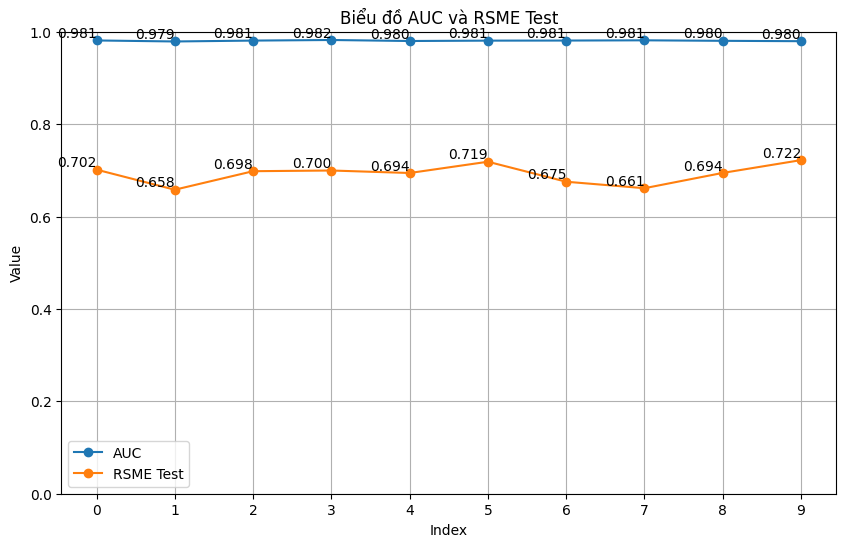

In [54]:

import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Đọc dữ liệu từ file Excel
df = pd.read_excel('./DeepCGSR_triet/results/Digital_Music_5/results_DigitalMusic.xlsx', engine='openpyxl')

# In một số dòng đầu tiên của DataFrame để kiểm tra
# print(df.head())

# Tính trung bình
mean = np.mean(df['RSME Test'])

# Tính độ lệch chuẩn (standard deviation)
std_dev = np.std(df['RSME Test'], ddof=1)

# Tính sai số chuẩn (standard error of the mean)
std_error = stats.sem(df['RSME Test'])

print("Trung bình:", mean)
print("Độ lệch chuẩn:", std_error)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))

# Vẽ biểu đồ cho cột 'AUC'
plt.plot(df.index, df['AUC'], marker='o', linestyle='-', label='AUC')

# Hiển thị giá trị của từng điểm trên đường thẳng cho cột 'AUC'
for i, txt in enumerate(df['AUC']):
    plt.text(df.index[i], df['AUC'][i], f"{txt:.3f}", ha='right', va='bottom')

# Vẽ biểu đồ cho cột 'RSME Test'
plt.plot(df.index, df['RSME Test'], marker='o', linestyle='-', label='RSME Test')

# Hiển thị giá trị của từng điểm trên đường thẳng cho cột 'RSME Test'
for i, txt in enumerate(df['RSME Test']):
    plt.text(df.index[i], df['RSME Test'][i], f"{txt:.3f}", ha='right', va='bottom')


# Đặt nhãn cho trục x và trục y
plt.xlabel('Index')
plt.ylabel('Value')

# Đặt giới hạn cho trục y từ 0 đến 1
plt.ylim(0, 1)

# Thêm chú thích cho biểu đồ
plt.legend()

# Hiển thị số liệu các mốc trên trục x và trục y
plt.xticks(df.index, df.index) # Gán các chỉ số của dòng làm mốc trên trục x

# Hiển thị biểu đồ
plt.title('Biểu đồ AUC và RSME Test')
plt.grid(True)
plt.show()

In [94]:
import pandas as pd
import numpy as np
import torch
from gensim import corpora
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import BertTokenizer, BertModel
from nltk.tokenize import word_tokenize
import json

def read_data(file_path):
    """
       params:
           file_path: Đường dẫn đến tệp
       return:
           data: Danh sách dữ liệu đã đọc, mỗi dòng là một mẫu

    """
    data = []
    with open(file_path, "r") as f:
        for line in f:
            try:
                # Chuyển đổi từ văn bản JSON sang đối tượng Python
                raw_sample = json.loads(line)
                if 'reviewText' not in raw_sample:
                    raw_sample['reviewText'] = ''
                # Chuẩn hóa dữ liệu và thêm vào danh sách data
                data.append([raw_sample['reviewerID'],
                             raw_sample['asin'],
                             raw_sample['overall'],
                             raw_sample['reviewText']])
            except json.JSONDecodeError:
                # Bắt các lỗi khi chuyển đổi từ JSON
                # Bạn có thể xử lý các lỗi ở đây nếu cần
                pass
    return data

def get_tbert_model(split_data, num_topics, num_words):
    """ T-BERT模型训练词表构建主题单词矩阵获取 """
    
    # Load pre-trained BERT model and tokenizer
    model_name = 'bert-base-uncased'
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertModel.from_pretrained(model_name)
    
    # Tokenize and get BERT embeddings for each document
    def get_bert_embeddings(texts):
        inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        return outputs.last_hidden_state.mean(dim=1)
    
    # Generate embeddings for all documents
    embeddings = []
    for text in split_data:
        embedding = get_bert_embeddings([' '.join(text)])
        embeddings.append(embedding)
    embeddings = torch.vstack(embeddings)

    # Clustering to find topics
    kmeans = KMeans(n_clusters=num_topics, random_state=0).fit(embeddings.numpy())
    labels = kmeans.labels_
    
    # Extract top words for each topic
    topic_to_words = []
    for i in range(num_topics):
        cluster_indices = [j for j, label in enumerate(labels) if label == i]
        cluster_texts = [' '.join(split_data[j]) for j in cluster_indices]
        
        vectorizer = TfidfVectorizer(max_features=num_words)
        tfidf_matrix = vectorizer.fit_transform(cluster_texts)
        
        indices = np.argsort(tfidf_matrix.sum(axis=0)).flatten()[::-1]
        feature_names = vectorizer.get_feature_names_out()
        top_words = [feature_names[ind] for ind in indices[:num_words]]
        topic_to_words.append(top_words)
    
    # Create a dummy dictionary for compatibility
    # dictionary = {i: word for i, word in enumerate(vectorizer.get_feature_names_out())}
    dictionary = corpora.Dictionary(split_data)
    corpus = [dictionary.doc2bow(text) for text in split_data]
    return embeddings, model, kmeans, dictionary, topic_to_words

def word_segment(text):
    word_seg = [i for i in word_tokenize(str(text).lower())]
    return word_seg

dataset_json = 'DeepCGSR_triet/data/DigitalMusic/Digital_Music_Filtered_1.json'
data = read_data(dataset_json)
data_df = pd.DataFrame(data)

# In cấu trúc DataFrame trước khi gán tên cột
print("DataFrame columns before renaming:", data_df.columns)

# # Kiểm tra xem DataFrame có trống hay không trước khi gán tên cột
# if not data_df.empty:
#     expected_columns = ['reviewerID', 'asin', 'overall', 'reviewText']
#     if len(data_df.columns) == len(expected_columns):
#         data_df.columns = expected_columns
#     else:
#         raise ValueError(f"Expected {len(expected_columns)} columns, but got {len(data_df.columns)} columns. Columns: {data_df.columns}")
# else:
#     raise ValueError("DataFrame is empty. Please check the data file.")

data = data_df["reviewText"].tolist()
split_data = [word_segment(i) for i in data]

num_topics = 10
num_words = 300

embeddings, model, kmeans, tbert_dictionary, tbert_topic_to_words = get_tbert_model(split_data, num_topics, num_words)

print("T-BERT dictionary: ", tbert_dictionary)
print("T-BERT topic_to_words: ", tbert_topic_to_words)


DataFrame columns before renaming: RangeIndex(start=0, stop=4, step=1)
T-BERT dictionary:  Dictionary<12320 unique tokens: ['.', 'a', 'day', 'down', 'great']...>
T-BERT topic_to_words:  [[array([['time', 'mcgraw', 'more', 'he', 'is', 'recommend', 'easy',
        'download', 'cute', 'god', 'fast', 'bless', 'talented', 'too',
        'totally', 'would', 'shipped', 'song', 'old', 'so', 'absolutely',
        'luv', 'melody', 'goodness', 'tune', 'rock', 'buy', 'mp3',
        'exquisite', 'dynamic', 'yep', 'original', 'lol', 'liked',
        'powerful', 'emotional', 'inspiring', 'smooth', 'ha', 'super',
        'gorgeous', 'awsome', 'enjoying', 'gift', 'funny', 'free',
        'upbeat', 'worked', 'greate', 'crazy', 'my', 'extremely', 'okay',
        'another', 'oldies', 'its', 'always', 'sale', 'purchase',
        'loved', 'sweet', 'amazing', 'outstanding', 'timeless',
        'favorite', 'pretty', 'fantastic', 'sound', 'the', 'prince',
        'excellant', 'superb', 'thx', 'fun', 'it', 'yes

In [ ]:
from nltk.parse.stanford import StanfordDependencyParser


class DependencyParser():
    def __init__(self, model_path, parser_path):
        # self.model = CoreNLPDependencyParser(url='http://localhost:9000')
        self.model = StanfordDependencyParser(path_to_jar=parser_path, path_to_models_jar=model_path)

    def raw_parse(self, text):
        parse_result = self.model.raw_parse(text)
        result = [list(parse.triples()) for parse in parse_result]
        return result[0]
    
model_path = './DeepCGSR_triet/config/stanford-parser-full-2020-11-17/stanford-parser-4.2.0-models.jar'
parser_path = './DeepCGSR_triet/config/stanford-parser-full-2020-11-17/stanford-parser.jar'
dep_parser = DependencyParser(model_path, parser_path)

In [109]:

from nltk.corpus import sentiwordnet as swn

def get_word_sentiment_score(word):
    m = list(swn.senti_synsets(word, "n"))
    s = 0
    for j in range(len(m)):
        # print(m[j])
        s += (m[j].pos_score() - m[j].neg_score())
    return s

def preprocessed(text):
    """ 3文本预处理
    """
    # 分句和词性还原， 目前只实现分句
    return text.split("\.")

def get_topic_sentiment_metrix(text, topic_word_metrix, dependency_parser, topic_nums=50):
    # Khởi tạo ma trận cảm xúc chủ đề
    topic_sentiment_m = np.zeros(topic_nums)

    # Lấy kết quả phân tích cú pháp phụ thuộc
    sentences = preprocessed(text)
    dep_parser_result_p = []
    for i in sentences:
        # Phân tích cú pháp phụ thuộc
        dep_parser_result = dependency_parser.raw_parse(i)
        for j in dep_parser_result:
            dep_parser_result_p.append([j[0][0], j[2][0]])

    for topic_id, cur_topic_words in enumerate(topic_word_metrix):
        # Lấy các từ khóa của chủ đề hiện tại
        cur_topic_sentiment = 0
        cur_topic_senti_word = []
        # Dựa vào từ khóa để lấy các từ cảm xúc
        for word in word_segment(text):
            if any(word in sublist for sublist in cur_topic_words):
                cur_topic_senti_word.append(word)
                for p in dep_parser_result_p:
                    if p[0] == word:
                        cur_topic_senti_word.append(p[1])
                    if p[1] == word:
                        cur_topic_senti_word.append(p[0])

        for senti_word in cur_topic_senti_word:
            # cur_topic_sentiment += word_to_senti.get(senti_word, 0)
            cur_topic_sentiment += get_word_sentiment_score(senti_word)
        # print("cur_topci_senti_word", cur_topci_senti_word)
        # 主题情感取值范围[-5, 5]
        if cur_topic_sentiment > 5:
            cur_topic_sentiment = 5
        elif cur_topic_sentiment < -5:
            cur_topic_sentiment = -5

        topic_sentiment_m[topic_id] = cur_topic_sentiment
    return topic_sentiment_m


In [122]:
def split_text(text, max_length=300):
    """Split text into smaller chunks of maximum length max_length."""
    sentences = text.split('. ')
    chunks = []
    current_chunk = []

    for sentence in sentences:
        if len(' '.join(current_chunk + [sentence])) > max_length:
            chunks.append(' '.join(current_chunk))
            current_chunk = [sentence]
        else:
            current_chunk.append(sentence)
    if current_chunk:
        chunks.append(' '.join(current_chunk))
    
    return chunks

In [125]:
text = "Lewis Black 's third album , Rules of Enragement , is his first release where his material really became more political . This time around he busts on Minnesota and his bit on their cold weather is hysterical . As usual , he 's spot on when it comes to tackling issues like greed in big business and society 's obsession with health . In particular , his commentary on milk and water are very funny . However , the end of the album is dominated by his views on Iraq . While his commentary is accurate , it does tend to drag at times . All told , Rules of Enragement is a very good album even if it tends to be too political near the end"
text_chunks = split_text(text)
fine_feature = np.zeros(num_topics)
for chunk in text_chunks:
    fine_feature_chunk = get_topic_sentiment_metrix(chunk, tbert_topic_to_words, dep_parser, topic_nums=num_topics)
    fine_feature += fine_feature_chunk
fine_feature = np.clip(fine_feature, -5, 5)
print(fine_feature)
 

[ 5.     3.875  3.375  2.25   4.625  3.25   3.125 -0.625  3.125  3.25 ]


In [120]:
fine_feature = get_topic_sentiment_metrix("Comedy CDs are an iffy recommendation . What 's funny today might bore you tomorrow . Some jokes are only funny the first time . My Time , \" scores high on the replay factor . Perhaps it 's his delivery ( dry self - deprecation with a twist of smug ) . Perhaps it 's his avant - garde style of humor ( he spends about a quarter of the time pretending to be a critical female member of his own show , weaving \" her \" comments with his ) . Perhaps it 's just his voice , which has a malleable whine to it that never gets annoying and which makes his self - mockery seem humorously authentic instead of just patronizing or pathetic . Part of it is definitely the humor itself . Whether his jokes make bizarre 180 's ( \" I used to smoke . Yeah . Smoking 's real addictive . But you know what 's REALLY addictive ? Heroin . \" ) , or whether their humor lies in their dead ends ; whether they take the \" didja ever notice ? \" concept and snap it in half ( his \" Hot Pocket \" and bottled water \/ Mexican food bits are a good example of this ) , or whether they 're just plain crude , grouchy , silly and dumpy , they all stand up to repeated listenings . There are a few times where you get the impression that the joke -- such as his bit on glasses -- would work a lot better if you could see the man ( and , in fact , most of them are like that ; Jim is almost as much fun to watch as he is to listen to ) , but none of them fail to be laugh - worthy because of it . Pasty , flabby , and grumpy , though he may be , Jim Gaffigan is also a funny , funny man , and this is a funny , funny CD . This product comes with a short DVD of his Comedy Central appearance , which is much cleaner than the act to be found on the CD . ", tbert_topic_to_words, dep_parser, topic_nums=num_topics)
print(fine_feature)

[main] INFO edu.stanford.nlp.parser.lexparser.LexicalizedParser - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... done [0.5 sec].
Parsing file: /tmp/tmpp2n7f327
Parsing [sent. 1 len. 374]: Comedy CDs are an iffy recommendation . What 's funny today might bore you tomorrow . Some jokes are only funny the first time . My Time , " scores high on the replay factor . Perhaps it 's his delivery ( dry self - deprecation with a twist of smug ) . Perhaps it 's his avant - garde style of humor ( he spends about a quarter of the time pretending to be a critical female member of his own show , weaving " her " comments with his ) . Perhaps it 's just his voice , which has a malleable whine to it that never gets annoying and which makes his self - mockery seem humorously authentic instead of just patronizing or pathetic . Part of it is definitely the humor itself . Whether his jokes make bizarre 180 's ( " I used to smoke . Yeah . Smoking 's real addictiv

OSError: Java command failed : ['/usr/bin/java', '-mx4g', '-cp', './DeepCGSR_triet/config/stanford-parser-full-2020-11-17/stanford-parser-4.2.0-models.jar:./DeepCGSR_triet/config/stanford-parser-full-2020-11-17/ejml-simple-0.39-sources.jar:./DeepCGSR_triet/config/stanford-parser-full-2020-11-17/ejml-core-0.39-sources.jar:./DeepCGSR_triet/config/stanford-parser-full-2020-11-17/stanford-parser-4.2.0-javadoc.jar:./DeepCGSR_triet/config/stanford-parser-full-2020-11-17/ejml-ddense-0.39-sources.jar:./DeepCGSR_triet/config/stanford-parser-full-2020-11-17/ejml-simple-0.38.jar:./DeepCGSR_triet/config/stanford-parser-full-2020-11-17/stanford-parser.jar:./DeepCGSR_triet/config/stanford-parser-full-2020-11-17/stanford-parser-4.2.0-sources.jar:./DeepCGSR_triet/config/stanford-parser-full-2020-11-17/slf4j-api.jar:./DeepCGSR_triet/config/stanford-parser-full-2020-11-17/slf4j-simple.jar:./DeepCGSR_triet/config/stanford-parser-full-2020-11-17/ejml-core-0.38.jar:./DeepCGSR_triet/config/stanford-parser-full-2020-11-17/ejml-ddense-0.38.jar:./DeepCGSR_triet/config/stanford-parser-full-2020-11-17/stanford-parser-4.2.0-models.jar:./DeepCGSR_triet/config/stanford-parser-full-2020-11-17/slf4j-api-1.7.12-sources.jar', 'edu.stanford.nlp.parser.lexparser.LexicalizedParser', '-model', 'edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz', '-sentences', 'newline', '-outputFormat', 'conll2007', '-encoding', 'utf8', '/tmp/tmpp2n7f327']